# TR-Santé : Observe bacteria interaction to define the relations

**Introduction :** The main goal of this project is to determine the relations between bacteria. 
Indeed, there are two main processes for bacteria to exchange biological information through DNA :

- **HGT : Horizontal Gene Transfer**

This process has been studied already (*cf bibliography*), in general it concerns transfer of genes situated far away.
- **HAT : Horizontal Allele Transfer**

This process is also called 'recombination', it concerns in general genes that are situated at the same place between bacteria.

## First step : Comparing two genomes of bacteria

In [177]:
# Import the necessary modules
import os
from subprocess import call
import re
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import math
import bisect
import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import set_link_color_palette
from matplotlib.colors import ListedColormap
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio import Phylo
from Bio import SeqIO
from Bio.Blast import NCBIXML
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import Voronoi


In [178]:
# Set the names of the two bacteria
bacteria1 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta"
bacteria2 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_AP017617.1.fasta"

In [263]:
# Set the names of the two bacteria
bacteria1 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP021165.1.fasta"
bacteria2 = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP033345.1.fasta"

### Using Mummer

We will first use mummer to compare the genomes of two bacteria.
Here the code is very simple, we only use the 'mum' attribute, which is computing the maximal matches that are unique in both sequences.
We then plot a histogram with a log-log scale to interpret the results.

mummer -mum /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_AP017617.1.fasta


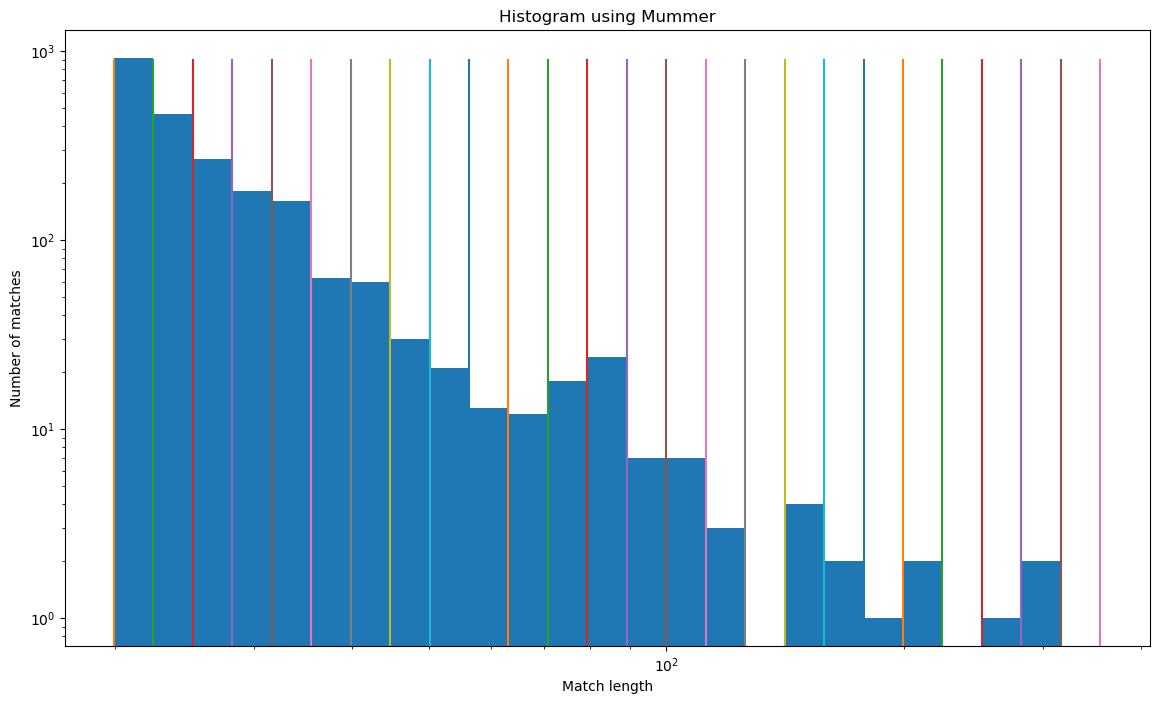

In [179]:
# Use mummer to compare the genomes of the two bacteria
print("mummer", "-mum", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-mum", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        matches.append(match_length)

# Plot the graph of the number of matches according to the length of the segments
bins = [10**(i/20) for i in range(26, 52)]
plt.figure(figsize=(14, 8))
pl.hist(matches, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins[:34]:
    plt.plot([bin,bin], [0, 900])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Mummer")
pl.show()

Now we will go further by adding more attributes to the mummer command : 
- First the 'maxmatch' attribute, which will compute all maximal matches regardless of their uniqueness.
- Then the '-b' option to calculate the pairings on the complementary strands.
- Finally the '-n' attribute to exclude nucleotides for which we have no information.

Then we also plot few power-law which should be rightly representing our results because of the theory of gene transfer.

In [ ]:
# Use mummer to compare the genomes of the two bacteria
print("mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2)
#mummer_init = subprocess.run("conda activate bio")
mummer_output = subprocess.run(["mummer", "-maxmatch", "-n", "-b", bacteria1, bacteria2], capture_output=True, cwd='/')

# Parse the output from mummer to get the list of matches
max_matches = []
for line in mummer_output.stdout.splitlines():
    if line.startswith(b" "):
        # This line contains a match, so get the length of the match
        match_length = int(line.split()[-1])
        max_matches.append(match_length)


# compute the logarithmically binned histogram of the match lengths
#bins = [10**(i/35) for i in range(46, 105)]  # bins from 10 to 1e4
#hist, _ = np.histogram([m for m in max_matches], bins=bins)
matches_sorted = max_matches.sort()

### Without logarithmic bining

We can plot first without logarithmic bining, then we will therefore have more points when we will reach long matches. It is a great first plot to see the repartition of matches and to compare to known-models.
To do so, we first create a function named `count_occurences` to know the number of matches associated to each length.

In [181]:
def count_occurrences(numbers):
  # Create a new list to store the results
  results = []

  # Create a variable to store the current number we are counting
  current_number = None

  # Create a variable to store the current number of occurrences
  current_count = 0
  
  # Iterate over the numbers in the list
  for number in numbers:
    # If the current number is different from the number we are counting,
    # add the current number and its count to the results list, and reset
    # the current number and count
    if number != current_number:
      if current_number is not None:
        results.append([current_number, current_count])
      current_number = number
      current_count = 0

    # Increment the current count
    current_count += 1

  # Add the final number and its count to the results list
  results.append([current_number, current_count])

  return results

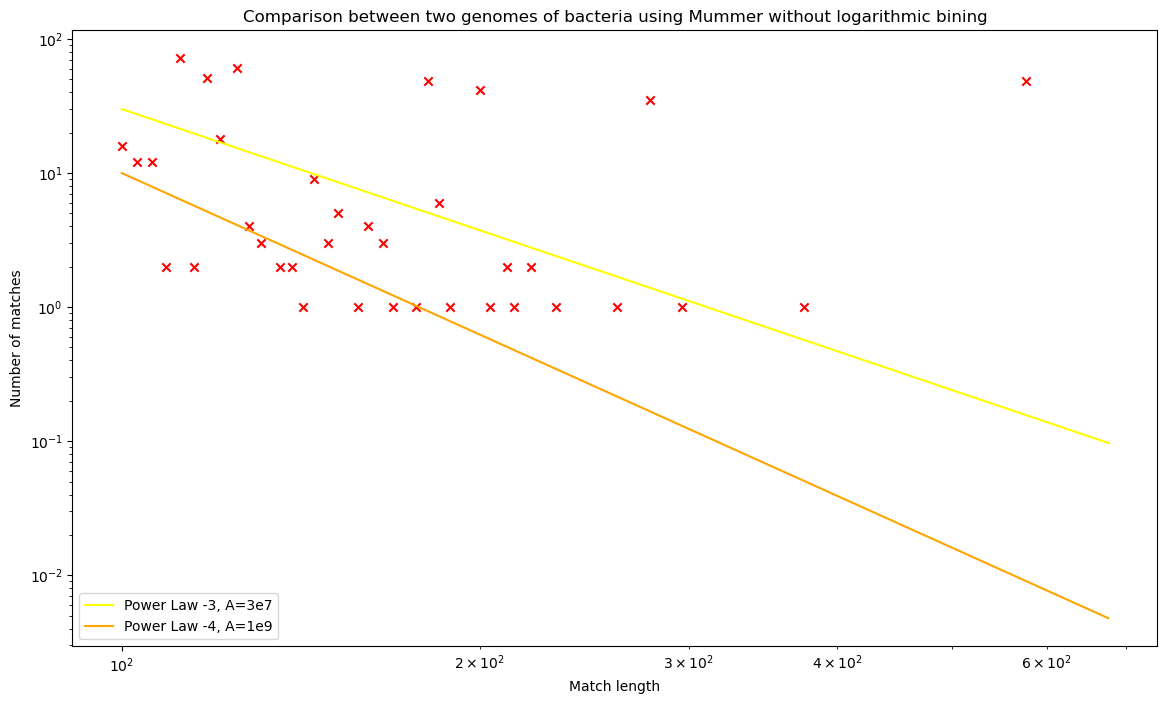

In [182]:
matches_sorted = count_occurrences(max_matches)
segment_lengths, occurrences = zip(*matches_sorted)


# Create the logarithmic bins using numpy
bins = np.logspace(np.log10(min(segment_lengths)), np.log10(max(segment_lengths)), 10)
plt.figure(figsize=(14, 8))
# Plot the logarithmic bins using matplotlib
#plt.hist(segment_lengths, bins=bins, weights=occurrences)
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[::3], occurrences[::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Mummer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

In [183]:
matches_sorted[-1]

[676, 21]

We have got our first plot of a third of our lengths !
A first interesting point is that it seems that our matches tend to respect the power-law models, even though there are still noise to work on.

### With logarithmic bining

Now we are going to use something called a ``logarithmic bining``. 

The logarithmic bining is a method used in order to represent points in a log-log graph, regrouping them in bins by dividing the number of matches in that bin by the size of the bin. 

Therefore, we reduce the noise that might appears with large matches and we obtain one point for each bin.
We can then try to find bins to rightly tackle our comparison of bacteria.

First we create few functions to find the right bins, to regroup matches and to divide by the length of the bin.

In [184]:
def match_check(match):
    new_match = []
    for new, element in match:
        new_match.append(new)
    return new_match

def floor_numbers(numbers):
    return [math.floor(number) for number in numbers]

def find_interval(sorted_list, number):
    # Find the index of the number in the sorted list using bisect_left
    import bisect
    index = bisect.bisect_left(sorted_list, number)   
    # Return the number divided by the length of the interval
    return index

def calculate_bins(index, bins, list_sorted):
    """
    Given a list of bins, a sorted list and an index, return as an output the bining associated to 
    """
    # Given a list of bins, do the calculation of the mean of the length
    num_list = []
    len_list = []
    for len, num in list_sorted :
        num_list.append(num)
        len_list.append(len)
    interval = find_interval(bins, index)
    interval_check = interval
    sum = 0
    count_length = 0
    while interval_check == interval :
        if index in match_check(list_sorted): 
            i = bisect.bisect_left(len_list, index)
            sum += num_list[i]
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
        else:
            index += 1
            count_length += 1
            interval = find_interval(bins, index)
    return sum/count_length, index

Now we can plot our Mummer method with logarithmic bining, we will compare it to the power-law models :

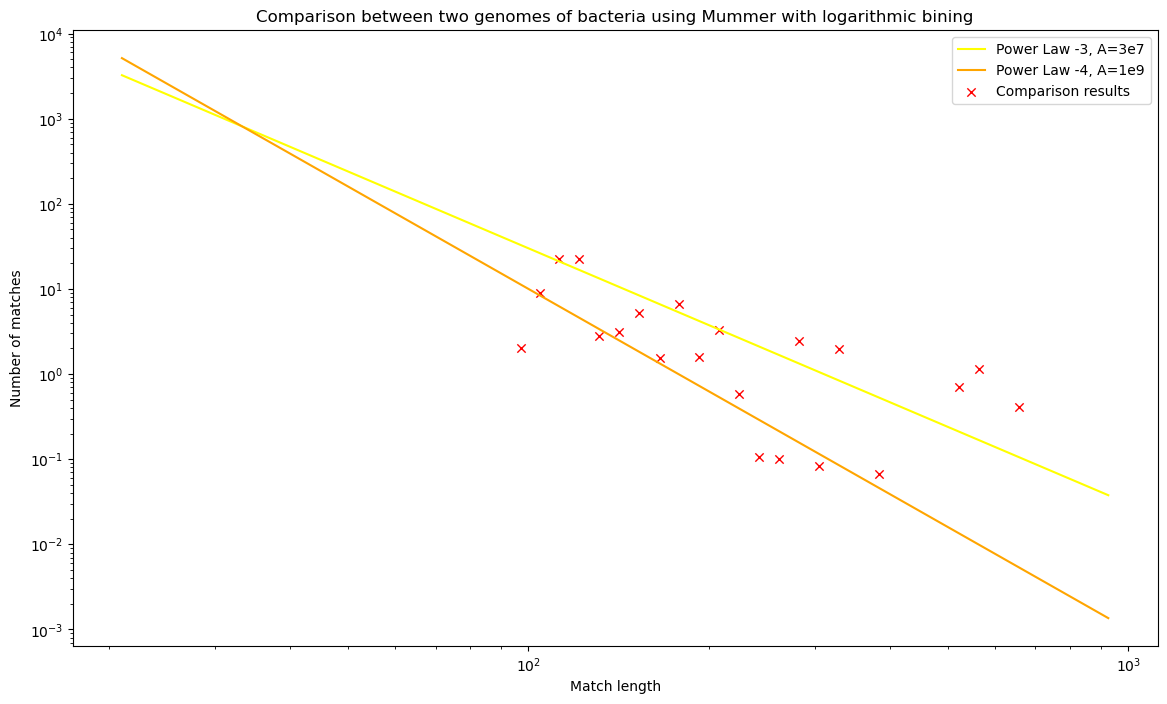

In [185]:
matches_sorted = count_occurrences(list(max_matches))
bins = floor_numbers([10**(i/30) for i in range(40, 90)])
hist, pos = [], []
index = 0

while index <= matches_sorted[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, matches_sorted)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**7/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins, Powerlaw_3, color = 'yellow', label = 'Power Law -3, A=3e7')
plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=1e9')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.title('Comparison between two genomes of bacteria using Mummer with logarithmic bining')
plt.legend(loc = 1)
plt.show()


Thanks to logarithmic bining we have been able to reduce significantly the noise with huge lengths. Now that the graph is smoother, the power-models are even more precise and it is interesting to see that each model has few points that are sticking to it.

The main issue with Mummer is that it takes too much time to deal with short matches, ie matches that are smaller than 20 nucleotides. It takes way too long to process so we have to find a solution, `Nucmer` !

### Using Nucmer

To use Nucmer, we will do approximatively the same method used with Mummer for the beginning : opening the Ubuntu terminal, running the command and storing the output (there in a new file).

In [186]:
# run nucmer to compare the genomes and save the output in a file
output_file = "output_nucmer.coords"
subprocess.run(["nucmer", "-l","20","-maxmatch","-o", "-p", "output_nucmer", bacteria1, bacteria2], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
sum = 0


# parse the nucmer output file to extract the matches and their lengths
matches_n = []
with open(output_file) as f:
    lines = f.readlines()
    # I do the next step because of a weird problem regarding len(lines)
    len_lines = 0
    for element in lines :
        len_lines += 1
    for index in range(6, len_lines):
        line = lines[index]
        sum += 1
        fields = line.strip().split()
        matches_n.append(int((int(fields[6]) + int(fields[7]))/2))

# compute the logarithmically binned histogram of the match lengths
matches_sorted_n = matches_n.sort()


The main difference with Nucmer is that it does not return the lengths of the match directly but zones that contains almost perfect matches.

Our technique will be to explore each zone and to extract all of the exact matches, it will considerably reduce the processing time !
To do so, we use the `show-aligns` method, still using the Ubuntu terminal.

In [187]:
show_aligns_output = subprocess.run(["show-aligns", "-r", "output_nucmer.delta", "NC_020307.1", "NZ_AP017617.1"], capture_output = True)
segments_l, segments_l_new = [], []
for line in show_aligns_output.stdout.splitlines():
    segments_l.append(line)
for line in segments_l[4:]:
    line = line.decode()
    segments_l_new.append(line)

We can now look at what the output looks like : a succesion of lines with segments comparison. What will be interesting is to use the third line of the comparison, fully constitued of empty spaces and "^". We will store each length of segments by only looking at those lines.

In [188]:
segments_l_new[:10]

['',
 '-- BEGIN alignment [ +1 8691 - 9285 | -1 2357265 - 2356672 ]',
 '',
 '',
 '8691       ttaattgcaggcataaaaaaaccagccctgagaggctggtttttaaggg',
 '2357265    ttaaatgcagatataaaaaaaccaaccgt.aaaggttggttttt.ttgg',
 '               ^     ^^            ^  ^ ^ ^   ^        ^^^  ',
 '',
 '8740       gaattttggtcggcacgagaggatttgaacctccgacccccgacacccc',
 '2357218    gatttttggtcggcacgagaggatttgaacctccgacccccgacacccc']

We will first have to separate each zone with the function written below :

In [189]:
def separate_segments(lines):
    segments = []
    segment = []
    in_segment = False
    for line in lines:
        if line.startswith("-- BEGIN "):
            in_segment = True
        elif line.startswith("--   END "):
            in_segment = False
            segments.append(segment[2:-2])
            segment = []
        elif in_segment:
            segment.append(line)
    return segments

Then we have several steps to get only the lines that are intersting, erasing the beginning of each line which is basically only empty space and to not take part into the length of the segments.

In [190]:
segments_sep = separate_segments(segments_l_new)
segments_sep.insert(0, '') 

new_list = []
for element in segments_sep:
    new_list.append(element[2::4])

new_list = new_list[1:]
lines_phrase =[]

for zone in new_list:
    phrase = ''
    for bout in zone:
        phrase += str(bout[15:])
    lines_phrase.append(phrase)
for phrase in lines_phrase[::1000]:
    print(phrase)

^     ^^            ^  ^ ^ ^   ^        ^^^                                                                                ^    ^         ^^      ^  ^   ^      ^^^  ^ ^^^                                   ^     ^     ^  ^    ^ ^  ^   ^ ^   ^  ^  ^ ^      ^ ^    ^  ^  ^^  ^^  ^  ^^ ^  ^ ^         ^  ^        ^   ^   ^  ^  ^            ^^ ^^^  ^  ^  ^  ^          ^   ^  ^^ ^ ^  ^ ^^     ^  ^  ^         ^^  ^             ^              ^   ^       ^        ^  ^  ^^                ^     ^  ^    ^     ^ ^^  ^  ^           ^  ^        ^   ^^      


Now that we are able to have only the interesting parts, we can store all the segments in a list using the following method.

In [191]:
segment_lengths = []
for phrase in lines_phrase:
    ln_seg = 0
    indice = 0
    len_phrase = 0
    for charac in phrase:
        len_phrase += 1
    while indice < len_phrase:
        if phrase[indice] == ' ':
            ln_seg += 1
            indice += 1
        else:
            if ln_seg == 0:
                indice += 1
            else:
                segment_lengths.append(ln_seg)
                indice += 1
                ln_seg = 0    
                
segment_lengths_sorted = segment_lengths.sort()
show_aligns_segments = count_occurrences(segment_lengths)

Then we can plot with the same method used before the lengths of the segments, which is now including lengths which are lower than 10 nucleotides.

We can plot the histogram (which is not really logarithmic bining because it is not divided by the length of the bin).

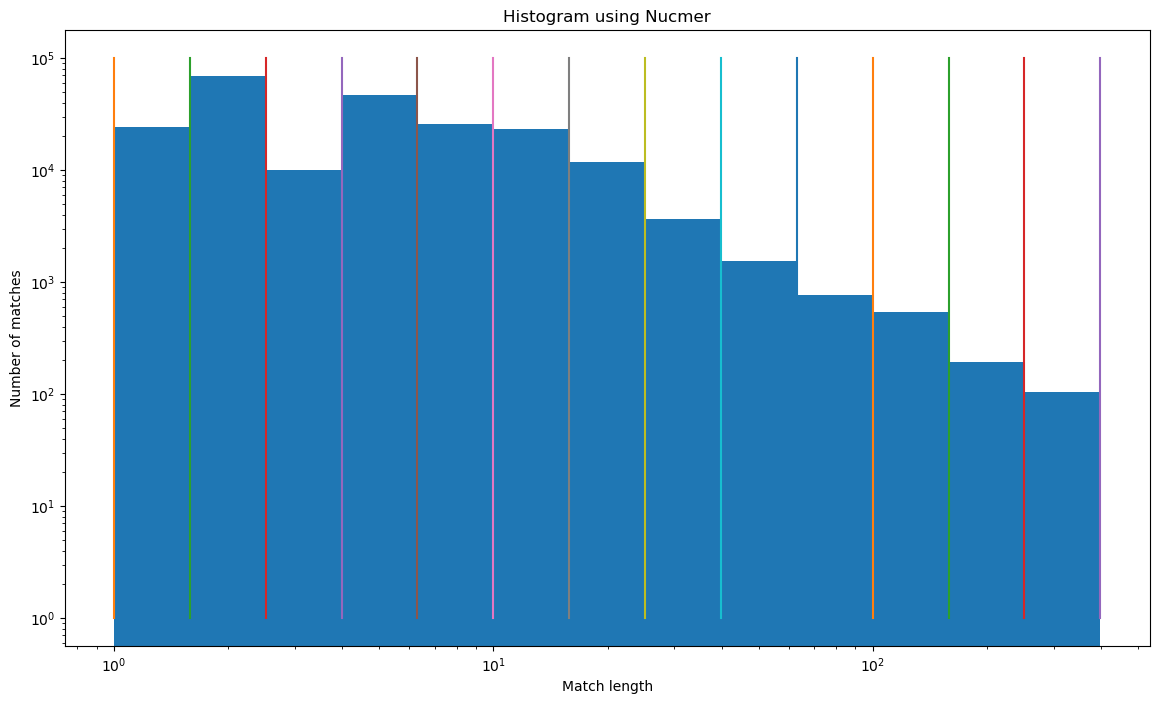

In [192]:
bins = [10**(i/5) for i in range(0, 14)]
plt.figure(figsize=(14, 8))
pl.hist(segment_lengths, bins=bins)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
for bin in bins:
    plt.plot([bin,bin], [1,100000])
pl.xlabel("Match length")
pl.ylabel("Number of matches")
plt.title("Histogram using Nucmer")
pl.show()

We can plot without logarithmic bining, even though it seems that it won't be very useful because of the fact that data is not identically distributed.

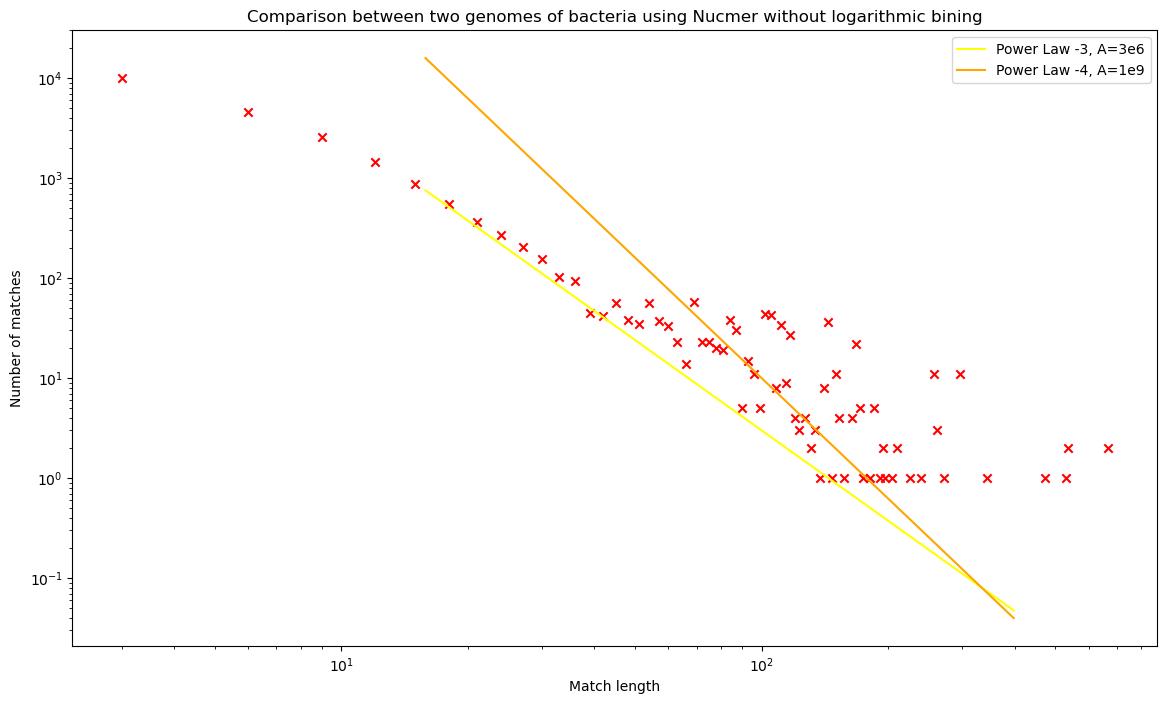

In [193]:
segment_lengths, occurrences = zip(*show_aligns_segments)
plt.figure(figsize=(14, 8))
pl.xlabel("Match length")
pl.ylabel("Number of matches")
Powerlaw_3 = [3*10**6/x**3 for x in bins]
Powerlaw_4 = [10**9/x**4 for x in bins]
plt.plot(bins[6:], Powerlaw_3[6:], color = 'yellow', label = 'Power Law -3, A=3e6')
plt.plot(bins[6:], Powerlaw_4[6:], color = 'orange', label = 'Power Law -4, A=1e9')
plt.scatter(segment_lengths[2::3], occurrences[2::3], color = 'r', marker = 'x')
plt.xscale('log')
plt.title('Comparison between two genomes of bacteria using Nucmer without logarithmic bining')
plt.yscale('log')
plt.legend()
plt.show()

It is somehow interesting because we observe a kind of threshold situated at the 40th length, with a weird form then.

Then we apply our logarithmic bining to plot our comparison :

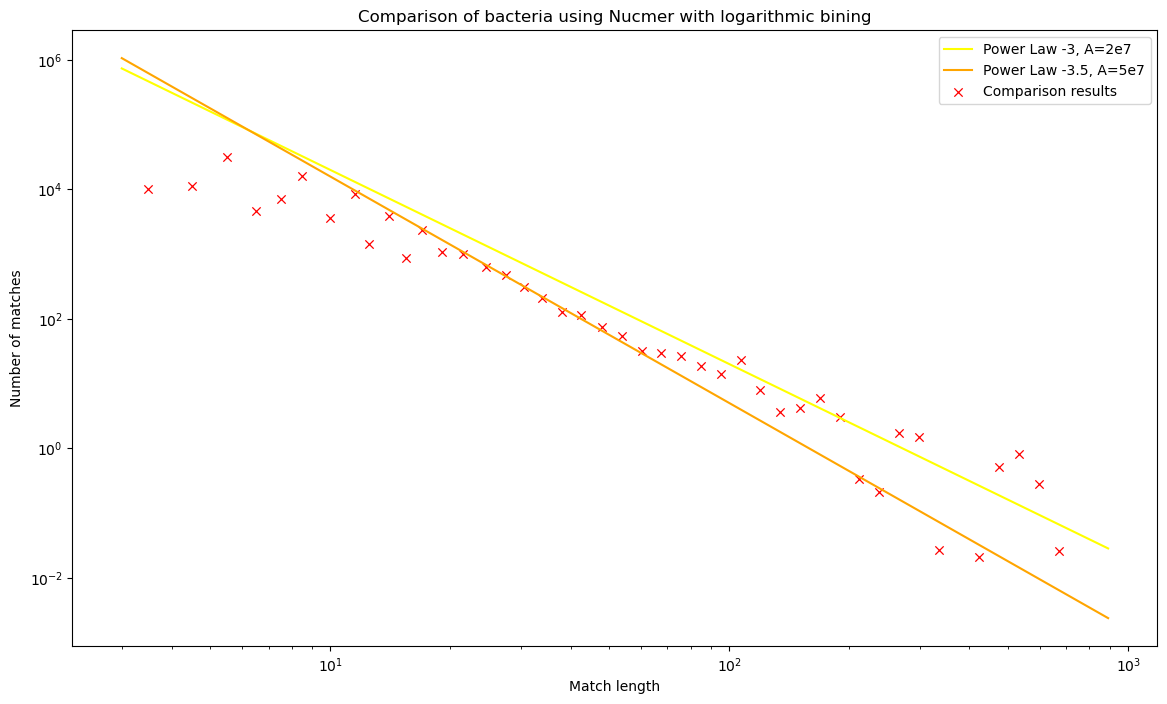

In [194]:
plt.rcdefaults()
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0
while index <= show_aligns_segments[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")

# Calculate best fit line
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
#plt.plot(pos[1:14], fit, 'r', label='Fit')
plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'orange', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.9, c = 'r',label = 'Comparison results')
plt.title('Comparison of bacteria using Nucmer with logarithmic bining')
plt.legend(loc = 1)
plt.show()

There I plotted two power laws : a -3 and a -3,5. They are the more accurate ones are respect the shape of the points.  
The power law is thus mainly respected between the two bacteria !

Now something interesting would be to clean our data : as we can see in the previous graph, despite the use of the logarithmic bining there is still some noise.  
Then we can use few functions in order to remove outlyers and to smooth the plot.  
Consequently, we will try to not loose too much information while fitting the data as righly as we can.

[0, 0.0, 0.5, 1.75, 2.875, 5.9375, 7.96875, 9.984375]


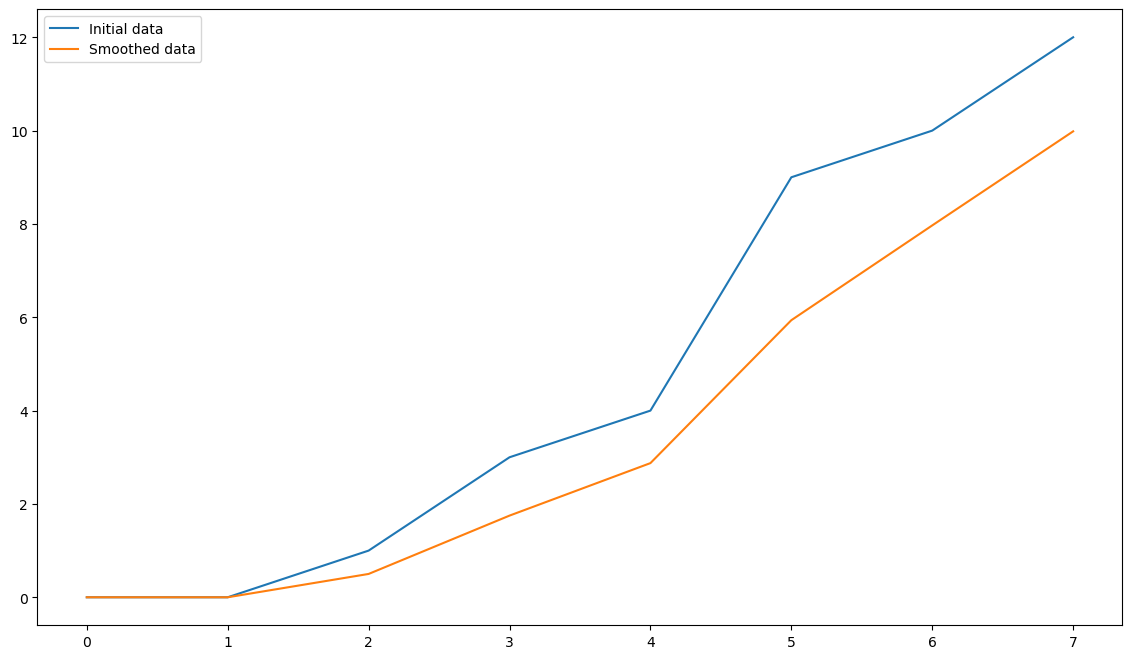

In [195]:
def erase_inf(log):
    for i in range(len(log)) :
        number = log[i]
        if number == np.inf or number == -np.inf :
            log[i] = (log[i - 1] + log[i + 1])/2

def smooth_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Test the function
points = [0, 0, 1, 3, 4, 9, 10, 12]
smoothed_points = smooth_curve(points, factor=0.5)
plt.figure(figsize=(14, 8))
print(smoothed_points)  # [0, 0, 0.5, 1.5, 3.5, 6.5, 9.5, 11]
plt.plot(points, label = 'Initial data')
plt.plot(smoothed_points, label = 'Smoothed data')
plt.legend()

import numpy as np

import numpy as np

def remove_outliers_pairwise(x, y, threshold=1):
    """
    Removes outliers from the input data using the Z-score method.
    Outliers are defined as points that are more than 'threshold' standard deviations
    away from the mean.
    """
    # Zip the x and y arrays and treat each pair as a single data point
    data = np.column_stack((x, y))
    # Calculate the mean and standard deviation of the d
    # ata
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # Calculate the Z-scores of each data point
    z_scores = (data - mean) / std
    # Filter out any data points with a Z-score greater than the threshold
    filtered_data = data[np.all(np.abs(z_scores) <= threshold, axis=1)]
    # Unzip the filtered data back into separate x and y arrays
    x_filtered, y_filtered = filtered_data[:, 0], filtered_data[:, 1]
    return x_filtered, y_filtered


There we show an example of how we can smooth a random initial data. The orange graph is representing the smoothed data, we will follow this example for our data.  
Now we will apply this to our data :

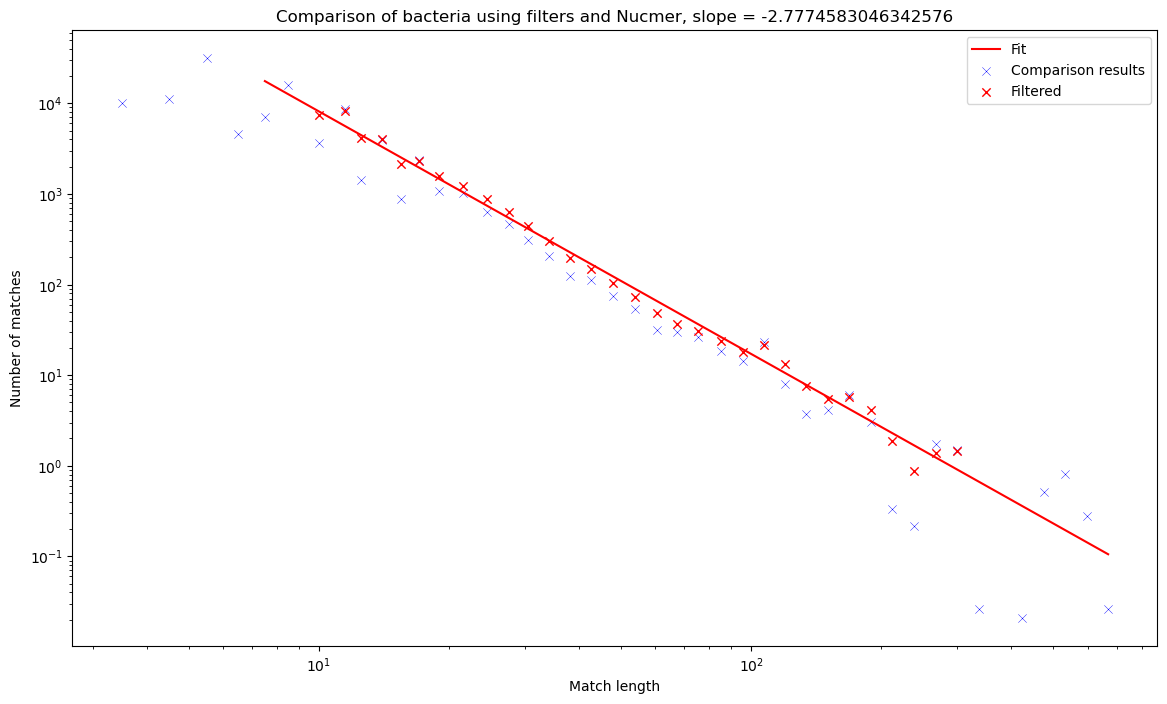

In [196]:
bins = floor_numbers([10**(i/20) for i in range(7, 60)])
hist, pos = [], []
index = 0
while index <= show_aligns_segments[-1][0] :
    hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
    hist.append(hist_bin)
    pos.append((index + agg) / 2)
    index = agg
plt.figure(figsize=(14, 8))
hist_filtered =  smooth_curve(hist, factor = 0.4)
pos_filtered, hist_filtered = remove_outliers_pairwise(pos, hist_filtered)
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel("Match length")
pl.ylabel("Number of matches")

logx = np.log10(pos_filtered[1:])
logy = np.log10(hist_filtered[1:])
erase_inf(logy)
coeffs = np.polyfit(logx[:14], logy[:14], 1)
coeffs1 = np.polyfit(logx[5:], logy[5:], 1)
# Calculate best fit line
fit = 10 ** (coeffs[1]) * pos[1:14] ** coeffs[0]
fit1 = 10 ** (coeffs1[1]) * pos[5:] ** coeffs1[0]
Powerlaw_3 = [2*10**7/x**3 for x in bins]
Powerlaw_4 = [5*10**8/x**4 for x in bins]
Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
#plt.plot(pos[1:14], fit, 'r', label='Fit')
plt.plot(pos[5:], fit1, 'r', label='Fit')
#plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
#plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
#plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
#plt.scatter(bins[:-1], hist, marker = 'x', linewidth = 1.0, c = 'r', label = 'Comparison results')
plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.3, c = 'b',label = 'Comparison results')
plt.scatter(pos_filtered[1:], hist_filtered[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
plt.title('Comparison of bacteria using filters and Nucmer, slope = ' + str(coeffs[0]))
plt.legend(loc = 1)
plt.show()

It is quite interesting because now the points seem to follow a more precise power-law.  
Thanks to this behaviour, we can rightly plot the straight line fitting our data !

## The comparison function : `compare_2_genomes`

We will now group the previously written functions in order to automate our process.

In [108]:
def get_filename_wo_fasta(path) -> str:
    data = []
    with open(path, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    input_string = data[0]
    words = input_string.split()
    return words[0][1:] 
    
def remove_commas(string):
    # Replace commas with an empty string
    new_string = string.replace(",", "")
    return new_string
    
def get_genome(input_string: str) -> str:
    # Split the input string into a list of words
    words = input_string.split()
    
    # Check if the input string contains "complete genome" or "complete sequence"
    if "genome" in input_string:
        # Find the index of the "complete genome" word
        genome_index = words.index("complete")
    elif "sequence" in input_string:
        # Find the index of the "complete sequence" word
        genome_index = words.index("complete")
    else:
        # Return an empty string if neither "complete genome" nor "complete sequence" is present
        return ""
    
    # Check if the word "chromosome" is in the input string
    if "chromosome," in words:
        # Return the two words preceding "complete genome" or "complete sequence"
        return f"{words[genome_index - 2]} {words[genome_index - 1]}"
    else:
        # Return the word preceding "complete genome" or "complete sequence"
        return words[genome_index - 1]

def get_filename(filename) -> str:
    data = []
    with open(filename, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    input_string = data[0]
    words = input_string.split()
    return words[0][1:] + '.fasta'

def get_family(input_string: str) -> str:
    # Split the input string into a list of words
    words = input_string.split()
    return words[1] + ' ' + words[2]

def get_name_and_family(filename):
    data = []
    with open(filename, "r") as f:
    # Read the contents of the files
        for line in f:
            data.append(line)
    return remove_commas(get_genome(data[0])), get_family(data[0])

def replace_spaces_with_underscores(string):
    # Replace spaces with underscores
    new_string = string.replace(" ", "_")
    return new_string

In [22]:
def compare_2_genomes(genome1, genome2):
    # run nucmer to compare the genomes and save the output in a file
    output_file = "output_nucmer.coords"
    subprocess.run(["nucmer", "-l","20","-maxmatch","-o", "-p", "output_nucmer", genome1, genome2], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    sum = 0


    # parse the nucmer output file to extract the matches and their lengths
    matches_n = []
    with open(output_file) as f:
        lines = f.readlines()
        # I do the next step because of a weird problem regarding len(lines)
        len_lines = 0
        for element in lines :
            len_lines += 1
        for index in range(6, len_lines):
            line = lines[index]
            sum += 1
            fields = line.strip().split()
            matches_n.append(int((int(fields[6]) + int(fields[7]))/2))

    # compute the logarithmically binned histogram of the match lengths
    matches_sorted_n = matches_n.sort()
    show_aligns_output = subprocess.run(["show-aligns", "-r", "output_nucmer.delta", get_filename_wo_fasta(genome1), get_filename_wo_fasta(genome2)], capture_output = True)
    segments_l, segments_l_new = [], []
    for line in show_aligns_output.stdout.splitlines():
        segments_l.append(line)
    for line in segments_l[4:]:
        line = line.decode()
        segments_l_new.append(line)
    segments_sep = separate_segments(segments_l_new)
    segments_sep.insert(0, '') 

    new_list = []
    for element in segments_sep:
        new_list.append(element[2::4])

    new_list = new_list[1:]
    lines_phrase =[]

    for zone in new_list:
        phrase = ''
        for bout in zone:
            phrase += str(bout[15:])
        lines_phrase.append(phrase)
    segment_lengths = []
    for phrase in lines_phrase:
        ln_seg = 0
        indice = 0
        len_phrase = 0
        for charac in phrase:
            len_phrase += 1
        while indice < len_phrase:
            if phrase[indice] == ' ':
                ln_seg += 1
                indice += 1
            else:
                if ln_seg == 0:
                    indice += 1
                else:
                    segment_lengths.append(ln_seg)
                    indice += 1
                    ln_seg = 0    
                    
    segment_lengths_sorted = segment_lengths.sort()
    show_aligns_segments = count_occurrences(segment_lengths)
    bins = floor_numbers([10**(i/20) for i in range(7, 60)])
    hist, pos = [], []
    index = 0
    while index <= show_aligns_segments[-1][0] :
        hist_bin, agg  = calculate_bins(index, bins, show_aligns_segments)
        hist.append(hist_bin)
        pos.append((index + agg) / 2)
        index = agg

    name1, family1 = get_name_and_family(genome1)
    name2, family2 = get_name_and_family(genome2)
    plt.figure(figsize=(14, 8))
    
    hist_filtered =  smooth_curve(hist, factor = 0.4)
    pos_filtered, hist_filtered = remove_outliers_pairwise(pos, hist_filtered)
    pl.gca().set_xscale("log")
    pl.gca().set_yscale("log")
    pl.xlabel("Match length")
    pl.ylabel("Number of matches")

    logx = np.log10(pos_filtered[1:])
    logy = np.log10(hist_filtered[1:])
    erase_inf(logy)
    
    coeffs = np.polyfit(logx[:14], logy[:14], 1)
    coeffs1 = np.polyfit(logx[5:], logy[5:], 1)
    # Calculate best fit line
    fit = 10 ** (coeffs[1]) * pos[1:14] ** coeffs[0]
    fit1 = 10 ** (coeffs1[1]) * pos[5:] ** coeffs1[0]
    Powerlaw_3 = [2*10**7/x**3 for x in bins]
    Powerlaw_4 = [5*10**8/x**4 for x in bins]
    Powerlaw_3_5 = [5*10**7/x**(3.5) for x in bins]
    #plt.plot(pos_filtered[1:14], fit, 'r', label='Fit')
    plt.plot(pos[5:], fit1, 'r', label='Fit')
    #plt.plot(bins[5:], Powerlaw_3[5:], color = 'yellow', label = 'Power Law -3, A=2e7')
    #plt.plot(bins[5:], Powerlaw_3_5[5:], color = 'magenta', label = 'Power Law -3.5, A=5e7')
    #plt.plot(bins, Powerlaw_4, color = 'orange', label = 'Power Law -4, A=5e8')
    plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 0.3, c = 'b',label = 'Comparison results')
    plt.scatter(pos_filtered[1:], hist_filtered[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
    #plt.scatter(pos[1:], hist[1:], marker = 'x', linewidth = 1.0, c = 'r', label = 'Filtered')
    plt.title(name1 + '/' + family1 + ' and ' + name2 + '/' + family2 + ' Slope ' + str(coeffs1[0]))
    plt.legend(loc = 1)
    plt.show()

Now we can test with bacteria from our two families : Salmonella and Escheria_coli

In [23]:
bacteriaA = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli/NZ_CP033635.1.fasta'
bacteriaB = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NZ_OU943337.1.fasta'

In [114]:
compare_2_genomes(bacteriaA, bacteriaB)

NameError: name 'bacteriaA' is not defined

## Comparing a bacteria to a whole other family

Something interesting would be to compare the genome of a bacteria from the Salmonella family to the whole Escherichia coli family to see the differences.
First we will interest us on the different graphs to see weither there are or not many differences, and then we will compare by calculating the sum of the distances from a -3 or -4 slope straight line.

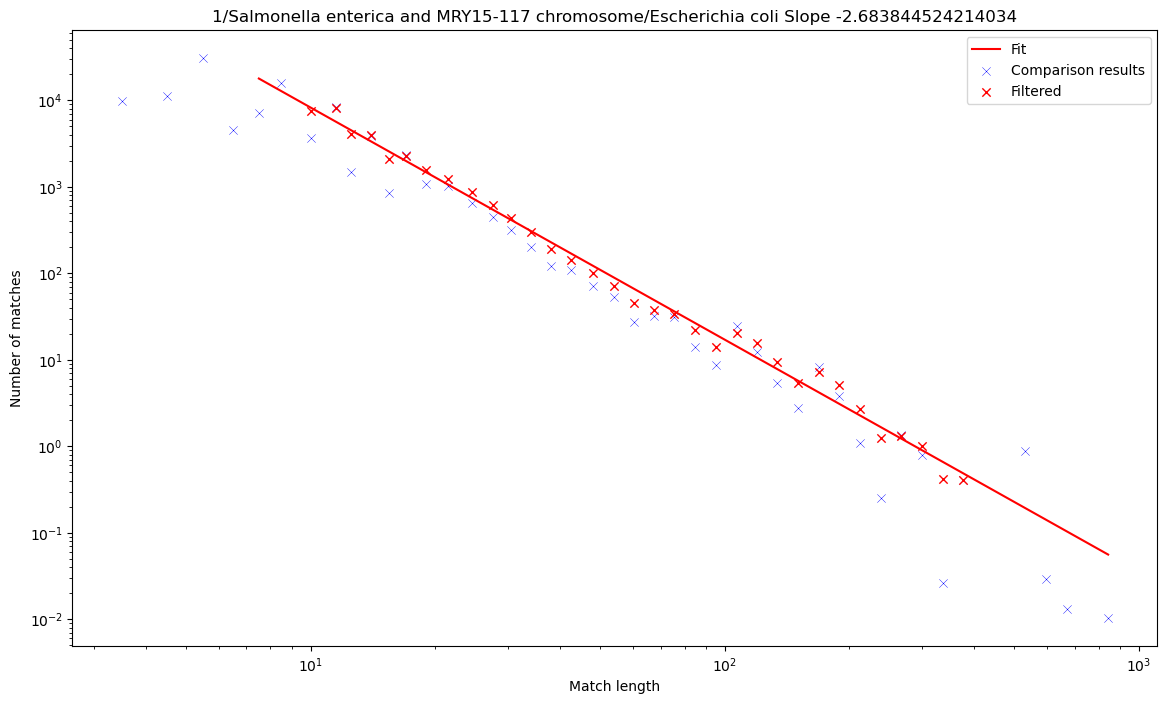

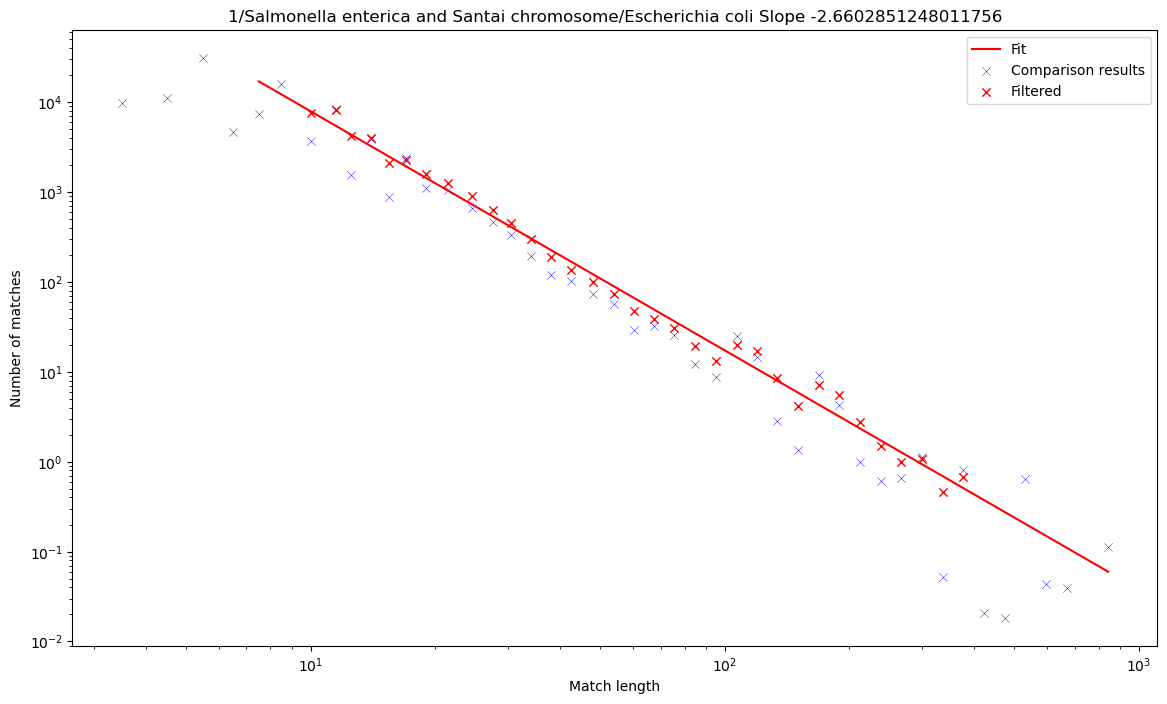

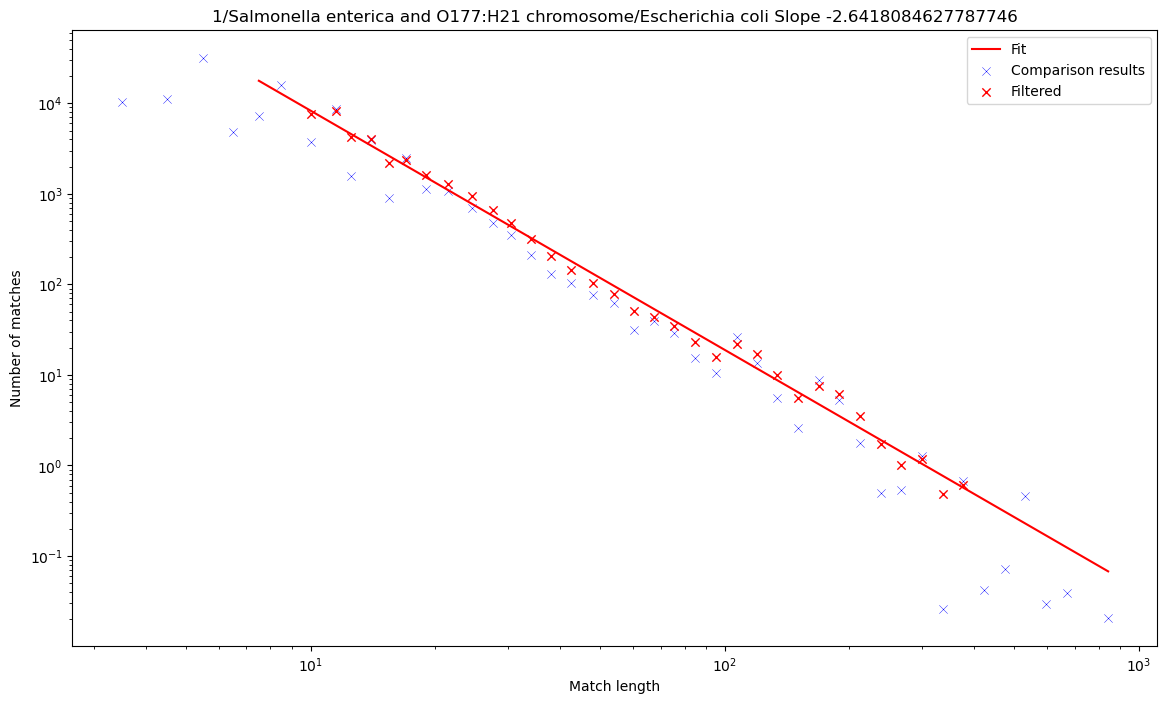

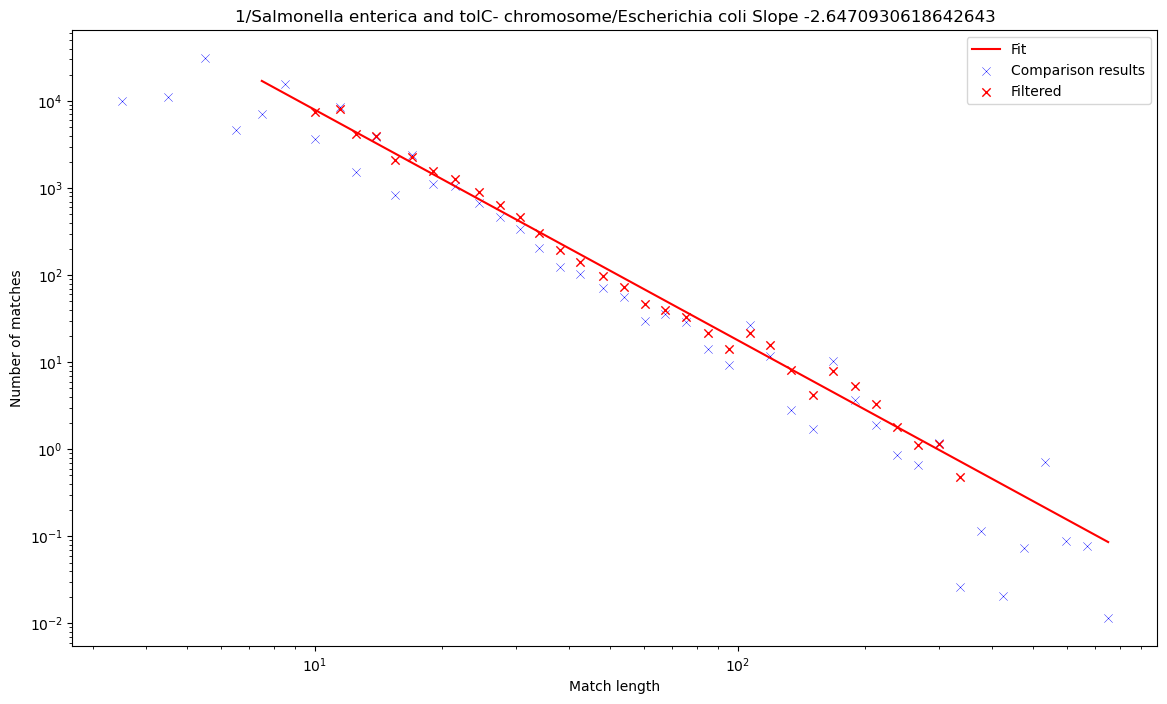

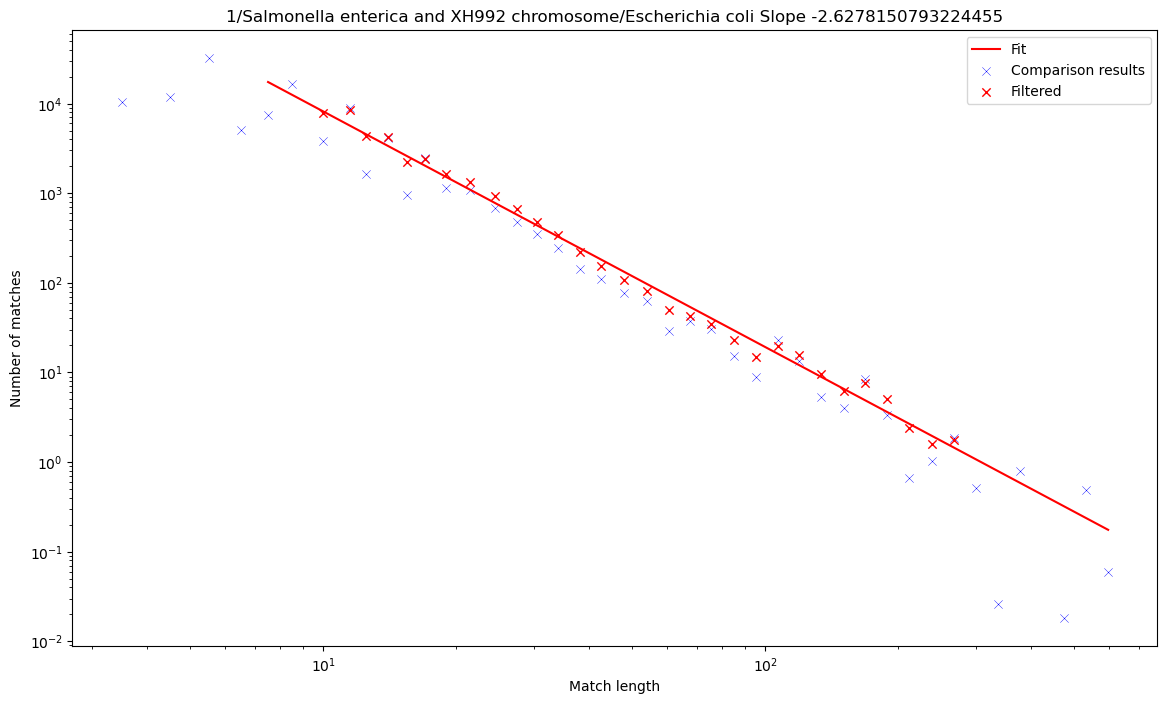

In [25]:
# Set the directory containing the files
directory = '/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Escherichia_coli'

# Get the list of files in the directory
files = os.listdir(directory)
# Iterate over the files
for file in files[:5]:
    # Do something with the file
    compare_2_genomes(bacteriaB, directory + '/' + file)
    plt.show()

## Blast to create phylogenetic tree

We can use `Blast` to align our segments but using a more efficient method : we will have to do these operations many times, it has to be quick !  
Here the idea is to try to classify our bacteria using comparisons of genome.
- First we will compare two random genomes to store the 10 longer exact matches.
- Then we will compare the 10 sequences to all the bacteria from a specific folder (size n), we will then assign to a bacteria the weighted mean of the similarities to the 10 sequences.
- We will do this process for all pair of bacteria to create a matrix for each bacteria (the matrix is thus symmetrical so we have to do only n(n+1)/2 pairs).
- At this point we will have n distant matrixes (size nxn), we will then do a clustering method to classify our bacteria through a phylogenetic tree.
The thing is that this operation costs a lot of time, $10^3$ seconds for only 10 bacteria ...

In [1]:
def find_closest_blast(fasta_file, sequence_file, sequence):
    
    makeblastdb_exe = "/home/antoine/anaconda3/envs/bio/bin/makeblastdb"
    blastn_exe = "/home/antoine/anaconda3/envs/bio/bin/blastn"
    
    # Set the prefix for the output files
    output_prefix = "blast_output"
    segment_blast = []
    # Set the minimum length of matches to report
    min_match_length = 1
    
    # Create a BLAST database for each genome
    makeblastdb_cmd1 = [makeblastdb_exe, "-in", sequence_file, "-dbtype", "nucl", "-out", output_prefix + "_1"]
    makeblastdb_cmd2 = [makeblastdb_exe, "-in", fasta_file, "-dbtype", "nucl", "-out", output_prefix + "_2"]
    call(makeblastdb_cmd1)
    call(makeblastdb_cmd2)

    # Run BLAST to compare the two genome sequences
    blastn_cmd = [blastn_exe, "-db", output_prefix + "_1", "-query", fasta_file, "-out", output_prefix + ".out", "-outfmt", "6 qseqid sseqid pident length qstart qend sstart send"]
    call(blastn_cmd)

    # Read the matching segments from the BLAST output file
    with open(output_prefix + ".out") as blast_output:
        for line in blast_output:
            # Parse the fields from the BLAST output
            fields = line.strip().split()
            print(fields)
            # Extract the start and end positions of the matching segment in each genome
            genome1_start = int(fields[4])
            genome1_end = int(fields[5])
            genome2_start = int(fields[6])
            genome2_end = int(fields[7])

            # Calculate the length of the matching segment
            segment_length = genome1_end - genome1_start + 1
            segment_blast.append(segment_length)
            # Check if the segment is long enough to be reported
    #       if segment_length >= min_match_length:
    #            # Print the matching segment details
    #           print("Matching segment:")
    #           print("  Genome 1: positions {}-{}".format(genome1_start, genome1_end))
    #           print("  Genome 2: positions {}-{}".format(genome2_start, genome2_end))
    #           print("  Length: {} nucleotides".format(segment_length))
    #           print("")

    # Clean up the intermediate output files
    os.remove(output_prefix + "_1.nhr")
    os.remove(output_prefix + "_1.nin")
    os.remove(output_prefix + "_1.nsq")
    os.remove(output_prefix + "_2.nhr")
    os.remove(output_prefix + "_2.nin")
    os.remove(output_prefix + "_2.nsq")

    segment_blast_sorted = segment_blast.sort()
    segment_blast_sorted = count_occurrences(list(segment_blast))
    if segment_blast_sorted != [[None, 0]]:
        return 100 * (segment_blast_sorted[-1][0] / len(sequence))
    else:
        return 0

In [2]:
def find_closest_match(sequence, fasta_file):
    # Write the input sequence to a temporary FASTA file
    with open("temp.fasta", "w") as f:
        f.write(">query\n{}\n".format(sequence))

    # Set the BLAST command
    blast_command = "'/home/antoine/anaconda3/envs/bio/bin/blastn' -query /mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/temp.fasta -subject {} -max_target_seqs 10 -outfmt 6".format(fasta_file)

    # Run the BLAST command and capture the output
    output = subprocess.run(blast_command, shell=True, capture_output=True)

  
    # Parse the output
    lines = output.stdout.decode("utf-8").split("\n")
    best_match = None
    best_similarity = 0
    sim_return = 0
    for line in lines:

        # Skip empty lines
        if not line:
            continue
        # Split the line into columns
        cols = line.split("\t")
        # Extract the identity column
        similarity = float(cols[3])/float(cols[7])
        # Update the best match if necessary
        if similarity > best_similarity:
            best_match = cols[1]
            best_similarity = similarity
            sim_return = cols[3]

    # Return the best match and its similarity
    return sim_return

In [174]:
def compare_sequence_10(path1, path2):
    # Set the input and output files
    input_file = path1
    other_file = path2
    output_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml"

    # Set the reward and penalty values
    reward = 2
    penalty = -3

    # Set the BLAST command
    blast_command = "'/home/antoine/anaconda3/envs/bio/bin/blastn' -query {input_file} -subject {other_file} -outfmt 5 -reward {reward} -penalty {penalty}".format(input_file=input_file, reward=reward, penalty=penalty, other_file = other_file)

    # Run the BLAST command and redirect the output to the output file
    with open(output_file, "w") as out:
        subprocess.run(blast_command, shell=True, stdout=out)
    result_handle = open("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml")
    blast_records = NCBIXML.parse(result_handle)

    # Initialize a list to store the longest matches
    longest_matches = []

    # Iterate through the BLAST records
    for blast_record in blast_records:
        # Iterate through the alignments
        for alignment in blast_record.alignments:
            # Iterate through the hsps (high-scoring pairs)
            for hsp in alignment.hsps:
                # Check if the hsp has no mismatches
                if hsp.align_length <= hsp.positives <= hsp.align_length:
                    # Extract the sequence and its length
                    sequence = hsp.sbjct
                    length = hsp.align_length
                    # Add the sequence and its length to the list of longest matches
                    longest_matches.append((sequence, length))
                    # Sort the list of longest matches by length
                    longest_matches.sort(key=lambda x: x[1], reverse=True)
                    # Keep only the 10 longest matches
                    longest_matches = longest_matches[:10]

    # Close the BLAST output file
    result_handle.close()
    return longest_matches


In [315]:
def mummer_sequence_10(path1, path2):
    #mummer_init = subprocess.run("conda activate bio")
    mummer_output = subprocess.run(["mummer", "-maxmatch", "-n", "-l", "100" , "-s", path1, path2], capture_output=True, cwd='/')

    # Parse the output from mummer to get the list of matches
    max_matches = []
    ind_line = 0
    j = 0
    for line in mummer_output.stdout.splitlines():
        j += 1
    for line in mummer_output.stdout.splitlines():
        if (ind_line >= 3) and (ind_line < j - 1):
            if ind_line % 2 : 
                match_length = int(line.split()[-1])
            # This line contains a match, so get the length of the match
            else : 
                match_sequence = line.split()[-1].decode()
                max_matches.append((match_length, match_sequence.upper()))
        ind_line += 1


    # compute the logarithmically binned histogram of the match lengths
    #bins = [10**(i/35) for i in range(46, 105)]  # bins from 10 to 1e4
    #hist, _ = np.histogram([m for m in max_matches], bins=bins)
    matches_sorted = max_matches.sort()
    return list(reversed(max_matches[-10:]))

In [175]:
def compare_sequence_10_middle(path1, path2):
    # Set the input and output files
    input_file = path1
    other_file = path2
    output_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml"

    # Set the reward and penalty values
    reward = 2
    penalty = -3

    # Set the BLAST command
    blast_command = "'/home/antoine/anaconda3/envs/bio/bin/blastn' -query {input_file} -subject {other_file} -outfmt 5 -max_target_seqs 10 -reward {reward} -penalty {penalty}".format(input_file=input_file, reward=reward, penalty=penalty, other_file = other_file)

    # Run the BLAST command and redirect the output to the output file
    with open(output_file, "w") as out:
        subprocess.run(blast_command, shell=True, stdout=out)
    result_handle = open("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/output.xml")
    blast_records = NCBIXML.parse(result_handle)

    # Initialize a list to store the longest matches
    longest_matches = []

    # Iterate through the BLAST records
    for blast_record in blast_records:
        # Iterate through the alignments
        for alignment in blast_record.alignments:
            # Iterate through the hsps (high-scoring pairs)
            for hsp in alignment.hsps:
                # Check if the hsp has no mismatches
                if hsp.positives == hsp.align_length:
                    # Extract the sequence and its length
                    sequence = hsp.sbjct
                    length = hsp.align_length
                    # Add the sequence and its length to the list of longest matches
                    longest_matches.append((sequence, length))
                    # Sort the list of longest matches by length
                    longest_matches.sort(key=lambda x: x[1], reverse=True)
    # Keep only the 10 longest matches
    list_len = len(longest_matches)
    mid_index = int(list_len / 2)
    longest_matches = longest_matches[mid_index - 5 : mid_index + 5]

    # Close the BLAST output file
    result_handle.close()
    return longest_matches


In [309]:
input_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP033345.1.fasta"
other_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP021165.1.fasta"
longest_matches = compare_sequence_10(input_file, other_file)
# Print the longest matches
for sequence, length in longest_matches:
   print(sequence, length)

AAATTTGGCTCCTCTGACTGGACTCGAACCAGTGACATACGGATTAACAGTCCGCCGTTCTACCGACTGAACTACAGAGGAATCGTGTG 89
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
TGGTGCGAGGGGGGGGACTTGAACCCCCACGTCCGTAAGGACACTAACACCTGAAGCTAGCGCGTCTACCAATTCCGCCACCTTCGC 87
CTTTCAAATTTTGGAGCGGGAAACGAGACTCGAACTCGCGACCCCGACCTTGGCAAGGTCGTGCTCTACCAACTGAGCTATTCCCGC 87
TGGTGGTGGGGGAAGGATTCGAACCTTCGAAGTCGATGACGGCAGATTTACAGTCTGCTCCCTTTGGCCGCTCGGGAACCCCACC 85
AAATTGGTGGGTCGTGCAGGATTCGAACCTGCGACCAATTGATTAAAAGTCAACTGCTCTACCAACTGAGCTAACGACCCG 81
GTGCTGATATGGCTCAGTTGGTAGAGCGCACCCTTGGTAAGGGTGAGGTCCCCAGTTCGACTCTGGGTATCAGCACCACTT 81
TGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCACCAT 79
ATTGGTGGGTCGTGCAGGATTCGAACCTGCGACCAATTGATTAAAAGTCAACTGCTCTACCAACTGAGCTAACGACCCG 79
AGTGGTGGGTGATGACGGGATCGAACCGCCGACCCCCTCCTTGTAAGGGAGGTGCTCTCCCAGCTGAGCTAATCACCC 78


In [317]:
input_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP033345.1.fasta"
other_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha/NZ_CP021165.1.fasta"
longest_matches = mummer_sequence_10(input_file, other_file)
# Print the longest matches
for length, sequence in longest_matches:
   print(sequence, length)

CGCCAAAACATCTTCGGCGTTGTAAGGTTAAGCCTCACGGTTCATTAGTACCGGTTAGCTCAACGCATCGCTGCGCTTACACACCCGGCCTATCAACGTCGTCGTCTTCAACGTTCCTTCAGGAGACTTAAAGTCTCAGGGAGAACTCATCTCGGGGCAAGTTTCGTGCTTAGATGCTTTCAGCACTTATCTCTTCCGCATTTAGCTACCGGGCAGTGCCATTGGCATGACAACCCGAACACCAGTGATGCGTCCACTCCGGTCCTCTCGTACTAGGAGCAGCCCCCCTCAATTCTCCAGCGCCCACGGCAGATAGGGACCGAACTGTCTCACGACGTTCTAAACCCAGCTCGCGTACCACTTTAAATGGCGAACAGCCATACCCTTGGGACCTACTTCAGCCCCAGGATGTGATGAGCCGACATCGAGGTGCCAAACACCGCCGTCGATATGAACTCTTGGGCGGTATCAGCCTGTTATCCCCGGAGTACCTTTTATCCGTTGAGCGATGGCCCTTCCATTCAGAACCACCGGATCACTATGACCTGCTTTCGCACCTGCTCGCGCCGTCACGCTCGCAGTCAAGCT 588
CGCCAAAACATCTTCGGCGTTGTAAGGTTAAGCCTCACGGTTCATTAGTACCGGTTAGCTCAACGCATCGCTGCGCTTACACACCCGGCCTATCAACGTCGTCGTCTTCAACGTTCCTTCAGGAGACTTAAAGTCTCAGGGAGAACTCATCTCGGGGCAAGTTTCGTGCTTAGATGCTTTCAGCACTTATCTCTTCCGCATTTAGCTACCGGGCAGTGCCATTGGCATGACAACCCGAACACCAGTGATGCGTCCACTCCGGTCCTCTCGTACTAGGAGCAGCCCCCCTCAATTCTCCAGCGCCCACGGCAGATAGGGACCGAACTGTCTCACGACGTTCTAAACCCAGCTCGCGTACCACTTTAAATGGCGAACAGCCATACCCTTGGGACCTACTTCAGCCCCAG

In [14]:
# Test the function
similarities = []
for sequence_long, length in longest_matches:
    sequence = sequence_long
    fasta_file = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Salmonella/NC_020307.1.fasta"
    best_similarity = find_closest_match(sequence, fasta_file)
    similarities.append(best_similarity)
similarities

['78', '77', '77', '77', '77', '77', '76', '76', '76', '76']

In [15]:
def count_matches(list):
    # Extract the sequences from the alignment
    sequences = []
    for sequence, length in list:
        sequences.append(sequence)

    # Calculate the similarities between the sequences and all the fasta files in the folder
    similarities = []
    for file in os.listdir("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test"):
        similarities_file = 0
        total_length = 0
        if file.endswith(".fasta"):
            file_path = os.path.join("/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Test", file)
            for sequence in sequences :
                total_length += len(sequence)
                file_similarities = find_closest_match(sequence, file_path)
                similarities_file += file_similarities
        similarities.append(similarities_file/total_length)
    return similarities

In [437]:
def whole_matrix_bacteria(path):
    # Initialize list to store match counts for each genome
    folder = [f for f in os.listdir(path) if f.endswith('.fasta')]
    match_counts = [[] for _ in range(len(folder))]
    matrix_genome = [[[0 for i in range(len(folder))] for i in range(len(folder))] for i in range(len(folder))]
    names = []
    for file in folder:
        filename = path + '/' + file
        name, family = get_name_and_family(filename)
        names.append(str(name) + ' ' + str(family))

    # Compare each genome pair and store match counts
    for i in range(len(folder)):
        for k in range(len(folder)):
            matrix_genome[k][i][i] = 0
        for j in range(i + 1, len(folder)):
            # Perform BLAST and store 10 longest exact matches
            longest_matches = compare_sequence_10(path + '/' + folder[i], path + '/' + folder[j])
            match_counts_i = [0]*len(folder)
            match_counts_j = [0]*len(folder)
            sequences = []
            total_length = 0
            for sequence, length in longest_matches:
                sequences.append(sequence)
                total_length += length
            # Compare matches to all genomes in the folder
    
            for k in range(len(folder)):
                match_count = 0
                file = folder[k]
                genome = path + '/' + file
                for sequence in sequences:
                    match_count += float(find_closest_match(sequence, genome))
                matrix_genome[k][i][j] = np.abs(1 - (float(match_count) / float(total_length)))
                matrix_genome[k][j][i] = np.abs(1 - (float(match_count) / float(total_length)))

    return matrix_genome, names

In [60]:
def whole_matrix_bacteria_middle(path):
    # Initialize list to store match counts for each genome
    folder = [f for f in os.listdir(path) if f.endswith('.fasta')]
    match_counts = [[] for _ in range(len(folder))]
    matrix_genome = [[[0 for i in range(len(folder))] for i in range(len(folder))] for i in range(len(folder))]
    names = []
    for file in folder:
        filename = path + '/' + file
        name, family = get_name_and_family(filename)
        names.append(str(name) + ' ' + str(family))
    sum = 0
    # Compare each genome pair and store match counts
    for i in range(len(folder)):
        sum += 1
        print(sum)
        for k in range(len(folder)):
            matrix_genome[k][i][i] = 0
        for j in range(i + 1, len(folder)):
            # Perform BLAST and store 10 longest exact matches
            longest_matches = compare_sequence_10_middle(path + '/' + folder[i], path + '/' + folder[j])
            match_counts_i = [0]*len(folder)
            match_counts_j = [0]*len(folder)
            sequences = []
            total_length = 0
            
            for sequence, length in longest_matches:
                sequences.append(sequence)
                total_length += length
            # Compare matches to all genomes in the folder
    
            for k in range(len(folder)):
                match_count = 0
                file = folder[k]
                genome = path + '/' + file
                for sequence in sequences:
                    match_count += float(find_closest_match(sequence, genome))
                matrix_genome[k][i][j] = np.abs(1 - (float(match_count) / float(total_length)))
                matrix_genome[k][j][i] = np.abs(1 - (float(match_count) / float(total_length)))

    return matrix_genome, names

In [438]:
def whole_matrix_bacteria_mummer(path):
    # Initialize list to store match counts for each genome
    folder = [f for f in os.listdir(path) if f.endswith('.fasta')]
    match_counts = [[] for _ in range(len(folder))]
    matrix_genome = [[[0 for i in range(len(folder))] for i in range(len(folder))] for i in range(len(folder))]
    names = []
    for file in folder:
        filename = path + '/' + file
        name, family = get_name_and_family(filename)
        names.append(str(name) + ' ' + str(family))

    # Compare each genome pair and store match counts
    for i in range(len(folder)):
        print(str(i) + ' /20')
        for k in range(len(folder)):
            matrix_genome[k][i][i] = 0
        for j in range(i + 1, len(folder)):
            # Perform BLAST and store 10 longest exact matches
            longest_matches = mummer_sequence_10(path + '/' + folder[i], path + '/' + folder[j])
            match_counts_i = [0]*len(folder)
            match_counts_j = [0]*len(folder)
            sequences = []
            total_length = 1
            for length, sequence in longest_matches:
                if length >= 1000:
                    sequences.append(sequence)
                    total_length += length
            # Compare matches to all genomes in the folder
    
            for k in range(len(folder)):
                match_count = 0
                file = folder[k]
                genome = path + '/' + file
                for sequence in sequences:
                    match_count += float(find_closest_match(sequence, genome))
                matrix_genome[k][i][j] = np.abs(1 - (float(match_count) / float(total_length)))
                matrix_genome[k][j][i] = np.abs(1 - (float(match_count) / float(total_length)))

    return matrix_genome, names

In [439]:
#For the 10 longest
path = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha"
whole_matrix_bact, names = whole_matrix_bacteria_mummer(path)

0 /20
1 /20
2 /20
3 /20
4 /20
5 /20
6 /20
7 /20
8 /20
9 /20
10 /20
11 /20
12 /20
13 /20
14 /20
15 /20
16 /20
17 /20
18 /20
19 /20


In [401]:
#Test 20 bacteria
names = ['O177:H21 chromosom Escherichia coli', 'USDA-ARS-USMARC-1923 chromosome Salmonella enterica', '311189_208186 chromosome Salmonella enterica', '311189_201186 chromosome Salmonella enterica', 'ECCNB12-2 chromosome Escherichia coli', 'USDA15WA-1 chromosome Salmonella enterica', 'CFSAN003959 chromosome Salmonella enterica', '61 chromosome Escherichia coli', '53 chromosome Escherichia coli', 'SI67 chromosome Salmonella enterica', 'SI43 chromosome Salmonella enterica', 'S530 chromosome Salmonella enterica', 'S304 chromosome Salmonella enterica', 'PK8276 chromosome Escherichia coli', 'PK8261 chromosome Escherichia coli', 'Swellow chromosome Salmonella enterica', 'PJ-T13 chromosome Escherichia coli', 'ZTA19/00847 chromosome Salmonella enterica', 'KMi025 chromosome Escherichia coli', 'KFu024 chromosome Escherichia coli']
whole_matrix_bact = [[[0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2729111363923651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18019451812555265,0.0,0.010633232820187244,0.44431464174454827],[0.0,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.3792383933229003,0.0,0.25447316103379725,0.0,0.0],[0.0,0.016968325791855254,0,0.48561245348288695,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0,0.0],[0.0,0.016968325791855254,0.48561245348288695,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0,0.0],[0.0,0.002421307506053294,0.0,0.0,0,0.0,0.0024539877300613355,0.0062653837547549385,0.974101829402689,0.6673913043478261,0.0022650056625141968,0.7964576890638179,0.0023419203747072626,0.8296892980437285,0.22270078540663796,0.0023837902264600697,0.07792207792207795,0.0,0.08073115003808073,0.8447798742138365],[0.0,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.7254031315727973,0.8546304541406946,1.0,0.5100334448160535,0.0,0.0,0.4924749163879598,0.8261758691206544,1.0,0.8575481558906973,0.0],[0.0,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.0,0.0,0.0,0.0,0.0062653837547549385,0.0012690355329949554,0.0,0,0.0,0.000247035573122556,0.00013014055179594308,0.0002469745616201502,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.0,0.0006751687921980887],[0.2729111363923651,0.0,0.0,0.0,0.974101829402689,0.0,0.0,0.0,0,0.2126709461345242,0.0006894174422612531,0.0004657661853749717,0.0,0.38155922038980505,0.0,0.0,0.2444040036396724,0.0,0.6445110977804439,0.6060856498873028],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.000247035573122556,0.2126709461345242,0,0.4288192293396109,0.8960622287877389,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.340041928721174,0.5010912265386294,0.0002798376941374192,0.7403156384505021],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.0022650056625141968,0.8546304541406946,0.31776180698151946,0.00013014055179594308,0.0006894174422612531,0.4288192293396109,0,0.8901346848097751,0.41498439125910513,0.0,0.0,0.22023809523809523,0.8674179648657607,0.8222988761544453,0.7044277713198774,0.0],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.7964576890638179,1.0,0.4424841213832039,0.0002469745616201502,0.0004657661853749717,0.8960622287877389,0.8901346848097751,0,0.7731126362535325,0.693344391457599,0.7687437520826391,0.22023809523809523,0.0,1.0,0.7361530715005036,0.8212429378531073],[0.0,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.0023419203747072626,0.5100334448160535,0.24989923417976623,0.0,0.0,0.25058823529411767,0.41498439125910513,0.7731126362535325,0,0.0,0.0,0.24670912951167723,0.8284176292475047,0.14875609130546297,0.0,0.0],[0.0,0.0,0.0,0.0,0.8296892980437285,0.0,0.0,0.0,0.38155922038980505,0.2784552845528455,0.0,0.693344391457599,0.0,0,0.3849585723390695,0.0,0.0,0.0,0.38412098298676745,0.5814518930184092],[0.0,0.0,0.0,0.0,0.22270078540663796,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.7687437520826391,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.18019451812555265,0.0,0.0,0.0,0.07792207792207795,0.8261758691206544,0.0,0.0,0.2444040036396724,0.340041928721174,0.8674179648657607,0.0,0.8284176292475047,0.0,0.0,0.0,0,1.0,0.3136424588891241,0.44920049200492007],[0.0,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,1.0,0.02484645449469569,0.0,0.0,0.5010912265386294,0.8222988761544453,1.0,0.14875609130546297,0.0,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.010633232820187244,0.0,0.0,0.0,0.08073115003808073,0.8575481558906973,0.0,0.0,0.6445110977804439,0.0002798376941374192,0.7044277713198774,0.7361530715005036,0.0,0.38412098298676745,0.0,0.0,0.3136424588891241,1.0,0,0.5253594564702164],[0.44431464174454827,0.0,0.0,0.0,0.8447798742138365,0.0,0.0,0.0006751687921980887,0.6060856498873028,0.7403156384505021,0.0,0.8212429378531073,0.0,0.5814518930184092,0.0,0.0,0.44920049200492007,0.1932938856015779,0.5253594564702164,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7245337159253946,0.821103374397429,0.0010787486515642097,1.0,0.9893818733409178,1.0,1.0,1.0,1.0,0.8514449486505852,0.2416829745596869,0.0011806375442739991,0.9797524314765694,0.0011709601873535203,1.0,0.7375389408099688],[0.0011778563015312216,0,0.0011312217194570096,0.0011312217194570096,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0012077294685990392,0.07246376811594202,0.07246376811594202,0.07246376811594202,0.04987102321582115,0.0011235955056179137,0.0011820330969267712,0.060511215440792854,0.0012004801920768582,0.0009940357852882276,0.0011534025374855261,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.9310498453797369,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.0010050251256281673,0.7747540983606558,0.0],[0.0012135922330096527,0.0011312217194570096,0.9310498453797369,0,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.0010050251256281673,0.7747540983606558,0.0],[0.7245337159253946,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.8733497426717387,0.9714569098523254,0.6673913043478261,0.12004530011325032,0.82569581107675,0.1241217798594848,0.9087073264288454,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.8452830188679246],[0.821103374397429,0.05494505494505497,0.0,0.0,0.12282734646581694,0,0.0,0.48857868020304573,0.5065963060686016,0.8116382332320635,1.0,1.0,0.8028149386845039,0.10634146341463413,0.11339092872570189,0.0,1.0,1.0,0.9722263700164253,0.11213047910295615],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0,0,0.0,0.0,0.0005133470225873182,0.0005133470225873182,0.0007057163020465218,0.046755340588472416,0.0,0.0,0.11897435897435893,0.0,0.0002791736460077132,0.0011376564277587597,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.8733497426717387,0.48857868020304573,0.0,0,0.7629676202452059,1.0,1.0,1.0,0.0,0.7551309271054494,1.0,0.0,1.0,0.0,0.9044967880085653,1.0],[0.9893818733409178,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.5065963060686016,0.0,0.7629676202452059,0,0.8559866034049679,0.795243019648397,0.8954354913833256,0.0012135922330096527,0.7616191904047976,0.2528147389969294,0.0012658227848101333,0.953958143767061,0.0011918951132301459,0.9798440311937613,1.0],[1.0,0.07246376811594202,0.0,0.0,0.6673913043478261,0.8116382332320635,0.0005133470225873182,1.0,0.8559866034049679,0,0.8765952174451741,0.7540047087064906,0.47058823529411764,0.2774390243902439,0.0,0.12003968253968256,1.0,0.4478393714535137,0.9750944452217714,0.7403156384505021],[1.0,0.07246376811594202,0.0,0.0,0.12004530011325032,1.0,0.0005133470225873182,1.0,0.795243019648397,0.8765952174451741,0,0.8071369064148848,0.9040582726326742,0.1174496644295302,0.12367491166077738,0.12003968253968256,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07246376811594202,0.0,0.0,0.82569581107675,1.0,0.0007057163020465218,1.0,0.8954354913833256,0.7540047087064906,0.8071369064148848,0,1.0,0.8861704333402447,0.8037320893035655,0.12003968253968256,1.0,1.0,1.0,0.8748022598870057],[1.0,0.04987102321582115,0.0,0.0,0.1241217798594848,0.8028149386845039,0.046755340588472416,0.0,0.0012135922330096527,0.47058823529411764,0.9040582726326742,1.0,0,0.10536585365853657,0.11339092872570189,0.0,1.0,0.14901256732495516,0.0011520737327188613,0.11111111111111116],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9087073264288454,0.10634146341463413,0.0,0.7551309271054494,0.7616191904047976,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10536585365853657,0,0.5666029318036967,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.2416829745596869,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11339092872570189,0.0,1.0,0.2528147389969294,0.0,0.12367491166077738,0.8037320893035655,0.11339092872570189,0.5666029318036967,0,0.0012180267965895553,0.0,0.0011723329425556983,0.12740141557128415,0.16402609506057786],[0.0011806375442739991,0.060511215440792854,0.0012300123001229846,0.0012300123001229846,0.0,0.0,0.11897435897435893,0.0,0.0012658227848101333,0.12003968253968256,0.12003968253968256,0.12003968253968256,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0,0.0,0.0011376564277587597,0.0],[0.9797524314765694,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,1.0,0.0,1.0,0.953958143767061,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.0,0,1.0,0.9266709012633213,1.0],[0.0011709601873535203,0.0009940357852882276,0.0010050251256281673,0.0010050251256281673,0.0,1.0,0.0002791736460077132,0.0,0.0011918951132301459,0.4478393714535137,1.0,1.0,0.14901256732495516,0.0011123470522802492,0.0011723329425556983,0.0,1.0,0,1.0,0.1932938856015779],[1.0,0.0011534025374855261,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.9722263700164253,0.0011376564277587597,0.9044967880085653,0.9798440311937613,0.9750944452217714,1.0,1.0,0.0011520737327188613,0.7648393194706995,0.12740141557128415,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.11213047910295615,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.11111111111111116,0.9456408475164988,0.16402609506057786,0.0,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.04829210836277975,0.0012135922330096527,0.0012135922330096527,0.7324246771879483,0.8320835565077664,0.04314994606256739,0.0,0.9931740614334471,1.0,1.0,1.0,0.23529411764705888,0.8514449486505852,0.27103718199608606,0.0472255017709563,0.9824049513704686,0.04800936768149888,0.3439136644976988,0.7375389408099688],[0.04829210836277975,0,0.0011312217194570096,0.0011312217194570096,0.002421307506053294,0.05494505494505497,0.038124156545209176,0.002418379685610539,0.0012077294685990392,0.07548309178743962,0.07548309178743962,0.07548309178743962,0.05030094582975064,0.0,0.0023640661938533203,0.06624934793948878,0.0024009603841537164,0.17097415506958247,0.0,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.08926044341946648,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.0012135922330096527,0.0011312217194570096,0.08926044341946648,0,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.7324246771879483,0.002421307506053294,0.0011778563015312216,0.0011778563015312216,0,0.12166859791425255,0.0036809815950920033,0.8784963078988588,0.9715671148335905,0.3702898550724638,0.11778029445073612,0.8254146752881641,0.12177985948477754,0.7828922132719601,0.8061819103116291,0.0023837902264600697,0.05494505494505497,0.0011520737327188613,0.34729626808834735,0.8447798742138365],[0.8320835565077664,0.05494505494505497,0.01416765053128688,0.01416765053128688,0.12166859791425255,0,0.0,0.4873096446700508,0.5052770448548813,0.8118719326945548,1.0,1.0,0.002090301003344397,0.14439024390243904,0.11231101511879049,0.0058528428093646,1.0,1.0,0.9786471554427355,0.10805300713557597],[0.04314994606256739,0.038124156545209176,0.014760147601476037,0.014760147601476037,0.0036809815950920033,0.0,0,0.0025220680958386588,0.002525252525252597,0.0,0.0,0.00917431192660545,0.046755340588472416,0.0,0.0036496350364962904,0.11692307692307691,0.0024999999999999467,0.0,0.0011376564277587597,0.0011574074074074403],[0.0,0.002418379685610539,0.0,0.0,0.8784963078988588,0.4873096446700508,0.0025220680958386588,0,0.8006916064130777,0.8544960474308301,1.0,0.8544084959249197,0.0022650056625141968,0.7714083510261854,1.0,0.0025284450063212116,0.289901626179482,0.0023837902264600697,0.930406852248394,1.0],[0.9931740614334471,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.5052770448548813,0.002525252525252597,0.8006916064130777,0,0.8557075076751326,0.7948983109272665,0.9054494643688868,0.0024271844660195274,0.7413793103448276,0.28249744114636643,0.0025316455696202667,0.959417652411283,0.0035756853396902155,0.9870425914817037,1.0],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.3702898550724638,0.8118719326945548,0.0,0.8544960474308301,0.8557075076751326,0,1.0,0.7347544086418614,0.14235294117647057,0.19308943089430897,0.0036540803897686658,0.11805555555555558,0.5818658280922432,0.44303797468354433,0.6454456415279137,0.7403156384505021],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.11778029445073612,1.0,0.0,1.0,0.7948983109272665,1.0,0,0.8374409886142739,0.9042663891779397,0.11633109619686799,0.12131919905771493,0.11805555555555558,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.8254146752881641,1.0,0.00917431192660545,0.8544084959249197,0.9054494643688868,0.7347544086418614,0.8374409886142739,0,0.7743237787646347,0.8861704333402447,0.8030656447850717,0.11805555555555558,0.11368686120574734,1.0,0.7361530715005036,0.8748022598870057],[0.23529411764705888,0.05030094582975064,0.01416765053128688,0.01416765053128688,0.12177985948477754,0.002090301003344397,0.046755340588472416,0.0022650056625141968,0.0024271844660195274,0.14235294117647057,0.9042663891779397,0.7743237787646347,0,0.104390243902439,0.11231101511879049,0.002547770700636942,1.0,0.14926904334444735,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0,0.0011587485515642815,0.0011587485515642815,0.7828922132719601,0.14439024390243904,0.0,0.7714083510261854,0.7413793103448276,0.19308943089430897,0.11633109619686799,0.8861704333402447,0.104390243902439,0,0.5321861057998725,0.04778554778554778,0.4541319181197877,0.04671857619577313,0.7640831758034027,0.9456408475164988],[0.27103718199608606,0.0023640661938533203,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11231101511879049,0.0036496350364962904,1.0,0.28249744114636643,0.0036540803897686658,0.12131919905771493,0.8030656447850717,0.11231101511879049,0.5321861057998725,0,0.0036540803897686658,0.0011695906432749315,0.003516998827667095,0.15773508594539942,0.14165890027958994],[0.0472255017709563,0.06624934793948878,0.014760147601476037,0.014760147601476037,0.0023837902264600697,0.0058528428093646,0.11692307692307691,0.0025284450063212116,0.0025316455696202667,0.11805555555555558,0.11805555555555558,0.11805555555555558,0.002547770700636942,0.04778554778554778,0.0036540803897686658,0,0.0024999999999999467,0.1597731032852754,0.0011376564277587597,0.0011574074074074403],[0.9824049513704686,0.0024009603841537164,0.00021026072329699552,0.00021026072329699552,0.05494505494505497,1.0,0.0024999999999999467,0.289901626179482,0.959417652411283,0.5818658280922432,1.0,0.11368686120574734,1.0,0.4541319181197877,0.0011695906432749315,0.0024999999999999467,0,1.0,0.9266709012633213,1.0],[0.04800936768149888,0.17097415506958247,0.0010050251256281673,0.0010050251256281673,0.0011520737327188613,1.0,0.0,0.0023837902264600697,0.0035756853396902155,0.44303797468354433,1.0,1.0,0.14926904334444735,0.04671857619577313,0.003516998827667095,0.1597731032852754,1.0,0,1.0,0.1932938856015779],[0.3439136644976988,0.0,0.0003278688524590567,0.0003278688524590567,0.34729626808834735,0.9786471554427355,0.0011376564277587597,0.930406852248394,0.9870425914817037,0.6454456415279137,1.0,0.7361530715005036,0.0011520737327188613,0.7640831758034027,0.15773508594539942,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0011574074074074403,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.14165890027958994,0.0011574074074074403,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.04829210836277975,0.0012135922330096527,0.0012135922330096527,0.7324246771879483,0.8320835565077664,0.04314994606256739,0.0,0.9931740614334471,1.0,1.0,1.0,0.23529411764705888,0.8514449486505852,0.27103718199608606,0.0472255017709563,0.9824049513704686,0.04800936768149888,0.3439136644976988,0.7375389408099688],[0.04829210836277975,0,0.0011312217194570096,0.0011312217194570096,0.0,0.05494505494505497,0.038124156545209176,0.002418379685610539,0.0012077294685990392,0.07548309178743962,0.07548309178743962,0.07548309178743962,0.05030094582975064,0.0,0.0023640661938533203,0.06624934793948878,0.0024009603841537164,0.17097415506958247,0.0,0.0],[0.0012135922330096527,0.0011312217194570096,0,0.08926044341946648,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.0012135922330096527,0.0011312217194570096,0.08926044341946648,0,0.0011778563015312216,0.01416765053128688,0.014760147601476037,0.0,0.0011904761904761862,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.0011587485515642815,0.0012019230769231282,0.014760147601476037,0.00021026072329699552,0.0010050251256281673,0.0003278688524590567,0.0],[0.7324246771879483,0.0,0.0011778563015312216,0.0011778563015312216,0,0.12166859791425255,0.0012269938650306678,0.8784963078988588,0.9715671148335905,0.3702898550724638,0.12004530011325032,0.825976946865336,0.1241217798594848,0.7828922132719601,0.8061819103116291,0.0,0.05494505494505497,0.0011520737327188613,0.34729626808834735,0.8447798742138365],[0.8320835565077664,0.05494505494505497,0.01416765053128688,0.01416765053128688,0.12166859791425255,0,0.0,0.4873096446700508,0.5052770448548813,0.8118719326945548,1.0,1.0,0.003483835005574143,0.14439024390243904,0.11231101511879049,0.0058528428093646,1.0,1.0,0.9786471554427355,0.10805300713557597],[0.04314994606256739,0.038124156545209176,0.014760147601476037,0.014760147601476037,0.0012269938650306678,0.0,0,0.0025220680958386588,0.002525252525252597,0.0,0.0,0.00917431192660545,0.046755340588472416,0.0,0.0036496350364962904,0.11692307692307691,0.0024999999999999467,0.0,0.0011376564277587597,0.0011574074074074403],[0.0,0.002418379685610539,0.0,0.0,0.8784963078988588,0.4873096446700508,0.0025220680958386588,0,0.8006916064130777,0.8544960474308301,1.0,0.8544084959249197,0.0022650056625141968,0.7714083510261854,1.0,0.0025284450063212116,0.289901626179482,0.0023837902264600697,0.930406852248394,1.0],[0.9931740614334471,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.5052770448548813,0.002525252525252597,0.8006916064130777,0,0.8557075076751326,0.7948983109272665,0.9054494643688868,0.0024271844660195274,0.7413793103448276,0.28249744114636643,0.0025316455696202667,0.959417652411283,0.0035756853396902155,0.9870425914817037,1.0],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.3702898550724638,0.8118719326945548,0.0,0.8544960474308301,0.8557075076751326,0,1.0,0.7347544086418614,0.14235294117647057,0.19308943089430897,0.0036540803897686658,0.11805555555555558,0.5818658280922432,0.44303797468354433,0.6454456415279137,0.7403156384505021],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.12004530011325032,1.0,0.0,1.0,0.7948983109272665,1.0,0,0.8374409886142739,0.9042663891779397,0.11633109619686799,0.12131919905771493,0.11805555555555558,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07548309178743962,0.014184397163120588,0.014184397163120588,0.825976946865336,1.0,0.00917431192660545,0.8544084959249197,0.9054494643688868,0.7347544086418614,0.8374409886142739,0,0.7743237787646347,0.8861704333402447,0.8030656447850717,0.11805555555555558,0.11368686120574734,1.0,0.7361530715005036,0.8748022598870057],[0.23529411764705888,0.05030094582975064,0.01416765053128688,0.01416765053128688,0.1241217798594848,0.003483835005574143,0.046755340588472416,0.0022650056625141968,0.0024271844660195274,0.14235294117647057,0.9042663891779397,0.7743237787646347,0,0.104390243902439,0.11231101511879049,0.002547770700636942,1.0,0.14926904334444735,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0,0.0011587485515642815,0.0011587485515642815,0.7828922132719601,0.14439024390243904,0.0,0.7714083510261854,0.7413793103448276,0.19308943089430897,0.11633109619686799,0.8861704333402447,0.104390243902439,0,0.5321861057998725,0.04778554778554778,0.4541319181197877,0.04671857619577313,0.7640831758034027,0.9456408475164988],[0.27103718199608606,0.0023640661938533203,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11231101511879049,0.0036496350364962904,1.0,0.28249744114636643,0.0036540803897686658,0.12131919905771493,0.8030656447850717,0.11231101511879049,0.5321861057998725,0,0.0036540803897686658,0.0011695906432749315,0.003516998827667095,0.15773508594539942,0.14165890027958994],[0.0472255017709563,0.06624934793948878,0.014760147601476037,0.014760147601476037,0.0,0.0058528428093646,0.11692307692307691,0.0025284450063212116,0.0025316455696202667,0.11805555555555558,0.11805555555555558,0.11805555555555558,0.002547770700636942,0.04778554778554778,0.0036540803897686658,0,0.0024999999999999467,0.1597731032852754,0.0011376564277587597,0.0011574074074074403],[0.9824049513704686,0.0024009603841537164,0.00021026072329699552,0.00021026072329699552,0.05494505494505497,1.0,0.0024999999999999467,0.289901626179482,0.959417652411283,0.5818658280922432,1.0,0.11368686120574734,1.0,0.4541319181197877,0.0011695906432749315,0.0024999999999999467,0,1.0,0.9266709012633213,1.0],[0.04800936768149888,0.17097415506958247,0.0010050251256281673,0.0010050251256281673,0.0011520737327188613,1.0,0.0,0.0023837902264600697,0.0035756853396902155,0.44303797468354433,1.0,1.0,0.14926904334444735,0.04671857619577313,0.003516998827667095,0.1597731032852754,1.0,0,1.0,0.1932938856015779],[0.3439136644976988,0.0,0.0003278688524590567,0.0003278688524590567,0.34729626808834735,0.9786471554427355,0.0011376564277587597,0.930406852248394,0.9870425914817037,0.6454456415279137,1.0,0.7361530715005036,0.0011520737327188613,0.7640831758034027,0.15773508594539942,0.0011376564277587597,0.9266709012633213,1.0,0,0.9179175225154053],[0.7375389408099688,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0011574074074074403,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.14165890027958994,0.0011574074074074403,1.0,0.1932938856015779,0.9179175225154053,0]],[[0,0.0,0.0,0.0,0.0,0.4100160685591858,0.0010787486515642097,1.0,0.16382252559726962,0.00026031498112721874,0.18809439943642126,0.18167830512486682,1.0,0.0016718414139001991,0.15264187866927592,0.0,0.5420866489832007,0.0011709601873536313,0.7886843358197111,0.23481308411214952],[0.0,0,0.1244343891402715,0.1244343891402715,0.0,0.7763736263736264,0.24493927125506076,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.41992696922274386,0.0,0.25447316103379725,0.0,0.0],[0.0,0.1244343891402715,0,0.4171078148749935,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.31959798994974875,0.7750819672131147,0.0],[0.0,0.1244343891402715,0.4171078148749935,0,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.31959798994974875,0.7750819672131147,0.0],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050949050949051,0.0,0.0388423457730388,0.0],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.2344262295081967,0.0,0.0,0.7254031315727973,0.992653606411398,1.0,0.023829431438127102,0.0,0.0,0.5576923076923077,1.0,1.0,0.8575481558906973,0.0],[0.0010787486515642097,0.24493927125506076,0.21279212792127922,0.21279212792127922,0.0,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.49752999294283695,0.2567513099556631,0.0,0.0,0.21128205128205124,0.0,0.029592406476828592,0.0,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.0,0.0,0.0,0,0.09368123231688152,0.14587450592885376,0.00039042165538782925,0.1458384786367004,0.0,0.03821656050955413,0.0002599428125812375,0.0,0.710098373820518,0.0,0.06445396145610283,0.08567141785446364],[0.16382252559726962,0.0,0.0,0.0,0.0,0.0,0.0,0.09368123231688152,0,0.0002790957298353103,0.0010341261633919352,0.0006986492780624021,0.0,0.199400299850075,0.15967246673490276,0.0,0.038944494995450385,0.0,0.05134973005398924,0.0997746055597295],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.7254031315727973,0.31776180698151946,0.14587450592885376,0.0002790957298353103,0,0.42869532895551976,0.9267265257132306,0.5794117647058823,0.0,0.0,0.29761904761904767,0.7584905660377359,0.5010912265386294,0.330348397929201,0.4978479196556671],[0.18809439943642126,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.992653606411398,0.31776180698151946,0.00039042165538782925,0.0010341261633919352,0.42869532895551976,0,0.8958854022030918,0.9288241415192507,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,1.0,0.49752999294283695,0.1458384786367004,0.0006986492780624021,0.9267265257132306,0.8958854022030918,0,1.0,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.31796610169491524],[1.0,0.6147893379191746,0.10153482880755604,0.10153482880755604,0.0,0.023829431438127102,0.2567513099556631,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0,0.0,0.24670912951167723,1.0,0.14875609130546297,0.0,0.0],[0.0016718414139001991,0.0,0.0,0.0,0.0,0.0,0.0,0.03821656050955413,0.199400299850075,0.0,0.0,0.0,0.0,0,0.0325047801147228,0.0,0.0015163002274450887,0.0,0.21058601134215504,0.0798888502952414],[0.15264187866927592,0.0,0.0,0.0,0.0,0.0,0.0,0.0002599428125812375,0.15967246673490276,0.0,0.0,0.0,0.0,0.0325047801147228,0,0.0,0.0,0.0,0.15773508594539942,0.19291705498602052],[0.0,0.41992696922274386,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.5420866489832007,0.0,0.8883515559293524,0.8883515559293524,0.050949050949051,1.0,0.0,0.710098373820518,0.038944494995450385,0.7584905660377359,1.0,1.0,1.0,0.0015163002274450887,0.0,0.0,0,1.0,0.564895193732797,0.2611726117261173],[0.0011709601873536313,0.25447316103379725,0.31959798994974875,0.31959798994974875,0.0,1.0,0.029592406476828592,0.0,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.7886843358197111,0.0,0.7750819672131147,0.7750819672131147,0.0388423457730388,0.8575481558906973,0.0,0.06445396145610283,0.05134973005398924,0.330348397929201,1.0,1.0,0.0,0.21058601134215504,0.15773508594539942,0.0,0.564895193732797,1.0,0,0.3190867435613841],[0.23481308411214952,0.0,0.0,0.0,0.0,0.0,0.0,0.08567141785446364,0.0997746055597295,0.4978479196556671,0.0,0.31796610169491524,0.0,0.0798888502952414,0.19291705498602052,0.0,0.2611726117261173,0.1932938856015779,0.3190867435613841,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7223816355810617,0.00026780931976433386,0.0010787486515642097,0.0,0.3905953735305271,0.0,0.18785957496771166,0.00011835720203579037,0.00045599635202919764,0.8514449486505852,0.11741682974559686,0.0011806375442739991,0.6260831122900088,0.0011709601873535203,0.22258371687033807,0.7375389408099688],[0.0011778563015312216,0,0.0,0.0,0.0,0.05714285714285716,0.038461538461538436,0.0,0.0012077294685990392,0.0018115942028985588,0.0018115942028985588,0.0018115942028985588,0.05159071367153911,0.0011235955056179137,0.0011820330969267712,0.06103286384976525,0.0012004801920768582,0.17097415506958247,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.46527595785942655,0.0,0.0,0.0012300123001229846,0.0005138746145940676,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0014718250630781915,0.0030150753768843908,0.0003278688524590567,0.0],[0.0012135922330096527,0.0,0.46527595785942655,0,0.0,0.0,0.0012300123001229846,0.0005138746145940676,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0014718250630781915,0.0030150753768843908,0.0003278688524590567,0.0],[0.7223816355810617,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.011635712687402155,0.9715671148335905,0.6673913043478261,0.0,0.795895417486646,0.0,0.9079401611047181,0.8061819103116291,0.0,0.013986013986013957,0.0,0.31607006854531605,0.8452830188679246],[0.00026780931976433386,0.05714285714285716,0.0,0.0,0.0,0,0.0010928961748634114,0.0,0.0006596306068602509,0.0,0.0,0.0,0.0,0.0009756097560975618,0.001079913606911509,0.0016722408026755842,0.0,0.0,0.0,0.0],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748634114,0,0.0,0.0012626262626262985,0.0,0.0,0.0,0.047964530431277685,0.0011641443538998875,0.0012165450121655041,0.12,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.0,0.0,0.0005138746145940676,0.0005138746145940676,0.011635712687402155,0.0,0.0,0,0.0006287331027978738,0.000494071146245112,0.00039042165538782925,0.000617436404050431,0.0,0.00707714083510258,0.0007798284377437126,0.0,0.2128086729572375,0.0,0.00021413276231263545,1.0],[0.3905953735305271,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9715671148335905,0.0006596306068602509,0.0012626262626262985,0.0006287331027978738,0,0.2129500418643595,0.0006894174422612531,0.0006986492780624021,0.0012135922330096527,0.7413793103448276,0.12282497441146367,0.0012658227848101333,0.7910828025477707,0.0011918951132301459,0.6729454109178165,1.0],[0.0,0.0018115942028985588,0.0,0.0,0.6673913043478261,0.0,0.0,0.000494071146245112,0.2129500418643595,0,0.12390038409119064,0.028032960945434393,0.0,0.2774390243902439,0.0012180267965895553,0.0,0.0005241090146750338,0.00480139676996949,0.0006995942353434925,0.7403156384505021],[0.18785957496771166,0.0018115942028985588,0.0,0.0,0.0,0.0,0.0,0.00039042165538782925,0.0006894174422612531,0.12390038409119064,0,0.021163102841803227,0.0008324661810613643,0.0011185682326622093,0.0011778563015312216,0.0,0.14153132250580047,0.17803493935684878,0.17605410546338374,0.1363163371488033],[0.00011835720203579037,0.0018115942028985588,0.0,0.0,0.795895417486646,0.0,0.0,0.000617436404050431,0.0006986492780624021,0.028032960945434393,0.021163102841803227,0,0.0001345713901224066,0.8641924113622227,0.7684105298233922,0.0,0.0006665679158642801,0.00024360535931788885,0.0012308380888441661,0.8508474576271187],[0.00045599635202919764,0.05159071367153911,0.0,0.0,0.0,0.0,0.047964530431277685,0.0,0.0012135922330096527,0.0,0.0008324661810613643,0.0001345713901224066,0,0.0009756097560975618,0.001079913606911509,0.0,0.0,0.0,0.0011520737327188613,0.0],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.00707714083510258,0.7413793103448276,0.2774390243902439,0.0011185682326622093,0.8641924113622227,0.0009756097560975618,0,0.5309114085404716,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.11741682974559686,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.7684105298233922,0.001079913606911509,0.5309114085404716,0,0.0012180267965895553,0.002339181286549641,0.0011723329425556983,0.0030333670374114163,0.004659832246039164],[0.0011806375442739991,0.06103286384976525,0.0012300123001229846,0.0012300123001229846,0.0,0.0016722408026755842,0.12,0.0,0.0012658227848101333,0.0,0.0,0.0,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.6260831122900088,0.0012004801920768582,0.0014718250630781915,0.0014718250630781915,0.013986013986013957,0.0,0.0012499999999999734,0.2128086729572375,0.7910828025477707,0.0005241090146750338,0.14153132250580047,0.0006665679158642801,0.0,0.4541319181197877,0.002339181286549641,0.0012499999999999734,0,0.0005954743946010588,0.8185475333474487,1.0],[0.0011709601873535203,0.17097415506958247,0.0030150753768843908,0.0030150753768843908,0.0,0.0,0.0,0.0,0.0011918951132301459,0.00480139676996949,0.17803493935684878,0.00024360535931788885,0.0,0.0011123470522802492,0.0011723329425556983,0.0,0.0005954743946010588,0,0.00019708316909738954,0.0009861932938856066],[0.22258371687033807,0.0011534025374855261,0.0003278688524590567,0.0003278688524590567,0.31607006854531605,0.0,0.0011376564277587597,0.00021413276231263545,0.6729454109178165,0.0006995942353434925,0.17605410546338374,0.0012308380888441661,0.0011520737327188613,0.7648393194706995,0.0030333670374114163,0.0011376564277587597,0.8185475333474487,0.00019708316909738954,0,0.7963343340180123],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.0,0.0,1.0,1.0,0.7403156384505021,0.1363163371488033,0.8508474576271187,0.0,0.9456408475164988,0.004659832246039164,0.0,1.0,0.0009861932938856066,0.7963343340180123,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7248923959827833,0.821103374397429,0.0,1.0,0.6700796359499431,1.0,1.0,1.0,1.0,0.8514449486505852,0.2416829745596869,0.0011806375442739991,0.7564102564102564,0.0011709601873535203,1.0,0.24571651090342683],[0.0,0,0.0,0.0,0.0,0.05384615384615388,0.037786774628879916,0.0,0.0,0.07306763285024154,0.07306763285024154,0.07306763285024154,0.04901117798796217,0.0011235955056179137,0.0,0.10485133020344284,0.0012004801920768582,0.16998011928429424,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.35350385240316573,0.0035335689045936647,0.0,0.0,0.6089414182939363,0.0023809523809523725,0.0,0.0,0.0,0.0,0.002317497103128674,0.0024038461538461453,0.0,0.8887720773759462,0.0030150753768843908,0.7757377049180327,0.0033333333333332993],[0.0012135922330096527,0.0,0.35350385240316573,0,0.0035335689045936647,0.0,0.0,0.6089414182939363,0.0023809523809523725,0.0,0.0,0.0,0.0,0.002317497103128674,0.0024038461538461453,0.0,0.8887720773759462,0.0030150753768843908,0.7757377049180327,0.0033333333333332993],[0.7248923959827833,0.0,0.0035335689045936647,0.0035335689045936647,0,0.1263035921205099,0.0,0.8735735063772656,0.9714569098523254,0.6695652173913044,0.1234428086070215,0.8265392184425078,0.1276346604215457,0.9087073264288454,0.8066886242715987,0.0,0.0019980019980020414,0.003456221198156695,0.3076923076923077,0.8452830188679246],[0.821103374397429,0.05384615384615388,0.0,0.0,0.1263035921205099,0,0.0005464480874317612,0.49048223350253806,0.5079155672823219,0.8116382332320635,1.0,1.0,0.9609810479375697,0.10536585365853657,0.1166306695464363,0.14548494983277593,1.0,1.0,0.9725250111990443,0.11111111111111116],[0.0,0.037786774628879916,0.0,0.0,0.0,0.0005464480874317612,0,0.0,0.0012626262626262985,0.0005133470225873182,0.0005133470225873182,0.0007057163020465218,0.045949214026602125,0.0011641443538998875,0.0012165450121655041,0.11692307692307691,0.0012499999999999734,0.0002791736460077132,0.0011376564277587597,0.0],[1.0,0.0,0.6089414182939363,0.6089414182939363,0.8735735063772656,0.49048223350253806,0.0,0,0.8010059729644766,1.0,1.0,1.0,0.003397508493771184,0.7551309271054494,1.0,0.0,1.0,0.0035756853396901045,0.930406852248394,1.0],[0.6700796359499431,0.0,0.0023809523809523725,0.0023809523809523725,0.9714569098523254,0.5079155672823219,0.0012626262626262985,0.8010059729644766,0,0.8568238905944738,0.796277145811789,0.896134140661388,0.0024271844660194164,0.28823088455772117,0.2528147389969294,0.0012658227848101333,0.953958143767061,0.0023837902264600697,0.9798440311937613,1.0],[1.0,0.07306763285024154,0.0,0.0,0.6695652173913044,0.8116382332320635,0.0005133470225873182,1.0,0.8568238905944738,0,0.8765952174451741,0.7539816268119287,0.47058823529411764,0.2774390243902439,0.0012180267965895553,0.12003968253968256,1.0,0.4478393714535137,0.9750944452217714,0.7403156384505021],[1.0,0.07306763285024154,0.0,0.0,0.1234428086070215,1.0,0.0005133470225873182,1.0,0.796277145811789,0.8765952174451741,0,0.8396163102841803,0.9040582726326742,0.1174496644295302,0.12367491166077738,0.12003968253968256,1.0,1.0,1.0,0.24661810613943813],[1.0,0.07306763285024154,0.0,0.0,0.8265392184425078,1.0,0.0007057163020465218,1.0,0.896134140661388,0.7539816268119287,0.8396163102841803,0,1.0,0.8861704333402447,0.8037320893035655,0.12003968253968256,1.0,1.0,1.0,0.8748022598870057],[1.0,0.04901117798796217,0.0,0.0,0.1276346604215457,0.9609810479375697,0.045949214026602125,0.003397508493771184,0.0024271844660194164,0.47058823529411764,0.9040582726326742,1.0,0,0.10536585365853657,0.1166306695464363,0.07388535031847132,1.0,0.14901256732495516,0.0011520737327188613,0.10805300713557597],[0.8514449486505852,0.0011235955056179137,0.002317497103128674,0.002317497103128674,0.9087073264288454,0.10536585365853657,0.0011641443538998875,0.7551309271054494,0.28823088455772117,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10536585365853657,0,0.5666029318036967,0.0011655011655011815,0.4541319181197877,0.0022246941045606095,0.29376181474480156,0.9456408475164988],[0.2416829745596869,0.0,0.0024038461538461453,0.0024038461538461453,0.8066886242715987,0.1166306695464363,0.0012165450121655041,1.0,0.2528147389969294,0.0012180267965895553,0.12367491166077738,0.8037320893035655,0.1166306695464363,0.5666029318036967,0,0.0012180267965895553,0.0,0.0023446658851113966,0.12740141557128415,0.16402609506057786],[0.0011806375442739991,0.10485133020344284,0.0,0.0,0.0,0.14548494983277593,0.11692307692307691,0.0,0.0012658227848101333,0.12003968253968256,0.12003968253968256,0.12003968253968256,0.07388535031847132,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.7564102564102564,0.0012004801920768582,0.8887720773759462,0.8887720773759462,0.0019980019980020414,1.0,0.0012499999999999734,1.0,0.953958143767061,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.0012499999999999734,0,1.0,0.30291481403063025,0.4826568265682657],[0.0011709601873535203,0.16998011928429424,0.0030150753768843908,0.0030150753768843908,0.003456221198156695,1.0,0.0002791736460077132,0.0035756853396901045,0.0023837902264600697,0.4478393714535137,1.0,1.0,0.14901256732495516,0.0022246941045606095,0.0023446658851113966,0.0,1.0,0,1.0,0.19625246548323472],[1.0,0.0011534025374855261,0.7757377049180327,0.7757377049180327,0.3076923076923077,0.9725250111990443,0.0011376564277587597,0.930406852248394,0.9798440311937613,0.9750944452217714,1.0,1.0,0.0011520737327188613,0.29376181474480156,0.12740141557128415,0.0011376564277587597,0.30291481403063025,1.0,0,0.7183599304787487],[0.24571651090342683,0.0,0.0033333333333332993,0.0033333333333332993,0.8452830188679246,0.11111111111111116,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.16402609506057786,0.0,0.4826568265682657,0.19625246548323472,0.7183599304787487,0]],[[0,0.002355712603062443,0.0012135922330097637,0.0012135922330097637,0.6700143472022956,0.4105516871987145,0.003236245954692518,0.0,0.273037542662116,0.00026031498112721874,0.1808148409064224,0.18167830512486682,0.2330141358869129,0.7893479818485789,0.00195694716242667,0.0023612750885477762,0.6185676392572944,0.003512880562060894,0.12140930011109352,0.4447040498442367],[0.002355712603062443,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0012077294685990392,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0022471910112359383,0.0011820330969266601,0.3792383933229003,0.0012004801920768582,0.2554671968190855,0.0023068050749711633,0.0],[0.0012135922330097637,0.016968325791855254,0,0.41849677656061635,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0011904761904761862,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0011587485515642815,0.0012019230769231282,0.02091020910209107,0.12888982338099242,0.16281407035175877,0.0003278688524590567,0.0],[0.0012135922330097637,0.016968325791855254,0.41849677656061635,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0011904761904761862,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0011587485515642815,0.0012019230769231282,0.02091020910209107,0.12888982338099242,0.16281407035175877,0.0003278688524590567,0.0],[0.6700143472022956,0.002421307506053294,0.0,0.0,0,0.12398609501738123,0.0024539877300613355,0.0,0.8873705091470134,0.6673913043478261,0.1223103057757644,0.8262580826539219,0.12646370023419207,0.9079401611047181,0.860400304028376,0.0023837902264600697,0.051948051948051965,0.0011520737327188613,0.3488194973343488,0.6747169811320755],[0.4105516871987145,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.12398609501738123,0,0.2344262295081967,0.0,0.0006596306068601399,0.7254031315727973,1.0,1.0,1.0,0.10634146341463413,0.1155507559395248,0.4924749163879598,1.0,1.0,0.8576974764820069,0.10907237512742096],[0.003236245954692518,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0012626262626262985,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.002328288707799775,0.0012165450121655041,0.21128205128205124,0.0012499999999999734,0.02484645449469569,0.0022753128555176305,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.273037542662116,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.8873705091470134,0.0006596306068601399,0.0012626262626262985,0.0,0,0.0005581914596706206,0.0013788348845226173,0.0006986492780624021,0.0012135922330097637,0.6075712143928036,0.0020470829068577334,0.0012658227848101333,0.24458598726114644,0.0011918951132300348,0.6445110977804439,0.6057851239669422],[0.00026031498112721874,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.0,0.0005581914596706206,0,0.4285714285714286,0.8995360539193057,0.25058823529411767,0.2794715447154471,0.0012180267965895553,0.22023809523809523,0.38805031446540883,0.5010912265386294,0.0004197565412060733,0.4978479196556671],[0.1808148409064224,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.1223103057757644,1.0,0.31776180698151946,0.0,0.0013788348845226173,0.4285714285714286,0,0.9039734333055632,0.9425598335067638,0.11968680089485462,0.12603062426383982,0.22023809523809523,1.0,0.9933236897741182,0.993659516009722,0.11030176899063471],[0.18167830512486682,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.8262580826539219,1.0,0.4424841213832039,0.0,0.0006986492780624021,0.8995360539193057,0.9039734333055632,0,0.7731126362535325,0.8865851130002074,0.8043985338220593,0.22023809523809523,0.2147829951118353,1.0,0.7361530715005036,0.8451977401129943],[0.2330141358869129,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.12646370023419207,1.0,0.24989923417976623,0.0,0.0012135922330097637,0.25058823529411767,0.9425598335067638,0.7731126362535325,0,0.10536585365853657,0.1155507559395248,0.24670912951167723,1.0,0.14875609130546297,0.0023041474654378336,0.10805300713557597],[0.7893479818485789,0.0022471910112359383,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.10634146341463413,0.002328288707799775,0.0,0.6075712143928036,0.2794715447154471,0.11968680089485462,0.8865851130002074,0.10536585365853657,0,0.3862332695984704,0.002331002331002363,0.45716451857467777,0.0022246941045606095,0.6120982986767486,0.6069815908301494],[0.00195694716242667,0.0011820330969266601,0.0012019230769231282,0.0012019230769231282,0.860400304028376,0.1155507559395248,0.0012165450121655041,0.0,0.0020470829068577334,0.0012180267965895553,0.12603062426383982,0.8043985338220593,0.1155507559395248,0.3862332695984704,0,0.0012180267965895553,0.002339181286549752,0.0011723329425556983,0.002022244691607722,0.0009319664492077884],[0.0023612750885477762,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0012658227848101333,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.002331002331002363,0.0012180267965895553,0,0.0012499999999999734,0.020326164027416715,0.0022753128555176305,0.0],[0.6185676392572944,0.0012004801920768582,0.12888982338099242,0.12888982338099242,0.051948051948051965,1.0,0.0012499999999999734,0.0,0.24458598726114644,0.38805031446540883,1.0,0.2147829951118353,1.0,0.45716451857467777,0.002339181286549752,0.0012499999999999734,0,1.0,0.42162467358317457,0.3195571955719557],[0.003512880562060894,0.2554671968190855,0.16281407035175877,0.16281407035175877,0.0011520737327188613,1.0,0.02484645449469569,0.0,0.0011918951132300348,0.5010912265386294,0.9933236897741182,1.0,0.14875609130546297,0.0022246941045606095,0.0011723329425556983,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.12140930011109352,0.0023068050749711633,0.0003278688524590567,0.0003278688524590567,0.3488194973343488,0.8576974764820069,0.0022753128555176305,0.0,0.6445110977804439,0.0004197565412060733,0.993659516009722,0.7361530715005036,0.0023041474654378336,0.6120982986767486,0.002022244691607722,0.0022753128555176305,0.42162467358317457,1.0,0,0.6294833306999525],[0.4447040498442367,0.0,0.0,0.0,0.6747169811320755,0.10907237512742096,0.0,0.0,0.6057851239669422,0.4978479196556671,0.11030176899063471,0.8451977401129943,0.10805300713557597,0.6069815908301494,0.0009319664492077884,0.0,0.3195571955719557,0.1932938856015779,0.6294833306999525,0]],[[0,0.0011778563015312216,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0021574973031284195,1.0,0.015547971179370457,0.0,0.18785957496771166,0.18120487631672388,1.0,0.6453307857654645,0.0,0.0011806375442738881,0.43846153846153846,0.0023419203747072626,0.9289001745754643,0.04789719626168221],[0.0011778563015312216,0,0.016968325791855254,0.016968325791855254,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0011235955056180247,0.0,0.3792383933229003,0.0,0.25447316103379725,0.0011534025374856371,0.0],[0.0,0.016968325791855254,0,0.4184443629121023,0.002355712603062443,0.009445100354191216,0.02091020910209107,0.6084275436793423,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.002317497103128674,0.0024038461538461453,0.02091020910209107,0.8883515559293524,0.14572864321608037,0.7757377049180327,0.0022222222222222365],[0.0,0.016968325791855254,0.4184443629121023,0,0.002355712603062443,0.009445100354191216,0.02091020910209107,0.6084275436793423,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.002317497103128674,0.0024038461538461453,0.02091020910209107,0.8883515559293524,0.14572864321608037,0.7757377049180327,0.0022222222222222365],[0.7073170731707317,0.0,0.002355712603062443,0.002355712603062443,0,0.12282734646581694,0.0,0.00022376370552701363,0.0,0.011594202898550732,0.12004530011325032,0.82569581107675,0.1241217798594848,0.6302263137706176,0.8601469470483911,0.0,0.050949050949051,0.0,0.3480578827113481,0.0],[0.4100160685591858,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.12282734646581694,0,0.22513661202185797,0.0012690355329949554,0.0,0.7254031315727973,1.0,1.0,1.0,0.104390243902439,0.1166306695464363,0.4924749163879598,1.0,1.0,0.8576974764820069,0.10805300713557597],[0.0021574973031284195,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0011641443538998875,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0011376564277588708,0.0],[1.0,0.0,0.6084275436793423,0.6084275436793423,0.00022376370552701363,0.0012690355329949554,0.0,0,0.0,0.14575098814229248,0.00026028110359188616,0.14596196591751054,0.0022650056625141968,0.002123142250530785,0.0003899142188718008,0.0025284450063211006,0.710098373820518,0.0023837902264600697,0.0006423982869379063,0.4637659414853713],[0.015547971179370457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14103730664240222,0.0,0.0,0.2594290007513148],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.011594202898550732,0.7254031315727973,0.31776180698151946,0.14575098814229248,0.0,0,0.42869532895551976,0.9267380666605115,0.5794117647058823,0.09451219512195119,0.0,0.22023809523809523,0.7584905660377359,0.5010912265386294,0.330348397929201,0.4978479196556671],[0.18785957496771166,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.12004530011325032,1.0,0.31776180698151946,0.00026028110359188616,0.0,0.42869532895551976,0,0.9040428584652411,0.9425598335067638,0.11856823266219241,0.1248527679623086,0.22023809523809523,1.0,1.0,1.0,0.11030176899063471],[0.18120487631672388,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.82569581107675,1.0,0.4424841213832039,0.14596196591751054,0.0,0.9267380666605115,0.9040428584652411,0,1.0,0.7903794318888658,0.8040653115628124,0.22023809523809523,1.0,1.0,1.0,0.8451977401129943],[1.0,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.1241217798594848,1.0,0.24989923417976623,0.0022650056625141968,0.0,0.5794117647058823,0.9425598335067638,1.0,0,0.104390243902439,0.1144708423326134,0.24670912951167723,1.0,0.14875609130546297,0.0011520737327188613,0.10805300713557597],[0.6453307857654645,0.0011235955056180247,0.002317497103128674,0.002317497103128674,0.6302263137706176,0.104390243902439,0.0011641443538998875,0.002123142250530785,0.0,0.09451219512195119,0.11856823266219241,0.7903794318888658,0.104390243902439,0,0.3849585723390695,0.0011655011655011815,0.0,0.0011123470522803602,0.0003780718336483524,0.5814518930184092],[0.0,0.0,0.0024038461538461453,0.0024038461538461453,0.8601469470483911,0.1166306695464363,0.0,0.0003899142188718008,0.0,0.0,0.1248527679623086,0.8040653115628124,0.1144708423326134,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0011806375442738881,0.3792383933229003,0.02091020910209107,0.02091020910209107,0.0,0.4924749163879598,0.21128205128205124,0.0025284450063211006,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.24670912951167723,0.0011655011655011815,0.0,0,0.0,0.020326164027416715,0.0011376564277588708,0.0],[0.43846153846153846,0.0,0.8883515559293524,0.8883515559293524,0.050949050949051,1.0,0.0,0.710098373820518,0.14103730664240222,0.7584905660377359,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.27786011715717407,0.2788027880278803],[0.0023419203747072626,0.25447316103379725,0.14572864321608037,0.14572864321608037,0.0,1.0,0.02484645449469569,0.0023837902264600697,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0011123470522803602,0.0,0.020326164027416715,1.0,0,1.0,0.1952662721893491],[0.9289001745754643,0.0011534025374856371,0.7757377049180327,0.7757377049180327,0.3480578827113481,0.8576974764820069,0.0011376564277588708,0.0006423982869379063,0.0,0.330348397929201,1.0,1.0,0.0011520737327188613,0.0003780718336483524,0.0,0.0011376564277588708,0.27786011715717407,1.0,0,0.22760309685574343],[0.04789719626168221,0.0,0.0022222222222222365,0.0022222222222222365,0.0,0.10805300713557597,0.0,0.4637659414853713,0.2594290007513148,0.4978479196556671,0.11030176899063471,0.8451977401129943,0.10805300713557597,0.5814518930184092,0.0,0.0,0.2788027880278803,0.1952662721893491,0.22760309685574343,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.40948044991965715,0.0010787486515642097,0.002371273712737154,0.23688534951333584,0.0,0.18785957496771166,0.18120487631672388,0.23529411764705888,0.850967279675185,0.11741682974559686,0.0011806375442739991,0.6571175950486295,0.0,0.13434375495953021,0.5112928348909658],[0.0,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056180247,0.0,0.05685967657798641,0.0012004801920768582,0.1660039761431411,0.0011534025374856371,0.0],[0.0012135922330096527,0.0,0,0.5504481366947953,0.0,0.0,0.0012300123001229846,0.0020554984583761593,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.000841042893187538,0.004020100502512558,0.002295081967213064,0.0],[0.0012135922330096527,0.0,0.5504481366947953,0,0.0,0.0,0.0012300123001229846,0.0020554984583761593,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.000841042893187538,0.004020100502512558,0.002295081967213064,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.013649586037144723,0.8875909191095438,0.0,0.12004530011325032,0.6558897947708744,0.1241217798594848,0.08438818565400841,0.6531542944008107,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.6747169811320755],[0.40948044991965715,0.05494505494505497,0.0,0.0,0.12282734646581694,0,0.0010928961748633004,0.0006345177664974777,0.0006596306068602509,0.0011684973124561626,0.1767586821015138,0.0007299270072992359,0.001393534002229746,0.10634146341463413,0.11339092872570189,0.005852842809364489,0.1743921835946376,0.0005752085130860118,0.0004479617739285846,0.11213047910295615],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277588708,0.0],[0.002371273712737154,0.0,0.0020554984583761593,0.0020554984583761593,0.013649586037144723,0.0006345177664974777,0.0,0,0.0003143665513989369,0.0,0.00013014055179594308,0.0003704618424302808,0.0,0.00424628450106157,0.0007798284377437126,0.0,0.0006022886970488139,0.0,0.0004282655246252709,0.08544636159039765],[0.23688534951333584,0.0,0.0011904761904761862,0.0011904761904761862,0.8875909191095438,0.0006596306068602509,0.0012626262626262985,0.0003143665513989369,0,0.0002790957298353103,0.00034470872113057105,0.0,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.2664240218380346,0.0011918951132301459,0.6590281943611278,0.6059353869271225],[0.0,0.0012077294685990392,0.0,0.0,0.0,0.0011684973124561626,0.002566735112936369,0.0,0.0002790957298353103,0,0.0,0.0,0.002941176470588225,0.00101626016260159,0.0012180267965895553,0.0,0.0,0.0,0.0,0.0],[0.18785957496771166,0.0012077294685990392,0.0,0.0,0.12004530011325032,0.1767586821015138,0.002566735112936369,0.00013014055179594308,0.00034470872113057105,0.0,0,0.038554105341108924,0.5870967741935484,0.1174496644295302,0.12367491166077738,0.0,0.27477626781571096,0.17836875486814285,0.30624537673042374,0.11030176899063471],[0.18120487631672388,0.0012077294685990392,0.0,0.0,0.6558897947708744,0.0007299270072992359,0.003528581510232831,0.0003704618424302808,0.0,0.0,0.038554105341108924,0,0.0018839994617144695,0.49699357246527054,0.7770743085638121,0.0,0.11390905051103539,0.0003654080389768888,0.0012308380888441661,0.5315254237288136],[0.23529411764705888,0.04987102321582115,0.0,0.0,0.1241217798594848,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.002941176470588225,0.5870967741935484,0.0018839994617144695,0,0.10731707317073169,0.11339092872570189,0.00424628450106157,0.1721430974543008,0.0012823800974608446,0.0011520737327188613,0.11111111111111116],[0.850967279675185,0.0011235955056180247,0.0011587485515642815,0.0011587485515642815,0.08438818565400841,0.10634146341463413,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.00101626016260159,0.1174496644295302,0.49699357246527054,0.10731707317073169,0,0.14722753346080308,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.5516068052930057,0.9456408475164988],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.6531542944008107,0.11339092872570189,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.12367491166077738,0.7770743085638121,0.11339092872570189,0.14722753346080308,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442739991,0.05685967657798641,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.00424628450106157,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277588708,0.0],[0.6571175950486295,0.0012004801920768582,0.000841042893187538,0.000841042893187538,0.0019980019980020414,0.1743921835946376,0.0012499999999999734,0.0006022886970488139,0.2664240218380346,0.0,0.27477626781571096,0.11390905051103539,0.1721430974543008,0.4541319181197877,0.0,0.0012499999999999734,0,0.0011909487892021176,0.522266920742466,0.5369413694136942],[0.0,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.0005752085130860118,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.17836875486814285,0.0003654080389768888,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.0,0.0011909487892021176,0,0.0005912495072920576,0.0019723865877712132],[0.13434375495953021,0.0011534025374856371,0.002295081967213064,0.002295081967213064,0.3076923076923077,0.0004479617739285846,0.0011376564277588708,0.0004282655246252709,0.6590281943611278,0.0,0.30624537673042374,0.0012308380888441661,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277588708,0.522266920742466,0.0005912495072920576,0,0.6783852109337969],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.11213047910295615,0.0,0.08544636159039765,0.6059353869271225,0.0,0.11030176899063471,0.5315254237288136,0.11111111111111116,0.9456408475164988,0.004659832246039164,0.0,0.5369413694136942,0.0019723865877712132,0.6783852109337969,0]],[[0,0.002355712603062443,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.08864488484199251,0.0010787486515642097,1.0,0.23688534951333584,0.0,0.0,0.03917623387383118,0.8176014591883265,0.850967279675185,0.11741682974559686,0.0011806375442738881,0.5475685234305924,0.0023419203747072626,0.6934613553404221,0.5112928348909658],[0.002355712603062443,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056180247,0.0,0.05685967657798641,0.0012004801920768582,0.1660039761431411,0.0011534025374856371,0.0],[0.0012135922330096527,0.0,0,0.5504481366947953,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.004020100502512558,0.7747540983606558,0.0],[0.0012135922330096527,0.0,0.5504481366947953,0,0.0,0.0,0.0012300123001229846,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.8881412952060554,0.004020100502512558,0.7747540983606558,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.01342582233161782,0.8877011240908089,0.40289855072463765,0.0,0.16980601630587577,0.0,0.7967011891062524,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.6747169811320755],[0.08864488484199251,0.05494505494505497,0.0,0.0,0.0,0,0.0010928961748633004,0.0006345177664974777,0.0006596306068602509,0.0011684973124561626,0.0,0.00024330900243307862,0.001393534002229746,0.004878048780487809,0.001079913606911509,0.005852842809364489,0.03749147920927065,0.0002876042565429504,0.0002986411826191304,0.004077471967380175],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277588708,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.01342582233161782,0.0006345177664974777,0.0,0,0.0003143665513989369,0.14575098814229248,0.0,0.14596196591751054,0.0,0.00424628450106157,0.0007798284377437126,0.0,0.710098373820518,0.0,0.00021413276231263545,0.0006751687921980887],[0.23688534951333584,0.0,0.0011904761904761862,0.0011904761904761862,0.8877011240908089,0.0006596306068602509,0.0012626262626262985,0.0003143665513989369,0,0.0,0.00034470872113057105,0.00023288309268743035,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.2664240218380346,0.0011918951132301459,0.6590281943611278,0.6059353869271225],[0.0,0.0012077294685990392,0.0,0.0,0.40289855072463765,0.0011684973124561626,0.002566735112936369,0.14575098814229248,0.0,0,0.0,0.030675837872772616,0.3258823529411765,0.2032520325203252,0.0012180267965895553,0.0,0.4184486373165619,0.0,0.3300685602350637,0.0],[0.0,0.0012077294685990392,0.0,0.0,0.0,0.0,0.002566735112936369,0.0,0.00034470872113057105,0.0,0,0.0,0.0010405827263266776,0.0011185682326622093,0.0011778563015312216,0.0,0.0,0.0,0.00010567473317124598,0.0],[0.03917623387383118,0.0012077294685990392,0.0,0.0,0.16980601630587577,0.00024330900243307862,0.003528581510232831,0.14596196591751054,0.00023288309268743035,0.030675837872772616,0.0,0,0.22715650652671238,0.4024466099937798,0.02632455848050652,0.0,0.9111242778847578,0.00012180267965899993,0.2638469284994964,0.0],[0.8176014591883265,0.04987102321582115,0.0,0.0,0.0,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.3258823529411765,0.0010405827263266776,0.22715650652671238,0,0.0039024390243902474,0.001079913606911509,0.00424628450106157,0.03745654368061002,0.0012823800974608446,0.0011520737327188613,0.003058103975535187],[0.850967279675185,0.0011235955056180247,0.0011587485515642815,0.0011587485515642815,0.7967011891062524,0.004878048780487809,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.2032520325203252,0.0011185682326622093,0.4024466099937798,0.0039024390243902474,0,0.5321861057998725,0.0011655011655011815,0.4541319181197877,0.0011123470522803602,0.5516068052930057,0.44407780479333103],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0007798284377437126,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.02632455848050652,0.001079913606911509,0.5321861057998725,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442738881,0.05685967657798641,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.00424628450106157,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277588708,0.0],[0.5475685234305924,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,0.03749147920927065,0.0012499999999999734,0.710098373820518,0.2664240218380346,0.4184486373165619,0.0,0.9111242778847578,0.03745654368061002,0.4541319181197877,0.0,0.0012499999999999734,0,0.0001984914648670566,0.5561436939798151,0.4103321033210332],[0.0023419203747072626,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.0002876042565429504,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.0,0.00012180267965899993,0.0012823800974608446,0.0011123470522803602,0.0011723329425556983,0.0,0.0001984914648670566,0,0.0,0.0],[0.6934613553404221,0.0011534025374856371,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.0002986411826191304,0.0011376564277588708,0.00021413276231263545,0.6590281943611278,0.3300685602350637,0.00010567473317124598,0.2638469284994964,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277588708,0.5561436939798151,0.0,0,0.4767735819244746],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.004077471967380175,0.0,0.0006751687921980887,0.6059353869271225,0.0,0.0,0.0,0.003058103975535187,0.44407780479333103,0.004659832246039164,0.0,0.4103321033210332,0.0,0.4767735819244746,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.0005356186395286677,0.0010787486515642097,0.0011856368563685216,0.21071925167488303,0.000911102433944988,0.00011741223435479675,0.00023671440407158073,0.00015199878400973255,0.5966085502746596,0.11741682974559686,0.0011806375442739991,0.5181255526083113,0.0,0.011268052690049157,0.5112928348909658],[0.0,0,0.0,0.0,0.0,0.05494505494505497,0.038461538461538436,0.0,0.0,0.0012077294685990392,0.0012077294685990392,0.0012077294685990392,0.04987102321582115,0.0011235955056179137,0.0,0.055294731351069326,0.0012004801920768582,0.1660039761431411,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.5501598616279679,0.0,0.0,0.0012300123001229846,0.0015416238437820917,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0,0.004020100502512558,0.0016393442622950616,0.0],[0.0012135922330096527,0.0,0.5501598616279679,0,0.0,0.0,0.0012300123001229846,0.0015416238437820917,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.0,0.004020100502512558,0.0016393442622950616,0.0],[0.7241750358680057,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.02192884314164245,0.8923297333039454,0.40289855072463765,0.0,0.0,0.0,0.33333333333333337,0.6531542944008107,0.0,0.04395604395604391,0.0,0.3076923076923077,0.6747169811320755],[0.0005356186395286677,0.05494505494505497,0.0,0.0,0.0,0,0.0010928961748633004,0.0006345177664974777,0.0013192612137202797,0.0014021967749473507,0.00022261798753342443,0.00036496350364967345,0.001393534002229746,0.0029268292682926855,0.001079913606911509,0.005852842809364489,0.0005680527152920334,0.000719010641357487,0.0010452441391668454,0.004077471967380175],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0012626262626262985,0.002566735112936369,0.002566735112936369,0.003528581510232831,0.046352277307537326,0.0011641443538998875,0.0012165450121655041,0.11487179487179489,0.0012499999999999734,0.0013958682300390102,0.0011376564277587597,0.0],[0.0011856368563685216,0.0,0.0015416238437820917,0.0015416238437820917,0.02192884314164245,0.0006345177664974777,0.0,0,0.0012574662055957475,0.0008646245059289459,0.0009109838625716016,0.0007409236848605616,0.0,0.00424628450106157,0.00012997140629056325,0.0,0.00010038144950819117,0.0,0.0010706638115631772,0.00022505626406599255],[0.21071925167488303,0.0,0.0011904761904761862,0.0011904761904761862,0.8923297333039454,0.0013192612137202797,0.0012626262626262985,0.0012574662055957475,0,0.0008372871895059308,0.0006894174422613641,0.0004657661853748607,0.0012135922330096527,0.5243628185907047,0.12282497441146367,0.0012658227848101333,0.26624203821656056,0.0011918951132301459,0.6586682663467307,0.6054094665664913],[0.000911102433944988,0.0012077294685990392,0.0,0.0,0.40289855072463765,0.0014021967749473507,0.002566735112936369,0.0008646245059289459,0.0008372871895059308,0,0.0008673026886383273,2.3081894561904903e-05,0.002941176470588225,0.11178861788617889,0.0012180267965895553,0.0,0.00020964360587005793,0.0,0.00013991884706876512,0.0],[0.00011741223435479675,0.0012077294685990392,0.0,0.0,0.0,0.00022261798753342443,0.002566735112936369,0.0009109838625716016,0.0006894174422613641,0.0008673026886383273,0,3.471257983889142e-05,0.0008324661810614753,0.0011185682326622093,0.0011778563015312216,0.0,0.06949508341619715,0.00033381551129418874,0.00010567473317124598,0.0],[0.00023671440407158073,0.0012077294685990392,0.0,0.0,0.0,0.00036496350364967345,0.003528581510232831,0.0007409236848605616,0.0004657661853748607,2.3081894561904903e-05,3.471257983889142e-05,0,0.00040371417036744184,0.000414679659962669,0.0003332222592469236,0.0,0.0,0.00024360535931799987,0.00011189437171310601,0.0],[0.00015199878400973255,0.04987102321582115,0.0,0.0,0.0,0.001393534002229746,0.046352277307537326,0.0,0.0012135922330096527,0.002941176470588225,0.0008324661810614753,0.00040371417036744184,0,0.0019512195121951237,0.001079913606911509,0.006794055201698512,0.00022429068072216118,0.0012823800974608446,0.0011520737327188613,0.003058103975535187],[0.5966085502746596,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.33333333333333337,0.0029268292682926855,0.0011641443538998875,0.00424628450106157,0.5243628185907047,0.11178861788617889,0.0011185682326622093,0.000414679659962669,0.0019512195121951237,0,0.14722753346080308,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.5516068052930057,0.9456408475164988],[0.11741682974559686,0.0,0.0012019230769231282,0.0012019230769231282,0.6531542944008107,0.001079913606911509,0.0012165450121655041,0.00012997140629056325,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.0003332222592469236,0.001079913606911509,0.14722753346080308,0,0.0012180267965895553,0.0,0.0011723329425556983,0.0010111223458038054,0.004659832246039164],[0.0011806375442739991,0.055294731351069326,0.0012300123001229846,0.0012300123001229846,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.0,0.0,0.0,0.006794055201698512,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.00023635074450489846,0.0011376564277587597,0.0],[0.5181255526083113,0.0012004801920768582,0.0,0.0,0.04395604395604391,0.0005680527152920334,0.0012499999999999734,0.00010038144950819117,0.26624203821656056,0.00020964360587005793,0.06949508341619715,0.0,0.00022429068072216118,0.4541319181197877,0.0,0.0012499999999999734,0,0.0007939658594680044,0.5672242218928647,0.6785567855678557],[0.0,0.1660039761431411,0.004020100502512558,0.004020100502512558,0.0,0.000719010641357487,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.00033381551129418874,0.00024360535931799987,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.00023635074450489846,0.0007939658594680044,0,0.0007883326763893361,0.0],[0.011268052690049157,0.0011534025374855261,0.0016393442622950616,0.0016393442622950616,0.3076923076923077,0.0010452441391668454,0.0011376564277587597,0.0010706638115631772,0.6586682663467307,0.00013991884706876512,0.00010567473317124598,0.00011189437171310601,0.0011520737327188613,0.5516068052930057,0.0010111223458038054,0.0011376564277587597,0.5672242218928647,0.0007883326763893361,0,0.7125928266708801],[0.5112928348909658,0.0,0.0,0.0,0.6747169811320755,0.004077471967380175,0.0,0.00022505626406599255,0.6054094665664913,0.0,0.0,0.0,0.003058103975535187,0.9456408475164988,0.004659832246039164,0.0,0.6785567855678557,0.0,0.7125928266708801,0]],[[0,0.0011778563015312216,0.0012135922330096527,0.0012135922330096527,0.7245337159253946,0.0,0.0010787486515642097,0.5265921409214092,0.390848186070029,0.0003904724716907726,0.18844663613948576,0.0008285004142501995,0.0,0.8514449486505852,0.11741682974559686,0.0011806375442739991,0.6260831122900088,0.0011709601873535203,0.5680844310426916,0.7375389408099688],[0.0011778563015312216,0,0.0,0.0,0.0,0.05714285714285716,0.038461538461538436,0.0,0.0012077294685990392,0.0024154589371980784,0.0024154589371980784,0.0024154589371980784,0.05159071367153911,0.0011235955056179137,0.0011820330969267712,0.06103286384976525,0.0012004801920768582,0.17097415506958247,0.0011534025374855261,0.0],[0.0012135922330096527,0.0,0,0.4656428533990251,0.0,0.0,0.0012300123001229846,0.32014388489208634,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.535534062237174,0.004020100502512558,0.40819672131147544,0.0],[0.0012135922330096527,0.0,0.4656428533990251,0,0.0,0.0,0.0012300123001229846,0.32014388489208634,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.0012300123001229846,0.535534062237174,0.004020100502512558,0.40819672131147544,0.0],[0.7245337159253946,0.0,0.0,0.0,0,0.0,0.0012269938650306678,0.012978294920563904,0.9714569098523254,0.6673913043478261,0.0,0.795895417486646,0.0,0.9079401611047181,0.8061819103116291,0.0,0.012987012987012991,0.0,0.31607006854531605,0.8452830188679246],[0.0,0.05714285714285716,0.0,0.0,0.0,0,0.0010928961748634114,0.0,0.0006596306068602509,0.0,0.0001113089937666567,0.0,0.0,0.0009756097560975618,0.001079913606911509,0.0016722408026755842,0.00022722108611683556,0.00043140638481453664,0.0001493205913095652,0.0],[0.0010787486515642097,0.038461538461538436,0.0012300123001229846,0.0012300123001229846,0.0012269938650306678,0.0010928961748634114,0,0.0,0.0012626262626262985,0.0,0.0,0.0,0.047964530431277685,0.0011641443538998875,0.0012165450121655041,0.12,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.5265921409214092,0.0,0.32014388489208634,0.32014388489208634,0.012978294920563904,0.0,0.0,0,0.0006287331027978738,0.07670454545454541,0.00026028110359188616,0.07705606322548775,0.0,0.00707714083510258,0.0009097998440342758,0.0,0.5862276651274845,0.0,0.00021413276231263545,1.0],[0.390848186070029,0.0012077294685990392,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.0006596306068602509,0.0012626262626262985,0.0006287331027978738,0,0.21239185040468878,0.0006894174422612531,0.0006986492780624021,0.0012135922330096527,0.7413793103448276,0.12282497441146367,0.0012658227848101333,0.7910828025477707,0.0011918951132301459,0.6729454109178165,1.0],[0.0003904724716907726,0.0024154589371980784,0.0,0.0,0.6673913043478261,0.0,0.0,0.07670454545454541,0.21239185040468878,0,0.12390038409119064,0.045806019758101724,0.0,0.2774390243902439,0.0012180267965895553,0.0,0.2426624737945493,0.00480139676996949,0.17377920805932556,0.7403156384505021],[0.18844663613948576,0.0024154589371980784,0.0,0.0,0.0,0.0001113089937666567,0.0,0.00026028110359188616,0.0006894174422612531,0.12390038409119064,0,0.021163102841803227,0.0,0.0011185682326622093,0.0011778563015312216,0.0,0.2606341840680588,0.21798152887504174,0.2554158300750291,0.1363163371488033],[0.0008285004142501995,0.0024154589371980784,0.0,0.0,0.795895417486646,0.0,0.0,0.07705606322548775,0.0006986492780624021,0.045806019758101724,0.021163102841803227,0,0.0,0.8641924113622227,0.7684105298233922,0.0,0.5140719893349133,0.00012180267965899993,0.1397560702696654,0.8508474576271187],[0.0,0.05159071367153911,0.0,0.0,0.0,0.0,0.047964530431277685,0.0,0.0012135922330096527,0.0,0.0,0.0,0,0.0009756097560975618,0.001079913606911509,0.0,0.0,0.0,0.0011520737327188613,0.0],[0.8514449486505852,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.00707714083510258,0.7413793103448276,0.2774390243902439,0.0011185682326622093,0.8641924113622227,0.0009756097560975618,0,0.5309114085404716,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7648393194706995,0.9456408475164988],[0.11741682974559686,0.0011820330969267712,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.001079913606911509,0.0012165450121655041,0.0009097998440342758,0.12282497441146367,0.0012180267965895553,0.0011778563015312216,0.7684105298233922,0.001079913606911509,0.5309114085404716,0,0.0012180267965895553,0.002339181286549641,0.0011723329425556983,0.0030333670374114163,0.004659832246039164],[0.0011806375442739991,0.06103286384976525,0.0012300123001229846,0.0012300123001229846,0.0,0.0016722408026755842,0.12,0.0,0.0012658227848101333,0.0,0.0,0.0,0.0,0.0011655011655011815,0.0012180267965895553,0,0.0012499999999999734,0.0,0.0011376564277587597,0.0],[0.6260831122900088,0.0012004801920768582,0.535534062237174,0.535534062237174,0.012987012987012991,0.00022722108611683556,0.0012499999999999734,0.5862276651274845,0.7910828025477707,0.2426624737945493,0.2606341840680588,0.5140719893349133,0.0,0.4541319181197877,0.002339181286549641,0.0012499999999999734,0,0.0005954743946010588,0.8185475333474487,1.0],[0.0011709601873535203,0.17097415506958247,0.004020100502512558,0.004020100502512558,0.0,0.00043140638481453664,0.0,0.0,0.0011918951132301459,0.00480139676996949,0.21798152887504174,0.00012180267965899993,0.0,0.0011123470522802492,0.0011723329425556983,0.0,0.0005954743946010588,0,0.0005912495072920576,0.0019723865877712132],[0.5680844310426916,0.0011534025374855261,0.40819672131147544,0.40819672131147544,0.31607006854531605,0.0001493205913095652,0.0011376564277587597,0.00021413276231263545,0.6729454109178165,0.17377920805932556,0.2554158300750291,0.1397560702696654,0.0011520737327188613,0.7648393194706995,0.0030333670374114163,0.0011376564277587597,0.8185475333474487,0.0005912495072920576,0,0.7960973297519356],[0.7375389408099688,0.0,0.0,0.0,0.8452830188679246,0.0,0.0,1.0,1.0,0.7403156384505021,0.1363163371488033,0.8508474576271187,0.0,0.9456408475164988,0.004659832246039164,0.0,1.0,0.0019723865877712132,0.7960973297519356,0]],[[0,0.0,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0010787486515642097,1.0,0.19833143723928703,0.00026031498112721874,0.18797698720206646,0.18167830512486682,1.0,0.0,0.15264187866927592,0.0,0.5420866489832007,0.0011709601873536313,0.7887636883034439,0.3411214953271028],[0.0,0,0.1255656108597285,0.1255656108597285,0.0,0.7763736263736264,0.21187584345479082,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6143594153052451,0.0,0.0,0.41940532081377147,0.0,0.25447316103379725,0.0,0.0],[0.0,0.1255656108597285,0,0.868022433041564,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.3206030150753769,0.7750819672131147,0.0],[0.0,0.1255656108597285,0.868022433041564,0,0.0,0.10153482880755604,0.21279212792127922,0.6073997944501541,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.8883515559293524,0.3206030150753769,0.7750819672131147,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.01051689415976731,0.0331716993608111,0.0,0.0,0.0,0.0,0.0,0.014441347859133535,0.0,0.09690309690309695,0.0,0.3480578827113481,0.04301886792452825],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.7254031315727973,0.992653606411398,1.0,0.4607023411371237,0.0,0.0,0.5576923076923077,1.0,1.0,0.8575481558906973,0.0],[0.0010787486515642097,0.21187584345479082,0.21279212792127922,0.21279212792127922,0.0,0.2344262295081967,0,0.0,0.0,0.31724845995893225,0.31724845995893225,0.49752999294283695,0.2563482466747279,0.0,0.0,0.21128205128205124,0.0,0.028475711892797295,0.0,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.01051689415976731,0.0012690355329949554,0.0,0,0.09368123231688152,0.14575098814229248,0.00026028110359188616,0.1458384786367004,0.0,0.0,0.0002599428125812375,0.0,0.7102991367195342,0.0,0.06402569593147756,0.0013503375843960663],[0.19833143723928703,0.0,0.0,0.0,0.0331716993608111,0.0,0.0,0.09368123231688152,0,0.07200669829751605,0.0006894174422612531,0.00023288309268743035,0.0,0.17953523238380809,0.15967246673490276,0.0,0.11392174704276614,0.0,0.050869826034793064,0.17708489857250187],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.7254031315727973,0.31724845995893225,0.14575098814229248,0.07200669829751605,0,0.4285714285714286,0.9267265257132306,0.5794117647058823,0.0,0.0,0.29761904761904767,0.7584905660377359,0.5006547359231777,0.33020847908213236,0.5598995695839311],[0.18797698720206646,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.992653606411398,0.31724845995893225,0.00026028110359188616,0.0006894174422612531,0.4285714285714286,0,0.9209710265666944,0.9288241415192507,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,1.0,0.49752999294283695,0.1458384786367004,0.00023288309268743035,0.9267265257132306,0.9209710265666944,0,1.0,0.0,0.0,0.29761904761904767,1.0,1.0,1.0,0.31796610169491524],[1.0,0.6143594153052451,0.10153482880755604,0.10153482880755604,0.0,0.4607023411371237,0.2563482466747279,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0,0.0,0.2458598726114649,1.0,0.147473711208002,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17953523238380809,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.17996219281663517,0.0],[0.15264187866927592,0.0,0.0,0.0,0.014441347859133535,0.0,0.0,0.0002599428125812375,0.15967246673490276,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.15773508594539942,0.1453867660764212],[0.0,0.41940532081377147,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.2458598726114649,0.0,0.0,0,0.0,0.018908059560387658,0.0,0.0],[0.5420866489832007,0.0,0.8883515559293524,0.8883515559293524,0.09690309690309695,1.0,0.0,0.7102991367195342,0.11392174704276614,0.7584905660377359,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.5099160138330157,0.3919639196391964],[0.0011709601873536313,0.25447316103379725,0.3206030150753769,0.3206030150753769,0.0,1.0,0.028475711892797295,0.0,0.0,0.5006547359231777,1.0,1.0,0.147473711208002,0.0,0.0,0.018908059560387658,1.0,0,1.0,0.1932938856015779],[0.7887636883034439,0.0,0.7750819672131147,0.7750819672131147,0.3480578827113481,0.8575481558906973,0.0,0.06402569593147756,0.050869826034793064,0.33020847908213236,1.0,1.0,0.0,0.17996219281663517,0.15773508594539942,0.0,0.5099160138330157,1.0,0,0.3170327065887186],[0.3411214953271028,0.0,0.0,0.0,0.04301886792452825,0.0,0.0,0.0013503375843960663,0.17708489857250187,0.5598995695839311,0.0,0.31796610169491524,0.0,0.0,0.1453867660764212,0.0,0.3919639196391964,0.1932938856015779,0.3170327065887186,0]],[[0,0.0035335689045936647,0.0,0.0,0.7073170731707317,0.4105516871987145,0.004314994606256728,1.0,0.20465175072683606,0.0,0.18785957496771166,0.18120487631672388,1.0,0.1447336995462145,0.0,0.0035419126328217754,0.6183023872679045,0.004683840749414525,0.7887636883034439,0.4447040498442367],[0.0035335689045936647,0,0.03619909502262442,0.03619909502262442,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.003370786516853963,0.0,0.3907146583202922,0.0,0.25447316103379725,0.0034602076124568004,0.0],[0.0,0.03619909502262442,0,0.4172126421720216,0.0,0.0354191263282172,0.07503075030750306,0.6079136690647482,0.0011904761904761862,0.03546099290780147,0.03546099290780147,0.03546099290780147,0.0354191263282172,0.0,0.0,0.07503075030750306,0.8568124474348192,0.18994974874371862,0.7750819672131147,0.0],[0.0,0.03619909502262442,0.4172126421720216,0,0.0,0.0354191263282172,0.07503075030750306,0.6079136690647482,0.0011904761904761862,0.03546099290780147,0.03546099290780147,0.03546099290780147,0.0354191263282172,0.0,0.0,0.07503075030750306,0.8568124474348192,0.18994974874371862,0.7750819672131147,0.0],[0.7073170731707317,0.002421307506053294,0.0,0.0,0,0.0,0.0024539877300613355,0.011411948981875142,0.9764161340092572,0.6673913043478261,0.0022650056625141968,0.0005622715771718134,0.0023419203747072626,0.36095128500191787,0.0,0.0023837902264600697,0.09890109890109888,0.0,0.3480578827113481,0.8447798742138365],[0.4105516871987145,0.7763736263736264,0.0354191263282172,0.0354191263282172,0.0,0,0.22513661202185797,0.0012690355329949554,0.0,0.7254031315727973,0.992653606411398,1.0,0.005434782608695676,0.0029268292682926855,0.0,0.5108695652173914,1.0,1.0,0.8579961176646259,0.0],[0.004314994606256728,0.21288798920377872,0.07503075030750306,0.07503075030750306,0.0024539877300613355,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4580098800282286,0.24788391777509067,0.0034924330616996624,0.0,0.21128205128205124,0.0,0.02345058626465657,0.0034129692832765013,0.0],[1.0,0.0,0.6079136690647482,0.6079136690647482,0.011411948981875142,0.0012690355329949554,0.0,0,0.0,0.14575098814229248,0.00026028110359188616,0.14596196591751054,0.0,0.0,0.0,0.0,0.7102991367195342,0.0,0.0004282655246252709,0.0013503375843960663],[0.20465175072683606,0.0,0.0011904761904761862,0.0011904761904761862,0.9764161340092572,0.0,0.0,0.0,0,0.2126709461345242,0.0006894174422612531,0.0004657661853749717,0.0,0.6068215892053973,0.0,0.0,0.2444040036396724,0.0,0.6445110977804439,0.6060856498873028],[0.0,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.6673913043478261,0.7254031315727973,0.31776180698151946,0.14575098814229248,0.2126709461345242,0,0.42869532895551976,0.9218331640661066,0.5794117647058823,0.1869918699186992,0.0,0.2420634920634921,0.7468553459119497,0.5010912265386294,0.330348397929201,0.6402439024390244],[0.18785957496771166,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.0022650056625141968,0.992653606411398,0.31776180698151946,0.00026028110359188616,0.0006894174422612531,0.42869532895551976,0,0.8959779690826623,0.9288241415192507,0.0,0.0,0.2420634920634921,1.0,1.0,1.0,0.0],[0.18120487631672388,0.5150966183574879,0.03546099290780147,0.03546099290780147,0.0005622715771718134,1.0,0.4580098800282286,0.14596196591751054,0.0004657661853749717,0.9218331640661066,0.8959779690826623,0,1.0,0.10636533278042715,0.0,0.2420634920634921,0.9751147978077321,1.0,1.0,0.2549152542372881],[1.0,0.6147893379191746,0.0354191263282172,0.0354191263282172,0.0023419203747072626,0.005434782608695676,0.24788391777509067,0.0,0.0,0.5794117647058823,0.9288241415192507,1.0,0,0.0029268292682926855,0.0,0.24670912951167723,1.0,0.14875609130546297,0.003456221198156695,0.0],[0.1447336995462145,0.003370786516853963,0.0,0.0,0.36095128500191787,0.0029268292682926855,0.0034924330616996624,0.0,0.6068215892053973,0.1869918699186992,0.0,0.10636533278042715,0.0029268292682926855,0,0.0,0.0034965034965035446,0.4556482183472328,0.0033370411568409697,0.640453686200378,0.6071552622438346],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0035419126328217754,0.3907146583202922,0.07503075030750306,0.07503075030750306,0.0023837902264600697,0.5108695652173914,0.21128205128205124,0.0,0.0,0.2420634920634921,0.2420634920634921,0.2420634920634921,0.24670912951167723,0.0034965034965035446,0.0,0,0.0,0.020326164027416715,0.0034129692832765013,0.0],[0.6183023872679045,0.0,0.8568124474348192,0.8568124474348192,0.09890109890109888,1.0,0.0,0.7102991367195342,0.2444040036396724,0.7468553459119497,1.0,0.9751147978077321,1.0,0.4556482183472328,0.0,0.0,0,1.0,0.6958148069729692,0.6058220582205822],[0.004683840749414525,0.25447316103379725,0.18994974874371862,0.18994974874371862,0.0,1.0,0.02345058626465657,0.0,0.0,0.5010912265386294,1.0,1.0,0.14875609130546297,0.0033370411568409697,0.0,0.020326164027416715,1.0,0,1.0,0.1932938856015779],[0.7887636883034439,0.0034602076124568004,0.7750819672131147,0.7750819672131147,0.3480578827113481,0.8579961176646259,0.0034129692832765013,0.0004282655246252709,0.6445110977804439,0.330348397929201,1.0,1.0,0.003456221198156695,0.640453686200378,0.0,0.0034129692832765013,0.6958148069729692,1.0,0,0.7211249802496444],[0.4447040498442367,0.0,0.0,0.0,0.8447798742138365,0.0,0.0,0.0013503375843960663,0.6060856498873028,0.6402439024390244,0.0,0.2549152542372881,0.0,0.6071552622438346,0.0,0.0,0.6058220582205822,0.1932938856015779,0.7211249802496444,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7241750358680057,0.821103374397429,0.010787486515641875,1.0,0.6535204146125648,1.0,1.0,1.0,1.0,0.851206114162885,0.11839530332681014,0.0011806375442739991,0.7446507515473033,0.0,1.0,0.24454828660436134],[0.0,0,0.013574660633484115,0.013574660633484115,0.007263922518159882,0.052197802197802234,0.036774628879892024,0.0096735187424426,0.009661835748792313,0.07065217391304346,0.07065217391304346,0.07065217391304346,0.047721410146173704,0.010112359550561889,0.007092198581560183,0.05581637976004172,0.010804321728691502,0.15407554671968193,0.012687427912341454,0.013318534961154205],[0.0012135922330096527,0.013574660633484115,0,0.7434089836993554,0.007067137809187329,0.01416765053128688,0.004920049200491938,0.6032887975334018,0.010714285714285676,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.010428736964078755,0.008413461538461453,0.004920049200491938,0.8864592094196804,0.009045226130653283,0.7714754098360656,0.01333333333333342],[0.0012135922330096527,0.013574660633484115,0.7434089836993554,0,0.007067137809187329,0.01416765053128688,0.004920049200491938,0.6032887975334018,0.010714285714285676,0.014184397163120588,0.014184397163120588,0.014184397163120588,0.01416765053128688,0.010428736964078755,0.008413461538461453,0.004920049200491938,0.8864592094196804,0.009045226130653283,0.7714754098360656,0.01333333333333342],[0.7241750358680057,0.007263922518159882,0.007067137809187329,0.007067137809187329,0,0.11355735805330247,0.006134969325153339,0.8740210337883195,0.9715671148335905,0.39855072463768115,0.11325028312570784,0.8240089963452347,0.11709601873536302,0.7967011891062524,0.8066886242715987,0.0023837902264600697,0.0029970029970030065,0.009216589861751112,0.30616907844630614,0.8442767295597484],[0.821103374397429,0.052197802197802234,0.01416765053128688,0.01416765053128688,0.11355735805330247,0,0.004918032786885185,0.483502538071066,0.5006596306068601,0.8107034353820987,1.0,1.0,0.4967948717948718,0.0995121951219512,0.10691144708423328,0.007525083612040184,1.0,1.0,0.9719277288338062,0.1009174311926605],[0.010787486515641875,0.036774628879892024,0.004920049200491938,0.004920049200491938,0.006134969325153339,0.004918032786885185,0,0.0025220680958386588,0.0037878787878788955,0.00462012320328542,0.00462012320328542,0.00635144671841914,0.044740024183796856,0.0034924330616996624,0.0036496350364962904,0.11384615384615382,0.00374999999999992,0.002512562814070307,0.0034129692832765013,0.004629629629629539],[1.0,0.0096735187424426,0.6032887975334018,0.6032887975334018,0.8740210337883195,0.483502538071066,0.0025220680958386588,0,0.7243005344231374,1.0,1.0,1.0,0.009060022650056565,0.7338995046001415,1.0,0.0025284450063212116,1.0,0.011918951132300348,0.877730192719486,1.0],[0.6535204146125648,0.009661835748792313,0.010714285714285676,0.010714285714285676,0.9715671148335905,0.5006596306068601,0.0037878787878788955,0.7243005344231374,0,0.8537538375662852,0.7924853498793519,0.8935724266418258,0.010922330097087318,0.26761619190404795,0.12384851586489254,0.0037974683544304,0.9308462238398544,0.013110846245530494,0.9493701259748051,1.0],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.39855072463768115,0.8107034353820987,0.00462012320328542,1.0,0.8537538375662852,0,1.0,0.7654648693564767,0.46235294117647063,0.19512195121951215,0.008526187576126665,0.1160714285714286,1.0,0.4426014840680925,0.9745347698334965,0.7360114777618365],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.11325028312570784,1.0,0.00462012320328542,1.0,0.7924853498793519,1.0,0,0.08606405628066283,0.9032258064516129,0.10850111856823264,0.11660777385159016,0.1160714285714286,1.0,1.0,1.0,0.23413111342351722],[1.0,0.07065217391304346,0.014184397163120588,0.014184397163120588,0.8240089963452347,1.0,0.00635144671841914,1.0,0.8935724266418258,0.7654648693564767,0.08606405628066283,0,1.0,0.8845117147003939,0.801732755748084,0.1160714285714286,1.0,1.0,1.0,0.8725423728813559],[1.0,0.047721410146173704,0.01416765053128688,0.01416765053128688,0.11709601873536302,0.4967948717948718,0.044740024183796856,0.009060022650056565,0.010922330097087318,0.46235294117647063,0.9032258064516129,1.0,0,0.09756097560975607,0.10691144708423328,0.003821656050955413,1.0,0.147473711208002,0.012672811059907918,0.09887869520897041],[0.851206114162885,0.010112359550561889,0.010428736964078755,0.010428736964078755,0.7967011891062524,0.0995121951219512,0.0034924330616996624,0.7338995046001415,0.26761619190404795,0.19512195121951215,0.10850111856823264,0.8845117147003939,0.09756097560975607,0,0.5321861057998725,0.0034965034965035446,0.4541319181197877,0.012235817575083408,0.2914933837429111,0.9452935046891282],[0.11839530332681014,0.007092198581560183,0.008413461538461453,0.008413461538461453,0.8066886242715987,0.10691144708423328,0.0036496350364962904,1.0,0.12384851586489254,0.008526187576126665,0.11660777385159016,0.801732755748084,0.10691144708423328,0.5321861057998725,0,0.0036540803897686658,0.0,0.010550996483001063,0.0030333670374114163,0.007455731593662529],[0.0011806375442739991,0.05581637976004172,0.004920049200491938,0.004920049200491938,0.0023837902264600697,0.007525083612040184,0.11384615384615382,0.0025284450063212116,0.0037974683544304,0.1160714285714286,0.1160714285714286,0.1160714285714286,0.003821656050955413,0.0034965034965035446,0.0036540803897686658,0,0.00374999999999992,0.0009454029780193718,0.0034129692832765013,0.004629629629629539],[0.7446507515473033,0.010804321728691502,0.8864592094196804,0.8864592094196804,0.0029970029970030065,1.0,0.00374999999999992,1.0,0.9308462238398544,1.0,1.0,1.0,1.0,0.4541319181197877,0.0,0.00374999999999992,0,1.0,0.30178558825605195,0.4817548175481755],[0.0,0.15407554671968193,0.009045226130653283,0.009045226130653283,0.009216589861751112,1.0,0.002512562814070307,0.011918951132300348,0.013110846245530494,0.4426014840680925,1.0,1.0,0.147473711208002,0.012235817575083408,0.010550996483001063,0.0009454029780193718,1.0,0,1.0,0.18145956607495073],[1.0,0.012687427912341454,0.7714754098360656,0.7714754098360656,0.30616907844630614,0.9719277288338062,0.0034129692832765013,0.877730192719486,0.9493701259748051,0.9745347698334965,1.0,1.0,0.012672811059907918,0.2914933837429111,0.0030333670374114163,0.0034129692832765013,0.30178558825605195,1.0,0,0.7178859219465951],[0.24454828660436134,0.013318534961154205,0.01333333333333342,0.01333333333333342,0.8442767295597484,0.1009174311926605,0.004629629629629539,1.0,1.0,0.7360114777618365,0.23413111342351722,0.8725423728813559,0.09887869520897041,0.9452935046891282,0.007455731593662529,0.004629629629629539,0.4817548175481755,0.18145956607495073,0.7178859219465951,0]],[[0,0.0011778563015312216,0.0,0.0,0.7073170731707317,0.0005356186395286677,0.0021574973031284195,0.0,0.015927189988623414,0.00026031498112721874,0.18774216273335687,0.0005917860101787298,0.001671986624107058,0.6453307857654645,0.0,0.0011806375442738881,0.0,0.0011709601873536313,0.011268052690049157,0.04867601246105924],[0.0011778563015312216,0,0.016968325791855254,0.016968325791855254,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0011235955056180247,0.0,0.37819509650495564,0.0,0.25447316103379725,0.0011534025374856371,0.0],[0.0,0.016968325791855254,0,0.418260915142303,0.0,0.009445100354191216,0.02091020910209107,0.0005138746145940676,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0006557377049180024,0.0],[0.0,0.016968325791855254,0.418260915142303,0,0.0,0.009445100354191216,0.02091020910209107,0.0005138746145940676,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.0,0.16281407035175877,0.0006557377049180024,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.00022376370552701363,0.0,0.6673913043478261,0.0,0.16699465842001682,0.0,0.9079401611047181,0.8601469470483911,0.0,0.050949050949051,0.0,0.3480578827113481,0.0],[0.0005356186395286677,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.0,0,0.2344262295081967,0.0012690355329949554,0.0,0.14980135545688245,0.10385129118432768,0.0010948905109489093,1.0,0.0009756097560975618,0.0,0.4924749163879598,0.0,0.0002876042565429504,0.0001493205913095652,0.0],[0.0021574973031284195,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0011641443538998875,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0011376564277588708,0.0],[0.0,0.0,0.0005138746145940676,0.0005138746145940676,0.00022376370552701363,0.0012690355329949554,0.0,0,0.0003143665513989369,0.00037055335968383396,0.00013014055179594308,0.0003704618424302808,0.0,0.0,0.00103977125032495,0.0,0.0,0.0,0.0004282655246252709,0.0006001500375093505],[0.015927189988623414,0.0,0.0,0.0,0.0,0.0,0.0,0.0003143665513989369,0,0.0005581914596706206,0.0010341261633919352,0.0009315323707498324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00037565740045075735],[0.00026031498112721874,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.14980135545688245,0.31776180698151946,0.00037055335968383396,0.0005581914596706206,0,0.12402428447528191,0.8541108854214754,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.0,0.05805325185508514,0.0005596753882748384,0.39777618364418943],[0.18774216273335687,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.0,0.10385129118432768,0.31776180698151946,0.00013014055179594308,0.0010341261633919352,0.12402428447528191,0,0.8988012589095622,0.0903225806451613,0.0,0.0,0.22023809523809523,0.0,0.17803493935684878,0.17890732325900882,0.0],[0.0005917860101787298,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.16699465842001682,0.0010948905109489093,0.4424841213832039,0.0003704618424302808,0.0009315323707498324,0.8541108854214754,0.8988012589095622,0,0.0009419997308571793,0.4005805515239478,0.02332555814728421,0.22023809523809523,0.0,0.0003654080389768888,0.00044757748685242404,0.2526553672316384],[0.001671986624107058,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.0,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.0903225806451613,0.0009419997308571793,0,0.0009756097560975618,0.0,0.2450106157112526,0.0,0.0005129520389843822,0.0011520737327188613,0.0],[0.6453307857654645,0.0011235955056180247,0.0,0.0,0.9079401611047181,0.0009756097560975618,0.0011641443538998875,0.0,0.0,0.2784552845528455,0.0,0.4005805515239478,0.0009756097560975618,0,0.3849585723390695,0.0011655011655011815,0.0,0.0011123470522803602,0.0007561436672967048,0.07884682181312952],[0.0,0.0,0.0,0.0,0.8601469470483911,0.0,0.0,0.00103977125032495,0.0,0.0,0.0,0.02332555814728421,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0011806375442738881,0.37819509650495564,0.02091020910209107,0.02091020910209107,0.0,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.2450106157112526,0.0011655011655011815,0.0,0,0.0,0.01985346253840703,0.0011376564277588708,0.0],[0.0,0.0,0.0,0.0,0.050949050949051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00019849146486694558,0.0,0.0],[0.0011709601873536313,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,0.0002876042565429504,0.02484645449469569,0.0,0.0,0.05805325185508514,0.17803493935684878,0.0003654080389768888,0.0005129520389843822,0.0011123470522803602,0.0,0.01985346253840703,0.00019849146486694558,0,0.0,0.0],[0.011268052690049157,0.0011534025374856371,0.0006557377049180024,0.0006557377049180024,0.3480578827113481,0.0001493205913095652,0.0011376564277588708,0.0004282655246252709,0.0,0.0005596753882748384,0.17890732325900882,0.00044757748685242404,0.0011520737327188613,0.0007561436672967048,0.0,0.0011376564277588708,0.0,0.0,0,0.10949597092747665],[0.04867601246105924,0.0,0.0,0.0,0.0,0.0,0.0,0.0006001500375093505,0.00037565740045075735,0.39777618364418943,0.0,0.2526553672316384,0.0,0.07884682181312952,0.0,0.0,0.0,0.0,0.10949597092747665,0]],[[0,0.0,0.0012135922330096527,0.0012135922330096527,0.7220229555236729,0.821103374397429,0.0010787486515642097,1.0,0.9589179623309316,1.0,0.8124926617353528,1.0,1.0,0.850967279675185,0.23874755381604695,0.0011806375442739991,0.9582670203359859,0.0011709601873535203,1.0,0.6904205607476636],[0.0,0,0.013574660633484115,0.013574660633484115,0.0,0.1763736263736264,0.0786099865047234,0.0,0.0,0.0718599033816425,0.0718599033816425,0.0718599033816425,0.14488392089423907,0.0011235955056179137,0.0,0.11893583724569645,0.0012004801920768582,0.00497017892644136,0.0011534025374855261,0.0],[0.0012135922330096527,0.013574660633484115,0,0.5187116725195241,0.0,0.0,0.017220172201722006,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.017220172201722006,0.8881412952060554,0.016080402010050232,0.7747540983606558,0.0],[0.0012135922330096527,0.013574660633484115,0.5187116725195241,0,0.0,0.0,0.017220172201722006,0.6073997944501541,0.0011904761904761862,0.0,0.0,0.0,0.0,0.0011587485515642815,0.0012019230769231282,0.017220172201722006,0.8881412952060554,0.016080402010050232,0.7747540983606558,0.0],[0.7220229555236729,0.0,0.0,0.0,0,0.12282734646581694,0.0012269938650306678,0.8722309241441039,0.9714569098523254,0.6673913043478261,0.12004530011325032,0.82569581107675,0.1241217798594848,0.9087073264288454,0.8061819103116291,0.0,0.0019980019980020414,0.0,0.3076923076923077,0.8447798742138365],[0.821103374397429,0.1763736263736264,0.0,0.0,0.12282734646581694,0,0.0010928961748633004,0.48857868020304573,0.5065963060686016,0.23533535872867495,0.17753784505788073,0.001338199513381988,0.8028149386845039,0.10243902439024388,0.11339092872570189,0.005852842809364489,0.17427857305157923,0.0,0.114976855308347,0.10805300713557597],[0.0010787486515642097,0.0786099865047234,0.017220172201722006,0.017220172201722006,0.0012269938650306678,0.0010928961748633004,0,0.0,0.0,0.04928131416837778,0.04928131416837778,0.06774876499647142,0.046352277307537326,0.0,0.0,0.11487179487179489,0.0,0.0013958682300390102,0.0011376564277587597,0.0],[1.0,0.0,0.6073997944501541,0.6073997944501541,0.8722309241441039,0.48857868020304573,0.0,0,0.7340458975165043,1.0,1.0,1.0,0.0,0.7338995046001415,1.0,0.0,1.0,0.0,0.884796573875803,1.0],[0.9589179623309316,0.0,0.0011904761904761862,0.0011904761904761862,0.9714569098523254,0.5065963060686016,0.0,0.7340458975165043,0,0.8559866034049679,0.795243019648397,0.8954354913833256,0.0012135922330096527,0.696776611694153,0.2497441146366428,0.0012658227848101333,0.9534121929026388,0.0011918951132301459,0.979124175164967,1.0],[1.0,0.0718599033816425,0.0,0.0,0.6673913043478261,0.23533535872867495,0.04928131416837778,1.0,0.8559866034049679,0,0.5716763721967538,0.7160926968885606,0.4682352941176471,0.2774390243902439,0.0,0.1329365079365079,0.659958071278826,0.0,0.9750944452217714,0.7403156384505021],[0.8124926617353528,0.0718599033816425,0.0,0.0,0.12004530011325032,0.17753784505788073,0.04928131416837778,1.0,0.795243019648397,0.5716763721967538,0,0.7597079514949551,0.6372528616024974,0.1174496644295302,0.12367491166077738,0.1329365079365079,0.2740028726107613,0.0,0.1373771531226884,0.24661810613943813],[1.0,0.0718599033816425,0.0,0.0,0.82569581107675,0.001338199513381988,0.06774876499647142,1.0,0.8954354913833256,0.7160926968885606,0.7597079514949551,0,0.2274256493069573,0.8861704333402447,0.8037320893035655,0.1329365079365079,1.0,0.0,0.2653015553317668,0.8748022598870057],[1.0,0.14488392089423907,0.0,0.0,0.1241217798594848,0.8028149386845039,0.046352277307537326,0.0,0.0012135922330096527,0.4682352941176471,0.6372528616024974,0.2274256493069573,0,0.10243902439024388,0.11339092872570189,0.08917197452229297,0.1721430974543008,0.0012823800974608446,0.0011520737327188613,0.10805300713557597],[0.850967279675185,0.0011235955056179137,0.0011587485515642815,0.0011587485515642815,0.9087073264288454,0.10243902439024388,0.0,0.7338995046001415,0.696776611694153,0.2774390243902439,0.1174496644295302,0.8861704333402447,0.10243902439024388,0,0.5321861057998725,0.0011655011655011815,0.4541319181197877,0.0011123470522802492,0.7640831758034027,0.9456408475164988],[0.23874755381604695,0.0,0.0012019230769231282,0.0012019230769231282,0.8061819103116291,0.11339092872570189,0.0,1.0,0.2497441146366428,0.0,0.12367491166077738,0.8037320893035655,0.11339092872570189,0.5321861057998725,0,0.0012180267965895553,0.0,0.0011723329425556983,0.12436804853387262,0.11090400745573159],[0.0011806375442739991,0.11893583724569645,0.017220172201722006,0.017220172201722006,0.0,0.005852842809364489,0.11487179487179489,0.0,0.0012658227848101333,0.1329365079365079,0.1329365079365079,0.1329365079365079,0.08917197452229297,0.0011655011655011815,0.0012180267965895553,0,0.0,0.0,0.0011376564277587597,0.0],[0.9582670203359859,0.0012004801920768582,0.8881412952060554,0.8881412952060554,0.0019980019980020414,0.17427857305157923,0.0,1.0,0.9534121929026388,0.659958071278826,0.2740028726107613,1.0,0.1721430974543008,0.4541319181197877,0.0,0.0,0,0.0,0.8762792010727645,0.9707257072570725],[0.0011709601873535203,0.00497017892644136,0.016080402010050232,0.016080402010050232,0.0,0.0,0.0013958682300390102,0.0,0.0011918951132301459,0.0,0.0,0.0,0.0012823800974608446,0.0011123470522802492,0.0011723329425556983,0.0,0.0,0,0.0,0.0],[1.0,0.0011534025374855261,0.7747540983606558,0.7747540983606558,0.3076923076923077,0.114976855308347,0.0011376564277587597,0.884796573875803,0.979124175164967,0.9750944452217714,0.1373771531226884,0.2653015553317668,0.0011520737327188613,0.7640831758034027,0.12436804853387262,0.0011376564277587597,0.8762792010727645,0.0,0,0.8991151840733134],[0.6904205607476636,0.0,0.0,0.0,0.8447798742138365,0.10805300713557597,0.0,1.0,1.0,0.7403156384505021,0.24661810613943813,0.8748022598870057,0.10805300713557597,0.9456408475164988,0.11090400745573159,0.0,0.9707257072570725,0.0,0.8991151840733134,0]],[[0,0.0,0.0,0.0,0.5814203730272597,0.0,0.0010787486515642097,0.0,0.015800783718872502,0.0,0.00011741223435479675,0.00011835720203579037,0.00045599635202919764,0.6453307857654645,0.0,0.0,0.2996463306808135,0.0011709601873536313,0.0,0.04867601246105924],[0.0,0,0.016968325791855254,0.016968325791855254,0.002421307506053294,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.37819509650495564,0.0,0.25447316103379725,0.0,0.0],[0.0,0.016968325791855254,0,0.4180512605482468,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.12867956265769553,0.16281407035175877,0.0,0.0],[0.0,0.016968325791855254,0.4180512605482468,0,0.0,0.009445100354191216,0.02091020910209107,0.0,0.0,0.009456264775413725,0.009456264775413725,0.009456264775413725,0.009445100354191216,0.0,0.0,0.02091020910209107,0.12867956265769553,0.16281407035175877,0.0,0.0],[0.5814203730272597,0.002421307506053294,0.0,0.0,0,0.011587485515643148,0.0024539877300613355,0.00850302081002463,0.004187789288075838,0.6673913043478261,0.013590033975084959,0.7992690469496767,0.014051522248243575,0.8296892980437285,0.8317709652900938,0.0023837902264600697,0.0889110889110889,0.0,0.0388423457730388,0.0002515723270439807],[0.0,0.7763736263736264,0.009445100354191216,0.009445100354191216,0.011587485515643148,0,0.2344262295081967,0.0012690355329949554,0.0,0.15003505491937363,0.0008904719501335867,0.0009732360097323145,1.0,0.009756097560975618,0.010799136069114423,0.4924749163879598,0.0,0.0002876042565429504,0.0,0.010193679918450549],[0.0010787486515642097,0.21288798920377872,0.02091020910209107,0.02091020910209107,0.0024539877300613355,0.2344262295081967,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.4424841213832039,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.0,0.0,0.0,0.0,0.00850302081002463,0.0012690355329949554,0.0,0,0.0,0.000247035573122556,0.00013014055179594308,0.0002469745616201502,0.0,0.0,0.0002599428125812375,0.0,0.0002007628990162713,0.0,0.0,0.0010502625656414466],[0.015800783718872502,0.0,0.0,0.0,0.004187789288075838,0.0,0.0,0.0,0,0.0002790957298353103,0.0006894174422612531,0.0004657661853749717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003005259203606725],[0.0,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.6673913043478261,0.15003505491937363,0.31776180698151946,0.000247035573122556,0.0002790957298353103,0,0.12390038409119064,0.8576077924476041,0.25058823529411767,0.2784552845528455,0.0,0.22023809523809523,0.04800838574423483,0.05805325185508514,0.0,0.39885222381635577],[0.00011741223435479675,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.013590033975084959,0.0008904719501335867,0.31776180698151946,0.00013014055179594308,0.0006894174422612531,0.12390038409119064,0,0.8644473757289641,0.08949011446409993,0.01118568232662187,0.011778563015312105,0.22023809523809523,0.14097889735940783,0.0004450873483921036,0.0,0.010405827263267442],[0.00011835720203579037,0.5150966183574879,0.009456264775413725,0.009456264775413725,0.7992690469496767,0.0009732360097323145,0.4424841213832039,0.0002469745616201502,0.0004657661853749717,0.8576077924476041,0.8644473757289641,0,0.0001345713901224066,0.5890524569769853,0.7720759746751082,0.22023809523809523,0.10146644941490146,0.0003654080389768888,0.0,0.7613559322033898],[0.00045599635202919764,0.6147893379191746,0.009445100354191216,0.009445100354191216,0.014051522248243575,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.08949011446409993,0.0001345713901224066,0,0.009756097560975618,0.010799136069114423,0.2450106157112526,0.00011214534036108059,0.0005129520389843822,0.0,0.010193679918450549],[0.6453307857654645,0.0,0.0,0.0,0.8296892980437285,0.009756097560975618,0.0,0.0,0.0,0.2784552845528455,0.01118568232662187,0.5890524569769853,0.009756097560975618,0,0.3849585723390695,0.0,0.0,0.0,0.0003780718336483524,0.0003473428273705892],[0.0,0.0,0.0,0.0,0.8317709652900938,0.010799136069114423,0.0,0.0002599428125812375,0.0,0.0,0.011778563015312105,0.7720759746751082,0.010799136069114423,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.37819509650495564,0.02091020910209107,0.02091020910209107,0.0023837902264600697,0.4924749163879598,0.21128205128205124,0.0,0.0,0.22023809523809523,0.22023809523809523,0.22023809523809523,0.2450106157112526,0.0,0.0,0,0.0,0.01985346253840703,0.0,0.0],[0.2996463306808135,0.0,0.12867956265769553,0.12867956265769553,0.0889110889110889,0.0,0.0,0.0002007628990162713,0.0,0.04800838574423483,0.14097889735940783,0.10146644941490146,0.00011214534036108059,0.0,0.0,0.0,0,0.0,0.0,0.0018040180401803774],[0.0011709601873536313,0.25447316103379725,0.16281407035175877,0.16281407035175877,0.0,0.0002876042565429504,0.02484645449469569,0.0,0.0,0.05805325185508514,0.0004450873483921036,0.0003654080389768888,0.0005129520389843822,0.0,0.0,0.01985346253840703,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0388423457730388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003780718336483524,0.0,0.0,0.0,0.0,0,0.10917996523937434],[0.04867601246105924,0.0,0.0,0.0,0.0002515723270439807,0.010193679918450549,0.0,0.0010502625656414466,0.0003005259203606725,0.39885222381635577,0.010405827263267442,0.7613559322033898,0.010193679918450549,0.0003473428273705892,0.0,0.0,0.0018040180401803774,0.0,0.10917996523937434,0]],[[0,0.0,0.0,0.0,0.7073170731707317,0.4100160685591858,0.0010787486515642097,0.002371273712737154,0.273037542662116,0.00026031498112721874,0.18785957496771166,0.18167830512486682,0.23271013831889342,0.679484117506568,0.0,0.0,0.6187444739168877,0.0011709601873536313,0.13434375495953021,0.44431464174454827],[0.0,0,0.10520361990950222,0.10520361990950222,0.0,0.7763736263736264,0.21288798920377872,0.0,0.0,0.5150966183574879,0.5150966183574879,0.5150966183574879,0.6147893379191746,0.0,0.0,0.41992696922274386,0.0,0.25447316103379725,0.0,0.0],[0.0,0.10520361990950222,0,0.868022433041564,0.0,0.10153482880755604,0.21279212792127922,0.0020554984583761593,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.0006307821698906535,0.30251256281407035,0.0026229508196721207,0.0],[0.0,0.10520361990950222,0.868022433041564,0,0.0,0.10153482880755604,0.21279212792127922,0.0020554984583761593,0.0,0.10165484633569744,0.10165484633569744,0.10165484633569744,0.10153482880755604,0.0,0.0,0.21279212792127922,0.0006307821698906535,0.30251256281407035,0.0026229508196721207,0.0],[0.7073170731707317,0.0,0.0,0.0,0,0.0,0.0,0.01051689415976731,0.07912717654837997,0.6673913043478261,0.0,0.16980601630587577,0.0,0.9079401611047181,0.8601469470483911,0.0,0.09690309690309695,0.0,0.3480578827113481,0.0],[0.4100160685591858,0.7763736263736264,0.10153482880755604,0.10153482880755604,0.0,0,0.22513661202185797,0.0012690355329949554,0.0,0.15003505491937363,0.26168744434550306,0.0015815085158150666,1.0,0.0,0.0,0.5576923076923077,0.17416496250852076,0.000719010641357487,0.0001493205913095652,0.0],[0.0010787486515642097,0.21288798920377872,0.21279212792127922,0.21279212792127922,0.0,0.22513661202185797,0,0.0,0.0,0.31776180698151946,0.31776180698151946,0.49752999294283695,0.24989923417976623,0.0,0.0,0.21128205128205124,0.0,0.02484645449469569,0.0,0.0],[0.002371273712737154,0.0,0.0020554984583761593,0.0020554984583761593,0.01051689415976731,0.0012690355329949554,0.0,0,0.0,0.000123517786561278,0.00013014055179594308,0.0001234872808101306,0.0,0.0,0.0003899142188718008,0.0,0.0006022886970488139,0.0,0.00021413276231263545,0.0],[0.273037542662116,0.0,0.0,0.0,0.07912717654837997,0.0,0.0,0.0,0,0.18783142617917947,0.0010341261633919352,0.0006986492780624021,0.0,0.38155922038980505,0.0,0.0,0.0,0.0,0.0,0.0],[0.00026031498112721874,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.6673913043478261,0.15003505491937363,0.31776180698151946,0.000123517786561278,0.18783142617917947,0,0.12377648370709948,0.8538800664758563,0.25058823529411767,0.2784552845528455,0.0,0.29761904761904767,0.00041928721174000483,0.05848974247053684,0.0001399188470686541,0.0],[0.18785957496771166,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.0,0.26168744434550306,0.31776180698151946,0.00013014055179594308,0.0010341261633919352,0.12377648370709948,0,0.848375451263538,0.6622268470343392,0.0,0.0,0.29761904761904767,0.27444481272787535,0.17848002670524088,0.30666807566310894,0.0],[0.18167830512486682,0.5150966183574879,0.10165484633569744,0.10165484633569744,0.16980601630587577,0.0015815085158150666,0.49752999294283695,0.0001234872808101306,0.0006986492780624021,0.8538800664758563,0.848375451263538,0,0.0002691427802449242,0.12523325730872903,0.026657780739753445,0.29761904761904767,0.11383498740927267,0.0008526187576126665,0.0013427324605572721,0.0],[0.23271013831889342,0.6147893379191746,0.10153482880755604,0.10153482880755604,0.0,1.0,0.24989923417976623,0.0,0.0,0.25058823529411767,0.6622268470343392,0.0002691427802449242,0,0.0,0.0,0.24670912951167723,0.17225524279466187,0.0005129520389843822,0.0,0.0],[0.679484117506568,0.0,0.0,0.0,0.9079401611047181,0.0,0.0,0.0,0.38155922038980505,0.2784552845528455,0.0,0.12523325730872903,0.0,0,0.3849585723390695,0.0,0.0,0.0,0.38412098298676745,0.0],[0.0,0.0,0.0,0.0,0.8601469470483911,0.0,0.0,0.0003899142188718008,0.0,0.0,0.0,0.026657780739753445,0.0,0.3849585723390695,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.41992696922274386,0.21279212792127922,0.21279212792127922,0.0,0.5576923076923077,0.21128205128205124,0.0,0.0,0.29761904761904767,0.29761904761904767,0.29761904761904767,0.24670912951167723,0.0,0.0,0,0.0,0.020326164027416715,0.0,0.0],[0.6187444739168877,0.0,0.0006307821698906535,0.0006307821698906535,0.09690309690309695,0.17416496250852076,0.0,0.0006022886970488139,0.0,0.00041928721174000483,0.27444481272787535,0.11383498740927267,0.17225524279466187,0.0,0.0,0.0,0,0.0005954743946010588,0.4216952501940857,0.08347683476834766],[0.0011709601873536313,0.25447316103379725,0.30251256281407035,0.30251256281407035,0.0,0.000719010641357487,0.02484645449469569,0.0,0.0,0.05848974247053684,0.17848002670524088,0.0008526187576126665,0.0005129520389843822,0.0,0.0,0.020326164027416715,0.0005954743946010588,0,0.00019708316909738954,0.0],[0.13434375495953021,0.0,0.0026229508196721207,0.0026229508196721207,0.3480578827113481,0.0001493205913095652,0.0,0.00021413276231263545,0.0,0.0001399188470686541,0.30666807566310894,0.0013427324605572721,0.0,0.38412098298676745,0.0,0.0,0.4216952501940857,0.00019708316909738954,0,0.1895244114394059],[0.44431464174454827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08347683476834766,0.0,0.1895244114394059,0]]]

In [47]:
#Test Misha 20 bacteria
names_misha = ['7378 chromosome Salmonella enterica', 'USDA-ARS-USMARC-1910 chromosome Salmonella enterica', '08-00436 chromosome Salmonella enterica', '203 chromosome Klebsiella pneumoniae', 'PIR00537 chromosome Salmonella enterica', 'CD-SL01 chromosome Salmonella enterica', '343078_211126 chromosome Salmonella enterica', '22429 chromosome Salmonella enterica', 'CFSAN076210 chromosome Salmonella enterica', 'CFSA231 chromosome Salmonella enterica', '8387 chromosome Salmonella enterica', 'CFIAFB20170120 chromosome Salmonella enterica', 'CFIAFB20170119 chromosome Salmonella enterica', 'SAP17-8290 chromosome Salmonella enterica', 'KP58 chromosome Klebsiella pneumoniae', 'FDAARGOS_687 chromosome Salmonella enterica', '34514 chromosome Salmonella enterica', 'ZTA19/00789 chromosome Salmonella enterica', 'R21.0464 chromosome Salmonella enterica', 'YZ20MCS6 chromosome Salmonella enterica']
whole_matrix_bact_misha_long = [[[0,0.12209889001009078,0.0,0.0,0.09664209664209666,0.0611510791366906,0.0,0.12538860103626948,0.09899328859060408,0.04524714828897336,0.09727947238252266,0.18427139552814187,0.18427139552814187,0.12209889001009078,0.0,0.12209889001009078,0.12384851586489254,0.0,0.0009689922480620172,0.030311087476734944],[0.12209889001009078,0,0.7520444880601898,0.0,0.0005446623093682268,0.6047854785478548,0.2857142857142857,0.0808973487423521,0.0005506607929515184,0.6047854785478548,0.0005446623093682268,0.04856787048567868,0.04856787048567868,0.23517736486486485,0.0,0.23850506955906625,0.09577922077922074,0.5644211903204709,0.20807969009407856,0.5549568965517242],[0.0,0.7520444880601898,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7213680577345466,0.8054919908466819,0.859958071278826,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09664209664209666,0.0005446623093682268,0.0,0.0,0,0.31099544567338977,0.0,0.0708333333333333,0.0,0.30043997485857954,0.0,0.10232158211521925,0.10232158211521925,0.10616284300494827,0.0,0.1708906589427951,0.1826625386996904,0.0,0.002912621359223322,0.08671328671328671],[0.0611510791366906,0.6047854785478548,1.0,0.0,0.31099544567338977,0,0.9102098466505246,0.2101576182136602,0.20847750865051906,1.0,0.2051063829787234,0.10164487557992408,0.1973791973791974,0.7285039370078741,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0,0.0,0.9102098466505246,0,0.0,0.0010729613733905241,0.910026225539641,0.0010460251046024993,0.003915426781519238,0.003915426781519238,0.2827868852459017,0.7080638206123329,0.9333164621029989,0.9102520435967303,0.6129707112970711,0.9299176578225069,1.0],[0.12538860103626948,0.0808973487423521,0.0,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20170212765957451,0.17725258493353024,0.1986588432523051,0.15210559396605905,0.33196159122085045,0.15211810012836968,0.0,0.0731933292155652,0.09035687167805617,0.0,0.0,0.23923127899271035],[0.09899328859060408,0.0005506607929515184,0.0,0.0,0.0,0.20847750865051906,0.0010729613733905241,0.20170212765957451,0,0.10247933884297522,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12139917695473246,0.0,0.1734019103600294,0.1877486077963405,0.0,0.003018108651911433,0.08744710860366711],[0.04524714828897336,0.6047854785478548,1.0,0.0,0.30043997485857954,1.0,0.910026225539641,0.17725258493353024,0.10247933884297522,0,0.19609438567941417,0.10164487557992408,0.1973791973791974,0.7163208423660576,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.09727947238252266,0.0005446623093682268,0.0,0.0,0.0,0.2051063829787234,0.0010460251046024993,0.1986588432523051,0.0021413276231263545,0.19609438567941417,0,0.10383944153577662,0.10383944153577662,0.16555952989269285,0.0,0.1708906589427951,0.18365758754863815,0.0,0.002955665024630516,0.14814814814814814],[0.18427139552814187,0.04856787048567868,0.0,0.0,0.10232158211521925,0.10164487557992408,0.003915426781519238,0.15210559396605905,0.1058718861209964,0.10164487557992408,0.10383944153577662,0,1.0,0.06226716338477911,1.0,0.0837508947745168,0.001615508885298933,0.0,0.0,0.1659105638366818],[0.18427139552814187,0.04856787048567868,0.0,0.0,0.10232158211521925,0.1973791973791974,0.003915426781519238,0.33196159122085045,0.1058718861209964,0.1973791973791974,0.10383944153577662,1.0,0,0.06226716338477911,1.0,0.0837508947745168,0.001615508885298933,0.0,0.0,0.1659105638366818],[0.12209889001009078,0.23517736486486485,0.7213680577345466,0.0,0.10616284300494827,0.7285039370078741,0.2827868852459017,0.15211810012836968,0.12139917695473246,0.7163208423660576,0.16555952989269285,0.06226716338477911,0.06226716338477911,0,0.0,0.23850506955906625,0.09577922077922074,0.5644211903204709,0.20807969009407856,0.6873300706905927],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.12209889001009078,0.23850506955906625,0.859958071278826,0.0,0.1708906589427951,1.0,0.9333164621029989,0.0731933292155652,0.1734019103600294,1.0,0.1708906589427951,0.0837508947745168,0.0837508947745168,0.23850506955906625,0.9336995643114226,0,0.7321874540913765,0.8746499752923735,1.0,1.0],[0.12384851586489254,0.09577922077922074,0.9103580562659846,0.0,0.1826625386996904,0.7560975609756098,0.9102520435967303,0.09035687167805617,0.1877486077963405,0.7560975609756098,0.18365758754863815,0.001615508885298933,0.001615508885298933,0.09577922077922074,0.0,0.7321874540913765,0,0.4623314829500397,0.6693711967545639,0.9176330150068213],[0.0,0.5644211903204709,0.6665926748057713,0.0,0.0,1.0,0.6129707112970711,0.0,0.0,1.0,0.0,0.0,0.0,0.5644211903204709,0.9134543645859239,0.8746499752923735,0.4623314829500397,0,0.7538236467615375,1.0],[0.0009689922480620172,0.20807969009407856,0.8921959221935787,0.0,0.002912621359223322,1.0,0.9299176578225069,0.0,0.003018108651911433,1.0,0.002955665024630516,0.0,0.0,0.20807969009407856,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.030311087476734944,0.5549568965517242,1.0,0.0,0.08671328671328671,1.0,1.0,0.23923127899271035,0.08744710860366711,1.0,0.14814814814814814,0.1659105638366818,0.1659105638366818,0.6873300706905927,0.953812925735172,1.0,0.9176330150068213,1.0,1.0,0]],[[0,0.0,0.0,0.0,0.09664209664209666,0.11048304213771842,0.0011467889908256534,0.0,0.09899328859060408,0.08174904942965777,0.09727947238252266,0.12181958365458756,0.12181958365458756,0.0,0.0,0.0,0.0,0.04419889502762431,0.09108527131782951,0.030311087476734944],[0.0,0,0.0,0.0,0.0,0.0,0.0,0.0006798096532971698,0.0,0.0,0.0,0.0004151100041511757,0.0004151100041511757,8.445945945956268e-05,0.0,0.0005894836123556679,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.8841353189291555,0.0011695906432748204,0.0,0.0,0.8841353189291555,0.0,0.0,0.0,0.0,0.8054919908466819,0.860167714884696,0.8808184143222506,0.6328523862375139,0.8924302788844621,0.8488572413001034],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09664209664209666,0.0,0.0,0.0,0,0.0019518542615484247,0.0,0.0,0.0,0.0018856065367692798,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.09223300970873782,0.002797202797202747],[0.11048304213771842,0.0,0.8841353189291555,0.0,0.0019518542615484247,0,0.6634382566585957,0.0,0.0,1.0,0.0,0.0,0.0,0.036850393700787354,0.9883596467754884,0.8459954233409611,0.19865676917638742,0.8036183250656551,1.0,0.874068818730046],[0.0011467889908256534,0.0,0.0011695906432748204,0.0,0.0,0.6634382566585957,0,0.0012004801920768582,0.0010729613733905241,0.6633044179947549,0.0010460251046024993,0.03288958496476113,0.03288958496476113,0.0,0.7080638206123329,0.9333164621029989,0.8709128065395095,0.5339958158995817,0.9299176578225069,0.8422879023573052],[0.0,0.0006798096532971698,0.0,0.0,0.0,0.0,0.0012004801920768582,0,0.0,0.069423929098966,0.0008382229673093988,0.07699560025141416,0.16803840877914955,0.0006418485237484894,0.0,0.00030883261272385276,0.0007593014426727773,0.0,0.0,0.0],[0.09899328859060408,0.0,0.0,0.0,0.0,0.0,0.0010729613733905241,0.0,0,0.0024793388429752428,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0955734406438632,0.0028208744710860323],[0.08174904942965777,0.0,0.8841353189291555,0.0,0.0018856065367692798,1.0,0.6633044179947549,0.069423929098966,0.0024793388429752428,0,0.0,0.0,0.0,0.03623412821306904,0.9883596467754884,0.8459954233409611,0.19865676917638742,0.8036183250656551,1.0,0.874068818730046],[0.09727947238252266,0.0,0.0,0.0,0.0,0.0,0.0010460251046024993,0.0008382229673093988,0.0021413276231263545,0.0,0,0.0,0.0,0.1047521716913643,0.0,0.08472121650977549,0.09105058365758756,0.0,0.09359605911330049,0.06429070580013974],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.07699560025141416,0.0,0.0,0.0,0,1.0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.16803840877914955,0.0,0.0,0.0,1.0,0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.0,8.445945945956268e-05,0.0,0.0,0.052631578947368474,0.036850393700787354,0.0,0.0006418485237484894,0.06018518518518523,0.03623412821306904,0.1047521716913643,0.000532197977647586,0.000532197977647586,0,0.0,0.0005894836123556679,0.0,0.0,0.0,0.0],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.0,0.0005894836123556679,0.860167714884696,0.0,0.08472121650977549,0.8459954233409611,0.9333164621029989,0.00030883261272385276,0.08596620132255695,0.8459954233409611,0.08472121650977549,0.0007158196134573469,0.0007158196134573469,0.0005894836123556679,0.9336995643114226,0,0.7148523578669017,0.8748146928018449,1.0,0.8488919508554369],[0.0,0.0,0.8808184143222506,0.0,0.09055727554179571,0.19865676917638742,0.8709128065395095,0.0007593014426727773,0.09307875894988071,0.19865676917638742,0.09105058365758756,0.001615508885298933,0.001615508885298933,0.0,0.0,0.7148523578669017,0,0.4623314829500397,0.6693711967545639,0.6933833560709413],[0.04419889502762431,0.0,0.6328523862375139,0.0,0.0,0.8036183250656551,0.5339958158995817,0.0,0.0,0.8036183250656551,0.0,0.0,0.0,0.0,0.9134543645859239,0.8748146928018449,0.4623314829500397,0,0.7538236467615375,0.8072077351303838],[0.09108527131782951,0.0,0.8924302788844621,0.0,0.09223300970873782,1.0,0.9299176578225069,0.0,0.0955734406438632,1.0,0.09359605911330049,0.0,0.0,0.0,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.030311087476734944,0.0,0.8488572413001034,0.0,0.002797202797202747,0.874068818730046,0.8422879023573052,0.0,0.0028208744710860323,0.874068818730046,0.06429070580013974,0.01166558651976668,0.01166558651976668,0.0,0.953812925735172,0.8488919508554369,0.6933833560709413,0.8072077351303838,1.0,0]],[[0,0.12209889001009078,0.0,0.0,0.09991809991809997,0.06166495375128467,0.0,0.12538860103626948,0.1023489932885906,0.04562737642585546,0.10057708161582857,0.21588280647648417,0.21588280647648417,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.04419889502762431,0.0019379844961240345,0.030576974208986973],[0.12209889001009078,0,0.0003271180896302628,0.0,0.0,0.04950495049504955,0.0,0.0006798096532971698,0.0,0.04950495049504955,0.0,0.0008302200083022404,0.0008302200083022404,0.5321368243243243,0.0,0.0,0.0008116883116882079,0.00032701111837796226,0.055340343110127255,0.04597701149425293],[0.0,0.0003271180896302628,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0003137747097583521,0.0,0.00020964360587005793,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09991809991809997,0.0,0.0,0.0,0,0.0800260247234873,0.0,0.0,0.0,0.07730986800754247,0.0,0.002579535683576939,0.002579535683576939,0.052631578947368474,0.0,0.08472121650977549,0.09287925696594423,0.0,0.000970873786407811,0.08671328671328671],[0.06166495375128467,0.04950495049504955,0.0,0.0,0.0800260247234873,0,0.0008071025020177647,0.2101576182136602,0.1046712802768166,0.0010956902848794359,0.10297872340425529,0.05018979333614504,0.09746109746109743,0.07464566929133853,0.00026759432700029784,0.0008009153318078166,0.040296924708377535,0.00029180040852061495,0.0008869616635458488,0.0007094714437744232],[0.0,0.0,0.0,0.0,0.0,0.0008071025020177647,0,0.0,0.0010729613733905241,0.0008069396812587781,0.0010460251046024993,0.061080657791699244,0.061080657791699244,0.0,0.0,0.3820068328482855,0.2755449591280654,0.0020920502092049986,0.2812442817932297,0.6460452315424196],[0.12538860103626948,0.0006798096532971698,0.0,0.0,0.0,0.2101576182136602,0.0,0,0.10127659574468084,0.1802067946824224,0.09891031014249796,0.11439346323067257,0.2496570644718793,0.0006418485237484894,0.0,0.00030883261272385276,0.0,0.0011961722488038617,0.0,0.2405566600397614],[0.1023489932885906,0.0,0.0,0.0,0.0,0.1046712802768166,0.0010729613733905241,0.10127659574468084,0,0.10165289256198351,0.0021413276231263545,0.002669039145907437,0.002669039145907437,0.06018518518518523,0.0,0.08596620132255695,0.09546539379474939,0.0,0.001006036217303885,0.08744710860366711],[0.04562737642585546,0.04950495049504955,0.0,0.0,0.07730986800754247,0.0010956902848794359,0.0008069396812587781,0.1802067946824224,0.10165289256198351,0,0.09845402766476807,0.05018979333614504,0.09746109746109743,0.07339733663672965,0.00026759432700029784,0.0008009153318078166,0.040296924708377535,0.00029180040852061495,0.0009855129594954493,0.0007094714437744232],[0.10057708161582857,0.0,0.0,0.0,0.0,0.10297872340425529,0.0010460251046024993,0.09891031014249796,0.0021413276231263545,0.09845402766476807,0,0.002617801047120394,0.002617801047120394,0.1047521716913643,0.0,0.08472121650977549,0.0933852140077821,0.0,0.0009852216748769127,0.14814814814814814],[0.21588280647648417,0.0008302200083022404,0.0,0.0,0.002579535683576939,0.05018979333614504,0.061080657791699244,0.11439346323067257,0.002669039145907437,0.05018979333614504,0.002617801047120394,0,1.0,0.000532197977647586,1.0,0.0007158196134573469,0.0008077544426494665,0.0,0.0,0.17757615035644847],[0.21588280647648417,0.0008302200083022404,0.0,0.0,0.002579535683576939,0.09746109746109743,0.061080657791699244,0.2496570644718793,0.002669039145907437,0.09746109746109743,0.002617801047120394,1.0,0,0.000532197977647586,1.0,0.0007158196134573469,0.0008077544426494665,0.0,0.0,0.17757615035644847],[0.12209889001009078,0.5321368243243243,0.0003137747097583521,0.0,0.052631578947368474,0.07464566929133853,0.0,0.0006418485237484894,0.06018518518518523,0.07339733663672965,0.1047521716913643,0.000532197977647586,0.000532197977647586,0,0.0,0.0,0.0008116883116882079,0.00032701111837796226,0.055340343110127255,0.03534529635671557],[0.0,0.0,0.0,0.38455349959774743,0.0,0.00026759432700029784,0.0,0.0,0.0,0.00026759432700029784,0.0,1.0,1.0,0.0,0,0.0007577192650123354,0.0,0.0009947774185525837,0.14325908558030476,0.0],[0.12209889001009078,0.0,0.00020964360587005793,0.0,0.08472121650977549,0.0008009153318078166,0.3820068328482855,0.00030883261272385276,0.08596620132255695,0.0008009153318078166,0.08472121650977549,0.0007158196134573469,0.0007158196134573469,0.0,0.0007577192650123354,0,0.3205523725576612,0.00016471750947122388,0.172085201793722,0.0006889424733035332],[0.1248720573183214,0.0008116883116882079,0.0,0.0,0.09287925696594423,0.040296924708377535,0.2755449591280654,0.0,0.09546539379474939,0.040296924708377535,0.0933852140077821,0.0008077544426494665,0.0008077544426494665,0.0008116883116882079,0.0,0.3205523725576612,0,0.014274385408405976,0.5167342799188641,0.6933833560709413],[0.04419889502762431,0.00032701111837796226,0.0,0.0,0.0,0.00029180040852061495,0.0020920502092049986,0.0011961722488038617,0.0,0.00029180040852061495,0.0,0.0,0.0,0.00032701111837796226,0.0009947774185525837,0.00016471750947122388,0.014274385408405976,0,0.00039898922729086905,0.00029299736302368373],[0.0019379844961240345,0.055340343110127255,0.0,0.0,0.000970873786407811,0.0008869616635458488,0.2812442817932297,0.0,0.001006036217303885,0.0009855129594954493,0.0009852216748769127,0.0,0.0,0.055340343110127255,0.14325908558030476,0.172085201793722,0.5167342799188641,0.00039898922729086905,0,0.11621288302817567],[0.030576974208986973,0.04597701149425293,0.0,0.0,0.08671328671328671,0.0007094714437744232,0.6460452315424196,0.2405566600397614,0.08744710860366711,0.0007094714437744232,0.14814814814814814,0.17757615035644847,0.17757615035644847,0.03534529635671557,0.0,0.0006889424733035332,0.6933833560709413,0.00029299736302368373,0.11621288302817567,0]],[[0,0.2260343087790111,0.005549389567147567,0.0,0.34725634725634724,0.8437821171634121,0.025229357798165153,0.22694300518134713,0.3557046979865772,0.9163498098859315,0.3495465787304205,0.5967617579028528,0.5967617579028528,0.2260343087790111,0.0,0.2260343087790111,0.22517911975435,0.24419889502762426,0.1531007751937985,0.9295400159532039],[0.2260343087790111,0,0.7507360157016683,0.0,0.2287581699346405,0.7289603960396039,0.2908902691511387,0.5723997280761387,0.2312775330396476,0.7289603960396039,0.2287581699346405,0.26068908260689083,0.26068908260689083,0.9388302364864864,0.0,1.0,0.16883116883116878,0.5614780902550687,0.2556723851687881,0.7737068965517242],[0.005549389567147567,0.7507360157016683,0,0.0,0.0,1.0,0.012865497076023358,0.0,0.0,1.0,0.0,0.1048951048951049,0.1048951048951049,0.7201129588955131,0.8054919908466819,0.8591194968553459,0.9103580562659846,0.6643729189789123,0.9385985469885165,1.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.34725634725634724,0.2287581699346405,0.0,0.0,0,0.35588809368900454,0.12939958592132506,0.25297619047619047,0.08961474036850925,0.3777498428661219,0.08799342105263153,0.3654342218400688,0.3654342218400688,0.33063427800269907,0.0,0.45836350470673426,0.49380804953560375,0.09587813620071683,0.15145631067961163,0.44965034965034967],[0.8437821171634121,0.7289603960396039,1.0,0.0,0.35588809368900454,0,0.9299838579499596,0.3765323992994746,0.45674740484429066,1.0,0.4493617021276596,0.215520877266976,0.42669942669942673,0.8163779527559055,0.9883596467754884,1.0,0.7886178861788617,1.0,1.0,1.0],[0.025229357798165153,0.2908902691511387,0.012865497076023358,0.0,0.12939958592132506,0.9299838579499596,0,0.013205282112845107,0.22854077253218885,0.9475489207181763,0.22280334728033468,0.24197337509788563,0.24197337509788563,0.37807377049180324,0.7080638206123329,0.9444514741237505,0.9262602179836512,0.776673640167364,0.9526075022872827,1.0],[0.22694300518134713,0.5723997280761387,0.0,0.0,0.25297619047619047,0.3765323992994746,0.013205282112845107,0,0.36170212765957444,0.5886262924667651,0.355406538139145,0.3013827781269641,0.6707818930041152,0.5404364569961488,0.0,0.2554045707226683,0.48139711465451784,0.2069377990430622,0.004825090470446325,0.5659377070907886],[0.3557046979865772,0.2312775330396476,0.0,0.0,0.08961474036850925,0.45674740484429066,0.22854077253218885,0.36170212765957444,0,0.4809917355371901,0.0021413276231263545,0.37811387900355875,0.37811387900355875,0.32304526748971196,0.0,0.46509919177075676,0.507557677008751,0.0,0.1569416498993964,0.45345557122708036],[0.9163498098859315,0.7289603960396039,1.0,0.0,0.3777498428661219,1.0,0.9475489207181763,0.5886262924667651,0.4809917355371901,0,0.4735557363710333,0.215520877266976,0.42669942669942673,0.8194487457417157,0.9883596467754884,1.0,0.7886178861788617,1.0,1.0,1.0],[0.3495465787304205,0.2287581699346405,0.0,0.0,0.08799342105263153,0.4493617021276596,0.22280334728033468,0.355406538139145,0.0021413276231263545,0.4735557363710333,0,0.37085514834205935,0.37085514834205935,0.36586612161471643,0.0,0.45836350470673426,0.4964980544747082,0.0,0.15369458128078817,0.5108315863032844],[0.5967617579028528,0.26068908260689083,0.1048951048951049,0.0,0.3654342218400688,0.215520877266976,0.24197337509788563,0.3013827781269641,0.37811387900355875,0.215520877266976,0.37085514834205935,0,1.0,0.3342203299627461,1.0,0.4495347172512527,0.33844911147011314,0.0035112359550562022,0.0,0.6552171095268957],[0.5967617579028528,0.26068908260689083,0.1048951048951049,0.0,0.3654342218400688,0.42669942669942673,0.24197337509788563,0.6707818930041152,0.37811387900355875,0.42669942669942673,0.37085514834205935,1.0,0,0.3342203299627461,1.0,0.4495347172512527,0.33844911147011314,0.0,0.09371781668383106,0.6552171095268957],[0.2260343087790111,0.9388302364864864,0.7201129588955131,0.0,0.33063427800269907,0.8163779527559055,0.37807377049180324,0.5404364569961488,0.32304526748971196,0.8194487457417157,0.36586612161471643,0.3342203299627461,0.3342203299627461,0,0.0,1.0,0.16883116883116878,0.5614780902550687,0.2556723851687881,0.8529091897770528],[0.0,0.0,0.8054919908466819,0.0,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.2260343087790111,1.0,0.8591194968553459,0.0,0.45836350470673426,1.0,0.9444514741237505,0.2554045707226683,0.46509919177075676,1.0,0.45836350470673426,0.4495347172512527,0.4495347172512527,1.0,0.9336995643114226,0,0.7454091376524166,0.8739911052544885,1.0,1.0],[0.22517911975435,0.16883116883116878,0.9103580562659846,0.0,0.49380804953560375,0.7886178861788617,0.9262602179836512,0.48139711465451784,0.507557677008751,0.7886178861788617,0.4964980544747082,0.33844911147011314,0.33844911147011314,0.16883116883116878,0.0,0.7454091376524166,0,0.5448057097541634,0.6693711967545639,0.9848226466575716],[0.24419889502762426,0.5614780902550687,0.6643729189789123,0.0,0.09587813620071683,1.0,0.776673640167364,0.2069377990430622,0.0,1.0,0.0,0.0035112359550562022,0.0,0.5614780902550687,0.9134543645859239,0.8739911052544885,0.5448057097541634,0,0.7538236467615375,1.0],[0.1531007751937985,0.2556723851687881,0.9385985469885165,0.0,0.15145631067961163,1.0,0.9526075022872827,0.004825090470446325,0.1569416498993964,1.0,0.15369458128078817,0.0,0.09371781668383106,0.2556723851687881,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.9295400159532039,0.7737068965517242,1.0,0.0,0.44965034965034967,1.0,1.0,0.5659377070907886,0.45345557122708036,1.0,0.5108315863032844,0.6552171095268957,0.6552171095268957,0.8529091897770528,0.953812925735172,1.0,0.9848226466575716,1.0,1.0,0]],[[0,0.12209889001009078,0.0,0.0,0.09746109746109743,0.43216855087358685,0.0,0.12538860103626948,0.09983221476510062,0.5927756653992395,0.09810387469084914,0.18504240555127216,0.18504240555127216,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.0,0.0,0.793937782504653],[0.12209889001009078,0,0.75237160614982,0.0,0.0,0.6051980198019802,0.2857142857142857,0.0808973487423521,0.0,0.6051980198019802,0.0,0.04939809049398092,0.04939809049398092,0.4735219594594594,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.555316091954023],[0.0,0.75237160614982,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7216818324443051,0.8054919908466819,0.860167714884696,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.0,0.0,0.0,0,0.0,0.0,0.0011862396204033177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.002317497103128674],[0.09746109746109743,0.0,0.0,0.0,0,0.07872478854912168,0.0,0.0708333333333333,0.0,0.07605279698302958,0.0,0.10232158211521925,0.10232158211521925,0.10616284300494827,0.0,0.1708906589427951,0.1826625386996904,0.0,0.0,0.08461538461538465],[0.43216855087358685,0.6051980198019802,1.0,0.0,0.07872478854912168,0,0.9102098466505246,0.2101576182136602,0.20847750865051906,1.0,0.2051063829787234,0.10080134964150145,0.19574119574119575,0.7288188976377953,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0011862396204033177,0.0,0.9102098466505246,0,0.0,0.0,0.910026225539641,0.0,0.06029757243539546,0.06029757243539546,0.2827868852459017,0.7080638206123329,0.9333164621029989,0.9102520435967303,0.6124476987447699,0.9297346752058554,1.0],[0.12538860103626948,0.0808973487423521,0.0,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11156505342551859,0.24348422496570643,0.15275994865211806,0.0,0.07350216182828906,0.09035687167805617,0.0011961722488038617,0.0,0.23923127899271035],[0.09983221476510062,0.0,0.0,0.0,0.0,0.20847750865051906,0.0,0.20255319148936168,0,0.09999999999999998,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12139917695473246,0.0,0.1734019103600294,0.1877486077963405,0.0,0.0,0.08533145275035259],[0.5927756653992395,0.6051980198019802,1.0,0.0,0.07605279698302958,1.0,0.910026225539641,0.17725258493353024,0.09999999999999998,0,0.19609438567941417,0.10080134964150145,0.19574119574119575,0.7166305357695881,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.09810387469084914,0.0,0.0,0.0,0.0,0.2051063829787234,0.0,0.1986588432523051,0.0021413276231263545,0.19609438567941417,0,0.10383944153577662,0.10383944153577662,0.16555952989269285,0.0,0.1708906589427951,0.18365758754863815,0.0,0.0,0.1460517120894479],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.10080134964150145,0.06029757243539546,0.11156505342551859,0.1058718861209964,0.10080134964150145,0.10383944153577662,0,1.0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.19574119574119575,0.06029757243539546,0.24348422496570643,0.1058718861209964,0.19574119574119575,0.10383944153577662,1.0,0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.12209889001009078,0.4735219594594594,0.7216818324443051,0.0,0.10616284300494827,0.7288188976377953,0.2827868852459017,0.15275994865211806,0.12139917695473246,0.7166305357695881,0.16555952989269285,0.0633315593400745,0.0633315593400745,0,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.6876019575856444],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.9541452068449908],[0.12209889001009078,1.0,0.860167714884696,0.0,0.1708906589427951,1.0,0.9333164621029989,0.07350216182828906,0.1734019103600294,1.0,0.1708906589427951,0.08518253400143161,0.08518253400143161,1.0,0.9336995643114226,0,0.7323343616864992,0.8748146928018449,1.0,1.0],[0.1248720573183214,0.09659090909090906,0.9103580562659846,0.0,0.1826625386996904,0.7560975609756098,0.9102520435967303,0.09035687167805617,0.1877486077963405,0.7560975609756098,0.18365758754863815,0.0,0.0,0.09659090909090906,0.0,0.7323343616864992,0,0.47660586835844565,0.6693711967545639,0.9176330150068213],[0.0,0.564748201438849,0.6665926748057713,0.0,0.0,1.0,0.6124476987447699,0.0011961722488038617,0.0,1.0,0.0,0.0,0.0,0.564748201438849,0.9134543645859239,0.8748146928018449,0.47660586835844565,0,0.7538236467615375,1.0],[0.0,0.2086330935251799,0.8921959221935787,0.0,0.0,1.0,0.9297346752058554,0.0,0.0,1.0,0.0,0.0,0.0,0.2086330935251799,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.793937782504653,0.555316091954023,1.0,0.002317497103128674,0.08461538461538465,1.0,1.0,0.23923127899271035,0.08533145275035259,1.0,0.1460517120894479,0.1749837977965003,0.1749837977965003,0.6876019575856444,0.9541452068449908,1.0,0.9176330150068213,1.0,1.0,0]],[[0,0.11301715438950555,0.009988901220865598,0.007134363852556502,0.09172809172809171,0.05549845837615619,0.005733944954128489,0.12020725388601039,0.09899328859060408,0.07414448669201523,0.09398186314921686,0.17733230531996913,0.17733230531996913,0.11301715438950555,0.007317073170731714,0.11301715438950555,0.11361310133060387,0.013259668508287303,0.009689922480620172,0.01754852432863596],[0.11301715438950555,0,0.30781812234216555,0.007202881152460927,0.006535947712418277,0.044554455445544594,0.27639751552795033,0.07341944255608435,0.004405286343612369,0.044554455445544594,0.006535947712418277,0.04317144043171439,0.04317144043171439,0.23975929054054057,0.007237635705669376,0.06790851214336246,0.08603896103896103,0.11739699149771088,0.1997786386275595,0.17025862068965514],[0.009988901220865598,0.30781812234216555,0,0.0071428571428571175,0.007312614259597838,0.0,0.005847953216374213,0.010022271714922093,0.003724394785847407,0.0,0.007312614259597838,0.013986013986013957,0.013986013986013957,0.49952933793536236,0.0019614253023862993,0.0010482180293500676,0.48861892583120203,0.030632630410654782,0.0009374267635340328,0.07063282416446537],[0.007134363852556502,0.007202881152460927,0.0071428571428571175,0,0.007109004739336511,0.004884004884004867,0.005931198102016699,0.0071428571428571175,0.004801920768307433,0.004884004884004867,0.002421307506053294,0.00728155339805836,0.00728155339805836,0.007202881152460927,0.38455349959774743,0.007185628742514938,0.007202881152460927,0.007290400972053357,0.0073081607795371095,0.004634994206257348],[0.09172809172809171,0.006535947712418277,0.007312614259597838,0.007109004739336511,0,0.0735198438516591,0.012422360248447228,0.06488095238095237,0.003350083752093891,0.3557510999371465,0.006578947368421018,0.09200343938091149,0.09200343938091149,0.10211426000899682,0.0071428571428571175,0.16509775524981896,0.1772445820433437,0.010752688172043001,0.011650485436893288,0.08041958041958042],[0.05549845837615619,0.044554455445544594,0.0,0.004884004884004867,0.0735198438516591,0,0.001210653753026536,0.20490367775831875,0.20674740484429066,0.0,0.19999999999999996,0.09489666807254327,0.18918918918918914,0.07212598425196848,0.00026759432700029784,0.0,0.038176033934252396,0.0,9.855129594948941e-05,0.0],[0.005733944954128489,0.27639751552795033,0.005847953216374213,0.005931198102016699,0.012422360248447228,0.001210653753026536,0,0.004801920768307433,0.17060085836909866,0.0008069396812588892,0.16213389121338917,0.1863743148003132,0.1863743148003132,0.2704918032786885,0.002587322121604174,0.3820068328482855,0.34894414168937327,0.16631799163179917,0.31015553522415373,0.7193969127677395],[0.12020725388601039,0.07341944255608435,0.010022271714922093,0.0071428571428571175,0.06488095238095237,0.20490367775831875,0.004801920768307433,0,0.1982978723404255,0.172821270310192,0.19195305951383068,0.10653676932746703,0.2400548696844993,0.14762516046213092,0.007246376811594235,0.06763434218653486,0.08656036446469251,0.00837320574162681,0.00965018094089265,0.23525513585155733],[0.09899328859060408,0.004405286343612369,0.003724394785847407,0.004801920768307433,0.003350083752093891,0.20674740484429066,0.17060085836909866,0.1982978723404255,0,0.18016528925619835,0.010706638115631772,0.10231316725978645,0.10231316725978645,0.11676954732510292,0.004825090470446325,0.1704628949301984,0.1885441527446301,0.005012531328320913,0.004024144869215318,0.08251057827926656],[0.07414448669201523,0.044554455445544594,0.0,0.004884004884004867,0.3557510999371465,0.0,0.0008069396812588892,0.172821270310192,0.18016528925619835,0,0.2717656631407649,0.09489666807254327,0.18918918918918914,0.10157943635800559,0.00026759432700029784,0.0,0.038176033934252396,0.0,9.855129594948941e-05,0.0],[0.09398186314921686,0.006535947712418277,0.007312614259597838,0.002421307506053294,0.006578947368421018,0.19999999999999996,0.16213389121338917,0.19195305951383068,0.010706638115631772,0.2717656631407649,0,0.09685863874345546,0.09685863874345546,0.16096065406234028,0.0024330900243310083,0.16509775524981896,0.17976653696498057,0.009732360097323589,0.007881773399014858,0.14325646401118097],[0.17733230531996913,0.04317144043171439,0.013986013986013957,0.00728155339805836,0.09200343938091149,0.09489666807254327,0.1863743148003132,0.10653676932746703,0.10231316725978645,0.09489666807254327,0.09685863874345546,0,1.0,0.05534858967535927,1.0,0.07587687902648532,0.008077544426494443,0.011938202247190999,0.01098901098901095,0.17239144523655214],[0.17733230531996913,0.04317144043171439,0.013986013986013957,0.00728155339805836,0.09200343938091149,0.18918918918918914,0.1863743148003132,0.2400548696844993,0.10231316725978645,0.18918918918918914,0.09685863874345546,1.0,0,0.05534858967535927,1.0,0.07587687902648532,0.008077544426494443,0.014285714285714235,0.012358393408856916,0.17239144523655214],[0.11301715438950555,0.23975929054054057,0.49952933793536236,0.007202881152460927,0.10211426000899682,0.07212598425196848,0.2704918032786885,0.14762516046213092,0.11676954732510292,0.10157943635800559,0.16096065406234028,0.05534858967535927,0.05534858967535927,0,0.007237635705669376,0.06790851214336246,0.08603896103896103,0.11739699149771088,0.1997786386275595,0.1982055464926591],[0.007317073170731714,0.007237635705669376,0.0019614253023862993,0.38455349959774743,0.0071428571428571175,0.00026759432700029784,0.002587322121604174,0.007246376811594235,0.004825090470446325,0.00026759432700029784,0.0024330900243310083,1.0,1.0,0.007237635705669376,0,0.0007577192650123354,0.007211538461538547,0.0009947774185525837,0.14290738569753814,0.0],[0.11301715438950555,0.06790851214336246,0.0010482180293500676,0.007185628742514938,0.16509775524981896,0.0,0.3820068328482855,0.06763434218653486,0.1704628949301984,0.0,0.16509775524981896,0.07587687902648532,0.07587687902648532,0.06790851214336246,0.0007577192650123354,0,0.33656530042603205,0.0009883050568275653,0.16715246636771297,0.07096107475025837],[0.11361310133060387,0.08603896103896103,0.48861892583120203,0.007202881152460927,0.1772445820433437,0.038176033934252396,0.34894414168937327,0.08656036446469251,0.1885441527446301,0.038176033934252396,0.17976653696498057,0.008077544426494443,0.008077544426494443,0.08603896103896103,0.007211538461538547,0.33656530042603205,0,0.006344171292624878,0.38438133874239355,0.7979195088676672],[0.013259668508287303,0.11739699149771088,0.030632630410654782,0.007290400972053357,0.010752688172043001,0.0,0.16631799163179917,0.00837320574162681,0.005012531328320913,0.0,0.009732360097323589,0.011938202247190999,0.014285714285714235,0.11739699149771088,0.0009947774185525837,0.0009883050568275653,0.006344171292624878,0,0.0007979784545817381,0.036771169059478415],[0.009689922480620172,0.1997786386275595,0.0009374267635340328,0.0073081607795371095,0.011650485436893288,9.855129594948941e-05,0.31015553522415373,0.00965018094089265,0.004024144869215318,9.855129594948941e-05,0.007881773399014858,0.01098901098901095,0.012358393408856916,0.1997786386275595,0.14290738569753814,0.16715246636771297,0.38438133874239355,0.0007979784545817381,0,0.11526420643202728],[0.01754852432863596,0.17025862068965514,0.07063282416446537,0.004634994206257348,0.08041958041958042,0.0,0.7193969127677395,0.23525513585155733,0.08251057827926656,0.0,0.14325646401118097,0.17239144523655214,0.17239144523655214,0.1982055464926591,0.0,0.07096107475025837,0.7979195088676672,0.036771169059478415,0.11526420643202728,0]],[[0,0.13420787083753782,0.002219755826859071,0.0011890606420927874,0.09991809991809997,0.062178828365878736,0.029816513761467878,0.12331606217616575,0.10067114093959728,0.04562737642585546,0.09975267930750209,0.21588280647648417,0.21588280647648417,0.13420787083753782,0.0012195121951219523,0.13420787083753782,0.1218014329580348,0.04198895027624305,0.0029069767441860517,0.029513427279978743],[0.13420787083753782,0,0.17991494929669616,0.0,0.0,0.10024752475247523,0.0,0.0,0.0011013215859030367,0.10024752475247523,0.0,0.0,0.0,0.5523226351351351,0.0012062726176116367,0.06272105635463332,0.0,0.0425114453891432,0.0564471499723298,0.04561781609195403],[0.002219755826859071,0.17991494929669616,0,0.0011904761904761862,0.0,0.33631746578290433,0.0,0.0033407572383074013,0.0018621973929235924,0.33631746578290433,0.0,0.002331002331002363,0.002331002331002363,0.1725760903671164,0.0,0.00020964360587005793,0.4337595907928389,0.0002219755826858849,0.0,0.0008039508441484156],[0.0011890606420927874,0.0,0.0011904761904761862,0,0.0,0.0012210012210012167,0.0,0.0011904761904761862,0.0,0.0012210012210012167,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0012004801920768582,0.0012150668286756705,0.0012180267965895553,0.0],[0.09991809991809997,0.0,0.0,0.0,0,0.0800260247234873,0.1366459627329193,0.0011904761904761862,0.0016750418760469454,0.07730986800754247,0.00164473684210531,0.0008598452278589797,0.0008598452278589797,0.052181736392262756,0.0011904761904761862,0.08399710354815348,0.09984520123839014,0.0017921146953405742,0.001941747572815511,0.08671328671328671],[0.062178828365878736,0.10024752475247523,0.33631746578290433,0.0012210012210012167,0.0800260247234873,0,0.0,0.20840630472854638,0.20674740484429066,0.0012174336498660399,0.20425531914893613,0.10080134964150145,0.19574119574119575,0.11338582677165354,0.00040139149050044676,0.014988558352402759,0.08271474019088021,0.018383425736796077,0.2721986794126343,0.0009459619250324902],[0.029816513761467878,0.0,0.0,0.0,0.1366459627329193,0.0,0,0.015606242496998823,0.0,0.0,0.0,0.0,0.0,0.013319672131147486,0.0,0.0,0.0023841961852860694,0.0,0.0,0.0],[0.12331606217616575,0.0,0.0033407572383074013,0.0011904761904761862,0.0011904761904761862,0.20840630472854638,0.015606242496998823,0,0.0995744680851064,0.17651403249630726,0.09723386420787927,0.11407919547454426,0.2489711934156379,0.0,0.0012077294685990392,0.0,0.0015186028853455547,0.0071770334928229484,0.0024125452352230514,0.23923127899271035],[0.10067114093959728,0.0011013215859030367,0.0018621973929235924,0.0,0.0016750418760469454,0.20674740484429066,0.0,0.0995744680851064,0,0.09999999999999998,0.004282655246252709,0.001779359430605032,0.001779359430605032,0.05915637860082301,0.0012062726176116367,0.08376193975018364,0.10103420843277644,0.0025062656641603454,0.0,0.0867418899858956],[0.04562737642585546,0.10024752475247523,0.33631746578290433,0.0012210012210012167,0.07730986800754247,0.0012174336498660399,0.0,0.17651403249630726,0.09999999999999998,0,0.1952807160292921,0.10080134964150145,0.19574119574119575,0.11148962527098172,0.00040139149050044676,0.014988558352402759,0.08271474019088021,0.018383425736796077,0.2722972307085838,0.0009459619250324902],[0.09975267930750209,0.0,0.0,0.0,0.00164473684210531,0.20425531914893613,0.0,0.09723386420787927,0.004282655246252709,0.1952807160292921,0,0.0017452006980802626,0.0017452006980802626,0.10424118548799177,0.0012165450121655041,0.08399710354815348,0.10038910505836574,0.0024330900243310083,0.0009852216748768017,0.14814814814814814],[0.21588280647648417,0.0,0.002331002331002363,0.0,0.0008598452278589797,0.10080134964150145,0.0,0.11407919547454426,0.001779359430605032,0.10080134964150145,0.0017452006980802626,0,1.0,0.0,1.0,0.0,0.0008077544426494665,0.001404494382022392,0.0,0.15878159429682437],[0.21588280647648417,0.0,0.002331002331002363,0.0,0.0008598452278589797,0.19574119574119575,0.0,0.2489711934156379,0.001779359430605032,0.19574119574119575,0.0017452006980802626,1.0,0,0.0,1.0,0.0,0.0008077544426494665,0.0023809523809523725,0.0,0.15878159429682437],[0.13420787083753782,0.5523226351351351,0.1725760903671164,0.0,0.052181736392262756,0.11338582677165354,0.013319672131147486,0.0,0.05915637860082301,0.11148962527098172,0.10424118548799177,0.0,0.0,0,0.0012062726176116367,0.06272105635463332,0.0,0.0425114453891432,0.0564471499723298,0.03452963567156064],[0.0012195121951219523,0.0012062726176116367,0.0,0.38455349959774743,0.0011904761904761862,0.00040139149050044676,0.0,0.0012077294685990392,0.0012062726176116367,0.00040139149050044676,0.0012165450121655041,1.0,1.0,0.0012062726176116367,0,0.0011365788975185032,0.0012019230769231282,0.0009947774185525837,0.14325908558030476,0.00016614055490948854],[0.13420787083753782,0.06272105635463332,0.00020964360587005793,0.0,0.08399710354815348,0.014988558352402759,0.0,0.0,0.08376193975018364,0.014988558352402759,0.08399710354815348,0.0,0.0,0.06272105635463332,0.0011365788975185032,0,0.20758043190832964,0.0003294350189425588,0.172085201793722,0.0009185899644046369],[0.1218014329580348,0.0,0.4337595907928389,0.0012004801920768582,0.09984520123839014,0.08271474019088021,0.0023841961852860694,0.0015186028853455547,0.10103420843277644,0.08271474019088021,0.10038910505836574,0.0008077544426494665,0.0008077544426494665,0.0,0.0012019230769231282,0.20758043190832964,0,0.0,0.12677484787018256,0.03700545702592084],[0.04198895027624305,0.0425114453891432,0.0002219755826858849,0.0012150668286756705,0.0017921146953405742,0.018383425736796077,0.0,0.0071770334928229484,0.0025062656641603454,0.018383425736796077,0.0024330900243310083,0.001404494382022392,0.0023809523809523725,0.0425114453891432,0.0009947774185525837,0.0003294350189425588,0.0,0,0.0005319856363877884,0.0008789920890711622],[0.0029069767441860517,0.0564471499723298,0.0,0.0012180267965895553,0.001941747572815511,0.2721986794126343,0.0,0.0024125452352230514,0.0,0.2722972307085838,0.0009852216748768017,0.0,0.0,0.0564471499723298,0.14325908558030476,0.172085201793722,0.12677484787018256,0.0005319856363877884,0,0.3774784176074376],[0.029513427279978743,0.04561781609195403,0.0008039508441484156,0.0,0.08671328671328671,0.0009459619250324902,0.0,0.23923127899271035,0.0867418899858956,0.0009459619250324902,0.14814814814814814,0.15878159429682437,0.15878159429682437,0.03452963567156064,0.00016614055490948854,0.0009185899644046369,0.03700545702592084,0.0008789920890711622,0.3774784176074376,0]],[[0,0.12209889001009078,0.0,0.0,0.09991809991809997,0.31140801644398763,0.0,0.12538860103626948,0.1023489932885906,0.31749049429657794,0.10057708161582857,0.21588280647648417,0.21588280647648417,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.04419889502762431,0.0029069767441860517,0.4099973411326775],[0.12209889001009078,0,0.7507360157016683,0.0012004801920768582,0.0,0.6031353135313531,0.2857142857142857,0.003399048266485405,0.0,0.6031353135313531,0.0,0.0008302200083021294,0.0008302200083021294,0.3176942567567568,0.0,0.6928790379627446,0.0040584415584414835,0.5631131458469588,0.20586607636967347,0.5172413793103448],[0.0,0.7507360157016683,0,0.0,0.0,1.0,0.0,0.00111358574610243,0.0,1.0,0.0,0.0,0.0,0.7201129588955131,0.8054919908466819,0.8591194968553459,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.0,0.0012004801920768582,0.0,0,0.0011848341232227888,0.0,0.0,0.0,0.0012004801920768582,0.0,0.001210653753026647,0.0012135922330097637,0.0012135922330097637,0.0012004801920768582,0.38455349959774743,0.0011976047904191933,0.0,0.0,0.0,0.0],[0.09991809991809997,0.0,0.0,0.0011848341232227888,0,0.0800260247234873,0.0,0.0,0.0,0.07730986800754247,0.0,0.0,0.0,0.05173189383715704,0.0,0.08327299058653148,0.09133126934984526,0.0,0.0,0.08671328671328671],[0.31140801644398763,0.6031353135313531,1.0,0.0,0.0800260247234873,0,0.9102098466505246,0.2101576182136602,0.20847750865051906,1.0,0.2051063829787234,0.1024884015183467,0.19901719901719905,0.7266141732283464,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0,0.0,0.9102098466505246,0,0.0,0.0010729613733905241,0.9104296953802703,0.0010460251046024993,0.06029757243539546,0.06029757243539546,0.2827868852459017,0.7080638206123329,0.9333164621029989,0.9102520435967303,0.6129707112970711,0.9299176578225069,1.0],[0.12538860103626948,0.003399048266485405,0.00111358574610243,0.0,0.0,0.2101576182136602,0.0,0,0.10127659574468084,0.17799113737075334,0.09891031014249796,0.0735386549340038,0.16049382716049387,0.003209242618742003,0.0,0.0015441630636194859,0.0,0.0011961722488038617,0.0,0.23923127899271035],[0.1023489932885906,0.0,0.0,0.0012004801920768582,0.0,0.20847750865051906,0.0010729613733905241,0.10127659574468084,0,0.10165289256198351,0.0021413276231263545,0.0,0.0,0.05915637860082301,0.0,0.08449669360764145,0.0938743038981702,0.0,0.0,0.08744710860366711],[0.31749049429657794,0.6031353135313531,1.0,0.0,0.07730986800754247,1.0,0.9104296953802703,0.17799113737075334,0.10165289256198351,0,0.19609438567941417,0.1024884015183467,0.19901719901719905,0.7144626819448745,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.10057708161582857,0.0,0.0,0.001210653753026647,0.0,0.2051063829787234,0.0010460251046024993,0.09891031014249796,0.0021413276231263545,0.19609438567941417,0,0.0,0.0,0.10373019928461935,0.0,0.08327299058653148,0.09182879377431907,0.0,0.0,0.14814814814814814],[0.21588280647648417,0.0008302200083021294,0.0,0.0012135922330097637,0.0,0.1024884015183467,0.06029757243539546,0.0735386549340038,0.0,0.1024884015183467,0.0,0,1.0,0.002128791910590788,1.0,0.0014316392269149159,0.0008077544426494665,0.0,0.003232062055591456,0.17822423849643554],[0.21588280647648417,0.0008302200083021294,0.0,0.0012135922330097637,0.0,0.19901719901719905,0.06029757243539546,0.16049382716049387,0.0,0.19901719901719905,0.0,1.0,0,0.002128791910590788,1.0,0.0014316392269149159,0.0008077544426494665,0.0,0.005149330587023715,0.17822423849643554],[0.12209889001009078,0.3176942567567568,0.7201129588955131,0.0012004801920768582,0.05173189383715704,0.7266141732283464,0.2827868852459017,0.003209242618742003,0.05915637860082301,0.7144626819448745,0.10373019928461935,0.002128791910590788,0.002128791910590788,0,0.0,0.6928790379627446,0.0040584415584414835,0.5631131458469588,0.20586607636967347,0.6587819467101685],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.12209889001009078,0.6928790379627446,0.8591194968553459,0.0011976047904191933,0.08327299058653148,1.0,0.9333164621029989,0.0015441630636194859,0.08449669360764145,1.0,0.08327299058653148,0.0014316392269149159,0.0014316392269149159,0.6928790379627446,0.9336995643114226,0,0.7141178198912883,0.8739911052544885,1.0,1.0],[0.1248720573183214,0.0040584415584414835,0.9103580562659846,0.0,0.09133126934984526,0.7557440791799223,0.9102520435967303,0.0,0.0938743038981702,0.7557440791799223,0.09182879377431907,0.0008077544426494665,0.0008077544426494665,0.0040584415584414835,0.0,0.7141178198912883,0,0.47660586835844565,0.6698782961460445,0.9169508867667121],[0.04419889502762431,0.5631131458469588,0.6665926748057713,0.0,0.0,1.0,0.6129707112970711,0.0011961722488038617,0.0,1.0,0.0,0.0,0.0,0.5631131458469588,0.9134543645859239,0.8739911052544885,0.47660586835844565,0,0.7538236467615375,1.0],[0.0029069767441860517,0.20586607636967347,0.8921959221935787,0.0,0.0,1.0,0.9299176578225069,0.0,0.0,1.0,0.0,0.003232062055591456,0.005149330587023715,0.20586607636967347,1.0,1.0,0.6698782961460445,0.7538236467615375,0,1.0],[0.4099973411326775,0.5172413793103448,1.0,0.0,0.08671328671328671,1.0,1.0,0.23923127899271035,0.08744710860366711,1.0,0.14814814814814814,0.17822423849643554,0.17822423849643554,0.6587819467101685,0.953812925735172,1.0,0.9169508867667121,1.0,1.0,0]],[[0,0.12209889001009078,0.0,0.0,0.09746109746109743,0.43216855087358685,0.0,0.12538860103626948,0.09983221476510062,0.5927756653992395,0.09810387469084914,0.18504240555127216,0.18504240555127216,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.0,0.0,0.793937782504653],[0.12209889001009078,0,0.75237160614982,0.0,0.0,0.6051980198019802,0.2857142857142857,0.0808973487423521,0.0,0.6051980198019802,0.0,0.04939809049398092,0.04939809049398092,0.4735219594594594,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.555316091954023],[0.0,0.75237160614982,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7216818324443051,0.8054919908466819,0.860167714884696,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09746109746109743,0.0,0.0,0.0,0,0.30904359141184123,0.0,0.0708333333333333,0.0,0.29855436832181015,0.0,0.10232158211521925,0.10232158211521925,0.10616284300494827,0.0,0.1708906589427951,0.1826625386996904,0.0,0.0,0.08461538461538465],[0.43216855087358685,0.6051980198019802,1.0,0.0,0.30904359141184123,0,0.9102098466505246,0.2101576182136602,0.20847750865051906,1.0,0.2051063829787234,0.10080134964150145,0.19574119574119575,0.7288188976377953,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0,0.0,0.9102098466505246,0,0.0,0.0,0.910026225539641,0.0,0.06029757243539546,0.06029757243539546,0.2827868852459017,0.7080638206123329,0.9333164621029989,0.9102520435967303,0.6124476987447699,0.9297346752058554,1.0],[0.12538860103626948,0.0808973487423521,0.0,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11156505342551859,0.24348422496570643,0.15275994865211806,0.0,0.07350216182828906,0.09035687167805617,0.0011961722488038617,0.0,0.23923127899271035],[0.09983221476510062,0.0,0.0,0.0,0.0,0.20847750865051906,0.0,0.20255319148936168,0,0.09999999999999998,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12139917695473246,0.0,0.1734019103600294,0.1877486077963405,0.0,0.0,0.08533145275035259],[0.5927756653992395,0.6051980198019802,1.0,0.0,0.29855436832181015,1.0,0.910026225539641,0.17725258493353024,0.09999999999999998,0,0.19609438567941417,0.10080134964150145,0.19574119574119575,0.7166305357695881,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.09810387469084914,0.0,0.0,0.0,0.0,0.2051063829787234,0.0,0.1986588432523051,0.0021413276231263545,0.19609438567941417,0,0.10383944153577662,0.10383944153577662,0.16555952989269285,0.0,0.1708906589427951,0.18365758754863815,0.0,0.0,0.1460517120894479],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.10080134964150145,0.06029757243539546,0.11156505342551859,0.1058718861209964,0.10080134964150145,0.10383944153577662,0,1.0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.19574119574119575,0.06029757243539546,0.24348422496570643,0.1058718861209964,0.19574119574119575,0.10383944153577662,1.0,0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.12209889001009078,0.4735219594594594,0.7216818324443051,0.0,0.10616284300494827,0.7288188976377953,0.2827868852459017,0.15275994865211806,0.12139917695473246,0.7166305357695881,0.16555952989269285,0.0633315593400745,0.0633315593400745,0,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.6876019575856444],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.12209889001009078,1.0,0.860167714884696,0.0,0.1708906589427951,1.0,0.9333164621029989,0.07350216182828906,0.1734019103600294,1.0,0.1708906589427951,0.08518253400143161,0.08518253400143161,1.0,0.9336995643114226,0,0.7323343616864992,0.8748146928018449,1.0,1.0],[0.1248720573183214,0.09659090909090906,0.9103580562659846,0.0,0.1826625386996904,0.7560975609756098,0.9102520435967303,0.09035687167805617,0.1877486077963405,0.7560975609756098,0.18365758754863815,0.0,0.0,0.09659090909090906,0.0,0.7323343616864992,0,0.47660586835844565,0.6693711967545639,0.9176330150068213],[0.0,0.564748201438849,0.6665926748057713,0.0,0.0,1.0,0.6124476987447699,0.0011961722488038617,0.0,1.0,0.0,0.0,0.0,0.564748201438849,0.9134543645859239,0.8748146928018449,0.47660586835844565,0,0.7538236467615375,1.0],[0.0,0.2086330935251799,0.8921959221935787,0.0,0.0,1.0,0.9297346752058554,0.0,0.0,1.0,0.0,0.0,0.0,0.2086330935251799,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.793937782504653,0.555316091954023,1.0,0.0,0.08461538461538465,1.0,1.0,0.23923127899271035,0.08533145275035259,1.0,0.1460517120894479,0.1749837977965003,0.1749837977965003,0.6876019575856444,0.953812925735172,1.0,0.9176330150068213,1.0,1.0,0]],[[0,0.11301715438950555,0.009988901220865598,0.007134363852556502,0.09172809172809171,0.060637204522096644,0.005733944954128489,0.12020725388601039,0.09899328859060408,0.04486692015209126,0.09398186314921686,0.17733230531996913,0.17733230531996913,0.11301715438950555,0.007317073170731714,0.11301715438950555,0.11361310133060387,0.013259668508287303,0.009689922480620172,0.029247540547726714],[0.11301715438950555,0,0.30781812234216555,0.007202881152460927,0.0038126361655772545,0.044554455445544594,0.27639751552795033,0.07341944255608435,0.0016519823788545551,0.044554455445544594,0.0038126361655772545,0.04483188044831876,0.04483188044831876,0.24140625000000004,0.007237635705669376,0.07981608111294503,0.08603896103896103,0.11903204708960102,0.20254565578306583,0.17025862068965514],[0.009988901220865598,0.30781812234216555,0,0.0071428571428571175,0.007312614259597838,0.0,0.005847953216374213,0.010022271714922093,0.003724394785847407,0.0,0.007312614259597838,0.013986013986013957,0.013986013986013957,0.49952933793536236,0.0019614253023862993,0.0010482180293500676,0.48861892583120203,0.03285238623751385,0.0009374267635340328,0.07063282416446537],[0.007134363852556502,0.007202881152460927,0.0071428571428571175,0,0.007109004739336511,0.004884004884004867,0.005931198102016699,0.0071428571428571175,0.004801920768307433,0.004884004884004867,0.002421307506053294,0.00728155339805836,0.00728155339805836,0.007202881152460927,0.38455349959774743,0.007185628742514938,0.007202881152460927,0.007290400972053357,0.0073081607795371095,0.004634994206257348],[0.09172809172809171,0.0038126361655772545,0.007312614259597838,0.007109004739336511,0,0.0735198438516591,0.012422360248447228,0.06607142857142856,0.003350083752093891,0.07102451288497802,0.006578947368421018,0.09200343938091149,0.09200343938091149,0.1043634727845254,0.0071428571428571175,0.16509775524981896,0.1772445820433437,0.010752688172043001,0.011650485436893288,0.08041958041958042],[0.060637204522096644,0.044554455445544594,0.0,0.004884004884004867,0.0735198438516591,0,0.001210653753026536,0.20490367775831875,0.20674740484429066,0.0,0.19999999999999996,0.0991142977646563,0.18918918918918914,0.07212598425196848,0.00026759432700029784,0.0,0.038176033934252396,0.0,9.855129594948941e-05,0.0],[0.005733944954128489,0.27639751552795033,0.005847953216374213,0.005931198102016699,0.012422360248447228,0.001210653753026536,0,0.004801920768307433,0.17060085836909866,0.0008069396812588892,0.16213389121338917,0.1863743148003132,0.1863743148003132,0.2704918032786885,0.002587322121604174,0.3820068328482855,0.34894414168937327,0.16631799163179917,0.31015553522415373,0.7193969127677395],[0.12020725388601039,0.07341944255608435,0.010022271714922093,0.0071428571428571175,0.06607142857142856,0.20490367775831875,0.004801920768307433,0,0.1982978723404255,0.172821270310192,0.19195305951383068,0.11125078566939028,0.2400548696844993,0.14762516046213092,0.007246376811594235,0.07226683137739343,0.08656036446469251,0.00837320574162681,0.00965018094089265,0.23525513585155733],[0.09899328859060408,0.0016519823788545551,0.003724394785847407,0.004801920768307433,0.003350083752093891,0.20674740484429066,0.17060085836909866,0.1982978723404255,0,0.09834710743801656,0.010706638115631772,0.10231316725978645,0.10231316725978645,0.11934156378600824,0.004825090470446325,0.1704628949301984,0.1885441527446301,0.005012531328320913,0.004024144869215318,0.08251057827926656],[0.04486692015209126,0.044554455445544594,0.0,0.004884004884004867,0.07102451288497802,0.0,0.0008069396812588892,0.172821270310192,0.09834710743801656,0,0.1912123677786819,0.0991142977646563,0.18918918918918914,0.07091978940848565,0.00026759432700029784,0.0,0.038176033934252396,0.0,9.855129594948941e-05,0.0],[0.09398186314921686,0.0038126361655772545,0.007312614259597838,0.002421307506053294,0.006578947368421018,0.19999999999999996,0.16213389121338917,0.19195305951383068,0.010706638115631772,0.1912123677786819,0,0.09685863874345546,0.09685863874345546,0.16351558507920283,0.0024330900243310083,0.16509775524981896,0.17976653696498057,0.009732360097323589,0.007881773399014858,0.14325646401118097],[0.17733230531996913,0.04483188044831876,0.013986013986013957,0.00728155339805836,0.09200343938091149,0.0991142977646563,0.1863743148003132,0.11125078566939028,0.10231316725978645,0.0991142977646563,0.09685863874345546,0,1.0,0.056412985630654555,1.0,0.07587687902648532,0.008077544426494443,0.008426966292134797,0.007756948933419494,0.17239144523655214],[0.17733230531996913,0.04483188044831876,0.013986013986013957,0.00728155339805836,0.09200343938091149,0.18918918918918914,0.1863743148003132,0.2400548696844993,0.10231316725978645,0.18918918918918914,0.09685863874345546,1.0,0,0.056412985630654555,1.0,0.07587687902648532,0.008077544426494443,0.014285714285714235,0.012358393408856916,0.17239144523655214],[0.11301715438950555,0.24140625000000004,0.49952933793536236,0.007202881152460927,0.1043634727845254,0.07212598425196848,0.2704918032786885,0.14762516046213092,0.11934156378600824,0.07091978940848565,0.16351558507920283,0.056412985630654555,0.056412985630654555,0,0.007237635705669376,0.07981608111294503,0.08603896103896103,0.11903204708960102,0.20254565578306583,0.1982055464926591],[0.007317073170731714,0.007237635705669376,0.0019614253023862993,0.38455349959774743,0.0071428571428571175,0.00026759432700029784,0.002587322121604174,0.007246376811594235,0.004825090470446325,0.00026759432700029784,0.0024330900243310083,1.0,1.0,0.007237635705669376,0,0.0007577192650123354,0.007211538461538547,0.0009947774185525837,0.14290738569753814,0.0],[0.11301715438950555,0.07981608111294503,0.0010482180293500676,0.007185628742514938,0.16509775524981896,0.0,0.3820068328482855,0.07226683137739343,0.1704628949301984,0.0,0.16509775524981896,0.07587687902648532,0.07587687902648532,0.07981608111294503,0.0007577192650123354,0,0.33715293080652264,0.0006588700378851176,0.16715246636771297,0.07096107475025837],[0.11361310133060387,0.08603896103896103,0.48861892583120203,0.007202881152460927,0.1772445820433437,0.038176033934252396,0.34894414168937327,0.08656036446469251,0.1885441527446301,0.038176033934252396,0.17976653696498057,0.008077544426494443,0.008077544426494443,0.08603896103896103,0.007211538461538547,0.33715293080652264,0,0.006344171292624878,0.38438133874239355,0.7979195088676672],[0.013259668508287303,0.11903204708960102,0.03285238623751385,0.007290400972053357,0.010752688172043001,0.0,0.16631799163179917,0.00837320574162681,0.005012531328320913,0.0,0.009732360097323589,0.008426966292134797,0.014285714285714235,0.11903204708960102,0.0009947774185525837,0.0006588700378851176,0.006344171292624878,0,0.0,0.036771169059478415],[0.009689922480620172,0.20254565578306583,0.0009374267635340328,0.0073081607795371095,0.011650485436893288,9.855129594948941e-05,0.31015553522415373,0.00965018094089265,0.004024144869215318,9.855129594948941e-05,0.007881773399014858,0.007756948933419494,0.012358393408856916,0.20254565578306583,0.14290738569753814,0.16715246636771297,0.38438133874239355,0.0,0,0.11526420643202728],[0.029247540547726714,0.17025862068965514,0.07063282416446537,0.004634994206257348,0.08041958041958042,0.0,0.7193969127677395,0.23525513585155733,0.08251057827926656,0.0,0.14325646401118097,0.17239144523655214,0.17239144523655214,0.1982055464926591,0.0,0.07096107475025837,0.7979195088676672,0.036771169059478415,0.11526420643202728,0]],[[0,0.12209889001009078,0.0,0.0,0.09746109746109743,0.43216855087358685,0.0,0.12538860103626948,0.09983221476510062,0.5927756653992395,0.09810387469084914,0.18504240555127216,0.18504240555127216,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.0,0.0,0.793937782504653],[0.12209889001009078,0,0.75237160614982,0.0,0.0,0.6051980198019802,0.2857142857142857,0.0808973487423521,0.0,0.6051980198019802,0.0,0.04939809049398092,0.04939809049398092,0.4735219594594594,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.555316091954023],[0.0,0.75237160614982,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7216818324443051,0.8054919908466819,0.860167714884696,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09746109746109743,0.0,0.0,0.0,0,0.30904359141184123,0.0,0.0708333333333333,0.0,0.29855436832181015,0.0,0.10232158211521925,0.10232158211521925,0.10616284300494827,0.0,0.1708906589427951,0.1826625386996904,0.0,0.0,0.08461538461538465],[0.43216855087358685,0.6051980198019802,1.0,0.0,0.30904359141184123,0,0.9102098466505246,0.2101576182136602,0.20847750865051906,1.0,0.2051063829787234,0.10080134964150145,0.19574119574119575,0.7288188976377953,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0,0.0,0.9102098466505246,0,0.0,0.0,0.910026225539641,0.0,0.06029757243539546,0.06029757243539546,0.2827868852459017,0.7080638206123329,0.9333164621029989,0.9102520435967303,0.6124476987447699,0.9297346752058554,1.0],[0.12538860103626948,0.0808973487423521,0.0,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11156505342551859,0.24348422496570643,0.15275994865211806,0.0,0.07350216182828906,0.09035687167805617,0.0011961722488038617,0.0,0.23923127899271035],[0.09983221476510062,0.0,0.0,0.0,0.0,0.20847750865051906,0.0,0.20255319148936168,0,0.09999999999999998,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12139917695473246,0.0,0.1734019103600294,0.1877486077963405,0.0,0.0,0.08533145275035259],[0.5927756653992395,0.6051980198019802,1.0,0.0,0.29855436832181015,1.0,0.910026225539641,0.17725258493353024,0.09999999999999998,0,0.19609438567941417,0.10080134964150145,0.19574119574119575,0.7166305357695881,0.9883596467754884,1.0,0.7560975609756098,1.0,1.0,1.0],[0.09810387469084914,0.0,0.0,0.0,0.0,0.2051063829787234,0.0,0.1986588432523051,0.0021413276231263545,0.19609438567941417,0,0.10383944153577662,0.10383944153577662,0.12059274399591213,0.0,0.1708906589427951,0.18365758754863815,0.0,0.0,0.08455625436757508],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.10080134964150145,0.06029757243539546,0.11156505342551859,0.1058718861209964,0.10080134964150145,0.10383944153577662,0,1.0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.18504240555127216,0.04939809049398092,0.0,0.0,0.10232158211521925,0.19574119574119575,0.06029757243539546,0.24348422496570643,0.1058718861209964,0.19574119574119575,0.10383944153577662,1.0,0,0.0633315593400745,1.0,0.08518253400143161,0.0,0.0,0.0,0.1749837977965003],[0.12209889001009078,0.4735219594594594,0.7216818324443051,0.0,0.10616284300494827,0.7288188976377953,0.2827868852459017,0.15275994865211806,0.12139917695473246,0.7166305357695881,0.12059274399591213,0.0633315593400745,0.0633315593400745,0,0.0,1.0,0.09659090909090906,0.564748201438849,0.2086330935251799,0.6876019575856444],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.12209889001009078,1.0,0.860167714884696,0.0,0.1708906589427951,1.0,0.9333164621029989,0.07350216182828906,0.1734019103600294,1.0,0.1708906589427951,0.08518253400143161,0.08518253400143161,1.0,0.9336995643114226,0,0.7323343616864992,0.8748146928018449,1.0,1.0],[0.1248720573183214,0.09659090909090906,0.9103580562659846,0.0,0.1826625386996904,0.7560975609756098,0.9102520435967303,0.09035687167805617,0.1877486077963405,0.7560975609756098,0.18365758754863815,0.0,0.0,0.09659090909090906,0.0,0.7323343616864992,0,0.47660586835844565,0.6693711967545639,0.9176330150068213],[0.0,0.564748201438849,0.6665926748057713,0.0,0.0,1.0,0.6124476987447699,0.0011961722488038617,0.0,1.0,0.0,0.0,0.0,0.564748201438849,0.9134543645859239,0.8748146928018449,0.47660586835844565,0,0.7538236467615375,1.0],[0.0,0.2086330935251799,0.8921959221935787,0.0,0.0,1.0,0.9297346752058554,0.0,0.0,1.0,0.0,0.0,0.0,0.2086330935251799,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.793937782504653,0.555316091954023,1.0,0.0,0.08461538461538465,1.0,1.0,0.23923127899271035,0.08533145275035259,1.0,0.08455625436757508,0.1749837977965003,0.1749837977965003,0.6876019575856444,0.953812925735172,1.0,0.9176330150068213,1.0,1.0,0]],[[0,0.12209889001009078,0.0,0.003567181926278251,0.10155610155610151,0.4311408016443987,0.0,0.12538860103626948,0.10402684563758391,0.5920152091254753,0.10222588623248141,0.18427139552814187,0.18427139552814187,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.0,0.0029069767441860517,0.7936718957724009],[0.12209889001009078,0,0.7507360157016683,0.0,0.0,0.6031353135313531,0.2857142857142857,0.07749830047586681,0.0,0.6031353135313531,0.0,0.04732254047322537,0.04732254047322537,0.3629011824324324,0.0,1.0,0.09253246753246758,0.5631131458469588,0.2064194798007748,0.5535201149425287],[0.0,0.7507360157016683,0,0.0,0.0,1.0,0.0,0.00111358574610243,0.0,1.0,0.0,0.0,0.0,0.7201129588955131,0.8054919908466819,0.8591194968553459,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.003567181926278251,0.0,0.0,0,0.0035545023696682554,0.0,0.0011862396204033177,0.0,0.0036014405762304635,0.0,0.003631961259079941,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.005793742757821518],[0.10155610155610151,0.0,0.0,0.0035545023696682554,0,0.08067664281067011,0.0,0.0708333333333333,0.0,0.07793840351979886,0.0,0.10232158211521925,0.10232158211521925,0.10571300044984255,0.0035714285714285587,0.1701665459811731,0.1842105263157895,0.0,0.001941747572815511,0.08461538461538465],[0.4311408016443987,0.6031353135313531,1.0,0.0,0.08067664281067011,0,0.9102098466505246,0.2101576182136602,0.21020761245674735,1.0,0.20680851063829786,0.10037958667229019,0.19492219492219487,0.7269291338582677,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0011862396204033177,0.0,0.9102098466505246,0,0.0,0.0,0.910026225539641,0.0,0.0,0.0,0.2827868852459017,0.7080638206123329,0.7389598886498798,0.6481607629427792,0.6119246861924685,0.6486733760292772,0.35539069043915283],[0.12538860103626948,0.07749830047586681,0.00111358574610243,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11125078566939028,0.24279835390946503,0.14955070603337617,0.0,0.07195799876466957,0.09035687167805617,0.004784688995215225,0.0,0.23923127899271035],[0.10402684563758391,0.0,0.0,0.0036014405762304635,0.0,0.21020761245674735,0.0,0.20255319148936168,0,0.10247933884297522,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12088477366255146,0.003618817852834688,0.17266715650257158,0.1893396976929197,0.0,0.002012072434607659,0.08533145275035259],[0.5920152091254753,0.6031353135313531,1.0,0.0,0.07793840351979886,1.0,0.910026225539641,0.17725258493353024,0.10247933884297522,0,0.19772172497965823,0.10037958667229019,0.19492219492219487,0.7147723753484051,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.10222588623248141,0.0,0.0,0.003631961259079941,0.0,0.20680851063829786,0.0,0.1986588432523051,0.0021413276231263545,0.19772172497965823,0,0.10383944153577662,0.10383944153577662,0.16504854368932043,0.0036496350364964014,0.1701665459811731,0.18521400778210118,0.0,0.0019704433497537144,0.1460517120894479],[0.18427139552814187,0.04732254047322537,0.0,0.0,0.10232158211521925,0.10037958667229019,0.0,0.11125078566939028,0.1058718861209964,0.10037958667229019,0.10383944153577662,0,0.0008286377195889649,0.06067056945183613,0.002551671344730888,0.08160343593414454,0.0,0.0,0.0,0.16331821127673363],[0.18427139552814187,0.04732254047322537,0.0,0.0,0.10232158211521925,0.19492219492219487,0.0,0.24279835390946503,0.1058718861209964,0.19492219492219487,0.10383944153577662,0.0008286377195889649,0,0.06067056945183613,0.002552322613578406,0.08160343593414454,0.0,0.0,0.0,0.16331821127673363],[0.12209889001009078,0.3629011824324324,0.7201129588955131,0.0,0.10571300044984255,0.7269291338582677,0.2827868852459017,0.14955070603337617,0.12088477366255146,0.7147723753484051,0.16504854368932043,0.06067056945183613,0.06067056945183613,0,0.0,1.0,0.09253246753246758,0.5631131458469588,0.2064194798007748,0.6862425231103861],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0035714285714285587,0.9883596467754884,0.7080638206123329,0.0,0.003618817852834688,0.9883596467754884,0.0036496350364964014,0.002551671344730888,0.002552322613578406,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.9546436285097192],[0.12209889001009078,1.0,0.8591194968553459,0.0,0.1701665459811731,1.0,0.7389598886498798,0.07195799876466957,0.17266715650257158,1.0,0.1701665459811731,0.08160343593414454,0.08160343593414454,1.0,0.9336995643114226,0,0.618774790656677,0.8739911052544885,1.0,1.0],[0.1248720573183214,0.09253246753246758,0.9103580562659846,0.0,0.1842105263157895,0.7557440791799223,0.6481607629427792,0.09035687167805617,0.1893396976929197,0.7557440791799223,0.18521400778210118,0.0,0.0,0.09253246753246758,0.0,0.618774790656677,0,0.4623314829500397,0.2799188640973631,0.26176671214188263],[0.0,0.5631131458469588,0.6665926748057713,0.0,0.0,1.0,0.6119246861924685,0.004784688995215225,0.0,1.0,0.0,0.0,0.0,0.5631131458469588,0.9134543645859239,0.8739911052544885,0.4623314829500397,0,0.7538236467615375,1.0],[0.0029069767441860517,0.2064194798007748,0.8921959221935787,0.0,0.001941747572815511,1.0,0.6486733760292772,0.0,0.002012072434607659,1.0,0.0019704433497537144,0.0,0.0,0.2064194798007748,1.0,1.0,0.2799188640973631,0.7538236467615375,0,1.0],[0.7936718957724009,0.5535201149425287,1.0,0.005793742757821518,0.08461538461538465,1.0,0.35539069043915283,0.23923127899271035,0.08533145275035259,1.0,0.1460517120894479,0.16331821127673363,0.16331821127673363,0.6862425231103861,0.9546436285097192,1.0,0.26176671214188263,1.0,1.0,0]],[[0,0.12209889001009078,0.0,0.003567181926278251,0.10155610155610151,0.4311408016443987,0.0,0.12538860103626948,0.10402684563758391,0.5920152091254753,0.10222588623248141,0.18427139552814187,0.18427139552814187,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.0,0.0029069767441860517,0.7936718957724009],[0.12209889001009078,0,0.7507360157016683,0.0,0.0,0.6031353135313531,0.2857142857142857,0.07749830047586681,0.0,0.6031353135313531,0.0,0.04732254047322537,0.04732254047322537,0.3629011824324324,0.0,1.0,0.09253246753246758,0.5631131458469588,0.2064194798007748,0.5535201149425287],[0.0,0.7507360157016683,0,0.0,0.0,1.0,0.0,0.00111358574610243,0.0,1.0,0.0,0.0,0.0,0.7201129588955131,0.8054919908466819,0.8591194968553459,0.9103580562659846,0.6665926748057713,0.8921959221935787,1.0],[0.003567181926278251,0.0,0.0,0,0.0035545023696682554,0.0,0.0011862396204033177,0.0,0.0036014405762304635,0.0,0.003631961259079941,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.005793742757821518],[0.10155610155610151,0.0,0.0,0.0035545023696682554,0,0.08067664281067011,0.0,0.0708333333333333,0.0,0.07793840351979886,0.0,0.10232158211521925,0.10232158211521925,0.10571300044984255,0.0035714285714285587,0.1701665459811731,0.1842105263157895,0.0,0.001941747572815511,0.08461538461538465],[0.4311408016443987,0.6031353135313531,1.0,0.0,0.08067664281067011,0,0.9102098466505246,0.2101576182136602,0.21020761245674735,1.0,0.20680851063829786,0.10037958667229019,0.19492219492219487,0.7269291338582677,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.0,0.2857142857142857,0.0,0.0011862396204033177,0.0,0.9102098466505246,0,0.0,0.0,0.910026225539641,0.0,0.0,0.0,0.2827868852459017,0.7080638206123329,0.7389598886498798,0.6481607629427792,0.6119246861924685,0.6486733760292772,0.35539069043915283],[0.12538860103626948,0.07749830047586681,0.00111358574610243,0.0,0.0708333333333333,0.2101576182136602,0.0,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11125078566939028,0.24279835390946503,0.14955070603337617,0.0,0.07195799876466957,0.09035687167805617,0.004784688995215225,0.0,0.23923127899271035],[0.10402684563758391,0.0,0.0,0.0036014405762304635,0.0,0.21020761245674735,0.0,0.20255319148936168,0,0.10247933884297522,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12088477366255146,0.003618817852834688,0.17266715650257158,0.1893396976929197,0.0,0.002012072434607659,0.08533145275035259],[0.5920152091254753,0.6031353135313531,1.0,0.0,0.07793840351979886,1.0,0.910026225539641,0.17725258493353024,0.10247933884297522,0,0.19772172497965823,0.10037958667229019,0.19492219492219487,0.7147723753484051,0.9883596467754884,1.0,0.7557440791799223,1.0,1.0,1.0],[0.10222588623248141,0.0,0.0,0.003631961259079941,0.0,0.20680851063829786,0.0,0.1986588432523051,0.0021413276231263545,0.19772172497965823,0,0.10383944153577662,0.10383944153577662,0.16504854368932043,0.0036496350364964014,0.1701665459811731,0.18521400778210118,0.0,0.0019704433497537144,0.1460517120894479],[0.18427139552814187,0.04732254047322537,0.0,0.0,0.10232158211521925,0.10037958667229019,0.0,0.11125078566939028,0.1058718861209964,0.10037958667229019,0.10383944153577662,0,0.0008286377195889649,0.06067056945183613,0.002551671344730888,0.08160343593414454,0.0,0.0,0.0,0.16331821127673363],[0.18427139552814187,0.04732254047322537,0.0,0.0,0.10232158211521925,0.19492219492219487,0.0,0.24279835390946503,0.1058718861209964,0.19492219492219487,0.10383944153577662,0.0008286377195889649,0,0.06067056945183613,0.002552322613578406,0.08160343593414454,0.0,0.0,0.0,0.16331821127673363],[0.12209889001009078,0.3629011824324324,0.7201129588955131,0.0,0.10571300044984255,0.7269291338582677,0.2827868852459017,0.14955070603337617,0.12088477366255146,0.7147723753484051,0.16504854368932043,0.06067056945183613,0.06067056945183613,0,0.0,1.0,0.09253246753246758,0.5631131458469588,0.2064194798007748,0.6862425231103861],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0035714285714285587,0.9883596467754884,0.7080638206123329,0.0,0.003618817852834688,0.9883596467754884,0.0036496350364964014,0.002551671344730888,0.002552322613578406,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.9546436285097192],[0.12209889001009078,1.0,0.8591194968553459,0.0,0.1701665459811731,1.0,0.7389598886498798,0.07195799876466957,0.17266715650257158,1.0,0.1701665459811731,0.08160343593414454,0.08160343593414454,1.0,0.9336995643114226,0,0.618774790656677,0.8739911052544885,1.0,1.0],[0.1248720573183214,0.09253246753246758,0.9103580562659846,0.0,0.1842105263157895,0.7557440791799223,0.6481607629427792,0.09035687167805617,0.1893396976929197,0.7557440791799223,0.18521400778210118,0.0,0.0,0.09253246753246758,0.0,0.618774790656677,0,0.4623314829500397,0.2799188640973631,0.26176671214188263],[0.0,0.5631131458469588,0.6665926748057713,0.0,0.0,1.0,0.6119246861924685,0.004784688995215225,0.0,1.0,0.0,0.0,0.0,0.5631131458469588,0.9134543645859239,0.8739911052544885,0.4623314829500397,0,0.7538236467615375,1.0],[0.0029069767441860517,0.2064194798007748,0.8921959221935787,0.0,0.001941747572815511,1.0,0.6486733760292772,0.0,0.002012072434607659,1.0,0.0019704433497537144,0.0,0.0,0.2064194798007748,1.0,1.0,0.2799188640973631,0.7538236467615375,0,1.0],[0.7936718957724009,0.5535201149425287,1.0,0.005793742757821518,0.08461538461538465,1.0,0.35539069043915283,0.23923127899271035,0.08533145275035259,1.0,0.1460517120894479,0.16331821127673363,0.16331821127673363,0.6862425231103861,0.9546436285097192,1.0,0.26176671214188263,1.0,1.0,0]],[[0,0.0,0.0,0.0,0.09664209664209666,0.11048304213771842,0.0011467889908256534,0.0,0.09899328859060408,0.08174904942965777,0.09727947238252266,0.12181958365458756,0.12181958365458756,0.0,0.0,0.0,0.0,0.04419889502762431,0.09108527131782951,0.030311087476734944],[0.0,0,0.0,0.0,0.0,0.0,0.0,0.0006798096532971698,0.0,0.0,0.0,0.0004151100041511757,0.0004151100041511757,8.445945945956268e-05,0.0,0.0005894836123556679,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.8841353189291555,0.0011695906432748204,0.0,0.0,0.8841353189291555,0.0,0.0,0.0,0.0,0.8054919908466819,0.860167714884696,0.8808184143222506,0.6328523862375139,0.8924302788844621,0.8488572413001034],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09664209664209666,0.0,0.0,0.0,0,0.2322706571242681,0.0,0.0,0.0,0.22438717787554996,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.09223300970873782,0.002797202797202747],[0.11048304213771842,0.0,0.8841353189291555,0.0,0.2322706571242681,0,0.6634382566585957,0.0,0.0,1.0,0.0,0.0,0.0,0.036850393700787354,0.9883596467754884,0.8459954233409611,0.19865676917638742,0.8036183250656551,1.0,0.874068818730046],[0.0011467889908256534,0.0,0.0011695906432748204,0.0,0.0,0.6634382566585957,0,0.0012004801920768582,0.0010729613733905241,0.6633044179947549,0.0010460251046024993,0.03288958496476113,0.03288958496476113,0.0,0.7080638206123329,0.9333164621029989,0.8709128065395095,0.5339958158995817,0.9299176578225069,0.8422879023573052],[0.0,0.0006798096532971698,0.0,0.0,0.0,0.0,0.0012004801920768582,0,0.0,0.069423929098966,0.0008382229673093988,0.07699560025141416,0.16803840877914955,0.0006418485237484894,0.0,0.00030883261272385276,0.0007593014426727773,0.0,0.0,0.0],[0.09899328859060408,0.0,0.0,0.0,0.0,0.0,0.0010729613733905241,0.0,0,0.0024793388429752428,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0955734406438632,0.0028208744710860323],[0.08174904942965777,0.0,0.8841353189291555,0.0,0.22438717787554996,1.0,0.6633044179947549,0.069423929098966,0.0024793388429752428,0,0.0,0.0,0.0,0.03623412821306904,0.9883596467754884,0.8459954233409611,0.19865676917638742,0.8036183250656551,1.0,0.874068818730046],[0.09727947238252266,0.0,0.0,0.0,0.0,0.0,0.0010460251046024993,0.0008382229673093988,0.0021413276231263545,0.0,0,0.0,0.0,0.05978538579458359,0.0,0.08472121650977549,0.09105058365758756,0.0,0.09359605911330049,0.002795248078266921],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.07699560025141416,0.0,0.0,0.0,0,1.0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.16803840877914955,0.0,0.0,0.0,1.0,0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.0,8.445945945956268e-05,0.0,0.0,0.052631578947368474,0.036850393700787354,0.0,0.0006418485237484894,0.06018518518518523,0.03623412821306904,0.05978538579458359,0.000532197977647586,0.000532197977647586,0,0.0,0.0005894836123556679,0.0,0.0,0.0,0.0],[0.0,0.0,0.8054919908466819,0.38455349959774743,0.0,0.9883596467754884,0.7080638206123329,0.0,0.0,0.9883596467754884,0.0,1.0,1.0,0.0,0,0.9336995643114226,0.0,0.9134543645859239,1.0,0.953812925735172],[0.0,0.0005894836123556679,0.860167714884696,0.0,0.08472121650977549,0.8459954233409611,0.9333164621029989,0.00030883261272385276,0.08596620132255695,0.8459954233409611,0.08472121650977549,0.0007158196134573469,0.0007158196134573469,0.0005894836123556679,0.9336995643114226,0,0.7148523578669017,0.8748146928018449,1.0,0.8488919508554369],[0.0,0.0,0.8808184143222506,0.0,0.09055727554179571,0.19865676917638742,0.8709128065395095,0.0007593014426727773,0.09307875894988071,0.19865676917638742,0.09105058365758756,0.001615508885298933,0.001615508885298933,0.0,0.0,0.7148523578669017,0,0.4623314829500397,0.6693711967545639,0.6933833560709413],[0.04419889502762431,0.0,0.6328523862375139,0.0,0.0,0.8036183250656551,0.5339958158995817,0.0,0.0,0.8036183250656551,0.0,0.0,0.0,0.0,0.9134543645859239,0.8748146928018449,0.4623314829500397,0,0.7538236467615375,0.8072077351303838],[0.09108527131782951,0.0,0.8924302788844621,0.0,0.09223300970873782,1.0,0.9299176578225069,0.0,0.0955734406438632,1.0,0.09359605911330049,0.0,0.0,0.0,1.0,1.0,0.6693711967545639,0.7538236467615375,0,1.0],[0.030311087476734944,0.0,0.8488572413001034,0.0,0.002797202797202747,0.874068818730046,0.8422879023573052,0.0,0.0028208744710860323,0.874068818730046,0.002795248078266921,0.01166558651976668,0.01166558651976668,0.0,0.953812925735172,0.8488919508554369,0.6933833560709413,0.8072077351303838,1.0,0]],[[0,0.2260343087790111,0.005549389567147567,0.0,0.3447993447993448,0.8437821171634121,0.025229357798165153,0.22694300518134713,0.35318791946308725,0.9163498098859315,0.34707337180544107,0.5967617579028528,0.5967617579028528,0.2260343087790111,0.0,0.2260343087790111,0.22517911975435,0.24419889502762426,0.15019379844961245,0.9295400159532039],[0.2260343087790111,0,0.41903827281648676,0.0,0.2287581699346405,0.41419141914191415,0.2908902691511387,0.5723997280761387,0.2312775330396476,0.41419141914191415,0.2287581699346405,0.26068908260689083,0.26068908260689083,0.9180743243243243,0.0,0.880452723414289,0.16883116883116878,0.22988881621975144,0.2556723851687881,0.40876436781609193],[0.005549389567147567,0.41903827281648676,0,0.0,0.0,0.43978651975553074,0.012865497076023358,0.0,0.0,0.43978651975553074,0.0,0.1048951048951049,0.1048951048951049,0.4019454032005021,0.0,0.0010482180293500676,0.9103580562659846,0.03174250832408432,0.04640262479493784,0.0354886872631216],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.3447993447993448,0.2287581699346405,0.0,0.0,0,0.413142485361093,0.12939958592132506,0.25297619047619047,0.08961474036850925,0.43306096794468885,0.08799342105263153,0.3654342218400688,0.3654342218400688,0.33063427800269907,0.0,0.45836350470673426,0.49380804953560375,0.09587813620071683,0.15145631067961163,0.44965034965034967],[0.8437821171634121,0.41419141914191415,0.43978651975553074,0.0,0.413142485361093,0,0.1138014527845036,0.3765323992994746,0.45674740484429066,0.0009739469198928319,0.4493617021276596,0.215520877266976,0.42669942669942673,0.34614173228346456,0.0,0.0672768878718536,0.5189112760692824,0.08520571928800702,0.2721986794126343,0.03653777935438096],[0.025229357798165153,0.2908902691511387,0.012865497076023358,0.0,0.12939958592132506,0.1138014527845036,0,0.013205282112845107,0.22854077253218885,0.1315311680451886,0.22280334728033468,0.24588880187940487,0.24588880187940487,0.37807377049180324,0.0,0.5421991648740985,0.663658038147139,0.24581589958159,0.022689844464775843,0.03673567069522554],[0.22694300518134713,0.5723997280761387,0.0,0.0,0.25297619047619047,0.3765323992994746,0.013205282112845107,0,0.36170212765957444,0.5886262924667651,0.355406538139145,0.3013827781269641,0.6707818930041152,0.5404364569961488,0.0,0.2554045707226683,0.48139711465451784,0.2069377990430622,0.004825090470446325,0.5659377070907886],[0.35318791946308725,0.2312775330396476,0.0,0.0,0.08961474036850925,0.45674740484429066,0.22854077253218885,0.36170212765957444,0,0.4809917355371901,0.0021413276231263545,0.37811387900355875,0.37811387900355875,0.32304526748971196,0.0,0.46509919177075676,0.507557677008751,0.0,0.1569416498993964,0.45345557122708036],[0.9163498098859315,0.41419141914191415,0.43978651975553074,0.0,0.43306096794468885,0.0009739469198928319,0.1315311680451886,0.5886262924667651,0.4809917355371901,0,0.4735557363710333,0.215520877266976,0.42669942669942673,0.357076494270672,0.0,0.0672768878718536,0.5189112760692824,0.08520571928800702,0.2722972307085838,0.03653777935438096],[0.34707337180544107,0.2287581699346405,0.0,0.0,0.08799342105263153,0.4493617021276596,0.22280334728033468,0.355406538139145,0.0021413276231263545,0.4735557363710333,0,0.37085514834205935,0.37085514834205935,0.36586612161471643,0.0,0.45836350470673426,0.4964980544747082,0.0,0.15369458128078817,0.5108315863032844],[0.5967617579028528,0.26068908260689083,0.1048951048951049,0.0,0.3654342218400688,0.215520877266976,0.24588880187940487,0.3013827781269641,0.37811387900355875,0.215520877266976,0.37085514834205935,0,0.0009943652635068245,0.3342203299627461,0.0,0.4495347172512527,0.3376413570274637,0.0035112359550562022,0.0,0.6565132858068697],[0.5967617579028528,0.26068908260689083,0.1048951048951049,0.0,0.3654342218400688,0.42669942669942673,0.24588880187940487,0.6707818930041152,0.37811387900355875,0.42669942669942673,0.37085514834205935,0.0009943652635068245,0,0.3342203299627461,0.0,0.4495347172512527,0.3376413570274637,0.0,0.09371781668383106,0.6565132858068697],[0.2260343087790111,0.9180743243243243,0.4019454032005021,0.0,0.33063427800269907,0.34614173228346456,0.37807377049180324,0.5404364569961488,0.32304526748971196,0.357076494270672,0.36586612161471643,0.3342203299627461,0.3342203299627461,0,0.0,0.880452723414289,0.16883116883116878,0.22988881621975144,0.2556723851687881,0.30940728656878735],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.2260343087790111,0.880452723414289,0.0010482180293500676,0.0,0.45836350470673426,0.0672768878718536,0.5421991648740985,0.2554045707226683,0.46509919177075676,0.0672768878718536,0.45836350470673426,0.4495347172512527,0.4495347172512527,0.880452723414289,0.0,0,0.6324371970030851,0.0006588700378851176,0.17186098654708515,0.03513606613847742],[0.22517911975435,0.16883116883116878,0.9103580562659846,0.0,0.49380804953560375,0.5189112760692824,0.663658038147139,0.48139711465451784,0.507557677008751,0.5189112760692824,0.4964980544747082,0.3376413570274637,0.3376413570274637,0.16883116883116878,0.0,0.6324371970030851,0,0.08326724821570186,0.12677484787018256,0.15586630286493863],[0.24419889502762426,0.22988881621975144,0.03174250832408432,0.0,0.09587813620071683,0.08520571928800702,0.24581589958159,0.2069377990430622,0.0,0.08520571928800702,0.0,0.0035112359550562022,0.0,0.22988881621975144,0.0,0.0006588700378851176,0.08326724821570186,0,0.00013299640909691934,0.04482859654263116],[0.15019379844961245,0.2556723851687881,0.04640262479493784,0.0,0.15145631067961163,0.2721986794126343,0.022689844464775843,0.004825090470446325,0.1569416498993964,0.2722972307085838,0.15369458128078817,0.0,0.09371781668383106,0.2556723851687881,0.0,0.17186098654708515,0.12677484787018256,0.00013299640909691934,0,0.2620244758561806],[0.9295400159532039,0.40876436781609193,0.0354886872631216,0.0,0.44965034965034967,0.03653777935438096,0.03673567069522554,0.5659377070907886,0.45345557122708036,0.03653777935438096,0.5108315863032844,0.6565132858068697,0.6565132858068697,0.30940728656878735,0.0,0.03513606613847742,0.15586630286493863,0.04482859654263116,0.2620244758561806,0]],[[0,0.0,0.0,0.0,0.09664209664209666,0.11048304213771842,0.0011467889908256534,0.0,0.09899328859060408,0.08174904942965777,0.09727947238252266,0.12181958365458756,0.12181958365458756,0.0,0.0,0.0,0.0,0.04419889502762431,0.09108527131782951,0.030311087476734944],[0.0,0,0.0902845927379784,0.0,0.0,0.0,0.2857142857142857,0.0006798096532971698,0.0,0.0,0.0,0.0004151100041511757,0.0004151100041511757,0.14250422297297294,0.0,0.0005894836123556679,0.0,0.04022236756049702,0.1527393469839513,0.002873563218390829],[0.0,0.0902845927379784,0,0.0,0.0,0.3846948437634501,0.0011695906432748204,0.0,0.0,0.3846948437634501,0.0,0.0,0.0,0.08660181989331661,0.0,0.0,0.3398976982097187,0.03396226415094339,0.0002343566908835637,0.0008039508441484156],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09664209664209666,0.0,0.0,0.0,0,0.0019518542615484247,0.0,0.0,0.0,0.0018856065367692798,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.09223300970873782,0.002797202797202747],[0.11048304213771842,0.0,0.3846948437634501,0.0,0.0019518542615484247,0,0.001210653753026647,0.0,0.0,0.00036523009495981196,0.0,0.0,0.0,0.036850393700787354,0.00013379716350014892,0.0,0.280311063980205,0.00014590020426030748,0.2720015768207352,0.0003547357218871561],[0.0011467889908256534,0.2857142857142857,0.0011695906432748204,0.0,0.0,0.001210653753026647,0,0.0012004801920768582,0.0010729613733905241,0.0006052047609441669,0.0010460251046024993,0.03288958496476113,0.03288958496476113,0.2827868852459017,0.0,0.0,0.19141689373297,0.08263598326359833,0.00036596523330278963,0.002034222807227426],[0.0,0.0006798096532971698,0.0,0.0,0.0,0.0,0.0012004801920768582,0,0.0,0.069423929098966,0.0008382229673093988,0.07699560025141416,0.16803840877914955,0.0006418485237484894,0.0,0.00030883261272385276,0.0007593014426727773,0.0,0.0,0.0],[0.09899328859060408,0.0,0.0,0.0,0.0,0.0,0.0010729613733905241,0.0,0,0.0024793388429752428,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0955734406438632,0.0028208744710860323],[0.08174904942965777,0.0,0.3846948437634501,0.0,0.0018856065367692798,0.00036523009495981196,0.0006052047609441669,0.069423929098966,0.0024793388429752428,0,0.0,0.0,0.0,0.03623412821306904,0.00013379716350014892,0.0,0.280311063980205,0.00014590020426030748,0.2721001281166847,0.0003547357218871561],[0.09727947238252266,0.0,0.0,0.0,0.0,0.0,0.0010460251046024993,0.0008382229673093988,0.0021413276231263545,0.0,0,0.0,0.0,0.1047521716913643,0.0,0.08472121650977549,0.09105058365758756,0.0,0.09359605911330049,0.06429070580013974],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.07699560025141416,0.0,0.0,0.0,0,1.0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.12181958365458756,0.0004151100041511757,0.0,0.0,0.0,0.0,0.03288958496476113,0.16803840877914955,0.0,0.0,0.0,1.0,0,0.000532197977647586,1.0,0.0007158196134573469,0.001615508885298933,0.0,0.0,0.01166558651976668],[0.0,0.14250422297297294,0.08660181989331661,0.0,0.052631578947368474,0.036850393700787354,0.2827868852459017,0.0006418485237484894,0.06018518518518523,0.03623412821306904,0.1047521716913643,0.000532197977647586,0.000532197977647586,0,0.0,0.0005894836123556679,0.0,0.04022236756049702,0.1527393469839513,0.0027188689505165398],[0.0,0.0,0.0,0.38455349959774743,0.0,0.00013379716350014892,0.0,0.0,0.0,0.00013379716350014892,0.0,1.0,1.0,0.0,0,0.0,0.0,0.0004973887092762919,0.14302461899179364,0.0],[0.0,0.0005894836123556679,0.0,0.0,0.08472121650977549,0.0,0.0,0.00030883261272385276,0.08596620132255695,0.0,0.08472121650977549,0.0007158196134573469,0.0007158196134573469,0.0005894836123556679,0.0,0,0.0,0.0,0.0,0.0],[0.0,0.0,0.3398976982097187,0.0,0.09055727554179571,0.280311063980205,0.19141689373297,0.0007593014426727773,0.09307875894988071,0.280311063980205,0.09105058365758756,0.001615508885298933,0.001615508885298933,0.0,0.0,0.0,0,0.0,0.1272819472616633,0.03768758526603],[0.04419889502762431,0.04022236756049702,0.03396226415094339,0.0,0.0,0.00014590020426030748,0.08263598326359833,0.0,0.0,0.00014590020426030748,0.0,0.0,0.0,0.04022236756049702,0.0004973887092762919,0.0,0.0,0,0.00013299640909691934,0.0005859947260474785],[0.09108527131782951,0.1527393469839513,0.0002343566908835637,0.0,0.09223300970873782,0.2720015768207352,0.00036596523330278963,0.0,0.0955734406438632,0.2721001281166847,0.09359605911330049,0.0,0.0,0.1527393469839513,0.14302461899179364,0.0,0.1272819472616633,0.00013299640909691934,0,0.3770989469689783],[0.030311087476734944,0.002873563218390829,0.0008039508441484156,0.0,0.002797202797202747,0.0003547357218871561,0.002034222807227426,0.0,0.0028208744710860323,0.0003547357218871561,0.06429070580013974,0.01166558651976668,0.01166558651976668,0.0027188689505165398,0.0,0.0,0.03768758526603,0.0005859947260474785,0.3770989469689783,0]],[[0,0.013118062563067578,0.01442841287458374,0.0,0.09746109746109743,0.4809866392600206,0.03096330275229353,0.013471502590673534,0.09983221476510062,0.6288973384030419,0.09810387469084914,0.12259059367771785,0.12259059367771785,0.013118062563067578,0.0,0.013118062563067578,0.014329580348004134,0.04419889502762431,0.09108527131782951,0.793937782504653],[0.013118062563067578,0,0.0902845927379784,0.0012004801920768582,0.0,0.0008250825082508628,0.29917184265010355,0.0,0.0,0.0008250825082508628,0.0,0.0,0.0,0.4527660472972973,0.0,0.7609054468285782,0.0,0.04054937867887509,0.1527393469839513,0.002873563218390829],[0.01442841287458374,0.0902845927379784,0,0.0,0.0,0.34630283205646895,0.03157894736842104,0.0,0.0,0.34630283205646895,0.0,0.0,0.0,0.08660181989331661,0.0006538084341287664,0.00041928721174000483,0.11445012787723785,0.03396226415094339,0.0004687133817670164,0.0004594004823704756],[0.0,0.0012004801920768582,0.0,0,0.0011848341232227888,0.0,0.0,0.0,0.0012004801920768582,0.0,0.001210653753026647,0.0012135922330097637,0.0012135922330097637,0.0012004801920768582,0.38455349959774743,0.0011976047904191933,0.0,0.0,0.0,0.0],[0.09746109746109743,0.0,0.0,0.0011848341232227888,0,0.0013012361743656164,0.0,0.0,0.0,0.0012570710245128902,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.09223300970873782,0.00209790209790206],[0.4809866392600206,0.0008250825082508628,0.34630283205646895,0.0,0.0013012361743656164,0,0.000605326876513268,0.0017513134851138146,0.10553633217993075,0.00024348672997320797,0.10382978723404257,0.05103331927456767,0.09909909909909909,0.03748031496062987,0.0006689858175006336,0.0008009153318078166,0.05832449628844116,0.0004377006127808114,0.2719030255247856,0.0004729809625162451],[0.03096330275229353,0.29917184265010355,0.03157894736842104,0.0,0.0,0.000605326876513268,0,0.01680672268907568,0.0010729613733905241,0.0006052047609441669,0.0010460251046024993,0.0579483163664839,0.0579483163664839,0.2827868852459017,0.0004312203536006587,0.5311906870808554,0.1524182561307902,0.08943514644351469,0.00036596523330278963,0.0017949024769654542],[0.013471502590673534,0.0,0.0,0.0,0.0,0.0017513134851138146,0.01680672268907568,0,0.0,0.07090103397341208,0.0008382229673093988,0.0367693274670019,0.08024691358024694,0.0,0.0,0.0,0.0,0.004784688995215225,0.0,0.001325381047051044],[0.09983221476510062,0.0,0.0,0.0012004801920768582,0.0,0.10553633217993075,0.0010729613733905241,0.0,0,0.0016528925619834212,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0955734406438632,0.002115655853314524],[0.6288973384030419,0.0008250825082508628,0.34630283205646895,0.0,0.0012570710245128902,0.00024348672997320797,0.0006052047609441669,0.07090103397341208,0.0016528925619834212,0,0.09926769731489016,0.05103331927456767,0.09909909909909909,0.03685351502013012,0.0006689858175006336,0.0008009153318078166,0.05832449628844116,0.0004377006127808114,0.27180447422883613,0.0004729809625162451],[0.09810387469084914,0.0,0.0,0.001210653753026647,0.0,0.10382978723404257,0.0010460251046024993,0.0008382229673093988,0.0021413276231263545,0.09926769731489016,0,0.0,0.0,0.1047521716913643,0.0,0.08472121650977549,0.09105058365758756,0.0,0.09359605911330049,0.06359189378057306],[0.12259059367771785,0.0,0.0,0.0012135922330097637,0.0,0.05103331927456767,0.0579483163664839,0.0367693274670019,0.0,0.05103331927456767,0.0,0,1.0,0.0,1.0,0.0007158196134574579,0.0008077544426494665,0.0,0.0019392372333548735,0.0],[0.12259059367771785,0.0,0.0,0.0012135922330097637,0.0,0.09909909909909909,0.0579483163664839,0.08024691358024694,0.0,0.09909909909909909,0.0,1.0,0,0.0,1.0,0.0007158196134574579,0.0008077544426494665,0.0,0.003089598352214229,0.0],[0.013118062563067578,0.4527660472972973,0.08660181989331661,0.0012004801920768582,0.052631578947368474,0.03748031496062987,0.2827868852459017,0.0,0.06018518518518523,0.03685351502013012,0.1047521716913643,0.0,0.0,0,0.0,0.7609054468285782,0.0,0.04054937867887509,0.1527393469839513,0.002175095160413254],[0.0,0.0,0.0006538084341287664,0.38455349959774743,0.0,0.0006689858175006336,0.0004312203536006587,0.0,0.0,0.0006689858175006336,0.0,1.0,1.0,0.0,0,0.0015154385300246709,0.0,0.0,0.14337631887456037,0.00016614055490948854],[0.013118062563067578,0.7609054468285782,0.00041928721174000483,0.0011976047904191933,0.08472121650977549,0.0008009153318078166,0.5311906870808554,0.0,0.08596620132255695,0.0008009153318078166,0.08472121650977549,0.0007158196134574579,0.0007158196134574579,0.7609054468285782,0.0015154385300246709,0,0.012193330395181445,0.0003294350189425588,0.16771300448430493,0.0010334137099552443],[0.014329580348004134,0.0,0.11445012787723785,0.0,0.09055727554179571,0.05832449628844116,0.1524182561307902,0.0,0.09307875894988071,0.05832449628844116,0.09105058365758756,0.0008077544426494665,0.0008077544426494665,0.0,0.0,0.012193330395181445,0,0.0,0.0,0.03717598908594821],[0.04419889502762431,0.04054937867887509,0.03396226415094339,0.0,0.0,0.0004377006127808114,0.08943514644351469,0.004784688995215225,0.0,0.0004377006127808114,0.0,0.0,0.0,0.04054937867887509,0.0,0.0003294350189425588,0.0,0,0.00039898922729086905,0.0007324934075593204],[0.09108527131782951,0.1527393469839513,0.0004687133817670164,0.0,0.09223300970873782,0.2719030255247856,0.00036596523330278963,0.0,0.0955734406438632,0.27180447422883613,0.09359605911330049,0.0019392372333548735,0.003089598352214229,0.1527393469839513,0.14337631887456037,0.16771300448430493,0.0,0.00039898922729086905,0,0.37690921164974855],[0.793937782504653,0.002873563218390829,0.0004594004823704756,0.0,0.00209790209790206,0.0004729809625162451,0.0017949024769654542,0.001325381047051044,0.002115655853314524,0.0004729809625162451,0.06359189378057306,0.0,0.0,0.002175095160413254,0.00016614055490948854,0.0010334137099552443,0.03717598908594821,0.0007324934075593204,0.37690921164974855,0]],[[0,0.13521695257315847,0.01442841287458374,0.0,0.09746109746109743,0.35765673175745116,0.03096330275229353,0.138860103626943,0.09983221476510062,0.4825095057034221,0.09810387469084914,0.18504240555127216,0.18504240555127216,0.13521695257315847,0.0,0.13521695257315847,0.13817809621289667,0.0,0.0009689922480620172,0.793937782504653],[0.13521695257315847,0,0.1360811252862283,0.0,0.0,0.04785478547854782,0.01449275362318836,0.07749830047586681,0.0,0.04785478547854782,0.0,0.04732254047322537,0.04732254047322537,0.41095861486486485,0.0,0.6611648196180147,0.09253246753246758,0.0016350555918900334,0.05368013281682349,0.08081896551724133],[0.01442841287458374,0.1360811252862283,0,0.0,0.0,0.38503916673840066,0.03157894736842104,0.0,0.0,0.38503916673840066,0.0,0.0,0.0,0.13053027925949168,0.001307616868257644,0.00041928721174011585,0.9103580562659846,0.0,0.0002343566908835637,0.0009188009647410622],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09746109746109743,0.0,0.0,0.0,0,0.31034482758620685,0.0,0.0708333333333333,0.0,0.29981143934632304,0.0,0.10232158211521925,0.10232158211521925,0.10616284300494827,0.0,0.1708906589427951,0.1826625386996904,0.0,0.0,0.08671328671328671],[0.35765673175745116,0.04785478547854782,0.38503916673840066,0.0,0.31034482758620685,0,0.00020177562550438566,0.2101576182136602,0.20847750865051906,0.0015826637448258518,0.2051063829787234,0.10080134964150145,0.19574119574119575,0.0733858267716535,0.0009365801445009314,0.14450800915331807,0.280311063980205,0.0,0.33399034197299693,0.0750857277994561],[0.03096330275229353,0.01449275362318836,0.03157894736842104,0.0,0.0,0.00020177562550438566,0,0.01680672268907568,0.0,0.0002017349203147223,0.0,0.056382145653876226,0.056382145653876226,0.0010245901639344135,0.0008624407072014284,0.7258003289889916,0.9102520435967303,0.008368200836820106,0.2814272644098811,0.6462845518726816],[0.138860103626943,0.07749830047586681,0.0,0.0,0.0708333333333333,0.2101576182136602,0.01680672268907568,0,0.20255319148936168,0.17725258493353024,0.1986588432523051,0.11156505342551859,0.24348422496570643,0.14955070603337617,0.0,0.07195799876466957,0.09035687167805617,0.0023923444976077235,0.0,0.23923127899271035],[0.09983221476510062,0.0,0.0,0.0,0.0,0.20847750865051906,0.0,0.20255319148936168,0,0.10165289256198351,0.0021413276231263545,0.1058718861209964,0.1058718861209964,0.12139917695473246,0.0,0.1734019103600294,0.1877486077963405,0.0,0.0,0.08744710860366711],[0.4825095057034221,0.04785478547854782,0.38503916673840066,0.0,0.29981143934632304,0.0015826637448258518,0.0002017349203147223,0.17725258493353024,0.10165289256198351,0,0.19609438567941417,0.10080134964150145,0.19574119574119575,0.07215856302260759,0.0009365801445009314,0.14450800915331807,0.280311063980205,0.0,0.33389179067704744,0.0750857277994561],[0.09810387469084914,0.0,0.0,0.0,0.0,0.2051063829787234,0.0,0.1986588432523051,0.0021413276231263545,0.19609438567941417,0,0.10383944153577662,0.10383944153577662,0.1354113438937149,0.0,0.1708906589427951,0.18365758754863815,0.0,0.0,0.10691823899371067],[0.18504240555127216,0.04732254047322537,0.0,0.0,0.10232158211521925,0.10080134964150145,0.056382145653876226,0.11156505342551859,0.1058718861209964,0.10080134964150145,0.10383944153577662,0,1.0,0.06067056945183613,1.0,0.08160343593414454,0.0008077544426494665,0.0,0.0,0.15942968243681144],[0.18504240555127216,0.04732254047322537,0.0,0.0,0.10232158211521925,0.19574119574119575,0.056382145653876226,0.24348422496570643,0.1058718861209964,0.19574119574119575,0.10383944153577662,1.0,0,0.06067056945183613,1.0,0.08160343593414454,0.0008077544426494665,0.0,0.0,0.15942968243681144],[0.13521695257315847,0.41095861486486485,0.13053027925949168,0.0,0.10616284300494827,0.0733858267716535,0.0010245901639344135,0.14955070603337617,0.12139917695473246,0.07215856302260759,0.1354113438937149,0.06067056945183613,0.06067056945183613,0,0.0,0.6611648196180147,0.09253246753246758,0.0016350555918900334,0.05368013281682349,0.061718325176726485],[0.0,0.0,0.001307616868257644,0.38455349959774743,0.0,0.0009365801445009314,0.0008624407072014284,0.0,0.0,0.0009365801445009314,0.0,1.0,1.0,0.0,0,0.0013260087137715315,0.0,0.0,0.14349355216881599,0.00016614055490948854],[0.13521695257315847,0.6611648196180147,0.00041928721174011585,0.0,0.1708906589427951,0.14450800915331807,0.7258003289889916,0.07195799876466957,0.1734019103600294,0.14450800915331807,0.1708906589427951,0.08160343593414454,0.08160343593414454,0.6611648196180147,0.0013260087137715315,0,0.7315998237108858,0.0008235875473563414,0.3826233183856502,0.14490756688483175],[0.13817809621289667,0.09253246753246758,0.9103580562659846,0.0,0.1826625386996904,0.280311063980205,0.9102520435967303,0.09035687167805617,0.1877486077963405,0.280311063980205,0.18365758754863815,0.0008077544426494665,0.0008077544426494665,0.09253246753246758,0.0,0.7315998237108858,0,0.0,0.5167342799188641,0.6933833560709413],[0.0,0.0016350555918900334,0.0,0.0,0.0,0.0,0.008368200836820106,0.0023923444976077235,0.0,0.0,0.0,0.0,0.0,0.0016350555918900334,0.0,0.0008235875473563414,0.0,0,0.0,0.0],[0.0009689922480620172,0.05368013281682349,0.0002343566908835637,0.0,0.0,0.33399034197299693,0.2814272644098811,0.0,0.0,0.33389179067704744,0.0,0.0,0.0,0.05368013281682349,0.14349355216881599,0.3826233183856502,0.5167342799188641,0.0,0,0.377288682288208],[0.793937782504653,0.08081896551724133,0.0009188009647410622,0.0,0.08671328671328671,0.0750857277994561,0.6462845518726816,0.23923127899271035,0.08744710860366711,0.0750857277994561,0.10691823899371067,0.15942968243681144,0.15942968243681144,0.061718325176726485,0.00016614055490948854,0.14490756688483175,0.6933833560709413,0.0,0.377288682288208,0]],[[0,0.12209889001009078,0.0,0.0,0.09746109746109743,0.4326824254881809,0.0,0.12538860103626948,0.09983221476510062,0.5931558935361216,0.09810387469084914,0.21588280647648417,0.21588280647648417,0.12209889001009078,0.0,0.12209889001009078,0.1248720573183214,0.04419889502762431,0.0,0.793937782504653],[0.12209889001009078,0,0.6434412823029114,0.0,0.0005446623093682268,0.6031353135313531,0.0,0.0020394289598912874,0.0005506607929515184,0.6031353135313531,0.0005446623093682268,0.0020755500207554345,0.0020755500207554345,0.4724451013513513,0.0,0.993869370431502,0.0040584415584414835,0.5058862001308044,0.05312672938572216,0.49856321839080464],[0.0,0.6434412823029114,0,0.0,0.0,0.26839975897391755,0.0,0.0,0.0,0.26839975897391755,0.0,0.0,0.0,0.6171948540947599,0.0003269042170643832,0.0008385744234800097,0.5305626598465474,0.0,0.0,0.14540025267026535],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09746109746109743,0.0005446623093682268,0.0,0.0,0,0.30904359141184123,0.0,0.0,0.0,0.29855436832181015,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.0,0.08461538461538465],[0.4326824254881809,0.6031353135313531,0.26839975897391755,0.0,0.30904359141184123,0,0.2477804681194512,0.2101576182136602,0.20847750865051906,0.0,0.2051063829787234,0.10080134964150145,0.19574119574119575,0.727244094488189,0.00026759432700029784,0.15434782608695652,0.7560975609756098,0.19638167493434489,0.0,0.12616767175121202],[0.0,0.0,0.0,0.0,0.0,0.2477804681194512,0,0.0,0.0,0.24773048214645954,0.0,0.04698512137823019,0.04698512137823019,0.0,0.0,0.5313172213083639,0.36358991825613074,0.0020920502092049986,0.0,0.1540026325236329],[0.12538860103626948,0.0020394289598912874,0.0,0.0,0.0,0.2101576182136602,0.0,0,0.10127659574468084,0.17725258493353024,0.09891031014249796,0.07448145820238838,0.1625514403292181,0.0025673940949935137,0.0,0.001235330450895633,0.0007593014426727773,0.0023923444976077235,0.0,0.23923127899271035],[0.09983221476510062,0.0005506607929515184,0.0,0.0,0.0,0.20847750865051906,0.0,0.10127659574468084,0,0.09999999999999998,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0,0.08533145275035259],[0.5931558935361216,0.6031353135313531,0.26839975897391755,0.0,0.29855436832181015,0.0,0.24773048214645954,0.17725258493353024,0.09999999999999998,0,0.19609438567941417,0.10080134964150145,0.19574119574119575,0.7150820687519356,0.00026759432700029784,0.15434782608695652,0.7560975609756098,0.19638167493434489,0.0,0.12616767175121202],[0.09810387469084914,0.0005446623093682268,0.0,0.0,0.0,0.2051063829787234,0.0,0.09891031014249796,0.0021413276231263545,0.19609438567941417,0,0.0,0.0,0.05978538579458359,0.0,0.08472121650977549,0.09105058365758756,0.0,0.0,0.08455625436757508],[0.21588280647648417,0.0020755500207554345,0.0,0.0,0.0,0.10080134964150145,0.04698512137823019,0.07448145820238838,0.0,0.10080134964150145,0.0,0,0.004143188597944936,0.0026609898882383742,0.0005103342689461998,0.0035790980672869566,0.0008077544426494665,0.0,0.0,0.1639662994167207],[0.21588280647648417,0.0020755500207554345,0.0,0.0,0.0,0.19574119574119575,0.04698512137823019,0.1625514403292181,0.0,0.19574119574119575,0.0,0.004143188597944936,0,0.0026609898882383742,0.0005104645227156368,0.0035790980672869566,0.0008077544426494665,0.0,0.0,0.1639662994167207],[0.12209889001009078,0.4724451013513513,0.6171948540947599,0.0,0.052631578947368474,0.727244094488189,0.0,0.0025673940949935137,0.06018518518518523,0.7150820687519356,0.05978538579458359,0.0026609898882383742,0.0026609898882383742,0,0.0,0.993869370431502,0.0040584415584414835,0.5058862001308044,0.05312672938572216,0.6305057096247961],[0.0,0.0,0.0003269042170643832,0.38455349959774743,0.0,0.00026759432700029784,0.0,0.0,0.0,0.00026759432700029784,0.0,0.0005103342689461998,0.0005104645227156368,0.0,0,0.0009471490812653638,0.0,0.0,0.0,0.0],[0.12209889001009078,0.993869370431502,0.0008385744234800097,0.0,0.08472121650977549,0.15434782608695652,0.5313172213083639,0.001235330450895633,0.08596620132255695,0.15434782608695652,0.08472121650977549,0.0035790980672869566,0.0035790980672869566,0.993869370431502,0.0009471490812653638,0,0.35536947260173346,0.0006588700378851176,0.0,0.1457113331036859],[0.1248720573183214,0.0040584415584414835,0.5305626598465474,0.0,0.09055727554179571,0.7560975609756098,0.36358991825613074,0.0007593014426727773,0.09307875894988071,0.7560975609756098,0.09105058365758756,0.0008077544426494665,0.0008077544426494665,0.0040584415584414835,0.0,0.35536947260173346,0,0.0007930214115781098,0.0,0.2539222373806276],[0.04419889502762431,0.5058862001308044,0.0,0.0,0.0,0.19638167493434489,0.0020920502092049986,0.0023923444976077235,0.0,0.19638167493434489,0.0,0.0,0.0,0.5058862001308044,0.0,0.0006588700378851176,0.0007930214115781098,0,0.0,0.1851743334309991],[0.0,0.05312672938572216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05312672938572216,0.0,0.0,0.0,0.0,0,9.486765961486121e-05],[0.793937782504653,0.49856321839080464,0.14540025267026535,0.0,0.08461538461538465,0.12616767175121202,0.1540026325236329,0.23923127899271035,0.08533145275035259,0.12616767175121202,0.08455625436757508,0.1639662994167207,0.1639662994167207,0.6305057096247961,0.0,0.1457113331036859,0.2539222373806276,0.1851743334309991,9.486765961486121e-05,0]],[[0,0.0,0.0,0.0,0.09664209664209666,0.11048304213771842,0.0011467889908256534,0.0,0.09899328859060408,0.08174904942965777,0.09727947238252266,0.12181958365458756,0.12181958365458756,0.0,0.0,0.0,0.0,0.04419889502762431,0.09108527131782951,0.030311087476734944],[0.0,0,0.3202486097481191,0.0,0.0005446623093682268,0.11386138613861385,0.2857142857142857,0.002719238613188235,0.0005506607929515184,0.11386138613861385,0.0005446623093682268,0.00249066002490661,0.00249066002490661,0.2150337837837838,0.0,0.08335298278707848,0.0040584415584414835,0.1327665140614781,0.14997232982844488,0.0017959770114941431],[0.0,0.3202486097481191,0,0.0,0.0,0.0883188430748042,0.0011695906432748204,0.0523385300668151,0.0,0.0883188430748042,0.0,0.0,0.0,0.3071854408534672,0.0,0.0010482180293500676,0.6829923273657289,0.033740288568257504,0.0002343566908835637,0.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38455349959774743,0.0,0.0,0.0,0.0,0.0],[0.09664209664209666,0.0005446623093682268,0.0,0.0,0,0.0019518542615484247,0.12318840579710144,0.0,0.0,0.0018856065367692798,0.0,0.0,0.0,0.052631578947368474,0.0,0.08472121650977549,0.09055727554179571,0.0,0.09223300970873782,0.00209790209790206],[0.11048304213771842,0.11386138613861385,0.0883188430748042,0.0,0.0019518542615484247,0,0.03288942695722352,0.0,0.10380622837370246,0.00024348672997320797,0.10212765957446812,0.08857022353437372,0.17199017199017197,0.12377952755905508,0.00013379716350014892,0.032379862700228856,0.3796394485683987,0.040997957397140405,0.00019710259189908985,0.0],[0.0011467889908256534,0.2857142857142857,0.0011695906432748204,0.0,0.12318840579710144,0.03288942695722352,0,0.0012004801920768582,0.0010729613733905241,0.03268105709098246,0.0010460251046024993,0.04855129209083786,0.04855129209083786,0.2827868852459017,0.0,0.5309376186258383,0.6481607629427792,0.08263598326359833,0.00018298261665139481,0.0],[0.0,0.002719238613188235,0.0523385300668151,0.0,0.0,0.0,0.0012004801920768582,0,0.0,0.069423929098966,0.0008382229673093988,0.07730986800754247,0.16872427983539096,0.003209242618742003,0.0,0.0015441630636194859,0.0,0.0035885167464115852,0.0,0.0],[0.09899328859060408,0.0005506607929515184,0.0,0.0,0.0,0.10380622837370246,0.0010729613733905241,0.0,0,0.0024793388429752428,0.0021413276231263545,0.0,0.0,0.06018518518518523,0.0,0.08596620132255695,0.09307875894988071,0.0,0.0955734406438632,0.002115655853314524],[0.08174904942965777,0.11386138613861385,0.0883188430748042,0.0,0.0018856065367692798,0.00024348672997320797,0.03268105709098246,0.069423929098966,0.0024793388429752428,0,0.0976403580146461,0.08857022353437372,0.17199017199017197,0.12170950758748844,0.00013379716350014892,0.032379862700228856,0.3796394485683987,0.040997957397140405,0.00029565388784857927,0.0],[0.09727947238252266,0.0005446623093682268,0.0,0.0,0.0,0.10212765957446812,0.0010460251046024993,0.0008382229673093988,0.0021413276231263545,0.0976403580146461,0,0.0,0.0,0.05978538579458359,0.0,0.08472121650977549,0.09105058365758756,0.0,0.09359605911330049,0.002096436058700246],[0.12181958365458756,0.00249066002490661,0.0,0.0,0.0,0.08857022353437372,0.04855129209083786,0.07730986800754247,0.0,0.08857022353437372,0.0,0,1.0,0.0031931878658861823,1.0,0.0042949176807445255,0.0008077544426494665,0.0,0.0,0.0019442644199610948],[0.12181958365458756,0.00249066002490661,0.0,0.0,0.0,0.17199017199017197,0.04855129209083786,0.16872427983539096,0.0,0.17199017199017197,0.0,1.0,0,0.0031931878658861823,1.0,0.0042949176807445255,0.0008077544426494665,0.0,0.0,0.0019442644199610948],[0.0,0.2150337837837838,0.3071854408534672,0.0,0.052631578947368474,0.12377952755905508,0.2827868852459017,0.003209242618742003,0.06018518518518523,0.12170950758748844,0.05978538579458359,0.0031931878658861823,0.0031931878658861823,0,0.0,0.08335298278707848,0.0040584415584414835,0.1327665140614781,0.14997232982844488,0.0013594344752583254],[0.0,0.0,0.0,0.38455349959774743,0.0,0.00013379716350014892,0.0,0.0,0.0,0.00013379716350014892,0.0,1.0,1.0,0.0,0,0.0003788596325061677,0.0,0.0,0.0004689331770222349,0.0],[0.0,0.08335298278707848,0.0010482180293500676,0.0,0.08472121650977549,0.032379862700228856,0.5309376186258383,0.0015441630636194859,0.08596620132255695,0.032379862700228856,0.08472121650977549,0.0042949176807445255,0.0042949176807445255,0.08335298278707848,0.0003788596325061677,0,0.6009989716468341,0.0006588700378851176,0.17152466367713004,0.0],[0.0,0.0040584415584414835,0.6829923273657289,0.0,0.09055727554179571,0.3796394485683987,0.6481607629427792,0.0,0.09307875894988071,0.3796394485683987,0.09105058365758756,0.0008077544426494665,0.0008077544426494665,0.0040584415584414835,0.0,0.6009989716468341,0,0.0,0.0,0.03717598908594821],[0.04419889502762431,0.1327665140614781,0.033740288568257504,0.0,0.0,0.040997957397140405,0.08263598326359833,0.0035885167464115852,0.0,0.040997957397140405,0.0,0.0,0.0,0.1327665140614781,0.0,0.0006588700378851176,0.0,0,0.0,0.0],[0.09108527131782951,0.14997232982844488,0.0002343566908835637,0.0,0.09223300970873782,0.00019710259189908985,0.00018298261665139481,0.0,0.0955734406438632,0.00029565388784857927,0.09359605911330049,0.0,0.0,0.14997232982844488,0.0004689331770222349,0.17152466367713004,0.0,0.0,0,9.486765961486121e-05],[0.030311087476734944,0.0017959770114941431,0.0,0.0,0.00209790209790206,0.0,0.0,0.0,0.002115655853314524,0.0,0.002096436058700246,0.0019442644199610948,0.0019442644199610948,0.0013594344752583254,0.0,0.0,0.03717598908594821,0.0,9.486765961486121e-05,0]]]

In [326]:
#Test Misha Bis 20 bacteria long
names_misha = ['7378 chromosome Salmonella enterica', 'USDA-ARS-USMARC-1910 chromosome Salmonella enterica', '08-00436 chromosome Salmonella enterica', '203 chromosome Klebsiella pneumoniae', 'PIR00537 chromosome Salmonella enterica', 'CD-SL01 chromosome Salmonella enterica', '343078_211126 chromosome Salmonella enterica', '22429 chromosome Salmonella enterica', 'CFSAN076210 chromosome Salmonella enterica', 'CFSA231 chromosome Salmonella enterica', '8387 chromosome Salmonella enterica', 'CFIAFB20170120 chromosome Salmonella enterica', 'CFIAFB20170119 chromosome Salmonella enterica', 'SAP17-8290 chromosome Salmonella enterica', 'KP58 chromosome Klebsiella pneumoniae', 'FDAARGOS_687 chromosome Salmonella enterica', '34514 chromosome Salmonella enterica', 'ZTA19/00789 chromosome Salmonella enterica', 'R21.0464 chromosome Salmonella enterica', 'YZ20MCS6 chromosome Salmonella enterica']
whole_matric_bact_misha_mummer = [[[0,0.0,0.05947242206235015,0.0,0.0,0.0,0.000608235508789079,0.0008252186829509345,6.291286568105292e-05,0.0,0.0,0.00040525206678543313,0.00015589679632088682,0.0,0.0,0.0,0.0,0.0,0.050050612979417375,0.0],[0.0,0,7.202016564633595e-05,0.0,0.09156432263265213,0.0380507614213198,0.0,5.6493983390804026e-05,0.09156432263265213,0.0380507614213198,0.09156432263265213,7.887679444706919e-05,8.106355382619945e-05,0.8086317386677588,0.4067877629063098,0.12246759137679952,0.0,0.6368487535768605,0.02928831695954981,0.08167753960857405],[0.05947242206235015,7.202016564633595e-05,0,0.0,8.401243384026369e-05,0.45801574803149603,0.682021557860484,4.433213636567679e-05,8.099133392724944e-05,0.42278363117760054,8.09323405632778e-05,0.0,0.0,7.202016564633595e-05,0.6145209580838323,0.44036743048275173,0.6391706610188385,0.00030081973377460436,0.08181026979982597,0.4270699521195842],[0.0,0.0,0.0,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7474226804123711,0.0,0.33646622654395264,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.09156432263265213,8.401243384026369e-05,0.0,0,0.4756582482536271,0.0,0.08595561444186817,0.8216105261823651,0.4756582482536271,0.8837251904388537,0.2785694328024588,0.2762465373961219,0.09145157470992182,0.0,0.09145157470992182,0.4174911151666506,0.00015637216575448143,0.6219238067435411,0.0],[0.0,0.0380507614213198,0.45801574803149603,0.512087912087912,0.4756582482536271,0,0.20464070946972002,0.0007789173049461695,0.4756582482536271,0.8308264608954264,0.18476513663154137,0.6995906371365592,0.6955750365268212,0.0380507614213198,1.0,0.1242794372556133,0.46294778585591545,0.002553191489361728,0.4396349336776617,0.5159212445308702],[0.000608235508789079,0.0,0.682021557860484,0.0,0.0,0.20464070946972002,0,0.16402645767328106,0.0,0.20464070946972002,0.0,0.000474270808631827,0.0,0.0,0.35867190913062474,0.31885923652027526,0.2784441206142809,0.00012759170653908747,0.0,0.0],[0.0008252186829509345,5.6493983390804026e-05,4.433213636567679e-05,0.0,0.08595561444186817,0.0007789173049461695,0.16402645767328106,0,0.0001652892561982977,0.013903192584963975,0.00016093988895149458,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.2818563188253802,5.588465407402321e-05,0.0,0.0003165308221888541,0.10689863234111019,0.0],[6.291286568105292e-05,0.09156432263265213,8.099133392724944e-05,0.0,0.8216105261823651,0.4756582482536271,0.0,0.0001652892561982977,0,0.4756582482536271,0.863658070678128,0.2785694328024588,0.2762465373961219,0.09145157470992182,0.0,0.09145157470992182,0.4174911151666506,0.00020851795860910016,0.6327670191279553,0.10323114399963229],[0.0,0.0380507614213198,0.42278363117760054,0.512087912087912,0.4756582482536271,0.8308264608954264,0.20464070946972002,0.013903192584963975,0.4756582482536271,0,0.18476513663154137,0.6352974828375286,0.6122186495176849,0.0380507614213198,1.0,0.1242794372556133,0.4658427557191691,0.002553191489361728,0.4600616468516072,0.5234264225386844],[0.0,0.09156432263265213,8.09323405632778e-05,0.0,0.8837251904388537,0.18476513663154137,0.0,0.00016093988895149458,0.863658070678128,0.18476513663154137,0,0.1361505537060942,0.043475151948516255,0.09145157470992182,0.0,0.09145157470992182,3.1949902552730336e-05,5.140595280939131e-05,0.28009259259259256,0.10216521106259102],[0.00040525206678543313,7.887679444706919e-05,0.0,0.9738617200674536,0.2785694328024588,0.6995906371365592,0.000474270808631827,0.08943216028236267,0.2785694328024588,0.6352974828375286,0.1361505537060942,0,0.9309258607360196,7.887679444706919e-05,1.0,8.07558749900128e-05,0.44413804629397513,0.18157617436636908,0.09338109582349585,0.001652209830648399],[0.00015589679632088682,8.106355382619945e-05,0.0,0.7474226804123711,0.2762465373961219,0.6955750365268212,0.0,0.08943216028236267,0.2762465373961219,0.6122186495176849,0.043475151948516255,0.9309258607360196,0,8.106355382619945e-05,1.0,7.887679444706919e-05,0.5094731793108962,0.18157617436636908,0.0004522499434687077,0.0018189334435716464],[0.0,0.8086317386677588,7.202016564633595e-05,0.0,0.09145157470992182,0.0380507614213198,0.0,5.6493983390804026e-05,0.09145157470992182,0.0380507614213198,0.09145157470992182,7.887679444706919e-05,8.106355382619945e-05,0,0.6324197074155036,0.13129187046524027,0.0,0.6368487535768605,0.02928831695954981,0.6198116307085753],[0.0,0.4067877629063098,0.6145209580838323,0.33646622654395264,0.0,1.0,0.35867190913062474,0.2818563188253802,0.0,1.0,0.0,1.0,1.0,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.0,0.12246759137679952,0.44036743048275173,0.0,0.09145157470992182,0.1242794372556133,0.31885923652027526,5.588465407402321e-05,0.09145157470992182,0.1242794372556133,0.09145157470992182,8.07558749900128e-05,7.887679444706919e-05,0.13129187046524027,0.6347826086956522,0,0.2540946408680226,0.0,0.02895638273578438,0.0007390983000739038],[0.0,0.0,0.6391706610188385,0.0,0.4174911151666506,0.46294778585591545,0.2784441206142809,0.0,0.4174911151666506,0.4658427557191691,3.1949902552730336e-05,0.44413804629397513,0.5094731793108962,0.0,0.37837169017569905,0.2540946408680226,0,0.0010959905014156224,0.26074813280612563,0.0],[0.0,0.6368487535768605,0.00030081973377460436,0.0,0.00015637216575448143,0.002553191489361728,0.00012759170653908747,0.0003165308221888541,0.00020851795860910016,0.002553191489361728,5.140595280939131e-05,0.18157617436636908,0.18157617436636908,0.6368487535768605,1.0,0.0,0.0010959905014156224,0,0.0002791996277338171,0.0],[0.050050612979417375,0.02928831695954981,0.08181026979982597,0.0,0.6219238067435411,0.4396349336776617,0.0,0.10689863234111019,0.6327670191279553,0.4600616468516072,0.28009259259259256,0.09338109582349585,0.0004522499434687077,0.02928831695954981,1.0,0.02895638273578438,0.26074813280612563,0.0002791996277338171,0,0.553313058704267],[0.0,0.08167753960857405,0.4270699521195842,0.5041925885853394,0.0,0.5159212445308702,0.0,0.0,0.10323114399963229,0.5234264225386844,0.10216521106259102,0.001652209830648399,0.0018189334435716464,0.6198116307085753,1.0,0.0007390983000739038,0.0,0.0,0.553313058704267,0]],[[0,0.0,0.059568345323741,0.0,0.0,0.0,0.0,0.0,6.291286568105292e-05,0.0,0.0,0.00016210082671430648,7.794839816033239e-05,0.0,0.0,0.0,0.07286078850059896,3.449703325508757e-05,0.049994376335620316,0.0],[0.0,0,7.202016564633595e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.059568345323741,7.202016564633595e-05,0,0.000615574022776233,0.05015542300260434,0.3732283464566929,0.5729103111653447,0.0,0.04818984368672552,0.34530531462832526,0.048235674975720344,4.4470138302221685e-05,4.4470138302221685e-05,7.202016564633595e-05,0.6145209580838323,0.38410463781139237,0.38384795452012044,0.0,0.08181026979982597,0.42718673362139437],[0.0,0.0,0.000615574022776233,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9220067453625632,0.696701030927835,0.0,0.38638654915607007,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.05015542300260434,0.0,0,0.3944474296972954,0.0,0.08612123219609147,0.7376984153612951,0.3944474296972954,0.8615820119269679,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,0.0,0.46437016493942496,0.0],[0.0,0.0,0.3732283464566929,0.512087912087912,0.3944474296972954,0,0.13035291259187265,0.04803323380501101,0.3944474296972954,0.7999710634193393,0.08354170387569204,0.6995906371365592,0.6955750365268212,0.0,0.7837569217662927,0.08650784052888294,0.5252346331791143,0.026114221724524045,0.4396642798450522,0.4945004861448712],[0.0,0.0,0.5729103111653447,0.0,0.0,0.13035291259187265,0,0.019509754877438668,0.0,0.13035291259187265,0.0,7.904513477186015e-05,7.662835249044875e-05,0.0,0.35867190913062474,0.24587810070802596,0.19588611142248624,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.08612123219609147,0.04803323380501101,0.019509754877438668,0,0.0,0.0210092687950566,0.0,0.08943216028236267,0.08943216028236267,0.0,0.45673833245936024,0.0,0.0008514261387824185,0.0,0.15215205148833466,0.0],[6.291286568105292e-05,0.0,0.04818984368672552,0.0,0.7376984153612951,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.7762888386461317,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,5.212948965227504e-05,0.4724664369727931,0.0],[0.0,0.0,0.34530531462832526,0.512087912087912,0.3944474296972954,0.7999710634193393,0.13035291259187265,0.0210092687950566,0.3944474296972954,0,0.08354170387569204,0.6356788710907704,0.6124023886081764,0.0,0.7837569217662927,0.08650784052888294,0.527793846962924,0.026114221724524045,0.4398062527520916,0.5016645089698539],[0.0,0.0,0.048235674975720344,0.0,0.8615820119269679,0.08354170387569204,0.0,0.0,0.7762888386461317,0.08354170387569204,0,0.1361505537060942,0.043475151948516255,0.0,0.0,0.0,0.0649861017923895,0.0,0.08485243055555558,0.0],[0.00016210082671430648,0.0,4.4470138302221685e-05,0.9220067453625632,0.2785694328024588,0.6995906371365592,7.904513477186015e-05,0.08943216028236267,0.2785694328024588,0.6356788710907704,0.1361505537060942,0,0.9314126328306723,0.0,1.0,0.0,0.4443051725578675,0.16332982086406744,0.0945208825205569,8.261049153246436e-05],[7.794839816033239e-05,0.0,4.4470138302221685e-05,0.696701030927835,0.27617728531855956,0.6955750365268212,7.662835249044875e-05,0.08943216028236267,0.27617728531855956,0.6124023886081764,0.043475151948516255,0.9314126328306723,0,0.0,1.0,0.0,0.5093132944280119,0.16332982086406744,0.0003768749528907378,0.0004133939644481721],[0.0,0.0,7.202016564633595e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.18093156213216743,0.0,0.0,0.0,0.0,0.6151754097762202],[0.0,0.0,0.6145209580838323,0.38638654915607007,0.0,0.7837569217662927,0.35867190913062474,0.45673833245936024,0.0,0.7837569217662927,0.0,1.0,1.0,0.18093156213216743,0,0.6347826086956522,0.37837169017569905,0.8731652239367708,0.9308466548253405,0.8862053471130084],[0.0,0.0,0.38410463781139237,0.0,0.0,0.08650784052888294,0.24587810070802596,0.0,0.0,0.08650784052888294,0.0,0.0,0.0,0.0,0.6347826086956522,0,0.11068938487561364,0.0,4.567252797449406e-05,0.0],[0.07286078850059896,0.0,0.38384795452012044,0.0,0.4663336855249256,0.5252346331791143,0.19588611142248624,0.0008514261387824185,0.4663336855249256,0.527793846962924,0.0649861017923895,0.4443051725578675,0.5093132944280119,0.0,0.37837169017569905,0.11068938487561364,0,0.03338204402228517,0.2608736584447373,0.0],[3.449703325508757e-05,0.0,0.0,0.0,0.0,0.026114221724524045,0.0,0.0,5.212948965227504e-05,0.026114221724524045,0.0,0.16332982086406744,0.16332982086406744,0.0,0.8731652239367708,0.0,0.03338204402228517,0,0.0003722661703118302,0.0],[0.049994376335620316,0.0,0.08181026979982597,0.0,0.46437016493942496,0.4396642798450522,0.0,0.15215205148833466,0.4724664369727931,0.4398062527520916,0.08485243055555558,0.0945208825205569,0.0003768749528907378,0.0,0.9308466548253405,4.567252797449406e-05,0.2608736584447373,0.0003722661703118302,0,0.5986237827542776],[0.0,0.0,0.42718673362139437,0.5041925885853394,0.0,0.4945004861448712,0.0,0.0,0.0,0.5016645089698539,0.0,8.261049153246436e-05,0.0004133939644481721,0.6151754097762202,0.8862053471130084,0.0,0.0,0.0,0.5986237827542776,0]],[[0,0.15309956167814653,0.00019184652278170233,0.0008990110878033253,0.0,0.0,0.00048658840703130757,0.0,0.00012582573136210584,0.0,0.0,0.00016210082671430648,0.00015589679632088682,0.15309956167814653,0.0023062730627305683,0.15147134744450186,0.07301703036300189,0.16175658893335176,0.01445281745585425,0.0],[0.15309956167814653,0,7.202016564633595e-05,0.0,0.09161174071790978,0.1036751269035533,0.0,5.6493983390693e-05,0.09161174071790978,0.1036751269035533,0.09161174071790978,0.00015775358889413837,8.106355382619945e-05,0.7351401584706607,0.00047801147227533036,0.12541361281543195,0.0,0.595498955943389,0.1271620312716203,0.010027958993476194],[0.00019184652278170233,7.202016564633595e-05,0,0.001231148045552466,0.00025203730152068005,6.299212598426251e-05,0.00010168802115106956,0.0,0.00024297400178174833,0.0003492636358344292,0.00024279702168983341,0.0,0.0,7.202016564633595e-05,0.0007485029940119681,0.0,0.0,0.0004512296006617955,0.03251839544267743,5.8390750905079614e-05],[0.0008990110878033253,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.3867442843669713,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.09161174071790978,0.00025203730152068005,0.0,0,0.3944474296972954,0.0,0.03436568400132489,0.7672125256022828,0.3944474296972954,0.8869062323598664,0.27961721151159546,0.2772160664819945,0.09149893440681978,0.0,0.09149893440681978,0.4465709345884161,0.0,0.5522989344621223,0.0],[0.0,0.1036751269035533,6.299212598426251e-05,0.512087912087912,0.3944474296972954,0,6.074227054608805e-05,0.023497338699208115,0.3944474296972954,0.9374899123864641,0.08354170387569204,0.6995906371365592,0.6955750365268212,0.1036751269035533,0.0009938946471673704,0.10295481114201632,0.41863846662260407,0.0,0.4579762882967484,0.3659455517744288],[0.00048658840703130757,0.0,0.00010168802115106956,0.0014827995255042303,0.0,6.074227054608805e-05,0,0.16408204102051027,0.0,6.074227054608805e-05,0.0,7.904513477197117e-05,0.0001532567049808975,0.0,0.001747487986020202,0.11140268356686633,0.0,6.379585326943271e-05,0.0,0.0],[0.0,5.6493983390693e-05,0.0,0.0,0.03436568400132489,0.023497338699208115,0.16408204102051027,0,0.0001652892561982977,0.047064881565396455,0.00016093988895149458,0.08943216028236267,0.08943216028236267,5.6493983390693e-05,0.3801782905086524,5.588465407391219e-05,0.0001064282673477468,0.00023739811664158506,0.10790426387771523,7.610350076103778e-05],[0.00012582573136210584,0.09161174071790978,0.00024297400178174833,0.0,0.7672125256022828,0.3944474296972954,0.0,0.0001652892561982977,0,0.3944474296972954,0.7003510774832855,0.27961721151159546,0.2772160664819945,0.09149893440681978,0.0,0.09149893440681978,0.4465709345884161,5.212948965227504e-05,0.5619282404657242,0.0],[0.0,0.1036751269035533,0.0003492636358344292,0.512087912087912,0.3944474296972954,0.9374899123864641,6.074227054608805e-05,0.047064881565396455,0.3944474296972954,0,0.08354170387569204,0.6354881769641495,0.6121267799724391,0.1036751269035533,0.0009938946471673704,0.10295481114201632,0.4217722850381278,0.0,0.45812417437252306,0.3712779729979656],[0.0,0.09161174071790978,0.00024279702168983341,0.0,0.8869062323598664,0.08354170387569204,0.0,0.00016093988895149458,0.7003510774832855,0.08354170387569204,0,0.13716964467694814,0.00028602073650341175,0.09149893440681978,0.0,0.09149893440681978,0.03869133199143737,0.0,0.19393807870370372,0.0],[0.00016210082671430648,0.00015775358889413837,0.0,0.9738617200674536,0.27961721151159546,0.6995906371365592,7.904513477197117e-05,0.08943216028236267,0.27961721151159546,0.6354881769641495,0.13716964467694814,0,0.9410406143097522,0.00015775358889413837,1.0,8.07558749900128e-05,0.39976602323055066,0.20231822971548996,0.09321826915248721,0.0011565468814538349],[0.00015589679632088682,8.106355382619945e-05,0.0,0.7468041237113402,0.2772160664819945,0.6955750365268212,0.0001532567049808975,0.08943216028236267,0.2772160664819945,0.6121267799724391,0.00028602073650341175,0.9410406143097522,0,8.106355382619945e-05,1.0,7.887679444706919e-05,0.4669438004636661,0.20231822971548996,0.0004522499434687077,0.0014055394791236964],[0.15309956167814653,0.7351401584706607,7.202016564633595e-05,0.0,0.09149893440681978,0.1036751269035533,0.0,5.6493983390693e-05,0.09149893440681978,0.1036751269035533,0.09149893440681978,0.00015775358889413837,8.106355382619945e-05,0,0.0380023541281318,0.12704049699807596,0.0,0.595498955943389,0.1271620312716203,0.620103676121637],[0.0023062730627305683,0.00047801147227533036,0.0007485029940119681,0.3867442843669713,0.0,0.0009938946471673704,0.001747487986020202,0.3801782905086524,0.0,0.0009938946471673704,0.0,1.0,1.0,0.0380023541281318,0,0.0005797101449275255,0.0004949269982678084,0.4616735666792121,0.3025458851391356,0.18658728375645928],[0.15147134744450186,0.12541361281543195,0.0,0.0,0.09149893440681978,0.10295481114201632,0.11140268356686633,5.588465407391219e-05,0.09149893440681978,0.10295481114201632,0.09149893440681978,8.07558749900128e-05,7.887679444706919e-05,0.12704049699807596,0.0005797101449275255,0,0.00016502330954248912,4.966229638458941e-05,0.12573646951358752,0.0],[0.07301703036300189,0.0,0.0,0.0,0.4465709345884161,0.41863846662260407,0.0,0.0001064282673477468,0.4465709345884161,0.4217722850381278,0.03869133199143737,0.39976602323055066,0.4669438004636661,0.0,0.0004949269982678084,0.00016502330954248912,0,0.0,0.20821565304713485,0.0002320903605137481],[0.16175658893335176,0.595498955943389,0.0004512296006617955,0.0,0.0,0.0,6.379585326943271e-05,0.00023739811664158506,5.212948965227504e-05,0.0,0.0,0.20231822971548996,0.20231822971548996,0.595498955943389,0.4616735666792121,4.966229638458941e-05,0.0,0,0.0004187994416007257,0.00013118768584918783],[0.01445281745585425,0.1271620312716203,0.03251839544267743,0.0,0.5522989344621223,0.4579762882967484,0.0,0.10790426387771523,0.5619282404657242,0.45812417437252306,0.19393807870370372,0.09321826915248721,0.0004522499434687077,0.1271620312716203,0.3025458851391356,0.12573646951358752,0.20821565304713485,0.0004187994416007257,0,0.5998525481522441],[0.0,0.010027958993476194,5.8390750905079614e-05,0.5041925885853394,0.0,0.3659455517744288,0.0,7.610350076103778e-05,0.0,0.3712779729979656,0.0,0.0011565468814538349,0.0014055394791236964,0.620103676121637,0.18658728375645928,0.0,0.0002320903605137481,0.00013118768584918783,0.5998525481522441,0]],[[0,0.2933103736171989,0.008249400479616309,0.0008990110878033253,0.17879114606456525,0.06775817246529126,0.0008515297123046217,0.3878527809869615,0.08556149732620322,0.06775817246529126,0.17879114606456525,0.43345761063381427,0.41686803336191436,0.2933103736171989,0.0,0.2153846153846154,0.21259309410968175,0.5517455498827101,0.06585310988640203,0.08243243243243248],[0.2933103736171989,0,0.3458408354339215,0.0,0.3545924415572099,0.4179086294416243,0.29803393152446866,0.8204056268007457,0.3545924415572099,0.4179086294416243,0.3545924415572099,0.6493137718883104,0.7445687418936446,0.9819904953411058,0.4067877629063098,0.8587915104925156,0.25398152221733394,0.6590961821040964,0.2623033992897007,0.40178937558247907],[0.008249400479616309,0.3458408354339215,0,0.0003077870113881165,0.27421658405444005,0.7946456692913386,0.7934716290420989,0.29316841778605307,0.2641937312707541,0.6733220792828454,0.2641631595985756,0.0759549962200382,0.0759549962200382,0.3458408354339215,0.6145209580838323,0.6665168988068494,0.8585999331178241,0.18583139053921938,0.30041933697286183,0.7009225738642999],[0.0008990110878033253,0.0,0.0003077870113881165,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08101076457770984,0.0,0.0,0.0,0.0,0.0],[0.17879114606456525,0.3545924415572099,0.27421658405444005,0.0,0,0.4673114812824646,0.11073286659387249,0.2946339847631666,0.9792795795372613,0.4673114812824646,0.9729065450340302,0.5639145012573344,0.5589335180055401,0.2880416765332702,0.0,0.2880416765332702,0.7287964652771107,0.03518373729476154,0.7444460662676982,0.1640428061831153],[0.06775817246529126,0.4179086294416243,0.7946456692913386,0.0,0.4673114812824646,0,0.30790256939804406,0.011294300921718792,0.4673114812824646,0.9761080299011333,0.24459724950884087,0.7006402855043561,0.6964099352953455,0.4179086294416243,1.0,0.4815576248639497,0.596589557171183,0.17881298992161254,0.6465547599483508,0.40793631502187655],[0.0008515297123046217,0.29803393152446866,0.7934716290420989,0.0,0.11073286659387249,0.30790256939804406,0,0.6193096548274137,0.11073286659387249,0.30790256939804406,0.11073286659387249,0.2649592917555924,0.2568582375478927,0.29803393152446866,0.35867190913062474,0.503045006684161,0.33281022306916264,0.1756299840510367,0.15841377873463436,0.09938478747203583],[0.3878527809869615,0.8204056268007457,0.29316841778605307,0.0,0.2946339847631666,0.011294300921718792,0.6193096548274137,0,0.2970247933884298,0.04335736354273945,0.2888871006679006,0.16848333852382436,0.16848333852382436,0.8204056268007457,0.45673833245936024,0.8223426846987817,0.0001064282673477468,0.2400094959246657,0.10599356395816573,0.5057077625570776],[0.08556149732620322,0.3545924415572099,0.2641937312707541,0.0,0.9792795795372613,0.4673114812824646,0.11073286659387249,0.2970247933884298,0,0.4673114812824646,0.9485611792621776,0.5639145012573344,0.5589335180055401,0.2880416765332702,0.0,0.2880416765332702,0.7287964652771107,0.0351352760256477,0.7306344303195913,0.2616169508663878],[0.06775817246529126,0.4179086294416243,0.6733220792828454,0.0,0.4673114812824646,0.9761080299011333,0.30790256939804406,0.04335736354273945,0.4673114812824646,0,0.24459724950884087,0.6352974828375286,0.6124942581534221,0.4179086294416243,1.0,0.4815576248639497,0.5987641335787537,0.17881298992161254,0.6723323058858066,0.36292460390851367],[0.17879114606456525,0.3545924415572099,0.2641631595985756,0.0,0.9729065450340302,0.24459724950884087,0.11073286659387249,0.2888871006679006,0.9485611792621776,0.24459724950884087,0,0.5143012432909844,0.3968537718984626,0.2880416765332702,0.0,0.2880416765332702,0.6406274960861369,0.12234616768621809,0.5565321180555556,0.25855167394468703],[0.43345761063381427,0.6493137718883104,0.0759549962200382,0.0,0.5639145012573344,0.7006402855043561,0.2649592917555924,0.16848333852382436,0.5639145012573344,0.6352974828375286,0.5143012432909844,0,0.9912862742059636,0.6493137718883104,0.682673069227691,0.5033513688120811,0.3991810813069274,0.5437302423603794,0.1519172840511276,0.2916976456009913],[0.41686803336191436,0.7445687418936446,0.0759549962200382,0.0,0.5589335180055401,0.6964099352953455,0.2568582375478927,0.16848333852382436,0.5589335180055401,0.6124942581534221,0.3968537718984626,0.9912862742059636,0,0.7445687418936446,0.6960521272518206,0.49156018299416315,0.466384203373571,0.5437302423603794,0.0013567498304063452,0.2916081025217032],[0.2933103736171989,0.9819904953411058,0.3458408354339215,0.0,0.2880416765332702,0.4179086294416243,0.29803393152446866,0.8204056268007457,0.2880416765332702,0.4179086294416243,0.2880416765332702,0.6493137718883104,0.7445687418936446,0,0.6324197074155036,0.8924778043070076,0.25398152221733394,0.6590961821040964,0.2623033992897007,0.7402621107582229],[0.0,0.4067877629063098,0.6145209580838323,0.08101076457770984,0.0,1.0,0.35867190913062474,0.45673833245936024,0.0,1.0,0.0,0.682673069227691,0.6960521272518206,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.2153846153846154,0.8587915104925156,0.6665168988068494,0.0,0.2880416765332702,0.4815576248639497,0.503045006684161,0.8223426846987817,0.2880416765332702,0.4815576248639497,0.2880416765332702,0.5033513688120811,0.49156018299416315,0.8924778043070076,0.6347826086956522,0,0.3566153719212839,0.07568533969010727,0.19145923726878278,0.47128603104212863],[0.21259309410968175,0.25398152221733394,0.8585999331178241,0.0,0.7287964652771107,0.596589557171183,0.33281022306916264,0.0001064282673477468,0.7287964652771107,0.5987641335787537,0.6406274960861369,0.3991810813069274,0.466384203373571,0.25398152221733394,0.37837169017569905,0.3566153719212839,0,0.2871038451000091,0.49984309295173535,0.2037366548042705],[0.5517455498827101,0.6590961821040964,0.18583139053921938,0.0,0.03518373729476154,0.17881298992161254,0.1756299840510367,0.2400094959246657,0.0351352760256477,0.17881298992161254,0.12234616768621809,0.5437302423603794,0.5437302423603794,0.6590961821040964,1.0,0.07568533969010727,0.2871038451000091,0,0.03704048394602144,0.1548451985306979],[0.06585310988640203,0.2623033992897007,0.30041933697286183,0.0,0.7444460662676982,0.6465547599483508,0.15841377873463436,0.10599356395816573,0.7306344303195913,0.6723323058858066,0.5565321180555556,0.1519172840511276,0.0013567498304063452,0.2623033992897007,1.0,0.19145923726878278,0.49984309295173535,0.03704048394602144,0,0.636162565662151],[0.08243243243243248,0.40178937558247907,0.7009225738642999,0.0,0.1640428061831153,0.40793631502187655,0.09938478747203583,0.5057077625570776,0.2616169508663878,0.36292460390851367,0.25855167394468703,0.2916976456009913,0.2916081025217032,0.7402621107582229,1.0,0.47128603104212863,0.2037366548042705,0.1548451985306979,0.636162565662151,0]],[[0,0.1529430181590482,0.059856115107913666,0.0,0.0,0.0,0.0001824706526367681,0.0,0.00012582573136210584,0.0,0.0,0.00016210082671430648,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.15147134744450186,0.0727566272589969,0.152959845453291,0.01394668766168039,5.197505197496177e-05],[0.1529430181590482,0,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0.7686431299354234,0.4067877629063098,0.21779072265858146,0.0,0.6368487535768605,0.14229048475623818,0.09845293569431501],[0.059856115107913666,0.0001440403312926719,0,0.001231148045552466,0.0,0.45795275590551177,0.7127313402481188,0.0,0.0,0.4231911054194074,0.0,0.0,0.0,0.0001440403312926719,0.6137724550898204,0.44036743048275173,0.638724779846171,0.00015040986688730218,0.08228499090117891,0.42695317061777416],[0.0,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.38645159192168854,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.08612123219609147,0.10961393211545878,0.0,0.13754202304957552,0.0,6.925207756225404e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.08247715736040606,0.45795275590551177,0.512087912087912,0.0,0,0.20464070946972002,0.047384136050889314,0.0,0.6797890844787396,0.0,0.0,0.00020872469213106815,0.08247715736040606,1.0,0.16837989277220144,0.087349636483807,0.026114221724524045,0.48705834018077243,0.5159212445308702],[0.0001824706526367681,0.0,0.7127313402481188,0.0014827995255042303,0.0,0.20464070946972002,0,0.11277861152798618,0.0,0.20464070946972002,0.0,0.00031618053908777366,0.0003831417624520217,0.0,0.35692442114460465,0.31885923652027526,0.2784441206142809,6.379585326954373e-05,0.0,0.0],[0.0,5.6493983390804026e-05,0.0,0.0,0.08612123219609147,0.047384136050889314,0.11277861152798618,0,0.0,0.0059732234809475315,0.0,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.281069743051914,5.588465407402321e-05,0.0001064282673477468,0.00015826541109442704,0.10770313757039418,0.00015220700152207556],[0.00012582573136210584,0.0,0.0,0.0,0.10961393211545878,0.0,0.0,0.0,0,0.0,0.1554385297277937,0.0,6.925207756225404e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.08247715736040606,0.4231911054194074,0.512087912087912,0.0,0.6797890844787396,0.20464070946972002,0.0059732234809475315,0.0,0,0.0,0.0,0.0002756086357371679,0.08247715736040606,1.0,0.16837989277220144,0.08687877991059689,0.026114221724524045,0.48718626155878464,0.5234264225386844],[0.0,0.0,0.0,0.0,0.13754202304957552,0.0,0.0,0.0,0.1554385297277937,0.0,0,0.13723758407500508,0.044476224526278196,0.0,0.0,0.0,0.0,0.0,0.08579282407407407,0.0],[0.00016210082671430648,0.00015775358889413837,0.0,0.9738617200674536,0.0,0.0,0.00031618053908777366,0.08943216028236267,0.0,0.0,0.13723758407500508,0,0.9684066382912784,0.00015775358889413837,1.0,8.07558749900128e-05,0.04387064427174725,0.13454605956408405,0.09313685581698283,0.0014869888475836923],[0.00015589679632088682,0.00024319066147859836,0.0,0.7468041237113402,6.925207756225404e-05,0.00020872469213106815,0.0003831417624520217,0.08943216028236267,6.925207756225404e-05,0.0002756086357371679,0.044476224526278196,0.9684066382912784,0,0.00024319066147859836,1.0,7.887679444706919e-05,0.2086497721640419,0.13454605956408405,0.00030149996231254583,0.0016535758577924664],[0.1529430181590482,0.7686431299354234,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0,0.6324197074155036,0.2598205799856279,0.0,0.6368487535768605,0.14229048475623818,0.6297959332676231],[0.0023062730627305683,0.4067877629063098,0.6137724550898204,0.38645159192168854,0.0,1.0,0.35692442114460465,0.281069743051914,0.0,1.0,0.0,1.0,1.0,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.15147134744450186,0.21779072265858146,0.44036743048275173,0.0,0.0,0.16837989277220144,0.31885923652027526,5.588465407402321e-05,0.0,0.16837989277220144,0.0,8.07558749900128e-05,7.887679444706919e-05,0.2598205799856279,0.6347826086956522,0,0.2542184083501795,0.0,0.14085407627312174,0.0876570583887657],[0.0727566272589969,0.0,0.638724779846171,0.0,0.0,0.087349636483807,0.2784441206142809,0.0001064282673477468,0.0,0.08687877991059689,0.0,0.04387064427174725,0.2086497721640419,0.0,0.37837169017569905,0.2542184083501795,0,0.0,0.2608736584447373,3.8681726752365364e-05],[0.152959845453291,0.6368487535768605,0.00015040986688730218,0.0,0.0,0.026114221724524045,6.379585326954373e-05,0.00015826541109442704,0.0,0.026114221724524045,0.0,0.13454605956408405,0.13454605956408405,0.6368487535768605,1.0,0.0,0.0,0,0.0003722661703118302,4.372922861639594e-05],[0.01394668766168039,0.14229048475623818,0.08228499090117891,0.0,0.0,0.48705834018077243,0.0,0.10770313757039418,0.0,0.48718626155878464,0.08579282407407407,0.09313685581698283,0.00030149996231254583,0.14229048475623818,1.0,0.14085407627312174,0.2608736584447373,0.0003722661703118302,0,0.5932479341381747],[5.197505197496177e-05,0.09845293569431501,0.42695317061777416,0.5041925885853394,0.0,0.5159212445308702,0.0,0.00015220700152207556,0.0,0.5234264225386844,0.0,0.0014869888475836923,0.0016535758577924664,0.6297959332676231,1.0,0.0876570583887657,3.8681726752365364e-05,4.372922861639594e-05,0.5932479341381747,0]],[[0,0.1529430181590482,0.048920863309352525,0.0044950554390170705,0.0,0.0,0.01703059424609199,0.01444132695164213,0.06542938030827306,0.0,0.0,0.038336845517912166,0.008184581806843783,0.1529430181590482,0.006918819188191927,0.15131646876613325,0.16577261600958282,6.899406651017514e-05,0.04993813969182315,0.0],[0.1529430181590482,0,0.0025927259632696487,0.002602472348731233,0.0009483617051543325,0.0,0.0,5.6493983390804026e-05,0.0009483617051543325,0.0,0.0009483617051543325,0.0027606878056476436,0.0,0.7265178192772028,0.059034416826003855,0.21502136701124452,0.0,0.6021499832435359,0.02928831695954981,0.07164958061509785],[0.048920863309352525,0.0025927259632696487,0,0.005540166204986097,0.00924136772242301,0.0020157480314959564,0.4462578808216392,0.07873387418539701,0.008909046731999659,0.006228534839047617,0.00890255746196189,0.0,0.0,0.0025927259632696487,0.0026197604790418882,0.2492636413558984,0.3003009697915505,0.009551026547341523,0.00894058074214743,0.2182062361321967],[0.0044950554390170705,0.002602472348731233,0.005540166204986097,0,0.004614370468029039,0.0016483516483516425,0.005634638196915676,0.0033783783783782884,0.004614370468029039,0.0016483516483516425,0.004614370468029039,0.9738617200674536,0.7455670103092784,0.002602472348731233,0.3859312497967413,0.002602472348731233,0.0012886597938144284,0.0033783783783782884,0.0029830957905203626,0.00135244793075473],[0.0,0.0009483617051543325,0.00924136772242301,0.004614370468029039,0,0.0,0.0,0.08297449486584962,0.7298262959210073,0.0,0.699432412854011,0.0027940765576977,0.0004847645429362224,0.0009471939379588346,0.004896246211238076,0.0009471939379588346,0.010109499567764857,0.00166796976804795,0.5251496131951541,0.0],[0.0,0.0,0.0020157480314959564,0.0016483516483516425,0.0,0,0.0,0.006490977541217635,0.0,0.0,0.0,0.0012595780413562352,0.004591943226883721,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.01703059424609199,0.0,0.4462578808216392,0.005634638196915676,0.0,0.0,0,0.1218942804735701,0.0,0.0,0.0,0.01391194371986404,0.013486590038314095,0.0,0.005242463958060384,0.15017081744813587,0.06792960430445016,0.0343221690590112,0.0,0.0],[0.01444132695164213,5.6493983390804026e-05,0.07873387418539701,0.0033783783783782884,0.08297449486584962,0.006490977541217635,0.1218942804735701,0,0.003388429752066102,0.024510813594232683,0.003299267723505306,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.4549029889879391,5.588465407402321e-05,0.00968497232865051,0.0059349529160401815,0.08547868061142394,0.0053272450532724225],[0.06542938030827306,0.0009483617051543325,0.008909046731999659,0.004614370468029039,0.7298262959210073,0.0,0.0,0.003388429752066102,0,0.0,0.596947379417383,0.0027940765576977,0.0004847645429362224,0.0009471939379588346,0.004896246211238076,0.0009471939379588346,0.010109499567764857,0.0017202731585257425,0.5343055720565522,0.0],[0.0,0.0,0.006228534839047617,0.0016483516483516425,0.0,0.0,0.0,0.024510813594232683,0.0,0,0.0,0.013348588863463018,0.012953605879650887,0.0,0.0,0.0,0.005390481199053387,0.0,0.0,0.0],[0.0,0.0009483617051543325,0.00890255746196189,0.004614370468029039,0.699432412854011,0.0,0.0,0.003299267723505306,0.596947379417383,0.0,0,0.1345200081527278,0.04404719342152308,0.0009471939379588346,0.004896246211238076,0.0009471939379588346,3.1949902552730336e-05,0.00015421785842795188,0.1601924189814815,0.0],[0.038336845517912166,0.0027606878056476436,0.0,0.9738617200674536,0.0027940765576977,0.0012595780413562352,0.01391194371986404,0.08943216028236267,0.0027940765576977,0.013348588863463018,0.1345200081527278,0,0.9330902280080915,0.0027606878056476436,1.0,0.0005652911249294235,0.08272750062672352,0.20525761189063285,0.14857933729544903,0.006443618339529111],[0.008184581806843783,0.0,0.0,0.7455670103092784,0.0004847645429362224,0.004591943226883721,0.013486590038314095,0.08943216028236267,0.0004847645429362224,0.012953605879650887,0.04404719342152308,0.9330902280080915,0,0.0,1.0,0.0005521375611294843,0.1650011991366216,0.20525761189063285,0.007537499057812536,0.004051260851591465],[0.1529430181590482,0.7265178192772028,0.0025927259632696487,0.002602472348731233,0.0009471939379588346,0.0,0.0,5.6493983390804026e-05,0.0009471939379588346,0.0,0.0009471939379588346,0.0027606878056476436,0.0,0,0.26517571884984026,0.2890099445976958,0.0,0.6021499832435359,0.02928831695954981,0.5872120614755594],[0.006918819188191927,0.059034416826003855,0.0026197604790418882,0.3859312497967413,0.004896246211238076,0.0,0.005242463958060384,0.4549029889879391,0.004896246211238076,0.0,0.004896246211238076,1.0,1.0,0.26517571884984026,0,0.0005797101449276365,0.0004949269982676974,0.49291180529419143,0.3316755476613381,0.18793529543922716],[0.15131646876613325,0.21502136701124452,0.2492636413558984,0.002602472348731233,0.0009471939379588346,0.0,0.15017081744813587,5.588465407402321e-05,0.0009471939379588346,0.0,0.0009471939379588346,0.0005652911249294235,0.0005521375611294843,0.2890099445976958,0.0005797101449276365,0,0.06452411403110692,0.00019864918553835764,0.028865037679835615,0.0007021433850702419],[0.16577261600958282,0.0,0.3003009697915505,0.0012886597938144284,0.010109499567764857,0.0,0.06792960430445016,0.00968497232865051,0.010109499567764857,0.005390481199053387,3.1949902552730336e-05,0.08272750062672352,0.1650011991366216,0.0,0.0004949269982676974,0.06452411403110692,0,0.0006849940633848473,0.046570011924935706,0.0],[6.899406651017514e-05,0.6021499832435359,0.009551026547341523,0.0033783783783782884,0.00166796976804795,0.0,0.0343221690590112,0.0059349529160401815,0.0017202731585257425,0.0,0.00015421785842795188,0.20525761189063285,0.20525761189063285,0.6021499832435359,0.49291180529419143,0.00019864918553835764,0.0006849940633848473,0,0.0019078641228478244,0.0],[0.04993813969182315,0.02928831695954981,0.00894058074214743,0.0029830957905203626,0.5251496131951541,0.0,0.0,0.08547868061142394,0.5343055720565522,0.0,0.1601924189814815,0.14857933729544903,0.007537499057812536,0.02928831695954981,0.3316755476613381,0.028865037679835615,0.046570011924935706,0.0019078641228478244,0,0.588885816975394],[0.0,0.07164958061509785,0.2182062361321967,0.00135244793075473,0.0,0.0,0.0,0.0053272450532724225,0.0,0.0,0.0,0.006443618339529111,0.004051260851591465,0.5872120614755594,0.18793529543922716,0.0007021433850702419,0.0,0.0,0.588885816975394,0]],[[0,0.1529430181590482,0.0003836930455635157,0.0,0.0,0.0,0.0,0.00016504373659009808,0.0,0.0,0.0,0.0,0.0,0.1529430181590482,0.0,0.15131646876613325,0.07280870787979787,0.19611563405547128,0.014509054099651308,0.0],[0.1529430181590482,0,0.22470291681670873,0.0,0.09151690454739436,0.0380507614213198,0.0,5.6493983390804026e-05,0.09151690454739436,0.0380507614213198,0.09151690454739436,0.00031550717778827675,0.0003242542153047978,0.8636634227290478,0.0,0.34821304939480024,4.399472063343346e-05,0.5988502487690444,0.029426686960933535,0.009990680335507873],[0.0003836930455635157,0.22470291681670873,0,0.0,0.2600184827354448,0.24592125984251967,0.0,0.0868466551403112,0.2506681785049,0.2276616799580884,0.2504855940433798,8.894027660422132e-05,8.894027660422132e-05,0.22470291681670873,0.00018712574850299202,0.38714991762767714,0.2397726006019396,0.18139429946604502,0.032676635809795074,0.42718673362139437],[0.0,0.0,0.0,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7474226804123711,0.0,0.3263520764902924,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.09151690454739436,0.2600184827354448,0.0,0,0.3944116066630844,0.0,0.03436568400132489,0.905562154178121,0.3944116066630844,0.9515969653898343,0.37524448169879854,0.3720914127423822,0.09784513379114379,0.0,0.09784513379114379,0.46755835174334837,0.0,0.573784848927164,4.7562425683711496e-05],[0.0,0.0380507614213198,0.24592125984251967,0.512087912087912,0.3944116066630844,0,0.0,0.32675580942489935,0.3944116066630844,0.8778040350454144,0.08349705304518662,0.6998005668101186,0.6957837612189521,0.0380507614213198,0.12267499645037627,0.03777159672673036,0.4748711169861203,0.028667413213885773,0.3905681418006808,0.45576081672338353],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.00016504373659009808,5.6493983390804026e-05,0.0868466551403112,0.0,0.03436568400132489,0.32675580942489935,0.0,0,0.0,0.14757981462409886,0.0,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.27949659150498163,5.588465407402321e-05,0.5381013197105151,0.04558043839518877,0.15215205148833466,0.09809741248097414],[0.0,0.09151690454739436,0.2506681785049,0.0,0.905562154178121,0.3944116066630844,0.0,0.0,0,0.3944116066630844,0.9053564499761223,0.37524448169879854,0.3720914127423822,0.09784513379114379,0.0,0.09784513379114379,0.46755835174334837,5.212948965227504e-05,0.571076393014138,0.10318518178057634],[0.0,0.0380507614213198,0.2276616799580884,0.512087912087912,0.3944116066630844,0.8778040350454144,0.0,0.14757981462409886,0.3944116066630844,0,0.08349705304518662,0.6356788710907704,0.6124023886081764,0.0380507614213198,0.12267499645037627,0.03777159672673036,0.4777018143570865,0.028667413213885773,0.3906942609716718,0.462394426977375],[0.0,0.09151690454739436,0.2504855940433798,0.0,0.9515969653898343,0.08349705304518662,0.0,0.0,0.9053564499761223,0.08349705304518662,0,0.23017868061688973,0.0978905970682874,0.09784513379114379,0.0,0.09784513379114379,0.14505255758969937,0.0,0.2832754629629629,0.10211972343522557],[0.0,0.00031550717778827675,8.894027660422132e-05,0.9738617200674536,0.37524448169879854,0.6998005668101186,0.0,0.08943216028236267,0.37524448169879854,0.6356788710907704,0.23017868061688973,0,0.9583848598719571,0.00031550717778827675,1.0,0.0,0.4531628645441631,0.2685929787588043,0.19180981844826184,0.05229244114002474],[0.0,0.0003242542153047978,8.894027660422132e-05,0.7474226804123711,0.3720914127423822,0.6957837612189521,0.0,0.08943216028236267,0.3720914127423822,0.6124023886081764,0.0978905970682874,0.9583848598719571,0,0.0003242542153047978,1.0,0.0,0.5180270205452074,0.2685929787588043,0.09082686364664205,0.052335675899131906],[0.1529430181590482,0.8636634227290478,0.22470291681670873,0.0,0.09784513379114379,0.0380507614213198,0.0,5.6493983390804026e-05,0.09784513379114379,0.0380507614213198,0.09784513379114379,0.00031550717778827675,0.0003242542153047978,0,0.17891373801916932,0.3524235610468486,4.399472063343346e-05,0.5988502487690444,0.029426686960933535,0.6198663892235243],[0.0,0.0,0.00018712574850299202,0.3263520764902924,0.0,0.12267499645037627,0.0,0.27949659150498163,0.0,0.12267499645037627,0.0,1.0,1.0,0.17891373801916932,0,0.0007729468599033673,0.0004949269982678084,0.4616735666792121,0.3025458851391356,0.1864749494495619],[0.15131646876613325,0.34821304939480024,0.38714991762767714,0.0,0.09784513379114379,0.03777159672673036,0.0,5.588465407402321e-05,0.09784513379114379,0.03777159672673036,0.09784513379114379,0.0,0.0,0.3524235610468486,0.0007729468599033673,0,0.03766657040306942,4.966229638458941e-05,0.02909340031970764,7.390983000732376e-05],[0.07280870787979787,4.399472063343346e-05,0.2397726006019396,0.0,0.46755835174334837,0.4748711169861203,0.0,0.5381013197105151,0.46755835174334837,0.4777018143570865,0.14505255758969937,0.4531628645441631,0.5180270205452074,4.399472063343346e-05,0.0004949269982678084,0.03766657040306942,0,0.034158370627454526,0.20834117868574653,3.8681726752365364e-05],[0.19611563405547128,0.5988502487690444,0.18139429946604502,0.0,0.0,0.028667413213885773,0.0,0.04558043839518877,5.212948965227504e-05,0.028667413213885773,0.0,0.2685929787588043,0.2685929787588043,0.5988502487690444,0.4616735666792121,4.966229638458941e-05,0.034158370627454526,0,0.0004187994416007257,0.0],[0.014509054099651308,0.029426686960933535,0.032676635809795074,0.0,0.573784848927164,0.3905681418006808,0.0,0.15215205148833466,0.571076393014138,0.3906942609716718,0.2832754629629629,0.19180981844826184,0.09082686364664205,0.029426686960933535,0.3025458851391356,0.02909340031970764,0.20834117868574653,0.0004187994416007257,0,0.5849230485669523],[0.0,0.009990680335507873,0.42718673362139437,0.5041925885853394,4.7562425683711496e-05,0.45576081672338353,0.0,0.09809741248097414,0.10318518178057634,0.462394426977375,0.10211972343522557,0.05229244114002474,0.052335675899131906,0.6198663892235243,0.1864749494495619,7.390983000732376e-05,3.8681726752365364e-05,0.0,0.5849230485669523,0]],[[0,0.0,0.059856115107913666,0.0008990110878034363,0.0,0.0,0.0,0.0,6.291286568105292e-05,0.0,0.0,8.105041335704222e-05,0.0,0.0,0.0,0.0,0.07280870787979787,0.00013798813302057233,0.050050612979417375,0.0],[0.0,0,7.202016564633595e-05,0.0,0.12286025890274554,0.06521827411167513,0.0,0.0,0.12286025890274554,0.06521827411167513,0.12286025890274554,0.0005521375611294843,0.06428339818417639,0.7352699607348151,0.4067877629063098,0.3431756869673168,0.0,0.6368487535768605,0.12282643789493108,0.0],[0.059856115107913666,7.202016564633595e-05,0,0.0,0.00025203730152068005,0.45801574803149603,0.7128330282692699,0.0,0.00024297400178174833,0.42313289481343497,0.00024279702168983341,0.05798906034597773,0.05798906034597773,7.202016564633595e-05,0.6145209580838323,0.44036743048275173,0.638724779846171,0.00015040986688719116,0.08212675053406127,0.42718673362139437],[0.0008990110878034363,0.0,0.0,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7474226804123711,0.0,0.32723015382614073,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.12286025890274554,0.00025203730152068005,0.0,0,0.3944474296972954,0.0,0.08587280556475652,0.8406883742708895,0.3944474296972954,0.8474907898364189,0.27842972897457385,0.2761080332409972,0.12270897466256214,0.0,0.12270897466256214,0.41744308904043803,0.0,0.49840899138811856,0.0],[0.0,0.06521827411167513,0.45801574803149603,0.512087912087912,0.3944474296972954,0,0.20464070946972002,0.00025963910164872317,0.3944474296972954,0.8005285748734025,0.08354170387569204,0.6995906371365592,0.6955750365268212,0.06521827411167513,1.0,0.15124763171685407,0.4975280898876404,0.0,0.501907500880385,0.5159212445308702],[0.0,0.0,0.7128330282692699,0.0,0.0,0.20464070946972002,0,0.0,0.0,0.20464070946972002,0.0,0.0,0.0,0.0,0.35867190913062474,0.31885923652027526,0.2784441206142809,0.0001913875598086312,0.0,5.592841163315487e-05],[0.0,0.0,0.0,0.0,0.08587280556475652,0.00025963910164872317,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00010056315366058222,0.0],[6.291286568105292e-05,0.12286025890274554,0.00024297400178174833,0.0,0.8406883742708895,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.8875404802411653,0.27842972897457385,0.2761080332409972,0.12270897466256214,0.0,0.12270897466256214,0.41744308904043803,5.212948965227504e-05,0.5070987287632174,0.0],[0.0,0.06521827411167513,0.42313289481343497,0.512087912087912,0.3944474296972954,0.8005285748734025,0.20464070946972002,0.0,0.3944474296972954,0,0.08354170387569204,0.6356788710907704,0.6124023886081764,0.06521827411167513,1.0,0.15124763171685407,0.5002366552721536,0.0,0.5223543226185234,0.5234264225386844],[0.0,0.12286025890274554,0.00024279702168983341,0.0,0.8474907898364189,0.08354170387569204,0.0,0.0,0.8875404802411653,0.08354170387569204,0,0.13601467490998032,0.04333214158026455,0.12270897466256214,0.0,0.12270897466256214,0.06016166650691712,0.0,0.12717013888888884,0.0],[8.105041335704222e-05,0.0005521375611294843,0.05798906034597773,0.9738617200674536,0.27842972897457385,0.6995906371365592,0.0,0.0,0.27842972897457385,0.6356788710907704,0.13601467490998032,0,0.9178763262013081,0.0005521375611294843,1.0,0.00016151174997980355,0.4443051725578675,0.16316344074094613,0.09346250915900023,0.0],[0.0,0.06428339818417639,0.05798906034597773,0.7474226804123711,0.2761080332409972,0.6955750365268212,0.0,0.0,0.2761080332409972,0.6124023886081764,0.04333214158026455,0.9178763262013081,0,0.06428339818417639,1.0,0.00015775358889413837,0.5094731793108962,0.16316344074094613,0.0004522499434687077,0.00024803637866877004],[0.0,0.7352699607348151,7.202016564633595e-05,0.0,0.12270897466256214,0.06521827411167513,0.0,0.0,0.12270897466256214,0.06521827411167513,0.12270897466256214,0.0005521375611294843,0.06428339818417639,0,0.6324197074155036,0.4134217297572962,0.0,0.6368487535768605,0.12282643789493108,0.5844741357281058],[0.0,0.4067877629063098,0.6145209580838323,0.32723015382614073,0.0,1.0,0.35867190913062474,0.0,0.0,1.0,0.0,1.0,1.0,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,0.8420367081113085,1.0],[0.0,0.3431756869673168,0.44036743048275173,0.0,0.12270897466256214,0.15124763171685407,0.31885923652027526,0.0,0.12270897466256214,0.15124763171685407,0.12270897466256214,0.00016151174997980355,0.00015775358889413837,0.4134217297572962,0.6347826086956522,0,0.2540946408680226,0.0,0.121580269467915,0.0],[0.07280870787979787,0.0,0.638724779846171,0.0,0.41744308904043803,0.4975280898876404,0.2784441206142809,0.0,0.41744308904043803,0.5002366552721536,0.06016166650691712,0.4443051725578675,0.5094731793108962,0.0,0.37837169017569905,0.2540946408680226,0,0.047081925289980786,0.2608736584447373,0.00011604518025687405],[0.00013798813302057233,0.6368487535768605,0.00015040986688719116,0.0,0.0,0.0,0.0001913875598086312,0.0,5.212948965227504e-05,0.0,0.0,0.16316344074094613,0.16316344074094613,0.6368487535768605,1.0,0.0,0.047081925289980786,0,0.0003722661703118302,0.00013118768584918783],[0.050050612979417375,0.12282643789493108,0.08212675053406127,0.0,0.49840899138811856,0.501907500880385,0.0,0.00010056315366058222,0.5070987287632174,0.5223543226185234,0.12717013888888884,0.09346250915900023,0.0004522499434687077,0.12282643789493108,0.8420367081113085,0.121580269467915,0.2608736584447373,0.0003722661703118302,0,0.6008662796055664],[0.0,0.0,0.42718673362139437,0.5041925885853394,0.0,0.5159212445308702,5.592841163315487e-05,0.0,0.0,0.5234264225386844,0.0,0.0,0.00024803637866877004,0.5844741357281058,1.0,0.0,0.00011604518025687405,0.00013118768584918783,0.6008662796055664,0]],[[0,0.1529430181590482,0.05947242206235015,0.0008990110878033253,0.0,0.0,0.000790706161425625,0.00041260934147557826,0.00012582573136210584,0.0,0.0,0.0003242016534283909,0.0002338451944812192,0.1529430181590482,0.0023062730627305683,0.15147134744450186,0.0727566272589969,0.152959845453291,0.01394668766168039,5.197505197496177e-05],[0.1529430181590482,0,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0.7686431299354234,0.4067877629063098,0.21779072265858146,0.0,0.6368487535768605,0.14229048475623818,0.09845293569431501],[0.05947242206235015,0.0001440403312926719,0,0.0015389350569405824,0.00016802486768052738,0.45795275590551177,0.7126296522269677,0.0,8.099133392724944e-05,0.4230164736014902,0.0001618646811265556,0.0,0.0,0.0001440403312926719,0.6137724550898204,0.44036743048275173,0.6386690446995875,7.520493344359558e-05,0.08212675053406127,0.4268947798668691],[0.0008990110878033253,0.0,0.0015389350569405824,0,0.0013183915622940745,0.512087912087912,0.0014827995255042303,0.0,0.0013183915622940745,0.512087912087912,0.0013183915622940745,0.9738617200674536,0.7468041237113402,0.0,0.38645159192168854,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.00016802486768052738,0.0013183915622940745,0,0.0,0.0,0.08595561444186817,0.10961467772252831,0.0,0.21017491851973846,0.0,6.925207756225404e-05,0.0,0.0013989274889252279,0.0,0.0,5.2124055251567825e-05,0.0,0.0],[0.0,0.08247715736040606,0.45795275590551177,0.512087912087912,0.0,0,0.20464070946972002,0.04712449694924059,0.0,0.6776374889478338,0.0,0.0006297890206781176,0.00031308703819665773,0.08247715736040606,1.0,0.16837989277220144,0.087349636483807,0.026114221724524045,0.48705834018077243,0.5159212445308702],[0.000790706161425625,0.0,0.7126296522269677,0.0014827995255042303,0.0,0.20464070946972002,0,0.030015007503751856,0.0,0.20464070946972002,0.0,7.904513477197117e-05,0.0003831417624520217,0.0,0.35692442114460465,0.31885923652027526,0.2784441206142809,0.0,0.0,0.0],[0.00041260934147557826,5.6493983390804026e-05,0.0,0.0,0.08595561444186817,0.04712449694924059,0.030015007503751856,0,0.0002479338842975576,0.005355303810504641,0.00024140983342713085,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.45673833245936024,5.588465407402321e-05,0.00021285653469571564,0.0,0.10699919549477077,0.0003044140030441511],[0.00012582573136210584,0.0,8.099133392724944e-05,0.0013183915622940745,0.10961467772252831,0.0,0.0,0.0002479338842975576,0,0.0,0.08314119209646609,0.0,6.925207756225404e-05,0.0,0.0013989274889252279,0.0,0.0,5.212948965227504e-05,0.0,0.0],[0.0,0.08247715736040606,0.4230164736014902,0.512087912087912,0.0,0.6776374889478338,0.20464070946972002,0.005355303810504641,0.0,0,0.0,0.00019069412662098273,0.0003674781809830385,0.08247715736040606,1.0,0.16837989277220144,0.08687877991059689,0.026114221724524045,0.48718626155878464,0.5234264225386844],[0.0,0.0,0.0001618646811265556,0.0013183915622940745,0.21017491851973846,0.0,0.0,0.00024140983342713085,0.08314119209646609,0.0,0,0.10048236972620428,0.044476224526278196,0.0,0.0013989274889252279,0.0,0.0,0.0,0.08579282407407407,0.0],[0.0003242016534283909,0.00015775358889413837,0.0,0.9738617200674536,0.0,0.0006297890206781176,7.904513477197117e-05,0.08943216028236267,0.0,0.00019069412662098273,0.10048236972620428,0,0.9685770927410322,0.00015775358889413837,1.0,8.07558749900128e-05,0.04378708113980112,0.13454605956408405,0.0012212000325653172,0.001652209830648399],[0.0002338451944812192,0.00024319066147859836,0.0,0.7468041237113402,6.925207756225404e-05,0.00031308703819665773,0.0003831417624520217,0.08943216028236267,6.925207756225404e-05,0.0003674781809830385,0.044476224526278196,0.9685770927410322,0,0.00024319066147859836,1.0,7.887679444706919e-05,0.2086497721640419,0.13454605956408405,0.0006029999246250917,0.0017362546506820564],[0.1529430181590482,0.7686431299354234,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0,0.6324197074155036,0.2598205799856279,0.0,0.6368487535768605,0.14229048475623818,0.6297959332676231],[0.0023062730627305683,0.4067877629063098,0.6137724550898204,0.38645159192168854,0.0013989274889252279,1.0,0.35692442114460465,0.45673833245936024,0.0013989274889252279,1.0,0.0013989274889252279,1.0,1.0,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.15147134744450186,0.21779072265858146,0.44036743048275173,0.0,0.0,0.16837989277220144,0.31885923652027526,5.588465407402321e-05,0.0,0.16837989277220144,0.0,8.07558749900128e-05,7.887679444706919e-05,0.2598205799856279,0.6347826086956522,0,0.2542184083501795,4.966229638458941e-05,0.14085407627312174,0.0876570583887657],[0.0727566272589969,0.0,0.6386690446995875,0.0,0.0,0.087349636483807,0.2784441206142809,0.00021285653469571564,0.0,0.08687877991059689,0.0,0.04378708113980112,0.2086497721640419,0.0,0.37837169017569905,0.2542184083501795,0,0.0,0.2608736584447373,3.8681726752365364e-05],[0.152959845453291,0.6368487535768605,7.520493344359558e-05,0.0,5.2124055251567825e-05,0.026114221724524045,0.0,0.0,5.212948965227504e-05,0.026114221724524045,0.0,0.13454605956408405,0.13454605956408405,0.6368487535768605,1.0,4.966229638458941e-05,0.0,0,0.0004187994416007257,4.372922861639594e-05],[0.01394668766168039,0.14229048475623818,0.08212675053406127,0.0,0.0,0.48705834018077243,0.0,0.10699919549477077,0.0,0.48718626155878464,0.08579282407407407,0.0012212000325653172,0.0006029999246250917,0.14229048475623818,1.0,0.14085407627312174,0.2608736584447373,0.0004187994416007257,0,0.6090068503670937],[5.197505197496177e-05,0.09845293569431501,0.4268947798668691,0.5041925885853394,0.0,0.5159212445308702,0.0,0.0003044140030441511,0.0,0.5234264225386844,0.0,0.001652209830648399,0.0017362546506820564,0.6297959332676231,1.0,0.0876570583887657,3.8681726752365364e-05,4.372922861639594e-05,0.6090068503670937,0]],[[0,0.1529430181590482,0.05947242206235015,0.0,0.0,0.0,0.00048658840703130757,0.0,6.291286568105292e-05,0.0,0.0,8.105041335704222e-05,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.15131646876613325,0.16577261600958282,6.899406651017514e-05,0.04993813969182315,0.0],[0.1529430181590482,0,7.202016564633595e-05,0.0,0.0009483617051543325,0.0,0.0,5.6493983390804026e-05,0.0009483617051543325,0.0,0.0009483617051543325,7.887679444706919e-05,0.0,0.7265178192772028,0.060468451242829846,0.21502136701124452,0.0,0.6021499832435359,0.02928831695954981,0.07164958061509785],[0.05947242206235015,7.202016564633595e-05,0,0.001231148045552466,0.00025203730152068005,6.299212598426251e-05,0.4497152735407769,0.07873387418539701,0.00024297400178174833,0.00046568484777931296,0.00024279702168983341,0.0,0.0,7.202016564633595e-05,0.0007485029940119681,0.2492636413558984,0.30046817523130087,0.0004512296006617955,0.08212675053406127,0.22019152166296863],[0.0,0.0,0.001231148045552466,0,0.0,0.0,0.0014827995255042303,0.0,0.0,0.0,0.0,0.9738617200674536,0.7468041237113402,0.0,0.3859312497967413,0.0,0.0,0.0,0.0,0.0],[0.0,0.0009483617051543325,0.00025203730152068005,0.0,0,0.0,0.0,0.08612123219609147,0.729851646561372,0.0,0.6880180157602099,0.0002095557418273497,0.0002770083102492382,0.0009471939379588346,0.0,0.0009471939379588346,0.010109499567764857,0.00026062027625750606,0.5251496131951541,0.0],[0.0,0.0,6.299212598426251e-05,0.0,0.0,0,0.0,0.024146436453329923,0.0,0.0,0.0,0.00020992967355937253,0.00020872469213117917,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.00048658840703130757,0.0,0.4497152735407769,0.0014827995255042303,0.0,0.0,0,0.1218942804735701,0.0,0.0,0.0,0.0002371354043158025,0.00045977011494247044,0.0,0.001747487986020202,0.15017081744813587,0.06792960430445016,0.03649122807017546,0.0,0.0],[0.0,5.6493983390804026e-05,0.07873387418539701,0.0,0.08612123219609147,0.024146436453329923,0.1218942804735701,0,0.0001652892561982977,0.0002059732234809264,0.00016093988895149458,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.45673833245936024,5.588465407402321e-05,0.0001064282673477468,0.0,0.10770313757039418,0.00015220700152207556],[6.291286568105292e-05,0.0009483617051543325,0.00024297400178174833,0.0,0.729851646561372,0.0,0.0,0.0001652892561982977,0,0.0,0.5971395206542502,0.0002095557418273497,0.0002770083102492382,0.0009471939379588346,0.0,0.0009471939379588346,0.010109499567764857,0.00015638846895693614,0.5343055720565522,0.0],[0.0,0.0,0.00046568484777931296,0.0,0.0,0.0,0.0,0.0002059732234809264,0.0,0,0.0,0.00019069412662098273,0.0003674781809830385,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0009483617051543325,0.00024279702168983341,0.0,0.6880180157602099,0.0,0.0,0.00016093988895149458,0.5971395206542502,0.0,0,0.13703376588083427,0.04426170897390058,0.0009471939379588346,0.0,0.0009471939379588346,3.1949902552730336e-05,0.00015421785842795188,0.1601924189814815,0.0],[8.105041335704222e-05,7.887679444706919e-05,0.0,0.9738617200674536,0.0002095557418273497,0.00020992967355937253,0.0002371354043158025,0.08943216028236267,0.0002095557418273497,0.00019069412662098273,0.13703376588083427,0,0.9255080367925593,7.887679444706919e-05,1.0,0.00016151174997980355,0.04361995487590875,0.20520215184959234,0.09338109582349585,0.0003304419661296354],[0.00015589679632088682,0.0,0.0,0.7468041237113402,0.0002770083102492382,0.00020872469213117917,0.00045977011494247044,0.08943216028236267,0.0002770083102492382,0.0003674781809830385,0.04426170897390058,0.9255080367925593,0,0.0,1.0,0.00023663038334120756,0.20801023263250462,0.20520215184959234,0.0012059998492499613,0.0008267879288963442],[0.1529430181590482,0.7265178192772028,7.202016564633595e-05,0.0,0.0009471939379588346,0.0,0.0,5.6493983390804026e-05,0.0009471939379588346,0.0,0.0009471939379588346,7.887679444706919e-05,0.0,0,0.2660164788969228,0.2890099445976958,0.0,0.6021499832435359,0.02928831695954981,0.5872120614755594],[0.0023062730627305683,0.060468451242829846,0.0007485029940119681,0.3859312497967413,0.0,0.0,0.001747487986020202,0.45673833245936024,0.0,0.0,0.0,1.0,1.0,0.2660164788969228,0,0.00019323671497584183,0.0,0.49291180529419143,0.3316755476613381,0.18793529543922716],[0.15131646876613325,0.21502136701124452,0.2492636413558984,0.0,0.0009471939379588346,0.0,0.15017081744813587,5.588465407402321e-05,0.0009471939379588346,0.0,0.0009471939379588346,0.00016151174997980355,0.00023663038334120756,0.2890099445976958,0.00019323671497584183,0,0.06452411403110692,0.00019864918553835764,0.028910710207809998,0.0007021433850702419],[0.16577261600958282,0.0,0.30046817523130087,0.0,0.010109499567764857,0.0,0.06792960430445016,0.0001064282673477468,0.010109499567764857,0.0,3.1949902552730336e-05,0.04361995487590875,0.20801023263250462,0.0,0.0,0.06452411403110692,0,0.0006849940633848473,0.046570011924935706,0.0],[6.899406651017514e-05,0.6021499832435359,0.0004512296006617955,0.0,0.00026062027625750606,0.0,0.03649122807017546,0.0,0.00015638846895693614,0.0,0.00015421785842795188,0.20520215184959234,0.20520215184959234,0.6021499832435359,0.49291180529419143,0.00019864918553835764,0.0006849940633848473,0,0.00023266635644492162,0.0],[0.04993813969182315,0.02928831695954981,0.08212675053406127,0.0,0.5251496131951541,0.0,0.0,0.10770313757039418,0.5343055720565522,0.0,0.1601924189814815,0.09338109582349585,0.0012059998492499613,0.02928831695954981,0.3316755476613381,0.028910710207809998,0.046570011924935706,0.00023266635644492162,0,0.5388750652781618],[0.0,0.07164958061509785,0.22019152166296863,0.0,0.0,0.0,0.0,0.00015220700152207556,0.0,0.0,0.0,0.0003304419661296354,0.0008267879288963442,0.5872120614755594,0.18793529543922716,0.0007021433850702419,0.0,0.0,0.5388750652781618,0]],[[0,0.1529430181590482,0.059856115107913666,0.0,0.0,0.0,0.0001824706526367681,0.0,0.00012582573136210584,0.0,0.0,0.00016210082671430648,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.15147134744450186,0.0727566272589969,0.152959845453291,0.01394668766168039,5.197505197496177e-05],[0.1529430181590482,0,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0.7686431299354234,0.4067877629063098,0.21779072265858146,0.0,0.6368487535768605,0.14229048475623818,0.09845293569431501],[0.059856115107913666,0.0001440403312926719,0,0.001231148045552466,0.00025203730152068005,0.45795275590551177,0.7127313402481188,0.0,0.00024297400178174833,0.4235985796612143,0.00024279702168983341,0.0,0.0,0.0001440403312926719,0.6137724550898204,0.44036743048275173,0.638724779846171,0.0006768444009926933,0.08212675053406127,0.42695317061777416],[0.0,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.38645159192168854,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.00025203730152068005,0.0,0,0.3944474296972954,0.0,0.08612123219609147,0.13201495091295856,0.3944474296972954,0.13754202304957552,0.27961721151159546,0.2772160664819945,0.0,0.0,0.0,0.4174911151666506,0.0,0.46509998540359077,0.0],[0.0,0.08247715736040606,0.45795275590551177,0.512087912087912,0.3944474296972954,0,0.20464070946972002,0.047384136050889314,0.3944474296972954,0.677636845912708,0.0,0.6998005668101186,0.6957837612189521,0.08247715736040606,1.0,0.16837989277220144,0.46300066093853276,0.026114221724524045,0.48705834018077243,0.5159212445308702],[0.0001824706526367681,0.0,0.7127313402481188,0.0014827995255042303,0.0,0.20464070946972002,0,0.1218942804735701,0.0,0.20464070946972002,0.0,0.00015809026954394234,0.0003831417624520217,0.0,0.35692442114460465,0.31885923652027526,0.2784441206142809,6.379585326954373e-05,0.0,0.0],[0.0,5.6493983390804026e-05,0.0,0.0,0.08612123219609147,0.047384136050889314,0.1218942804735701,0,0.0,0.0059732234809475315,0.0,0.08943216028236267,0.08943216028236267,5.6493983390804026e-05,0.45673833245936024,5.588465407402321e-05,0.0001064282673477468,0.00015826541109442704,0.10770313757039418,0.00015220700152207556],[0.00012582573136210584,0.0,0.00024297400178174833,0.0,0.13201495091295856,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.08314119209646609,0.27961721151159546,0.2772160664819945,0.0,0.0,0.0,0.4174911151666506,5.212948965227504e-05,0.47320898182250204,0.0],[0.0,0.08247715736040606,0.4235985796612143,0.512087912087912,0.3944474296972954,0.677636845912708,0.20464070946972002,0.0059732234809475315,0.3944474296972954,0,0.0,0.6354881769641495,0.6121267799724391,0.08247715736040606,1.0,0.16837989277220144,0.46589534577964764,0.026114221724524045,0.48718626155878464,0.5234264225386844],[0.0,0.0,0.00024279702168983341,0.0,0.13754202304957552,0.0,0.0,0.0,0.08314119209646609,0.0,0,6.79393980569376e-05,0.044476224526278196,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.00016210082671430648,0.00015775358889413837,0.0,0.9738617200674536,0.27961721151159546,0.6998005668101186,0.00015809026954394234,0.08943216028236267,0.27961721151159546,0.6354881769641495,6.79393980569376e-05,0,0.9685770927410322,0.00015775358889413837,1.0,8.07558749900128e-05,0.44422160942592126,0.13454605956408405,0.0008955466905478104,0.0014869888475836923],[0.00015589679632088682,0.00024319066147859836,0.0,0.7468041237113402,0.2772160664819945,0.6957837612189521,0.0003831417624520217,0.08943216028236267,0.2772160664819945,0.6121267799724391,0.044476224526278196,0.9685770927410322,0,0.00024319066147859836,1.0,7.887679444706919e-05,0.34271324646254697,0.13454605956408405,0.0004522499434687077,0.0016535758577924664],[0.1529430181590482,0.7686431299354234,0.0001440403312926719,0.0,0.0,0.08247715736040606,0.0,5.6493983390804026e-05,0.0,0.08247715736040606,0.0,0.00015775358889413837,0.00024319066147859836,0,0.6324197074155036,0.29875518672199175,0.0,0.6368487535768605,0.14229048475623818,0.6245208629941956],[0.0023062730627305683,0.4067877629063098,0.6137724550898204,0.38645159192168854,0.0,1.0,0.35692442114460465,0.45673833245936024,0.0,1.0,0.0,1.0,1.0,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.15147134744450186,0.21779072265858146,0.44036743048275173,0.0,0.0,0.16837989277220144,0.31885923652027526,5.588465407402321e-05,0.0,0.16837989277220144,0.0,8.07558749900128e-05,7.887679444706919e-05,0.29875518672199175,0.6347826086956522,0,0.2542184083501795,4.966229638458941e-05,0.14085407627312174,0.0876570583887657],[0.0727566272589969,0.0,0.638724779846171,0.0,0.4174911151666506,0.46300066093853276,0.2784441206142809,0.0001064282673477468,0.4174911151666506,0.46589534577964764,0.0,0.44422160942592126,0.34271324646254697,0.0,0.37837169017569905,0.2542184083501795,0,0.0,0.2608736584447373,3.8681726752365364e-05],[0.152959845453291,0.6368487535768605,0.0006768444009926933,0.0,0.0,0.026114221724524045,6.379585326954373e-05,0.00015826541109442704,5.212948965227504e-05,0.026114221724524045,0.0,0.13454605956408405,0.13454605956408405,0.6368487535768605,1.0,4.966229638458941e-05,0.0,0,0.0003722661703118302,4.372922861639594e-05],[0.01394668766168039,0.14229048475623818,0.08212675053406127,0.0,0.46509998540359077,0.48705834018077243,0.0,0.10770313757039418,0.47320898182250204,0.48718626155878464,0.0,0.0008955466905478104,0.0004522499434687077,0.14229048475623818,1.0,0.14085407627312174,0.2608736584447373,0.0003722661703118302,0,0.4290541578349154],[5.197505197496177e-05,0.09845293569431501,0.42695317061777416,0.5041925885853394,0.0,0.5159212445308702,0.0,0.00015220700152207556,0.0,0.5234264225386844,0.0,0.0014869888475836923,0.0016535758577924664,0.6245208629941956,1.0,0.0876570583887657,3.8681726752365364e-05,4.372922861639594e-05,0.4290541578349154,0]],[[0,0.1529430181590482,0.059280575539568336,0.0008990110878033253,0.09240819432992964,0.0,0.00048658840703130757,8.252186829504904e-05,6.291286568105292e-05,0.0,0.09240819432992964,8.105041335704222e-05,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.15131646876613325,0.16577261600958282,3.449703325508757e-05,0.04993813969182315,0.0],[0.1529430181590482,0,0.0001440403312926719,0.0,0.09161174071790978,0.06570558375634517,0.08415508054143439,0.09027738545844866,0.09161174071790978,0.06570558375634517,0.09161174071790978,7.887679444706919e-05,0.0,0.79078112988395,0.4067877629063098,0.1521140210566524,0.0,0.6368487535768605,0.09787371431207048,0.032581547064305716],[0.059280575539568336,0.0001440403312926719,0,0.001231148045552466,0.00025203730152068005,0.45795275590551177,0.6442444580028472,0.0,0.00024297400178174833,0.4235985796612143,0.00024279702168983341,0.0,0.0,0.0001440403312926719,0.6137724550898204,0.44031750786281265,0.638724779846171,0.0004512296006617955,0.08181026979982597,0.4271283428704893],[0.0008990110878033253,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.00021079258010114899,0.0006185567010308368,0.0,0.27753748089368757,0.0,0.0,0.0,0.0,0.5041925885853394],[0.09240819432992964,0.09161174071790978,0.00025203730152068005,0.0,0,0.008776643381694482,0.07296550838204119,0.08587280556475652,0.8354281163952284,0.008776643381694482,0.8632605470843134,0.0002095557418273497,0.0002770083102492382,0.09149893440681978,0.0,0.09149893440681978,0.01608875228124096,0.0,0.49254123485622536,0.0],[0.0,0.06570558375634517,0.45795275590551177,0.512087912087912,0.008776643381694482,0,0.20464070946972002,0.024146436453329923,0.008776643381694482,0.8050690458966321,0.02495981425254512,0.00020992967355937253,0.00020872469213117917,0.06570558375634517,1.0,0.15173136614665217,0.14900198281559818,0.0720716685330347,0.48702899401338184,0.5159212445308702],[0.00048658840703130757,0.08415508054143439,0.6442444580028472,0.0014827995255042303,0.07296550838204119,0.20464070946972002,0,0.12183869712634099,0.07296550838204119,0.20464070946972002,0.07296550838204119,0.00015809026954394234,0.0003831417624520217,0.08415508054143439,0.35692442114460465,0.34886369262761796,0.2784441206142809,6.379585326954373e-05,0.0,0.0],[8.252186829504904e-05,0.09027738545844866,0.0,0.0,0.08587280556475652,0.024146436453329923,0.12183869712634099,0,0.0001652892561982977,0.0002059732234809264,0.00016093988895149458,0.0,0.0,0.09027738545844866,0.45673833245936024,0.08930367721023802,0.0001064282673477468,0.0,0.10770313757039418,0.00015220700152207556],[6.291286568105292e-05,0.09161174071790978,0.00024297400178174833,0.0,0.8354281163952284,0.008776643381694482,0.07296550838204119,0.0001652892561982977,0,0.008776643381694482,0.8186149414995224,0.0002095557418273497,0.0002770083102492382,0.09149893440681978,0.0,0.09149893440681978,0.01608875228124096,5.212948965227504e-05,0.5011286681715575,0.0],[0.0,0.06570558375634517,0.4235985796612143,0.512087912087912,0.008776643381694482,0.8050690458966321,0.20464070946972002,0.0002059732234809264,0.008776643381694482,0,0.02495981425254512,0.00019069412662098273,0.0003674781809830385,0.06570558375634517,1.0,0.15173136614665217,0.15358927162766234,0.0720716685330347,0.48718626155878464,0.5234264225386844],[0.09240819432992964,0.09161174071790978,0.00024279702168983341,0.0,0.8632605470843134,0.02495981425254512,0.07296550838204119,0.00016093988895149458,0.8186149414995224,0.02495981425254512,0,0.0001358787961138752,0.044118698605648876,0.09149893440681978,0.0,0.09149893440681978,0.048787501198121364,0.0,0.12952112268518523,0.0],[8.105041335704222e-05,7.887679444706919e-05,0.0,0.00021079258010114899,0.0002095557418273497,0.00020992967355937253,0.00015809026954394234,0.0,0.0002095557418273497,0.00019069412662098273,0.0001358787961138752,0,0.3661718659203951,7.887679444706919e-05,0.0002000800320127727,0.0004037793749496199,0.04345282861201638,0.0,0.0012212000325653172,0.0004956629491945641],[0.00015589679632088682,0.0,0.0,0.0006185567010308368,0.0002770083102492382,0.00020872469213117917,0.0003831417624520217,0.0,0.0002770083102492382,0.0003674781809830385,0.044118698605648876,0.3661718659203951,0,0.0,0.0005749329244921775,0.0005521375611294843,0.04109041490127108,0.0,0.0013567498304063452,0.0008267879288963442],[0.1529430181590482,0.79078112988395,0.0001440403312926719,0.0,0.09149893440681978,0.06570558375634517,0.08415508054143439,0.09027738545844866,0.09149893440681978,0.06570558375634517,0.09149893440681978,7.887679444706919e-05,0.0,0,0.6324197074155036,0.22790514383736293,0.0,0.6368487535768605,0.09787371431207048,0.5979629832438944],[0.0023062730627305683,0.4067877629063098,0.6137724550898204,0.27753748089368757,0.0,1.0,0.35692442114460465,0.45673833245936024,0.0,1.0,0.0,0.0002000800320127727,0.0005749329244921775,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.15131646876613325,0.1521140210566524,0.44031750786281265,0.0,0.09149893440681978,0.15173136614665217,0.34886369262761796,0.08930367721023802,0.09149893440681978,0.15173136614665217,0.09149893440681978,0.0004037793749496199,0.0005521375611294843,0.22790514383736293,0.6347826086956522,0,0.2540946408680226,4.966229638458941e-05,0.09682575930577753,0.032298595713229905],[0.16577261600958282,0.0,0.638724779846171,0.0,0.01608875228124096,0.14900198281559818,0.2784441206142809,0.0001064282673477468,0.01608875228124096,0.15358927162766234,0.048787501198121364,0.04345282861201638,0.04109041490127108,0.0,0.37837169017569905,0.2540946408680226,0,0.10567175084482605,0.2608736584447373,0.0],[3.449703325508757e-05,0.6368487535768605,0.0004512296006617955,0.0,0.0,0.0720716685330347,6.379585326954373e-05,0.0,5.212948965227504e-05,0.0720716685330347,0.0,0.0,0.0,0.6368487535768605,1.0,4.966229638458941e-05,0.10567175084482605,0,9.306654257801306e-05,0.0],[0.04993813969182315,0.09787371431207048,0.08181026979982597,0.0,0.49254123485622536,0.48702899401338184,0.0,0.10770313757039418,0.5011286681715575,0.48718626155878464,0.12952112268518523,0.0012212000325653172,0.0013567498304063452,0.09787371431207048,1.0,0.09682575930577753,0.2608736584447373,9.306654257801306e-05,0,0.41864037108715013],[0.0,0.032581547064305716,0.4271283428704893,0.5041925885853394,0.0,0.5159212445308702,0.0,0.00015220700152207556,0.0,0.5234264225386844,0.0,0.0004956629491945641,0.0008267879288963442,0.5979629832438944,1.0,0.032298595713229905,0.0,0.0,0.41864037108715013,0]],[[0,0.1529430181590482,0.059856115107913666,0.0008990110878033253,0.09240819432992964,0.0,0.00048658840703130757,8.252186829504904e-05,6.291286568105292e-05,0.0,0.09240819432992964,8.105041335704222e-05,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.15131646876613325,0.16577261600958282,3.449703325508757e-05,0.00016870993139139756,0.0],[0.1529430181590482,0,0.0001440403312926719,0.0,0.09161174071790978,0.06570558375634517,0.08415508054143439,0.09027738545844866,0.09161174071790978,0.06570558375634517,0.09161174071790978,7.887679444706919e-05,0.0,0.7907805703914321,0.4067877629063098,0.1521140210566524,0.0,0.6368487535768605,0.09787371431207048,0.032581547064305716],[0.059856115107913666,0.0001440403312926719,0,0.001231148045552466,0.00025203730152068005,0.45795275590551177,0.6442444580028472,0.0,0.00024297400178174833,0.4235985796612143,0.00024279702168983341,0.0,0.0,0.0001440403312926719,0.6137724550898204,0.44031750786281265,0.638724779846171,0.0004512296006617955,0.08204763035050244,0.4271283428704893],[0.0008990110878033253,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.00021079258010114899,0.0006185567010308368,0.0,0.27753748089368757,0.0,0.0,0.0,0.0,0.5041925885853394],[0.09240819432992964,0.09161174071790978,0.00025203730152068005,0.0,0,0.008776643381694482,0.07296550838204119,0.08587280556475652,0.8354281163952284,0.008776643381694482,0.8632605470843134,6.985191394237589e-05,6.925207756225404e-05,0.09149893440681978,0.0,0.09149893440681978,0.01608875228124096,0.0,0.49254123485622536,0.0],[0.0,0.06570558375634517,0.45795275590551177,0.512087912087912,0.008776643381694482,0,0.20464070946972002,0.024146436453329923,0.008776643381694482,0.8050690458966321,0.02495981425254512,0.00020992967355937253,0.00020872469213117917,0.06570558375634517,1.0,0.15173136614665217,0.14900198281559818,0.0720716685330347,0.48702899401338184,0.5159212445308702],[0.00048658840703130757,0.08415508054143439,0.6442444580028472,0.0014827995255042303,0.07296550838204119,0.20464070946972002,0,0.12183869712634099,0.07296550838204119,0.20464070946972002,0.07296550838204119,0.00015809026954394234,0.0003831417624520217,0.08415508054143439,0.35692442114460465,0.34886369262761796,0.2784441206142809,6.379585326954373e-05,0.0,0.0],[8.252186829504904e-05,0.09027738545844866,0.0,0.0,0.08587280556475652,0.024146436453329923,0.12183869712634099,0,0.0001652892561982977,0.0,0.00016093988895149458,0.0,0.0,0.09027738545844866,0.45673833245936024,0.08930367721023802,0.0001064282673477468,0.0,0.10770313757039418,0.00015220700152207556],[6.291286568105292e-05,0.09161174071790978,0.00024297400178174833,0.0,0.8354281163952284,0.008776643381694482,0.07296550838204119,0.0001652892561982977,0,0.008776643381694482,0.8186149414995224,6.985191394237589e-05,6.925207756225404e-05,0.09149893440681978,0.0,0.09149893440681978,0.01608875228124096,5.212948965227504e-05,0.5011286681715575,0.0],[0.0,0.06570558375634517,0.4235985796612143,0.512087912087912,0.008776643381694482,0.8050690458966321,0.20464070946972002,0.0,0.008776643381694482,0,0.02495981425254512,0.00019069412662098273,0.0003674781809830385,0.06570558375634517,1.0,0.15173136614665217,0.15358927162766234,0.0720716685330347,0.48718626155878464,0.5234264225386844],[0.09240819432992964,0.09161174071790978,0.00024279702168983341,0.0,0.8632605470843134,0.02495981425254512,0.07296550838204119,0.00016093988895149458,0.8186149414995224,0.02495981425254512,0,6.79393980569376e-05,0.044476224526278196,0.09149893440681978,0.0,0.09149893440681978,0.048787501198121364,0.0,0.12952112268518523,0.0],[8.105041335704222e-05,7.887679444706919e-05,0.0,0.00021079258010114899,6.985191394237589e-05,0.00020992967355937253,0.00015809026954394234,0.0,6.985191394237589e-05,0.00019069412662098273,6.79393980569376e-05,0,0.3661718659203951,7.887679444706919e-05,0.0002000800320127727,8.07558749900128e-05,0.04395420740369349,0.0,0.0006513066840347914,0.0003304419661296354],[0.00015589679632088682,0.0,0.0,0.0006185567010308368,6.925207756225404e-05,0.00020872469213117917,0.0003831417624520217,0.0,6.925207756225404e-05,0.0003674781809830385,0.044476224526278196,0.3661718659203951,0,0.0,0.0005749329244921775,7.887679444706919e-05,0.04196978175713484,0.0,0.0004522499434687077,0.0003307151715585821],[0.1529430181590482,0.7907805703914321,0.0001440403312926719,0.0,0.09149893440681978,0.06570558375634517,0.08415508054143439,0.09027738545844866,0.09149893440681978,0.06570558375634517,0.09149893440681978,7.887679444706919e-05,0.0,0,0.6324197074155036,0.22790514383736293,0.0,0.6368487535768605,0.09787371431207048,0.5979629832438944],[0.0023062730627305683,0.4067877629063098,0.6137724550898204,0.27753748089368757,0.0,1.0,0.35692442114460465,0.45673833245936024,0.0,1.0,0.0,0.0002000800320127727,0.0005749329244921775,0.6324197074155036,0,0.6347826086956522,0.37837169017569905,1.0,1.0,1.0],[0.15131646876613325,0.1521140210566524,0.44031750786281265,0.0,0.09149893440681978,0.15173136614665217,0.34886369262761796,0.08930367721023802,0.09149893440681978,0.15173136614665217,0.09149893440681978,8.07558749900128e-05,7.887679444706919e-05,0.22790514383736293,0.6347826086956522,0,0.2540946408680226,0.0,0.09687143183375202,0.032298595713229905],[0.16577261600958282,0.0,0.638724779846171,0.0,0.01608875228124096,0.14900198281559818,0.2784441206142809,0.0001064282673477468,0.01608875228124096,0.15358927162766234,0.048787501198121364,0.04395420740369349,0.04196978175713484,0.0,0.37837169017569905,0.2540946408680226,0,0.10567175084482605,0.2608736584447373,0.0],[3.449703325508757e-05,0.6368487535768605,0.0004512296006617955,0.0,0.0,0.0720716685330347,6.379585326954373e-05,0.0,5.212948965227504e-05,0.0720716685330347,0.0,0.0,0.0,0.6368487535768605,1.0,0.0,0.10567175084482605,0,0.0,0.0],[0.00016870993139139756,0.09787371431207048,0.08204763035050244,0.0,0.49254123485622536,0.48702899401338184,0.0,0.10770313757039418,0.5011286681715575,0.48718626155878464,0.12952112268518523,0.0006513066840347914,0.0004522499434687077,0.09787371431207048,1.0,0.09687143183375202,0.2608736584447373,0.0,0,0.41864037108715013],[0.0,0.032581547064305716,0.4271283428704893,0.5041925885853394,0.0,0.5159212445308702,0.0,0.00015220700152207556,0.0,0.5234264225386844,0.0,0.0003304419661296354,0.0003307151715585821,0.5979629832438944,1.0,0.032298595713229905,0.0,0.0,0.41864037108715013,0]],[[0,0.0,0.059568345323741,0.0,0.0,0.0,0.0,0.0,6.291286568105292e-05,0.0,0.0,0.00016210082671430648,7.794839816033239e-05,0.0,0.0,0.0,0.07286078850059896,3.449703325508757e-05,0.049994376335620316,0.0],[0.0,0,7.202016564633595e-05,0.0,0.0,0.06521827411167513,0.0,0.0,0.0,0.06521827411167513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09732023430653569,0.0],[0.059568345323741,7.202016564633595e-05,0,0.000615574022776233,0.05015542300260434,0.3732283464566929,0.5729103111653447,0.0,0.04818984368672552,0.34530531462832526,0.048235674975720344,4.4470138302221685e-05,4.4470138302221685e-05,7.202016564633595e-05,0.6145209580838323,0.38365533423194054,0.38384795452012044,0.0,0.08181026979982597,0.35764334929347197],[0.0,0.0,0.000615574022776233,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9220067453625632,0.696701030927835,0.0,0.38638654915607007,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.05015542300260434,0.0,0,0.3944474296972954,0.0,0.08612123219609147,0.7376976697542255,0.3944474296972954,0.8615820119269679,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,0.0,0.46437016493942496,0.0],[0.0,0.06521827411167513,0.3732283464566929,0.512087912087912,0.3944474296972954,0,0.13035291259187265,0.04803323380501101,0.3944474296972954,0.7999717064544651,0.08354170387569204,0.6995906371365592,0.6955750365268212,0.06521827411167513,0.6617918500638933,0.15124763171685407,0.5252346331791143,0.026114221724524045,0.4867942246742576,0.4945004861448712],[0.0,0.0,0.5729103111653447,0.0,0.0,0.13035291259187265,0,0.019509754877438668,0.0,0.13035291259187265,0.0,7.904513477186015e-05,7.662835249044875e-05,0.0,0.35867190913062474,0.24587810070802596,0.19588611142248624,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.08612123219609147,0.04803323380501101,0.019509754877438668,0,0.0,0.0210092687950566,0.0,0.08943216028236267,0.08943216028236267,0.0,0.45673833245936024,0.0,0.0008514261387824185,0.0,0.15215205148833466,0.0],[6.291286568105292e-05,0.0,0.04818984368672552,0.0,0.7376976697542255,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.776287905921681,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,5.212948965227504e-05,0.4724664369727931,0.0],[0.0,0.06521827411167513,0.34530531462832526,0.512087912087912,0.3944474296972954,0.7999717064544651,0.13035291259187265,0.0210092687950566,0.3944474296972954,0,0.08354170387569204,0.6356788710907704,0.6124023886081764,0.06521827411167513,0.6617918500638933,0.15124763171685407,0.527793846962924,0.026114221724524045,0.48695141640980477,0.5016645089698539],[0.0,0.0,0.048235674975720344,0.0,0.8615820119269679,0.08354170387569204,0.0,0.0,0.776287905921681,0.08354170387569204,0,0.1361505537060942,0.043475151948516255,0.0,0.0,0.0,0.0649861017923895,0.0,0.08488859953703709,0.0],[0.00016210082671430648,0.0,4.4470138302221685e-05,0.9220067453625632,0.2785694328024588,0.6995906371365592,7.904513477186015e-05,0.08943216028236267,0.2785694328024588,0.6356788710907704,0.1361505537060942,0,0.9314126328306723,0.0,1.0,0.0,0.4443051725578675,0.16332982086406744,0.0945208825205569,8.261049153246436e-05],[7.794839816033239e-05,0.0,4.4470138302221685e-05,0.696701030927835,0.27617728531855956,0.6955750365268212,7.662835249044875e-05,0.08943216028236267,0.27617728531855956,0.6124023886081764,0.043475151948516255,0.9314126328306723,0,0.0,1.0,0.0,0.5093132944280119,0.16332982086406744,0.0003768749528907378,0.0004133939644481721],[0.0,0.0,7.202016564633595e-05,0.0,0.0,0.06521827411167513,0.0,0.0,0.0,0.06521827411167513,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.09732023430653569,0.0],[0.0,0.0,0.6145209580838323,0.38638654915607007,0.0,0.6617918500638933,0.35867190913062474,0.45673833245936024,0.0,0.6617918500638933,0.0,1.0,1.0,0.0,0,0.6347826086956522,0.37837169017569905,0.8731652239367708,0.9308466548253405,0.8862053471130084],[0.0,0.0,0.38365533423194054,0.0,0.0,0.15124763171685407,0.24587810070802596,0.0,0.0,0.15124763171685407,0.0,0.0,0.0,0.0,0.6347826086956522,0,0.11068938487561364,0.0,0.09632336149805887,0.0],[0.07286078850059896,0.0,0.38384795452012044,0.0,0.4663336855249256,0.5252346331791143,0.19588611142248624,0.0008514261387824185,0.4663336855249256,0.527793846962924,0.0649861017923895,0.4443051725578675,0.5093132944280119,0.0,0.37837169017569905,0.11068938487561364,0,0.03338204402228517,0.2608736584447373,0.0],[3.449703325508757e-05,0.0,0.0,0.0,0.0,0.026114221724524045,0.0,0.0,5.212948965227504e-05,0.026114221724524045,0.0,0.16332982086406744,0.16332982086406744,0.0,0.8731652239367708,0.0,0.03338204402228517,0,0.0003722661703118302,0.0],[0.049994376335620316,0.09732023430653569,0.08181026979982597,0.0,0.46437016493942496,0.4867942246742576,0.0,0.15215205148833466,0.4724664369727931,0.48695141640980477,0.08488859953703709,0.0945208825205569,0.0003768749528907378,0.09732023430653569,0.9308466548253405,0.09632336149805887,0.2608736584447373,0.0003722661703118302,0,0.48038583233496146],[0.0,0.0,0.35764334929347197,0.5041925885853394,0.0,0.4945004861448712,0.0,0.0,0.0,0.5016645089698539,0.0,8.261049153246436e-05,0.0004133939644481721,0.0,0.8862053471130084,0.0,0.0,0.0,0.48038583233496146,0]],[[0,0.2933103736171989,0.007865707434052793,0.0008990110878033253,0.17866429885203272,0.0675922340837436,0.0008515297123046217,0.3878527809869615,0.08543567159484111,0.0675922340837436,0.17866429885203272,0.43345761063381427,0.41686803336191436,0.2933103736171989,0.0,0.2153846153846154,0.2124889328680798,0.5517455498827101,0.0657406365988078,0.08243243243243248],[0.2933103736171989,0,0.3457688152682751,0.0,0.3544976053866945,0.41782741116751265,0.2979114350462424,0.7572453533698661,0.3544976053866945,0.41782741116751265,0.3544976053866945,0.6493137718883104,0.7445687418936446,0.98231276303142,0.0,0.8699787523575333,0.25398152221733394,0.6329560980639839,0.2569530925695309,0.4016775396085741],[0.007865707434052793,0.3457688152682751,0,0.0003077870113881165,0.27161219860539365,0.7463937007874015,0.7066300589790523,0.2945427140133883,0.2616829999190087,0.6289073869258979,0.26165425704111367,0.07586605594343399,0.07586605594343399,0.3457688152682751,0.0,0.5732115221406819,0.7297960093635046,0.18583139053921938,0.30041933697286183,0.5923741679317995],[0.0008990110878033253,0.0,0.0003077870113881165,0,0.0,0.5010989010989011,0.0,0.0,0.0,0.5010989010989011,0.0,0.0,0.0,0.0,0.08101076457770984,0.0,0.0,0.0,0.0,0.49337300513930216],[0.17866429885203272,0.3544976053866945,0.27161219860539365,0.0,0,0.4673114812824646,0.11060440619179135,0.2946339847631666,0.9793340088533383,0.4673114812824646,0.9727370804109636,0.5516904163174071,0.546814404432133,0.28794695713947427,0.0,0.28794695713947427,0.7445730477379695,0.035235861350013,0.7443876806305649,0.16394768133174797],[0.0675922340837436,0.41782741116751265,0.7463937007874015,0.5010989010989011,0.4673114812824646,0,0.26143473243029824,0.01116448137089443,0.4673114812824646,0.9802189534603327,0.24450794784782992,0.7006402855043561,0.6964099352953455,0.41782741116751265,0.0,0.4814770024589834,0.7032914738929279,0.17921612541993281,0.6464960676135696,0.5123055420515313],[0.0008515297123046217,0.2979114350462424,0.7066300589790523,0.0,0.11060440619179135,0.26143473243029824,0,0.6193096548274137,0.11060440619179135,0.26143473243029824,0.11060440619179135,0.2221958738439649,0.2158620689655173,0.2979114350462424,0.0,0.41466554438778036,0.2759219818406008,0.1756299840510367,0.1582748802000139,0.09927293064876952],[0.3878527809869615,0.7572453533698661,0.2945427140133883,0.0,0.2946339847631666,0.01116448137089443,0.6193096548274137,0,0.2970247933884298,0.04335736354273945,0.2888871006679006,0.16848333852382436,0.16848333852382436,0.7572453533698661,0.0,0.7598636414440595,0.00042571306939120923,0.2400094959246657,0.00211182622687045,0.5068493150684932],[0.08543567159484111,0.3544976053866945,0.2616829999190087,0.0,0.9793340088533383,0.4673114812824646,0.11060440619179135,0.2970247933884298,0,0.4673114812824646,0.9481787622373448,0.5516904163174071,0.546814404432133,0.28794695713947427,0.0,0.28794695713947427,0.7445730477379695,0.035187405515299974,0.7305453249376263,0.2615250264282759],[0.0675922340837436,0.41782741116751265,0.6289073869258979,0.5010989010989011,0.4673114812824646,0.9802189534603327,0.26143473243029824,0.04335736354273945,0.4673114812824646,0,0.24450794784782992,0.6352974828375286,0.6124942581534221,0.41782741116751265,0.0,0.4814770024589834,0.7048908756245069,0.17921612541993281,0.6722735945985616,0.4688058689353307],[0.17866429885203272,0.3544976053866945,0.26165425704111367,0.0,0.9727370804109636,0.24450794784782992,0.11060440619179135,0.2888871006679006,0.9481787622373448,0.24450794784782992,0,0.5024118486310212,0.38434036467643906,0.28794695713947427,0.0,0.28794695713947427,0.6615227323556663,0.12234616768621809,0.5564236111111112,0.25846069868995636],[0.43345761063381427,0.6493137718883104,0.07586605594343399,0.0,0.5516904163174071,0.7006402855043561,0.2221958738439649,0.16848333852382436,0.5516904163174071,0.6352974828375286,0.5024118486310212,0,0.9920546666958617,0.6493137718883104,0.0,0.5033513688120811,0.3991810813069274,0.5437857024014198,0.1519172840511276,0.29144981412639404],[0.41686803336191436,0.7445687418936446,0.07586605594343399,0.0,0.546814404432133,0.6964099352953455,0.2158620689655173,0.16848333852382436,0.546814404432133,0.6124942581534221,0.38434036467643906,0.9920546666958617,0,0.7445687418936446,0.0,0.49156018299416315,0.466384203373571,0.5437857024014198,0.0013567498304063452,0.29136006614303434],[0.2933103736171989,0.98231276303142,0.3457688152682751,0.0,0.28794695713947427,0.41782741116751265,0.2979114350462424,0.7572453533698661,0.28794695713947427,0.41782741116751265,0.28794695713947427,0.6493137718883104,0.7445687418936446,0,0.0,0.8972206124388604,0.25398152221733394,0.6329560980639839,0.2569530925695309,0.7402073522432738],[0.0,0.0,0.0,0.08101076457770984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.2153846153846154,0.8699787523575333,0.5732115221406819,0.0,0.28794695713947427,0.4814770024589834,0.41466554438778036,0.7598636414440595,0.28794695713947427,0.4814770024589834,0.28794695713947427,0.5033513688120811,0.49156018299416315,0.8972206124388604,0.0,0,0.2888733033540988,0.07568533969010727,0.18625256907969856,0.47128603104212863],[0.2124889328680798,0.25398152221733394,0.7297960093635046,0.0,0.7445730477379695,0.7032914738929279,0.2759219818406008,0.00042571306939120923,0.7445730477379695,0.7048908756245069,0.6615227323556663,0.3991810813069274,0.466384203373571,0.25398152221733394,0.0,0.2888733033540988,0,0.2870581788291168,0.4996861859034708,0.20362060962401363],[0.5517455498827101,0.6329560980639839,0.18583139053921938,0.0,0.035235861350013,0.17921612541993281,0.1756299840510367,0.2400094959246657,0.035187405515299974,0.17921612541993281,0.12234616768621809,0.5437857024014198,0.5437857024014198,0.6329560980639839,0.0,0.07568533969010727,0.2870581788291168,0,0.10874825500232665,0.1547140108448487],[0.0657406365988078,0.2569530925695309,0.30041933697286183,0.0,0.7443876806305649,0.6464960676135696,0.1582748802000139,0.00211182622687045,0.7305453249376263,0.6722735945985616,0.5564236111111112,0.1519172840511276,0.0013567498304063452,0.2569530925695309,0.0,0.18625256907969856,0.4996861859034708,0.10874825500232665,0,0.6268853869075046],[0.08243243243243248,0.4016775396085741,0.5923741679317995,0.49337300513930216,0.16394768133174797,0.5123055420515313,0.09927293064876952,0.5068493150684932,0.2615250264282759,0.4688058689353307,0.25846069868995636,0.29144981412639404,0.29136006614303434,0.7402073522432738,0.0,0.47128603104212863,0.20362060962401363,0.1547140108448487,0.6268853869075046,0]],[[0,0.0,0.059568345323741,0.0,0.0,0.0,0.0,0.0,6.291286568105292e-05,0.0,0.0,0.00016210082671430648,7.794839816033239e-05,0.0,0.0,0.0,0.07286078850059896,3.449703325508757e-05,0.049994376335620316,0.0],[0.0,0,7.202016564633595e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5672756183231562,0.00047801147227533036,0.0,0.0,0.595498955943389,0.0,0.0],[0.059568345323741,7.202016564633595e-05,0,0.000615574022776233,0.047971099722758925,0.23451968503937004,0.4533251982916412,0.0,0.04632704300639834,0.21712556027708252,0.046212366461638066,4.4470138302221685e-05,4.4470138302221685e-05,7.202016564633595e-05,0.0,0.0,0.14808828447218814,0.0008272542678799955,0.08196851016694362,0.35764334929347197],[0.0,0.0,0.000615574022776233,0,0.0,0.512087912087912,0.0,0.0,0.0,0.512087912087912,0.0,0.9220067453625632,0.696701030927835,0.0,0.38638654915607007,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.047971099722758925,0.0,0,0.3944474296972954,0.0,0.08612123219609147,0.7401783044746117,0.3944474296972954,0.8615784316884524,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,0.0,0.46434097212085823,0.0],[0.0,0.0,0.23451968503937004,0.512087912087912,0.3944474296972954,0,0.0,0.0012981955082436158,0.3944474296972954,0.8075498754119443,0.08354170387569204,0.6995906371365592,0.6955750365268212,0.0,0.0005679397983813228,0.0,0.4186913417052214,0.026114221724524045,0.3905681418006808,0.4790653864851726],[0.0,0.0,0.4533251982916412,0.0,0.0,0.0,0,0.11867044633427826,0.0,0.0,0.0,7.904513477186015e-05,7.662835249044875e-05,0.0,0.0,0.0,0.04551059298284943,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.08612123219609147,0.0012981955082436158,0.11867044633427826,0,0.0,0.014315139031925828,0.0,0.08943216028236267,0.08943216028236267,0.0,0.45673833245936024,0.0,0.0008514261387824185,0.0,0.15195092518101372,0.0],[6.291286568105292e-05,0.0,0.04632704300639834,0.0,0.7401783044746117,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.7470199453796562,0.2785694328024588,0.27617728531855956,0.0,0.0,0.0,0.4663336855249256,5.212948965227504e-05,0.4724367351788048,0.0],[0.0,0.0,0.21712556027708252,0.512087912087912,0.3944474296972954,0.8075498754119443,0.0,0.014315139031925828,0.3944474296972954,0,0.08354170387569204,0.6356788710907704,0.6124023886081764,0.0,0.0005679397983813228,0.0,0.42182487509860633,0.026114221724524045,0.3906942609716718,0.48600579495715435],[0.0,0.0,0.046212366461638066,0.0,0.8615784316884524,0.08354170387569204,0.0,0.0,0.7470199453796562,0.08354170387569204,0,0.1361505537060942,0.043475151948516255,0.0,0.0,0.0,0.0649861017923895,0.0,0.08485243055555558,0.0],[0.00016210082671430648,0.0,4.4470138302221685e-05,0.9220067453625632,0.2785694328024588,0.6995906371365592,7.904513477186015e-05,0.08943216028236267,0.2785694328024588,0.6356788710907704,0.1361505537060942,0,0.943455273392431,0.0,1.0,0.0,0.4443051725578675,0.16332982086406744,0.09435805584954815,8.261049153246436e-05],[7.794839816033239e-05,0.0,4.4470138302221685e-05,0.696701030927835,0.27617728531855956,0.6955750365268212,7.662835249044875e-05,0.08943216028236267,0.27617728531855956,0.6124023886081764,0.043475151948516255,0.943455273392431,0,0.0,1.0,0.0,0.5093132944280119,0.16332982086406744,0.0003768749528907378,0.0004133939644481721],[0.0,0.5672756183231562,7.202016564633595e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0380023541281318,0.0,0.0,0.595498955943389,0.0,0.5750191654802321],[0.0,0.00047801147227533036,0.0,0.38638654915607007,0.0,0.0005679397983813228,0.0,0.45673833245936024,0.0,0.0005679397983813228,0.0,1.0,1.0,0.0380023541281318,0,0.0,0.0004949269982678084,0.46142265713210384,0.30242747187685026,0.1864749494495619],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,4.567252797449406e-05,0.0],[0.07286078850059896,0.0,0.14808828447218814,0.0,0.4663336855249256,0.4186913417052214,0.04551059298284943,0.0008514261387824185,0.4663336855249256,0.42182487509860633,0.0649861017923895,0.4443051725578675,0.5093132944280119,0.0,0.0004949269982678084,0.0,0,0.03338204402228517,0.2073369735768531,0.0],[3.449703325508757e-05,0.595498955943389,0.0008272542678799955,0.0,0.0,0.026114221724524045,0.0,0.0,5.212948965227504e-05,0.026114221724524045,0.0,0.16332982086406744,0.16332982086406744,0.595498955943389,0.46142265713210384,0.0,0.03338204402228517,0,0.0003722661703118302,0.0],[0.049994376335620316,0.0,0.08196851016694362,0.0,0.46434097212085823,0.3905681418006808,0.0,0.15195092518101372,0.4724367351788048,0.3906942609716718,0.08485243055555558,0.09435805584954815,0.0003768749528907378,0.0,0.30242747187685026,4.567252797449406e-05,0.2073369735768531,0.0003722661703118302,0,0.5624980800540657],[0.0,0.0,0.35764334929347197,0.5041925885853394,0.0,0.4790653864851726,0.0,0.0,0.0,0.48600579495715435,0.0,8.261049153246436e-05,0.0004133939644481721,0.5750191654802321,0.1864749494495619,0.0,0.0,0.0,0.5624980800540657,0]],[[0,0.1529430181590482,0.0003836930455636267,0.0,0.0001902708187987434,0.0,0.00048658840703130757,0.0001650437365902091,6.291286568105292e-05,0.0,0.0001902708187987434,0.0002431512400713487,0.0002338451944812192,0.1529430181590482,0.0023062730627305683,0.15131646876613325,0.0,0.00013798813302057233,0.049994376335620316,0.0],[0.1529430181590482,0,0.0001440403312926719,0.0,0.09161174071790978,0.06582741116751267,0.0,5.6493983390693e-05,0.09161174071790978,0.06582741116751267,0.09161174071790978,7.887679444706919e-05,0.0,0.7451410872282405,0.0,0.053162078926635936,0.0,0.45528601995308193,0.12730040127300402,0.10397017707362533],[0.0003836930455636267,0.0001440403312926719,0,0.001231148045552466,0.00025203730152068005,0.2359055118110236,0.3206223306894448,0.0,0.00024297400178174833,0.21840619360847546,0.00024279702168983341,8.894027660422132e-05,8.894027660422132e-05,0.0001440403312926719,0.00037425149700598404,0.2335879386950227,0.049882956192174754,0.0004512296006617955,0.0004747211013529373,0.3575849585425669],[0.0,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.2778301733389704,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0001902708187987434,0.09161174071790978,0.00025203730152068005,0.0,0,0.0,0.0,0.08612123219609147,0.7225215834606458,0.0,0.767172912392757,0.00013970382788497382,0.00020775623268698418,0.09149893440681978,0.0,0.09149893440681978,0.0,0.0,0.5358633776091082,0.0],[0.0,0.06582741116751267,0.2359055118110236,0.512087912087912,0.0,0,0.001397072222559692,0.04855251200830846,0.0,0.6626271200064304,0.08354170387569204,0.00020992967355937253,0.00020872469213117917,0.06582741116751267,0.0005679397983813228,0.06627161688233163,0.0408460013218771,0.07225083986562153,0.3900105646202606,0.4126762275157997],[0.00048658840703130757,0.0,0.3206223306894448,0.0014827995255042303,0.0,0.001397072222559692,0,0.05024734589516977,0.0,0.001397072222559692,0.0,0.0002371354043158025,0.00045977011494247044,0.0,0.001529051987767538,0.20775362677625386,0.05016253783208158,0.03649122807017546,0.0,0.0],[0.0001650437365902091,5.6493983390693e-05,0.0,0.0,0.08612123219609147,0.04855251200830846,0.05024734589516977,0,0.0,0.006282183316168921,0.0,0.08943216028236267,0.08943216028236267,5.6493983390693e-05,0.2907708442579968,5.588465407391219e-05,0.0001064282673477468,0.0,0.04424778761061943,0.00015220700152207556],[6.291286568105292e-05,0.09161174071790978,0.00024297400178174833,0.0,0.7225215834606458,0.0,0.0,0.0,0,0.0,0.7230955632163324,0.00013970382788497382,0.00020775623268698418,0.09149893440681978,0.0,0.09149893440681978,0.0,5.212948965227504e-05,0.5452061304502792,0.10323114399963229],[0.0,0.06582741116751267,0.21840619360847546,0.512087912087912,0.0,0.6626271200064304,0.001397072222559692,0.006282183316168921,0.0,0,0.08354170387569204,0.00019069412662098273,0.0003674781809830385,0.06582741116751267,0.0005679397983813228,0.06627161688233163,0.04062582171969498,0.07225083986562153,0.3901365037428446,0.41865483015843663],[0.0001902708187987434,0.09161174071790978,0.00024279702168983341,0.0,0.767172912392757,0.08354170387569204,0.0,0.0,0.7230955632163324,0.08354170387569204,0,0.0001358787961138752,0.04426170897390058,0.09149893440681978,0.0,0.09149893440681978,0.0,0.0,0.17346643518518523,0.10216521106259102],[0.0002431512400713487,7.887679444706919e-05,8.894027660422132e-05,0.9738617200674536,0.00013970382788497382,0.00020992967355937253,0.0002371354043158025,0.08943216028236267,0.00013970382788497382,0.00019069412662098273,0.0001358787961138752,0,0.9412487978076728,7.887679444706919e-05,1.0,0.00024226762496981635,0.04361995487590875,5.54600410405115e-05,0.0011397866970610515,0.00016522098306492872],[0.0002338451944812192,0.0,8.894027660422132e-05,0.7468041237113402,0.00020775623268698418,0.00020872469213117917,0.00045977011494247044,0.08943216028236267,0.00020775623268698418,0.0003674781809830385,0.04426170897390058,0.9412487978076728,0,0.0,1.0,0.00031550717778827675,0.04157006954992404,5.54600410405115e-05,0.0009044998869374155,0.0004133939644481721],[0.1529430181590482,0.7451410872282405,0.0001440403312926719,0.0,0.09149893440681978,0.06582741116751267,0.0,5.6493983390693e-05,0.09149893440681978,0.06582741116751267,0.09149893440681978,7.887679444706919e-05,0.0,0,0.17252396166134187,0.18831683627344165,0.0,0.45528601995308193,0.12730040127300402,0.6215456503486292],[0.0023062730627305683,0.0,0.00037425149700598404,0.2778301733389704,0.0,0.0005679397983813228,0.001529051987767538,0.2907708442579968,0.0,0.0005679397983813228,0.0,1.0,1.0,0.17252396166134187,0,0.0009661835748792091,0.0,0.46129720235854976,0.2274718768502072,0.18681195237025383],[0.15131646876613325,0.053162078926635936,0.2335879386950227,0.0,0.09149893440681978,0.06627161688233163,0.20775362677625386,5.588465407391219e-05,0.09149893440681978,0.06627161688233163,0.09149893440681978,0.00024226762496981635,0.00031550717778827675,0.18831683627344165,0.0009661835748792091,0,0.0034242336730062606,4.966229638458941e-05,0.12596483215345966,0.031300813008130035],[0.0,0.0,0.049882956192174754,0.0,0.0,0.0408460013218771,0.05016253783208158,0.0001064282673477468,0.0,0.04062582171969498,0.0,0.04361995487590875,0.04157006954992404,0.0,0.0,0.0034242336730062606,0,0.0,0.11708403941505052,0.0],[0.00013798813302057233,0.45528601995308193,0.0004512296006617955,0.0,0.0,0.07225083986562153,0.03649122807017546,0.0,5.212948965227504e-05,0.07225083986562153,0.0,5.54600410405115e-05,5.54600410405115e-05,0.45528601995308193,0.46129720235854976,4.966229638458941e-05,0.0,0,0.0004653327128896212,0.0],[0.049994376335620316,0.12730040127300402,0.0004747211013529373,0.0,0.5358633776091082,0.3900105646202606,0.0,0.04424778761061943,0.5452061304502792,0.3901365037428446,0.17346643518518523,0.0011397866970610515,0.0009044998869374155,0.12730040127300402,0.2274718768502072,0.12596483215345966,0.11708403941505052,0.0004653327128896212,0,0.5995146376678033],[0.0,0.10397017707362533,0.3575849585425669,0.5041925885853394,0.0,0.4126762275157997,0.0,0.00015220700152207556,0.10323114399963229,0.41865483015843663,0.10216521106259102,0.00016522098306492872,0.0004133939644481721,0.6215456503486292,0.18681195237025383,0.031300813008130035,0.0,0.0,0.5995146376678033,0]],[[0,0.1529430181590482,0.06023980815347718,0.0005993407252022909,0.0,0.07898666961668233,0.00048658840703130757,0.0,0.00018873859704315876,0.07898666961668233,0.0,0.0002431512400713487,0.00015589679632088682,0.1529430181590482,0.0023062730627305683,0.22441920495611767,0.1506171553564919,0.0,0.09408390507254527,0.00020790020790029118],[0.1529430181590482,0,0.0001440403312926719,0.0,0.0,0.08235532994923855,0.0,0.00016948195017230105,0.0,0.08235532994923855,0.0,0.00015775358889413837,0.00024319066147859836,0.767752977339434,0.0815009560229446,0.1084775706066321,0.0,0.0,0.1460725981273926,0.0882013047530289],[0.06023980815347718,0.0001440403312926719,0,0.001231148045552466,0.00025203730152068005,0.36957480314960633,0.42927598128940414,0.0,0.00024297400178174833,0.3419290994819256,0.00024279702168983341,4.4470138302221685e-05,4.4470138302221685e-05,0.0001440403312926719,0.0,0.316759023513554,0.46304759781518223,0.0004512296006617955,0.08196851016694362,0.3997430806960177],[0.0005993407252022909,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.27792773748739796,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,0.00025203730152068005,0.0,0,0.3944474296972954,0.0,0.08612123219609147,0.7347159870831032,0.3944474296972954,0.7741084311036801,0.279547359597653,0.27707756232686975,0.0,0.0,0.0,0.4174911151666506,5.2124055251567825e-05,0.5522405488249891,0.0],[0.07898666961668233,0.08235532994923855,0.36957480314960633,0.512087912087912,0.3944474296972954,0,0.13035291259187265,0.04855251200830846,0.3944474296972954,0.7998270235511615,0.08171101982496876,0.6995906371365592,0.6955750365268212,0.08235532994923855,0.04742297316484456,0.16825895916475186,0.46300066093853276,0.0,0.4875572250264115,0.4790350024307244],[0.00048658840703130757,0.0,0.42927598128940414,0.0014827995255042303,0.0,0.13035291259187265,0,0.16408204102051027,0.0,0.13035291259187265,0.0,0.00015809026954394234,0.0003831417624520217,0.0,0.001310615989515096,0.24587810070802596,0.19588611142248624,6.379585326943271e-05,0.0,0.0],[0.0,0.00016948195017230105,0.0,0.0,0.08612123219609147,0.04855251200830846,0.16408204102051027,0,0.0,0.0064881565396498475,0.0,0.08943216028236267,0.08943216028236267,0.00016948195017230105,0.45673833245936024,0.0001676539622219586,0.0001064282673477468,0.0,0.10790426387771523,0.00015220700152207556],[0.00018873859704315876,0.0,0.00024297400178174833,0.0,0.7347159870831032,0.3944474296972954,0.0,0.0,0,0.3944474296972954,0.7822685351002865,0.279547359597653,0.27707756232686975,0.0,0.0,0.0,0.4174911151666506,5.212948965227504e-05,0.5617797314957824,0.0],[0.07898666961668233,0.08235532994923855,0.3419290994819256,0.512087912087912,0.3944474296972954,0.7998270235511615,0.13035291259187265,0.0064881565396498475,0.3944474296972954,0,0.08171101982496876,0.6354881769641495,0.6121267799724391,0.08235532994923855,0.04742297316484456,0.16825895916475186,0.46589534577964764,0.0,0.4877146631439895,0.48600579495715435],[0.0,0.0,0.00024279702168983341,0.0,0.7741084311036801,0.08171101982496876,0.0,0.0,0.7822685351002865,0.08171101982496876,0,0.1371017052788912,0.04426170897390058,0.0,0.0,0.0,0.0,0.0,0.19375723379629628,0.0],[0.0002431512400713487,0.00015775358889413837,4.4470138302221685e-05,0.9738617200674536,0.279547359597653,0.6995906371365592,0.00015809026954394234,0.08943216028236267,0.279547359597653,0.6354881769641495,0.1371017052788912,0,0.8857059121755344,0.00015775358889413837,1.0,0.00024226762496981635,0.4438873568981365,0.0,0.093869575836522,0.0],[0.00015589679632088682,0.00024319066147859836,4.4470138302221685e-05,0.7468041237113402,0.27707756232686975,0.6955750365268212,0.0003831417624520217,0.08943216028236267,0.27707756232686975,0.6121267799724391,0.04426170897390058,0.8857059121755344,0,0.00024319066147859836,1.0,0.00031550717778827675,0.5090734671036854,0.0,0.0009044998869374155,0.0004133939644481721],[0.1529430181590482,0.767752977339434,0.0001440403312926719,0.0,0.0,0.08235532994923855,0.0,0.00016948195017230105,0.0,0.08235532994923855,0.0,0.00015775358889413837,0.00024319066147859836,0,0.09265175718849838,0.18550731356776928,0.0,0.0,0.1460725981273926,0.6383747672763115],[0.0023062730627305683,0.0815009560229446,0.0,0.27792773748739796,0.0,0.04742297316484456,0.001310615989515096,0.45673833245936024,0.0,0.04742297316484456,0.0,1.0,1.0,0.09265175718849838,0,0.0005797101449275255,0.0007423904974016571,0.0,0.30290112492599175,0.18714895529094588],[0.22441920495611767,0.1084775706066321,0.316759023513554,0.0,0.0,0.16825895916475186,0.24587810070802596,0.0001676539622219586,0.0,0.16825895916475186,0.0,0.00024226762496981635,0.00031550717778827675,0.18550731356776928,0.0005797101449275255,0,0.19608894756384343,4.966229638458941e-05,0.20927152317880793,0.0874353288987435],[0.1506171553564919,0.0,0.46304759781518223,0.0,0.4174911151666506,0.46300066093853276,0.19588611142248624,0.0001064282673477468,0.4174911151666506,0.46589534577964764,0.0,0.4438873568981365,0.5090734671036854,0.0,0.0007423904974016571,0.19608894756384343,0,0.0,0.26093642126404315,0.0],[0.0,0.0,0.0004512296006617955,0.0,5.2124055251567825e-05,0.0,6.379585326943271e-05,0.0,5.212948965227504e-05,0.0,0.0,0.0,0.0,0.0,0.0,4.966229638458941e-05,0.0,0,0.00018613308515580407,0.0],[0.09408390507254527,0.1460725981273926,0.08196851016694362,0.0,0.5522405488249891,0.4875572250264115,0.0,0.10790426387771523,0.5617797314957824,0.4877146631439895,0.19375723379629628,0.093869575836522,0.0009044998869374155,0.1460725981273926,0.30290112492599175,0.20927152317880793,0.26093642126404315,0.00018613308515580407,0,0.3878290787331429],[0.00020790020790029118,0.0882013047530289,0.3997430806960177,0.5041925885853394,0.0,0.4790350024307244,0.0,0.00015220700152207556,0.0,0.48600579495715435,0.0,0.0,0.0004133939644481721,0.6383747672763115,0.18714895529094588,0.0874353288987435,0.0,0.0,0.3878290787331429,0]],[[0,0.1529430181590482,0.060431654676258995,0.0005993407252022909,0.0,0.0,0.0001824706526367681,0.00016504373659009808,6.291286568105292e-05,0.0,0.0,0.00016210082671430648,0.0002338451944812192,0.1529430181590482,0.0023062730627305683,0.15131646876613325,0.07280870787979787,3.449703325508757e-05,0.014227870880665794,0.0],[0.1529430181590482,0,0.0001440403312926719,0.0,0.0,0.0,0.0,5.6493983390693e-05,0.0,0.0,0.0,7.887679444706919e-05,0.0,0.7661214971572186,0.22968451242829824,0.128918280134648,0.0,0.6355082364465985,0.0,0.08167753960857405],[0.060431654676258995,0.0001440403312926719,0,0.001231148045552466,8.401243384026369e-05,0.17921259842519688,0.28370957901159244,0.0,8.099133392724944e-05,0.1659002270213633,8.09323405632778e-05,0.03650998354604884,0.03650998354604884,0.0001440403312926719,0.0005613772455090871,0.29209724926364133,0.43222606175454237,0.00037602466721819994,0.08196851016694362,0.3578185215461871],[0.0005993407252022909,0.0,0.001231148045552466,0,0.0,0.512087912087912,0.0014827995255042303,0.0,0.0,0.512087912087912,0.0,0.9738617200674536,0.7468041237113402,0.0,0.38641907053887936,0.0,0.0,0.0,0.0,0.5041925885853394],[0.0,0.0,8.401243384026369e-05,0.0,0,0.3942324914920293,0.0,0.08595561444186817,0.7461133367482138,0.3942324914920293,0.8701298313827001,0.27961721151159546,0.27728531855955674,0.0,0.0,0.0,0.44625876476803383,0.0,0.0,0.0],[0.0,0.0,0.17921259842519688,0.512087912087912,0.3942324914920293,0,0.10295814857559371,0.014929248344800694,0.3942324914920293,0.7593145245559039,0.0832737988926594,0.6995906371365592,0.6955750365268212,0.0,0.0918642623881869,0.019026887572056284,0.37565102445472576,4.479283314662297e-05,0.0,0.3334649975692756],[0.0001824706526367681,0.0,0.28370957901159244,0.0014827995255042303,0.0,0.10295814857559371,0,0.1218942804735701,0.0,0.10295814857559371,0.0,0.0006323610781755473,0.0003831417624520217,0.0,0.001747487986020202,0.2782591473981284,0.18170608676157385,0.00012759170653908747,0.0,0.0],[0.00016504373659009808,5.6493983390693e-05,0.0,0.0,0.08595561444186817,0.014929248344800694,0.1218942804735701,0,0.0001652892561982977,0.00010298661174057422,0.00016093988895149458,0.08943216028236267,0.08943216028236267,5.6493983390693e-05,0.0015731515469323831,5.588465407391219e-05,0.0001064282673477468,0.00015826541109431602,0.0008045052292839916,0.00015220700152207556],[6.291286568105292e-05,0.0,8.099133392724944e-05,0.0,0.7461133367482138,0.3942324914920293,0.0,0.0001652892561982977,0,0.3942324914920293,0.7533232972182426,0.27961721151159546,0.27728531855955674,0.0,0.0,0.0,0.44625876476803383,0.00010425897930455008,0.0,0.0],[0.0,0.0,0.1659002270213633,0.512087912087912,0.3942324914920293,0.7593145245559039,0.10295814857559371,0.00010298661174057422,0.3942324914920293,0,0.0832737988926594,0.6354881769641495,0.6121267799724391,0.0,0.0918642623881869,0.019026887572056284,0.37901656586905075,4.479283314662297e-05,0.0,0.33832686024289504],[0.0,0.0,8.09323405632778e-05,0.0,0.8701298313827001,0.0832737988926594,0.0,0.00016093988895149458,0.7533232972182426,0.0832737988926594,0,0.10292818805625381,0.044547729710403994,0.0,0.0,0.0,0.20061343812901367,0.0,0.0,0.0],[0.00016210082671430648,7.887679444706919e-05,0.03650998354604884,0.9738617200674536,0.27961721151159546,0.6995906371365592,0.0006323610781755473,0.08943216028236267,0.27961721151159546,0.6354881769641495,0.10292818805625381,0,0.943339054449417,7.887679444706919e-05,0.3173269307723089,8.07558749900128e-05,0.4443051725578675,0.21374299816981868,0.05918749491166653,0.0011565468814538349],[0.0002338451944812192,0.0,0.03650998354604884,0.7468041237113402,0.27728531855955674,0.6955750365268212,0.0003831417624520217,0.08943216028236267,0.27728531855955674,0.6121267799724391,0.044547729710403994,0.943339054449417,0,0.0,0.30394787274817936,7.887679444706919e-05,0.5094731793108962,0.21374299816981868,0.0004522499434687077,0.0014055394791236964],[0.1529430181590482,0.7661214971572186,0.0001440403312926719,0.0,0.0,0.0,0.0,5.6493983390693e-05,0.0,0.0,0.0,7.887679444706919e-05,0.0,0,0.3252059862115352,0.1252323883261086,0.0,0.6355082364465985,0.0,0.5714416091702259],[0.0023062730627305683,0.22968451242829824,0.0005613772455090871,0.38641907053887936,0.0,0.0918642623881869,0.001747487986020202,0.0015731515469323831,0.0,0.0918642623881869,0.0,0.3173269307723089,0.30394787274817936,0.3252059862115352,0,0.00038647342995168366,0.0002474634991338487,0.5814828754234098,0.00035523978685603197,0.24455178611547967],[0.15131646876613325,0.128918280134648,0.29209724926364133,0.0,0.0,0.019026887572056284,0.2782591473981284,5.588465407391219e-05,0.0,0.019026887572056284,0.0,8.07558749900128e-05,7.887679444706919e-05,0.1252323883261086,0.00038647342995168366,0,0.18288708280044552,0.0,4.567252797449406e-05,0.0007390983000739038],[0.07280870787979787,0.0,0.43222606175454237,0.0,0.44625876476803383,0.37565102445472576,0.18170608676157385,0.0001064282673477468,0.44625876476803383,0.37901656586905075,0.20061343812901367,0.4443051725578675,0.5094731793108962,0.0,0.0002474634991338487,0.18288708280044552,0,0.0,0.0,0.0],[3.449703325508757e-05,0.6355082364465985,0.00037602466721819994,0.0,0.0,4.479283314662297e-05,0.00012759170653908747,0.00015826541109431602,0.00010425897930455008,4.479283314662297e-05,0.0,0.21374299816981868,0.21374299816981868,0.6355082364465985,0.5814828754234098,0.0,0.0,0,0.0004187994416007257,0.0],[0.014227870880665794,0.0,0.08196851016694362,0.0,0.0,0.0,0.0,0.0008045052292839916,0.0,0.0,0.0,0.05918749491166653,0.0004522499434687077,0.0,0.00035523978685603197,4.567252797449406e-05,0.0,0.0004187994416007257,0,0.0],[0.0,0.08167753960857405,0.3578185215461871,0.5041925885853394,0.0,0.3334649975692756,0.0,0.00015220700152207556,0.0,0.33832686024289504,0.0,0.0011565468814538349,0.0014055394791236964,0.5714416091702259,0.24455178611547967,0.0007390983000739038,0.0,0.0,0.0,0]],[[0,0.1529430181590482,0.06023980815347718,0.00029967036260114543,0.0,0.0036506443940483857,0.0,0.0,6.291286568105292e-05,0.0036506443940483857,0.0,0.00016210082671430648,7.794839816033239e-05,0.1529430181590482,0.0,0.15131646876613325,0.16577261600958282,0.16175658893335176,0.049994376335620316,0.0],[0.1529430181590482,0,7.202016564633595e-05,0.0,0.0,0.10326903553299493,0.0,5.6493983390693e-05,0.0,0.10326903553299493,0.0,0.00015775358889413837,0.0001621271076523989,0.7902456955443135,0.0,0.20468403084489217,0.0,0.6029233585109948,0.1266085512660855,0.0],[0.06023980815347718,7.202016564633595e-05,0,0.000615574022776233,0.00025203730152068005,0.15281889763779533,0.5727069351230425,0.07873387418539701,0.00024297400178174833,0.14174282554281392,0.00024279702168983341,0.0,0.0,7.202016564633595e-05,0.0,0.36338675053666813,0.3646750640954186,0.0009776641347671866,0.08220587071762009,0.0],[0.00029967036260114543,0.0,0.000615574022776233,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9738617200674536,0.7474226804123711,0.0,0.3372467397313734,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.00025203730152068005,0.0,0,0.3944116066630844,0.0,0.08603842331897982,0.8423264730026865,0.3944116066630844,0.897718552676646,0.278290025146689,0.2759002770083102,0.0,0.0,0.0,0.4174911151666506,0.00010424811050302463,0.6219529995621077,0.0],[0.0036506443940483857,0.10326903553299493,0.15281889763779533,0.0,0.3944116066630844,0,0.13995019133815223,0.00038945865247308475,0.3944116066630844,0.8823329314363797,0.08349705304518662,0.6995906371365592,0.6955750365268212,0.10326903553299493,0.022575606985659524,0.18901922844358443,0.46199603436880365,0.03346024636058231,0.4855910318112454,0.0],[0.0,0.0,0.5727069351230425,0.0,0.0,0.13995019133815223,0,0.16008004002000997,0.0,0.13995019133815223,0.0,0.00015809026954394234,0.0001532567049808975,0.0,0.0,0.21552705847403075,0.20474162089451853,6.379585326943271e-05,0.0,0.0],[0.0,5.6493983390693e-05,0.07873387418539701,0.0,0.08603842331897982,0.00038945865247308475,0.16008004002000997,0,8.264462809925988e-05,0.000514933058702427,8.046994447563627e-05,0.08943216028236267,0.08943216028236267,5.6493983390693e-05,0.1772417409543786,5.588465407391219e-05,0.0,0.00015826541109442704,0.00010056315366058222,0.0],[6.291286568105292e-05,0.0,0.00024297400178174833,0.0,0.8423264730026865,0.3944116066630844,0.0,8.264462809925988e-05,0,0.3944116066630844,0.8419545054321872,0.278290025146689,0.2759002770083102,0.0,0.0,0.0,0.4174911151666506,0.0,0.6327076155399787,0.0],[0.0036506443940483857,0.10326903553299493,0.14174282554281392,0.0,0.3944116066630844,0.8823329314363797,0.13995019133815223,0.000514933058702427,0.3944116066630844,0,0.08349705304518662,0.6356788710907704,0.6124023886081764,0.10326903553299493,0.022575606985659524,0.18901922844358443,0.4648961346305548,0.03346024636058231,0.4857478350212828,0.0],[0.0,0.0,0.00024279702168983341,0.0,0.897718552676646,0.08349705304518662,0.0,8.046994447563627e-05,0.8419545054321872,0.08349705304518662,0,0.13587879611386644,0.043117626027887046,0.0,0.0,0.0,6.389980510568272e-05,0.0,0.3608217592592593,0.0],[0.00016210082671430648,0.00015775358889413837,0.0,0.9738617200674536,0.278290025146689,0.6995906371365592,0.00015809026954394234,0.08943216028236267,0.278290025146689,0.6356788710907704,0.13587879611386644,0,0.9591866021455028,0.00015775358889413837,1.0,0.0003230234999596071,0.44413804629397513,0.18174255448949028,0.09297402914597408,0.00024783147459728205],[7.794839816033239e-05,0.0001621271076523989,0.0,0.7474226804123711,0.2759002770083102,0.6955750365268212,0.0001532567049808975,0.08943216028236267,0.2759002770083102,0.6124023886081764,0.043117626027887046,0.9591866021455028,0,0.0001621271076523989,1.0,0.00039438397223534594,0.5091534095451276,0.18174255448949028,0.0009044998869374155,0.0004960727573377621],[0.1529430181590482,0.7902456955443135,7.202016564633595e-05,0.0,0.0,0.10326903553299493,0.0,5.6493983390693e-05,0.0,0.10326903553299493,0.0,0.00015775358889413837,0.0001621271076523989,0,0.18093156213216743,0.19300864646839289,0.0,0.6029233585109948,0.1266085512660855,0.0],[0.0,0.0,0.0,0.3372467397313734,0.0,0.022575606985659524,0.0,0.1772417409543786,0.0,0.022575606985659524,0.0,1.0,1.0,0.18093156213216743,0,0.00019323671497584183,0.0004949269982678084,0.4611717475849956,0.000473653049141487,0.0],[0.15131646876613325,0.20468403084489217,0.36338675053666813,0.0,0.0,0.18901922844358443,0.21552705847403075,5.588465407391219e-05,0.0,0.18901922844358443,0.0,0.0003230234999596071,0.00039438397223534594,0.19300864646839289,0.00019323671497584183,0,0.16143405255992405,0.00014898688915376823,0.12527974423384336,0.0],[0.16577261600958282,0.0,0.3646750640954186,0.0,0.4174911151666506,0.46199603436880365,0.20474162089451853,0.0,0.4174911151666506,0.4648961346305548,6.389980510568272e-05,0.44413804629397513,0.5091534095451276,0.0,0.0004949269982678084,0.16143405255992405,0,0.0,0.1909872591476809,0.0],[0.16175658893335176,0.6029233585109948,0.0009776641347671866,0.0,0.00010424811050302463,0.03346024636058231,6.379585326943271e-05,0.00015826541109442704,0.0,0.03346024636058231,0.0,0.18174255448949028,0.18174255448949028,0.6029233585109948,0.4611717475849956,0.00014898688915376823,0.0,0,0.033922754769660335,0.0],[0.049994376335620316,0.1266085512660855,0.08220587071762009,0.0,0.6219529995621077,0.4855910318112454,0.0,0.00010056315366058222,0.6327076155399787,0.4857478350212828,0.3608217592592593,0.09297402914597408,0.0009044998869374155,0.1266085512660855,0.000473653049141487,0.12527974423384336,0.1909872591476809,0.033922754769660335,0,0.06887230055601634],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00024783147459728205,0.0004960727573377621,0.0,0.0,0.0,0.0,0.0,0.06887230055601634,0]]]

In [445]:
#Test Misha Treshold
names_misha = ['7378 chromosome Salmonella enterica', 'USDA-ARS-USMARC-1910 chromosome Salmonella enterica', '08-00436 chromosome Salmonella enterica', '203 chromosome Klebsiella pneumoniae', 'PIR00537 chromosome Salmonella enterica', 'CD-SL01 chromosome Salmonella enterica', '343078_211126 chromosome Salmonella enterica', '22429 chromosome Salmonella enterica', 'CFSAN076210 chromosome Salmonella enterica', 'CFSA231 chromosome Salmonella enterica', '8387 chromosome Salmonella enterica', 'CFIAFB20170120 chromosome Salmonella enterica', 'CFIAFB20170119 chromosome Salmonella enterica', 'SAP17-8290 chromosome Salmonella enterica', 'KP58 chromosome Klebsiella pneumoniae', 'FDAARGOS_687 chromosome Salmonella enterica', '34514 chromosome Salmonella enterica', 'ZTA19/00789 chromosome Salmonella enterica', 'R21.0464 chromosome Salmonella enterica', 'YZ20MCS6 chromosome Salmonella enterica']
whole_matrix_bacteria_mummer_t = [[[0,5.217845030003332e-05,0.0007974481658692412,1.0,6.341958396749448e-05,5.530973451328691e-05,0.0005473786643961365,0.000684261974584599,0.0,5.530973451328691e-05,6.341958396749448e-05,0.0003241753788800761,7.794232268132362e-05,5.217845030003332e-05,1.0,5.162356099319698e-05,5.2077908551217966e-05,3.4495843250881286e-05,0.05010403194061741,5.197235070941719e-05],[5.217845030003332e-05,0,0.0,1.0,0.09160739687055475,0.038089823763502006,6.124448799604831e-05,0.00011298158400185887,0.09160739687055475,0.038089823763502006,0.09160739687055475,0.0,0.0,0.8086318457368092,1.0,0.12247178135564085,4.399278518318894e-05,0.6368581150752732,0.029333087353565213,0.08171177216133607],[0.0007974481658692412,0.0,0,1.0,0.00016801075268813026,0.5197255574614066,0.6820377243377904,0.0,0.0,0.4228172293364377,0.00016185158209924833,4.446816079684002e-05,4.446816079684002e-05,0.0,1.0,0.4403953674121406,0.6748455428067078,0.00022559783426068236,0.08188291139240511,0.42710340398201674],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.33648780487804875,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.09160739687055475,0.00016801075268813026,1.0,0,0.47567703109327986,6.422607578682182e-05,0.08603129916369956,0.8216106591907186,0.47567703109327986,0.8837252598207376,0.27861982258853113,0.27629665535627723,0.09149460125023678,1.0,0.09149460125023678,0.4175051026533798,0.00010424267695197109,0.6219348435310603,4.756016360696336e-05],[5.530973451328691e-05,0.038089823763502006,0.5197255574614066,1.0,0.47567703109327986,0,0.2046890184645287,1.0,0.47567703109327986,0.8308265696798844,0.18480153591998927,1.0,1.0,0.038089823763502006,1.0,0.12431473718155439,0.46296198382065246,0.002597867956642519,0.4396513777621269,0.5159359523592502],[0.0005473786643961365,6.124448799604831e-05,0.6820377243377904,1.0,6.422607578682182e-05,0.2046890184645287,0,0.16407292129835482,6.422607578682182e-05,0.2046890184645287,6.422607578682182e-05,0.00039519443566238266,7.662248103590397e-05,6.124448799604831e-05,1.0,0.3188929596989801,0.2784845597713389,6.379178361837212e-05,6.94444444444553e-05,5.592528382081241e-05],[0.000684261974584599,0.00011298158400185887,0.0,1.0,0.08603129916369956,1.0,0.16407292129835482,0,8.26377985290172e-05,0.0017622870569806715,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.00019168104274491782,0.0002373793321728268,0.19137562366357808,7.609770945893324e-05],[0.0,0.09160739687055475,0.0,1.0,0.8216106591907186,0.47567703109327986,6.422607578682182e-05,8.26377985290172e-05,0,0.47567703109327986,0.8636581978474605,0.27861982258853113,0.27629665535627723,0.09149460125023678,1.0,0.09149460125023678,0.4175051026533798,0.00015638031693088195,0.6327779262823369,0.10327235959187431],[5.530973451328691e-05,0.038089823763502006,0.4228172293364377,1.0,0.47567703109327986,0.8308265696798844,0.2046890184645287,0.0017622870569806715,0.47567703109327986,0,0.18480153591998927,0.6345757335448057,0.6197924732848072,0.038089823763502006,1.0,0.12431473718155439,0.4658568010307381,0.002597867956642519,0.46007749662420006,0.523441112104306],[6.341958396749448e-05,0.09160739687055475,0.00016185158209924833,1.0,0.8837252598207376,0.18480153591998927,6.422607578682182e-05,8.046346958479056e-05,0.8636581978474605,0.18480153591998927,0,0.1362092391304348,0.043543543543543506,0.09149460125023678,1.0,0.09149460125023678,0.0,0.0,0.2801186299685341,0.1022060495792586],[0.0003241753788800761,0.0,4.446816079684002e-05,1.0,0.27861982258853113,1.0,0.00039519443566238266,0.08947942077126692,0.27861982258853113,0.6345757335448057,0.1362092391304348,0,0.9309258840047754,0.0,1.0,0.0,0.44418449197860965,0.18162156166814547,0.09345490068381634,0.001569469684453928],[7.794232268132362e-05,0.0,4.446816079684002e-05,1.0,0.27629665535627723,1.0,7.662248103590397e-05,0.08947942077126692,0.27629665535627723,0.6197924732848072,0.043543543543543506,0.9309258840047754,0,0.0,1.0,0.0,0.5095123900879297,0.18162156166814547,0.00037684654808556317,0.0017361111111111605],[5.217845030003332e-05,0.8086318457368092,0.0,1.0,0.09149460125023678,0.038089823763502006,6.124448799604831e-05,0.00011298158400185887,0.09149460125023678,0.038089823763502006,0.09149460125023678,0.0,0.0,0,1.0,0.13129589793042062,4.399278518318894e-05,0.6368581150752732,0.029333087353565213,0.6198185700987461],[1.0,1.0,1.0,0.33648780487804875,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[5.162356099319698e-05,0.12247178135564085,0.4403953674121406,1.0,0.09149460125023678,0.12431473718155439,0.3188929596989801,0.00011176306230786803,0.09149460125023678,0.12431473718155439,0.09149460125023678,0.0,0.0,0.13129589793042062,1.0,0,0.2541254125412541,4.965983016336217e-05,0.02900073072707343,0.00070211743837989],[5.2077908551217966e-05,4.399278518318894e-05,0.6748455428067078,1.0,0.4175051026533798,0.46296198382065246,0.2784845597713389,0.00019168104274491782,0.4175051026533798,0.4658568010307381,0.0,0.44418449197860965,0.5095123900879297,4.399278518318894e-05,1.0,0.2541254125412541,0,0.0011416046394812085,0.26077133084381965,3.868023053421599e-05],[3.4495843250881286e-05,0.6368581150752732,0.00022559783426068236,1.0,0.00010424267695197109,0.002597867956642519,6.379178361837212e-05,0.0002373793321728268,0.00015638031693088195,0.002597867956642519,0.0,0.18162156166814547,0.18162156166814547,0.6368581150752732,1.0,4.965983016336217e-05,0.0011416046394812085,0,0.00023265553022189245,4.372731645463368e-05],[0.05010403194061741,0.029333087353565213,0.08188291139240511,1.0,0.6219348435310603,0.4396513777621269,6.94444444444553e-05,0.19137562366357808,0.6327779262823369,0.46007749662420006,0.2801186299685341,0.09345490068381634,0.00037684654808556317,0.029333087353565213,1.0,0.02900073072707343,0.26077133084381965,0.00023265553022189245,0,0.5533267801191866],[5.197235070941719e-05,0.08171177216133607,0.42710340398201674,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,7.609770945893324e-05,0.10327235959187431,0.523441112104306,0.1022060495792586,0.001569469684453928,0.0017361111111111605,0.6198185700987461,1.0,0.00070211743837989,3.868023053421599e-05,4.372731645463368e-05,0.5533267801191866,0]],[[0,5.217845030003332e-05,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,6.081985159955838e-05,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,0.0,5.217845030003332e-05,1.0,5.162356099319698e-05,0.07290907197166963,6.899168650176257e-05,0.0500477984592026,5.197235070941719e-05],[5.217845030003332e-05,0,0.0,1.0,4.741583688949724e-05,4.060748802081626e-05,6.124448799604831e-05,5.6490792000873924e-05,4.741583688949724e-05,4.060748802081626e-05,4.741583688949724e-05,7.887057338906711e-05,8.784258608574014e-05,5.59492204899037e-07,0.0009861932938856066,4.774728317946675e-06,4.399278518318894e-05,2.5778511033247575e-05,4.612120653080254e-05,3.727726832181144e-05],[0.0,0.0,0,1.0,0.05023521505376349,0.4235277301315037,0.5729320250139813,4.433017111449278e-05,0.04826692581794623,0.34534342258440043,0.04831269725661569,0.0,0.0,0.0,1.0,0.3841353833865815,0.4052956751985878,7.519927808696814e-05,0.08188291139240511,0.4272201786652654],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.05023521505376349,1.0,0,0.3944691216506663,6.422607578682182e-05,0.08619690320443818,0.7376986109350652,0.3944691216506663,0.8615820945218207,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,5.2121338475985546e-05,0.4643858010275572,4.756016360696336e-05],[5.530973451328691e-05,4.060748802081626e-05,0.4235277301315037,1.0,0.3944691216506663,0,0.1304057337220602,1.0,0.3944691216506663,0.799971192044889,0.08358262267267935,1.0,1.0,4.060748802081626e-05,1.0,0.08654466301193164,0.5252471844762862,0.026157842873779424,0.43968072306834527,0.4945158448029654],[6.081985159955838e-05,6.124448799604831e-05,0.5729320250139813,1.0,6.422607578682182e-05,0.1304057337220602,0,0.019564250778123626,6.422607578682182e-05,0.1304057337220602,6.422607578682182e-05,0.0,0.0,6.124448799604831e-05,1.0,0.24591543717199726,0.19593117749257416,6.37917836182611e-05,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,5.6490792000873924e-05,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.019564250778123626,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,5.6490792000873924e-05,1.0,5.588153115398953e-05,0.000958405213724367,7.912644405760894e-05,0.2694226657163221,7.609770945893324e-05],[0.0,4.741583688949724e-05,0.04826692581794623,1.0,0.7376986109350652,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.7762890473068073,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,0.0,0.4724821052006296,4.596010662749617e-05],[5.530973451328691e-05,4.060748802081626e-05,0.34534342258440043,1.0,0.3944691216506663,0.799971192044889,0.1304057337220602,0.00019580967299781538,0.3944691216506663,0,0.08358262267267935,0.6352101506740682,0.6201022146507666,4.060748802081626e-05,1.0,0.08654466301193164,0.527806263311509,0.026157842873779424,0.43982269711736044,0.5016798693092501],[6.341958396749448e-05,4.741583688949724e-05,0.04831269725661569,1.0,0.8615820945218207,0.08358262267267935,6.422607578682182e-05,8.046346958479056e-05,0.7762890473068073,0.08358262267267935,0,0.1362092391304348,0.043543543543543506,4.735745406325709e-05,1.0,4.735745406325709e-05,0.06501597444089458,5.1403310373232536e-05,0.08488552931389926,4.5485558335278675e-05],[8.104384472007453e-05,7.887057338906711e-05,0.0,1.0,0.27861982258853113,1.0,0.0,0.08947942077126692,0.27861982258853113,0.6352101506740682,0.1362092391304348,0,0.931412655935451,7.887057338906711e-05,1.0,8.77039115944056e-05,0.44435160427807485,0.1633762200532387,0.09459459459459463,0.00016520733520564157],[0.0,8.784258608574014e-05,0.0,1.0,0.27622740807423307,1.0,0.0,0.08947942077126692,0.27622740807423307,0.6201022146507666,0.043543543543543506,0.931412655935451,0,8.784258608574014e-05,1.0,8.549200649743405e-05,0.5093525179856115,0.1633762200532387,0.00030147723846840613,0.00033068783068790353],[5.217845030003332e-05,5.59492204899037e-07,0.0,1.0,4.735745406325709e-05,4.060748802081626e-05,6.124448799604831e-05,5.6490792000873924e-05,4.735745406325709e-05,4.060748802081626e-05,4.735745406325709e-05,7.887057338906711e-05,8.784258608574014e-05,0,0.35047185161080374,4.636154587900343e-06,4.399278518318894e-05,2.5778511033247575e-05,4.612120653080254e-05,0.6151824337890375],[1.0,0.0009861932938856066,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.35047185161080374,0,1.0,1.0,0.5991276764472641,1.0,0.6208832335329342],[5.162356099319698e-05,4.774728317946675e-06,0.3841353833865815,1.0,4.735745406325709e-05,0.08654466301193164,0.24591543717199726,5.588153115398953e-05,4.735745406325709e-05,0.08654466301193164,4.735745406325709e-05,8.77039115944056e-05,8.549200649743405e-05,4.636154587900343e-06,1.0,0,0.11072607260726075,4.965983016336217e-05,0.0,3.695354938837436e-05],[0.07290907197166963,4.399278518318894e-05,0.4052956751985878,1.0,0.4663465001800936,0.5252471844762862,0.19593117749257416,0.000958405213724367,0.4663465001800936,0.527806263311509,0.06501597444089458,0.44435160427807485,0.5093525179856115,4.399278518318894e-05,1.0,0.11072607260726075,0,0.03342618384401119,0.26089685254338346,3.868023053421599e-05],[6.899168650176257e-05,2.5778511033247575e-05,7.519927808696814e-05,1.0,5.2121338475985546e-05,0.026157842873779424,6.37917836182611e-05,7.912644405760894e-05,0.0,0.026157842873779424,5.1403310373232536e-05,0.1633762200532387,0.1633762200532387,2.5778511033247575e-05,0.5991276764472641,4.965983016336217e-05,0.03342618384401119,0,0.00032571774231082706,4.372731645463368e-05],[0.0500477984592026,4.612120653080254e-05,0.08188291139240511,1.0,0.4643858010275572,0.43968072306834527,6.94444444444553e-05,0.2694226657163221,0.4724821052006296,0.43982269711736044,0.08488552931389926,0.09459459459459463,0.00030147723846840613,4.612120653080254e-05,1.0,0.0,0.26089685254338346,0.00032571774231082706,0,0.5986361123057075],[5.197235070941719e-05,3.727726832181144e-05,0.4272201786652654,1.0,4.756016360696336e-05,0.4945158448029654,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.5016798693092501,4.5485558335278675e-05,0.00016520733520564157,0.00033068783068790353,0.6151824337890375,0.6208832335329342,3.695354938837436e-05,3.868023053421599e-05,4.372731645463368e-05,0.5986361123057075,0]],[[0,0.15314375163057659,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,0.0004257389611970197,9.775171065495858e-05,6.290890790139336e-05,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,7.794232268132362e-05,0.15314375163057659,1.0,0.1515151515151515,0.07306530569732317,0.16178550484666598,0.014508238205027224,5.197235070941719e-05],[0.15314375163057659,0,0.0,1.0,0.09165481270744424,0.10371152440510034,6.124448799604831e-05,0.0,0.09165481270744424,0.10371152440510034,0.09165481270744424,7.887057338917813e-05,0.0,0.7351403066576775,0.00295857988165682,0.1254177887278214,4.399278518318894e-05,0.5955093833780161,0.12720228761184393,0.010064862446879874],[0.0,0.0,0,1.0,0.00016801075268824128,7.146941109203997e-05,5.0841425593528555e-05,4.433017111449278e-05,0.00016196954972458322,0.0004074505238649273,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,0.0,1.0,4.99201277954775e-05,5.884083553986397e-05,0.0005263949466085549,0.03259493670886071,0.0],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.38676422764227647,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.09165481270744424,0.00016801075268824128,1.0,0,0.3944691216506663,6.422607578682182e-05,0.034445640473627526,0.76721269917014,0.3944691216506663,0.8869062998436034,0.27966752811343154,0.2772661173048958,0.09154195870430004,1.0,0.09154195870430004,0.4465842237963741,5.2121338475985546e-05,0.5523120037365716,4.756016360696336e-05],[5.530973451328691e-05,0.10371152440510034,7.146941109203997e-05,1.0,0.3944691216506663,0,0.00012147716229349292,1.0,0.3944691216506663,0.9374899525826204,0.08358262267267935,1.0,1.0,0.10371152440510034,1.0,0.10299097065462759,0.41865383598582984,4.479082683861435e-05,0.457992194148546,0.3659648163339714],[0.0004257389611970197,6.124448799604831e-05,5.0841425593528555e-05,1.0,6.422607578682182e-05,0.00012147716229349292,0,0.16412850155624725,6.422607578682182e-05,0.00012147716229349292,6.422607578682182e-05,0.00015807777426490865,7.662248103601499e-05,6.124448799604831e-05,1.0,0.11144667788889984,5.6044387154674524e-05,0.0,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.0,4.433017111449278e-05,1.0,0.034445640473627526,1.0,0.16412850155624725,0,0.00024791339558716263,0.00019580967299781538,0.00024139040875437168,0.08947942077126692,0.08947942077126692,0.0,1.0,0.0,0.0,0.00031650577623043574,0.19101924447612262,0.00015219541891786648],[6.290890790139336e-05,0.09165481270744424,0.00016196954972458322,1.0,0.76721269917014,0.3944691216506663,6.422607578682182e-05,0.00024791339558716263,0,0.3944691216506663,0.7003513569729016,0.27966752811343154,0.2772661173048958,0.09154195870430004,1.0,0.09154195870430004,0.4465842237963741,0.0,0.5619412515964239,4.596010662749617e-05],[5.530973451328691e-05,0.10371152440510034,0.0004074505238649273,1.0,0.3944691216506663,0.9374899525826204,0.00012147716229349292,0.00019580967299781538,0.3944691216506663,0,0.08358262267267935,0.6348929421094369,0.619947343967787,0.10371152440510034,1.0,0.10299097065462759,0.4217874891535852,4.479082683861435e-05,0.458140081019198,0.3712973522793823],[6.341958396749448e-05,0.09165481270744424,0.0001618515820991373,1.0,0.8869062998436034,0.08358262267267935,6.422607578682182e-05,0.00024139040875437168,0.7003513569729016,0.08358262267267935,0,0.1372282608695652,0.00021450021450020174,0.09154195870430004,1.0,0.09154195870430004,0.038722044728434546,5.1403310373232536e-05,0.19396723208795974,4.5485558335278675e-05],[8.104384472007453e-05,7.887057338917813e-05,4.446816079684002e-05,1.0,0.27966752811343154,1.0,0.00015807777426490865,0.08947942077126692,0.27966752811343154,0.6348929421094369,0.1372282608695652,0,0.9410406341711874,7.887057338917813e-05,1.0,0.0,0.3998161764705882,0.2023624667258208,0.09329208726799088,0.0010738476788370033],[7.794232268132362e-05,0.0,4.446816079684002e-05,1.0,0.2772661173048958,1.0,7.662248103601499e-05,0.08947942077126692,0.2772661173048958,0.619947343967787,0.00021450021450020174,0.9410406341711874,0,0.0,1.0,0.0,0.466986410871303,0.2023624667258208,0.00037684654808556317,0.001322751322751392],[0.15314375163057659,0.7351403066576775,0.0,1.0,0.09154195870430004,0.10371152440510034,6.124448799604831e-05,0.0,0.09154195870430004,0.10371152440510034,0.09154195870430004,7.887057338917813e-05,0.0,0,0.07386918320859093,0.12704454417328093,4.399278518318894e-05,0.5955093833780161,0.12720228761184393,0.6201106101812474],[1.0,0.00295857988165682,1.0,0.38676422764227647,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.07386918320859093,0,1.0,1.0,0.5991276764472641,1.0,0.6216317365269461],[0.1515151515151515,0.1254177887278214,4.99201277954775e-05,1.0,0.09154195870430004,0.10299097065462759,0.11144667788889984,0.0,0.09154195870430004,0.10299097065462759,0.09154195870430004,0.0,0.0,0.12704454417328093,1.0,0,0.00020627062706268795,0.0,0.12577639751552794,3.695354938837436e-05],[0.07306530569732317,4.399278518318894e-05,5.884083553986397e-05,1.0,0.4465842237963741,0.41865383598582984,5.6044387154674524e-05,0.0,0.4465842237963741,0.4217874891535852,0.038722044728434546,0.3998161764705882,0.466986410871303,4.399278518318894e-05,1.0,0.00020627062706268795,0,4.5664185579274985e-05,0.20824049957636426,0.00027076161373917884],[0.16178550484666598,0.5955093833780161,0.0005263949466085549,1.0,5.2121338475985546e-05,4.479082683861435e-05,0.0,0.00031650577623043574,0.0,4.479082683861435e-05,5.1403310373232536e-05,0.2023624667258208,0.2023624667258208,0.5955093833780161,0.5991276764472641,0.0,4.5664185579274985e-05,0,0.0003722488483550723,0.00017490926581831268],[0.014508238205027224,0.12720228761184393,0.03259493670886071,1.0,0.5523120037365716,0.457992194148546,6.94444444444553e-05,0.19101924447612262,0.5619412515964239,0.458140081019198,0.19396723208795974,0.09329208726799088,0.00037684654808556317,0.12720228761184393,1.0,0.12577639751552794,0.20824049957636426,0.0003722488483550723,0,0.5998648399582233],[5.197235070941719e-05,0.010064862446879874,0.0,1.0,4.756016360696336e-05,0.3659648163339714,5.592528382081241e-05,0.00015219541891786648,4.596010662749617e-05,0.3712973522793823,4.5485558335278675e-05,0.0010738476788370033,0.001322751322751392,0.6201106101812474,0.6216317365269461,3.695354938837436e-05,0.00027076161373917884,0.00017490926581831268,0.5998648399582233,0]],[[0,0.2933472475867467,0.009436469962785798,1.0,0.17884322678843223,0.06780973451327432,0.00079065807079437,0.40371456500488756,0.0856190236537494,0.06780973451327432,0.17884322678843223,0.43350352540724535,0.4169134840218238,0.2933472475867467,1.0,0.21542512002477932,0.21263410061451937,0.5517610127979579,0.0659056402181859,0.08248012057585363],[0.2933472475867467,0,0.34588794469249606,1.0,0.3546230440967283,0.4179322667099813,0.29807692307692313,0.8204157722291266,0.3546230440967283,0.4179322667099813,0.3546230440967283,0.6493414307122013,0.723208011243851,0.9819905054172833,1.0,0.8587921847246891,0.25401434164796977,0.6591049700969271,0.262337422746979,0.40181167524043837],[0.009436469962785798,0.34588794469249606,0,1.0,0.2742775537634409,0.9013722126929674,0.7934821292389038,0.29319975175104174,0.2642533203757693,0.6733410942956927,0.26422270777696855,0.07599608680184988,0.07599608680184988,0.34588794469249606,1.0,0.6665335463258786,0.8507208002353633,0.18589261543089186,0.30047468354430384,0.7009400362001519],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0810406504065041,1.0,1.0,1.0,1.0,1.0],[0.17884322678843223,0.3546230440967283,0.2742775537634409,1.0,0,0.4673305631179252,0.11078998073217727,0.29469239049432805,0.9792795949865418,0.4673305631179252,0.972906561200859,0.5639449605364253,0.558964060660619,0.2880753930668687,1.0,0.2880753930668687,0.7288029775483251,0.035234024809757125,0.7444535263895375,0.1640825644440217],[0.06780973451327432,0.4179322667099813,0.9013722126929674,1.0,0.4673305631179252,0,0.3079446064139941,1.0,0.4673305631179252,0.9761080452644995,0.24463097736303974,1.0,1.0,0.4179322667099813,1.0,0.4815785230570784,0.596600222069476,0.17884977156678317,0.6465651319071515,0.40795430377054664],[0.00079065807079437,0.29807692307692313,0.7934821292389038,1.0,0.11078998073217727,0.3079446064139941,0,0.6193308136949756,0.11078998073217727,0.3079446064139941,0.11078998073217727,0.2650173885551691,0.25691517891349325,0.29807692307692313,1.0,0.5030696108525596,0.33284761531132656,0.1756825720847155,0.15847222222222224,0.0994351546334098],[0.40371456500488756,0.8204157722291266,0.29319975175104174,1.0,0.29469239049432805,1.0,0.6193308136949756,0,0.29708288571192465,0.0017622870569806715,0.2889443192790473,0.1685264960813827,0.1685264960813827,0.8204157722291266,1.0,0.8223526124615814,0.0011500862564692849,0.24006963127077074,0.18995010691375624,0.5057453770641503],[0.0856190236537494,0.3546230440967283,0.2642533203757693,1.0,0.9792795949865418,0.4673305631179252,0.11078998073217727,0.29708288571192465,0,0.4673305631179252,0.9485612272403787,0.5639449605364253,0.558964060660619,0.2880753930668687,1.0,0.2880753930668687,0.7288029775483251,0.03518557130942457,0.7306424307226231,0.2616508870300579],[0.06780973451327432,0.4179322667099813,0.6733410942956927,1.0,0.4673305631179252,0.9761080452644995,0.3079446064139941,0.0017622870569806715,0.4673305631179252,0,0.24463097736303974,0.6345757335448057,0.6202570853337463,0.4179322667099813,1.0,0.4815785230570784,0.5987746838105756,0.17884977156678317,0.672341924499501,0.36294424066824893],[0.17884322678843223,0.3546230440967283,0.26422270777696855,1.0,0.972906561200859,0.24463097736303974,0.11078998073217727,0.2889443192790473,0.9485612272403787,0.24463097736303974,0,0.5143342391304349,0.3968968968968969,0.2880753930668687,1.0,0.2880753930668687,0.6406389776357828,0.12239128199856075,0.5565481572570437,0.2585853991357744],[0.43350352540724535,0.6493414307122013,0.07599608680184988,1.0,0.5639449605364253,1.0,0.2650173885551691,0.1685264960813827,0.5639449605364253,0.6345757335448057,0.5143342391304349,0,0.9912862771413249,0.6493414307122013,1.0,0.5469215927030345,0.39923128342245995,0.5437555456965395,0.15198632367307063,0.2917561539732364],[0.4169134840218238,0.723208011243851,0.07599608680184988,1.0,0.558964060660619,1.0,0.25691517891349325,0.1685264960813827,0.558964060660619,0.6202570853337463,0.3968968968968969,0.9912862771413249,0,0.723208011243851,1.0,0.5330426605112422,0.46642685851318944,0.5437555456965395,0.0012812782634910036,0.29166666666666663],[0.2933472475867467,0.9819905054172833,0.34588794469249606,1.0,0.2880753930668687,0.4179322667099813,0.29807692307692313,0.8204157722291266,0.2880753930668687,0.4179322667099813,0.2880753930668687,0.6493414307122013,0.723208011243851,0,1.0,0.8924783027965284,0.25401434164796977,0.6591049700969271,0.262337422746979,0.7402668516253856],[1.0,1.0,1.0,0.0810406504065041,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.21542512002477932,0.8587921847246891,0.6665335463258786,1.0,0.2880753930668687,0.4815785230570784,0.5030696108525596,0.8223526124615814,0.2880753930668687,0.4815785230570784,0.2880753930668687,0.5469215927030345,0.5330426605112422,0.8924783027965284,1.0,0,0.3566419141914191,0.07573124099915574,0.19149616368286448,0.47130556889989283],[0.21263410061451937,0.25401434164796977,0.8507208002353633,1.0,0.7288029775483251,0.596600222069476,0.33284761531132656,0.0011500862564692849,0.7288029775483251,0.5987746838105756,0.6406389776357828,0.39923128342245995,0.46642685851318944,0.25401434164796977,1.0,0.3566419141914191,0,0.28713639892232523,0.49985878808799067,0.20376745445402855],[0.5517610127979579,0.6591049700969271,0.18589261543089186,1.0,0.035234024809757125,0.17884977156678317,0.1756825720847155,0.24006963127077074,0.03518557130942457,0.17884977156678317,0.12239128199856075,0.5437555456965395,0.5437555456965395,0.6591049700969271,1.0,0.07573124099915574,0.28713639892232523,0,0.03708529151737938,0.15488215488215484],[0.0659056402181859,0.262337422746979,0.30047468354430384,1.0,0.7444535263895375,0.6465651319071515,0.15847222222222224,0.18995010691375624,0.7306424307226231,0.672341924499501,0.5565481572570437,0.15198632367307063,0.0012812782634910036,0.262337422746979,1.0,0.19149616368286448,0.49985878808799067,0.03708529151737938,0,0.6361737420900657],[0.08248012057585363,0.40181167524043837,0.7009400362001519,1.0,0.1640825644440217,0.40795430377054664,0.0994351546334098,0.5057453770641503,0.2616508870300579,0.36294424066824893,0.2585853991357744,0.2917561539732364,0.29166666666666663,0.7402668516253856,1.0,0.47130556889989283,0.20376745445402855,0.15488215488215484,0.6361737420900657,0]],[[0,0.15298721627967649,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,0.00012163970319911677,9.775171065495858e-05,6.290890790139336e-05,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,7.794232268132362e-05,0.15298721627967649,1.0,0.1515151515151515,0.07280491615456719,0.15298906481768948,0.014002136872293791,0.0],[0.15298721627967649,0,7.201497911557553e-05,1.0,4.741583688949724e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.741583688949724e-05,0.08251441565824735,4.741583688949724e-05,0.00023661172016720133,0.00035137034434296055,0.7686432593777888,1.0,0.21779445749536852,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.09848654290613579],[0.0,7.201497911557553e-05,0,1.0,8.400537634412064e-05,0.5197255574614066,0.712745945396309,4.433017111449278e-05,8.098477486229161e-05,0.42322467986030265,8.092579104956865e-05,4.446816079684002e-05,4.446816079684002e-05,7.201497911557553e-05,1.0,0.4403953674121406,0.6743748161223889,0.00022559783426079338,0.08235759493670891,0.4269866292987681],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,8.400537634412064e-05,1.0,0,3.5821750967168775e-05,6.422607578682182e-05,0.08619690320443818,0.10961459599311063,3.5821750967168775e-05,0.13754253768347968,6.984703499335332e-05,0.0,4.735745406325709e-05,1.0,4.735745406325709e-05,2.4012486492974716e-05,5.2121338475985546e-05,2.9191966370856193e-05,4.756016360696336e-05],[5.530973451328691e-05,0.08251441565824735,0.5197255574614066,1.0,3.5821750967168775e-05,0,0.2046890184645287,1.0,3.5821750967168775e-05,0.6797892903854736,4.4648836897809296e-05,0.00024968789013735115,0.00024968789013735115,0.08251441565824735,1.0,0.16841341502741047,0.08737376407761854,0.026157842873779424,0.4870733926108519,0.5159359523592502],[0.00012163970319911677,6.124448799604831e-05,0.712745945396309,1.0,6.422607578682182e-05,0.2046890184645287,0,0.11282792352156512,6.422607578682182e-05,0.2046890184645287,6.422607578682182e-05,0.00039519443566238266,0.0003064899241438379,6.124448799604831e-05,1.0,0.3188929596989801,0.2784845597713389,0.0001275835672365222,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.00011298158400185887,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.11282792352156512,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.0,0.0002373793321728268,0.19101924447612262,7.609770945893324e-05],[6.290890790139336e-05,4.741583688949724e-05,8.098477486229161e-05,1.0,0.10961459599311063,3.5821750967168775e-05,6.422607578682182e-05,8.26377985290172e-05,0,3.5821750967168775e-05,0.15543931747019246,6.984703499335332e-05,0.0,4.735745406325709e-05,1.0,4.735745406325709e-05,2.4012486492974716e-05,5.2126772310256975e-05,2.970091181797585e-05,4.596010662749617e-05],[5.530973451328691e-05,0.08251441565824735,0.42322467986030265,1.0,3.5821750967168775e-05,0.6797892903854736,0.2046890184645287,0.00019580967299781538,3.5821750967168775e-05,0,4.4648836897809296e-05,0.00015860428231562196,0.0,0.08251441565824735,1.0,0.16841341502741047,0.08690278982934974,0.026157842873779424,0.4872013150942288,0.523441112104306],[6.341958396749448e-05,4.741583688949724e-05,8.092579104956865e-05,1.0,0.13754253768347968,4.4648836897809296e-05,6.422607578682182e-05,8.046346958479056e-05,0.15543931747019246,4.4648836897809296e-05,0,0.13729619565217388,0.044544544544544595,4.735745406325709e-05,1.0,4.735745406325709e-05,3.194888178914557e-05,5.1403310373232536e-05,0.08582588882057218,4.5485558335278675e-05],[8.104384472007453e-05,0.00023661172016720133,4.446816079684002e-05,1.0,6.984703499335332e-05,0.00024968789013735115,0.00039519443566238266,0.08947942077126692,6.984703499335332e-05,0.00015860428231562196,0.13729619565217388,0,0.96840664893402,0.00023661172016720133,1.0,0.0,0.043950534759358284,0.13459405501330968,0.0932106805600782,0.0014042623492482864],[7.794232268132362e-05,0.00035137034434296055,4.446816079684002e-05,1.0,0.0,0.00024968789013735115,0.0003064899241438379,0.08947942077126692,0.0,0.0,0.044544544544544595,0.96840664893402,0,0.00035137034434296055,1.0,0.0,0.20871302957633897,0.13459405501330968,0.00022610792885147113,0.0015707671957672087],[0.15298721627967649,0.7686432593777888,7.201497911557553e-05,1.0,4.735745406325709e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.735745406325709e-05,0.08251441565824735,4.735745406325709e-05,0.00023661172016720133,0.00035137034434296055,0,1.0,0.2598240115718419,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.6298026904192601],[1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.1515151515151515,0.21779445749536852,0.4403953674121406,1.0,4.735745406325709e-05,0.16841341502741047,0.3188929596989801,0.00011176306230786803,4.735745406325709e-05,0.16841341502741047,4.735745406325709e-05,0.0,0.0,0.2598240115718419,1.0,0,0.25424917491749177,4.965983016336217e-05,0.140893313847278,0.08769077269871772],[0.07280491615456719,4.399278518318894e-05,0.6743748161223889,1.0,2.4012486492974716e-05,0.08737376407761854,0.2784845597713389,0.0,2.4012486492974716e-05,0.08690278982934974,3.194888178914557e-05,0.043950534759358284,0.20871302957633897,4.399278518318894e-05,1.0,0.25424917491749177,0,4.5664185579274985e-05,0.26089685254338346,0.0],[0.15298906481768948,0.6368581150752732,0.00022559783426079338,1.0,5.2121338475985546e-05,0.026157842873779424,0.0001275835672365222,0.0002373793321728268,5.2126772310256975e-05,0.026157842873779424,5.1403310373232536e-05,0.13459405501330968,0.13459405501330968,0.6368581150752732,1.0,4.965983016336217e-05,4.5664185579274985e-05,0,0.00032571774231082706,0.0],[0.014002136872293791,0.14233004335393418,0.08235759493670891,1.0,2.9191966370856193e-05,0.4870733926108519,6.94444444444553e-05,0.19101924447612262,2.970091181797585e-05,0.4872013150942288,0.08582588882057218,0.0932106805600782,0.00022610792885147113,0.14233004335393418,1.0,0.140893313847278,0.26089685254338346,0.00032571774231082706,0,0.5932604288259506],[0.0,0.09848654290613579,0.4269866292987681,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,0.0014042623492482864,0.0015707671957672087,0.6298026904192601,1.0,0.08769077269871772,0.0,0.0,0.5932604288259506,0]],[[0,0.15298721627967649,0.014619883040935644,1.0,6.341958396749448e-05,5.530973451328691e-05,0.016968738596277788,0.013587487781036245,0.06548817312531452,5.530973451328691e-05,6.341958396749448e-05,0.038414782397276914,0.008106001558846554,0.15298721627967649,1.0,0.1513602808321718,0.16581606082699718,3.449584325099231e-05,0.049991564977787784,5.197235070941719e-05],[0.15298721627967649,0,0.00252052426904803,1.0,0.0009957325746799972,4.060748802081626e-05,6.124448799604831e-05,0.00011298158400185887,0.0009957325746799972,4.060748802081626e-05,0.0009957325746799972,0.0026815994952282818,8.784258608574014e-05,0.726517972288351,0.25049309664694275,0.21502511507095246,4.399278518318894e-05,0.6021602392245824,0.029333087353565213,0.0716841869827779],[0.014619883040935644,0.00252052426904803,0,1.0,0.009156586021505486,7.146941109203997e-05,0.44628603386038945,0.07877471407039627,0.008827340459993449,0.00616996507566947,0.008820911224407313,4.446816079684002e-05,4.446816079684002e-05,0.00252052426904803,1.0,0.24930111821086265,0.3170932627243307,0.009475109038953322,0.008860759493670933,0.21825188299176734],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.38595121951219513,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.0009957325746799972,0.009156586021505486,1.0,0,3.5821750967168775e-05,6.422607578682182e-05,0.08305042643040494,0.729826497364281,3.5821750967168775e-05,0.6994325922045126,0.0027240343647412235,0.0004154836922651839,0.0009945065353286209,1.0,0.0009945065353286209,0.010133269300035996,0.0016157614927552189,0.5251634750116767,4.756016360696336e-05],[5.530973451328691e-05,4.060748802081626e-05,7.146941109203997e-05,1.0,3.5821750967168775e-05,0,6.073858114674646e-05,1.0,3.5821750967168775e-05,6.430347122554636e-07,4.4648836897809296e-05,0.00024968789013735115,0.00024968789013735115,4.060748802081626e-05,1.0,4.030957755563058e-05,2.6436842383570358e-05,4.479082683861435e-05,2.9345306218231393e-05,3.0383131285560694e-05],[0.016968738596277788,6.124448799604831e-05,0.44628603386038945,1.0,6.422607578682182e-05,6.073858114674646e-05,0,0.12194308581591817,6.422607578682182e-05,6.073858114674646e-05,6.422607578682182e-05,0.01383180524818206,0.013408934181288856,6.124448799604831e-05,1.0,0.15021289236558077,0.06798184161856191,0.03438377137024751,6.94444444444553e-05,5.592528382081241e-05],[0.013587487781036245,0.00011298158400185887,0.07877471407039627,1.0,0.08305042643040494,1.0,0.12194308581591817,0,0.0033055119411617984,0.034070883101625205,0.0032185387833922885,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.009775733179988588,0.005855356860262617,0.1828225231646472,0.005250741952667282],[0.06548817312531452,0.0009957325746799972,0.008827340459993449,1.0,0.729826497364281,3.5821750967168775e-05,6.422607578682182e-05,0.0033055119411617984,0,3.5821750967168775e-05,0.5969477553540665,0.0027240343647412235,0.0004154836922651839,0.0009945065353286209,1.0,0.0009945065353286209,0.010133269300035996,0.0016680567139282232,0.5343194036056906,4.596010662749617e-05],[5.530973451328691e-05,4.060748802081626e-05,0.00616996507566947,1.0,3.5821750967168775e-05,6.430347122554636e-07,6.073858114674646e-05,0.034070883101625205,3.5821750967168775e-05,0,4.4648836897809296e-05,0.010943695479777915,0.010840947808579804,4.060748802081626e-05,1.0,4.030957755563058e-05,0.005416633798743131,4.479082683861435e-05,2.9354781893919935e-05,3.0823290077974796e-05],[6.341958396749448e-05,0.0009957325746799972,0.008820911224407313,1.0,0.6994325922045126,4.4648836897809296e-05,6.422607578682182e-05,0.0032185387833922885,0.5969477553540665,4.4648836897809296e-05,0,0.1345788043478261,0.04411554411554408,0.0009945065353286209,1.0,0.0009945065353286209,0.0,0.0002056132414927081,0.16022279286773478,4.5485558335278675e-05],[0.038414782397276914,0.0026815994952282818,4.446816079684002e-05,1.0,0.0027240343647412235,0.00024968789013735115,0.01383180524818206,0.08947942077126692,0.0027240343647412235,0.010943695479777915,0.1345788043478261,0,0.9330902505477447,0.0026815994952282818,1.0,0.00035081564637784446,0.0828041443850267,0.20530168589174802,0.14864864864864868,0.006360482405418866],[0.008106001558846554,8.784258608574014e-05,4.446816079684002e-05,1.0,0.0004154836922651839,0.00024968789013735115,0.013408934181288856,0.08947942077126692,0.0004154836922651839,0.010840947808579804,0.04411554411554408,0.9330902505477447,0,8.784258608574014e-05,1.0,0.00034196802598951415,0.16506794564348526,0.20530168589174802,0.007461561652095217,0.003968253968253954],[0.15298721627967649,0.726517972288351,0.00252052426904803,1.0,0.0009945065353286209,4.060748802081626e-05,6.124448799604831e-05,0.00011298158400185887,0.0009945065353286209,4.060748802081626e-05,0.0009945065353286209,0.0026815994952282818,8.784258608574014e-05,0,0.515131793036121,0.28901324085750313,4.399278518318894e-05,0.6021602392245824,0.029333087353565213,0.5872195958895359],[1.0,0.25049309664694275,1.0,0.38595121951219513,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.515131793036121,0,1.0,1.0,0.6986518636003172,1.0,0.626122754491018],[0.1513602808321718,0.21502511507095246,0.24930111821086265,1.0,0.0009945065353286209,4.030957755563058e-05,0.15021289236558077,0.00011176306230786803,0.0009945065353286209,4.030957755563058e-05,0.0009945065353286209,0.00035081564637784446,0.00034196802598951415,0.28901324085750313,1.0,0,0.0645627062706271,0.00014897949049008652,0.028909389842893707,0.0006651638889916267],[0.16581606082699718,4.399278518318894e-05,0.3170932627243307,1.0,0.010133269300035996,2.6436842383570358e-05,0.06798184161856191,0.009775733179988588,0.010133269300035996,0.005416633798743131,0.0,0.0828041443850267,0.16506794564348526,4.399278518318894e-05,1.0,0.0645627062706271,0,0.0006392985981094057,0.04659993096306525,3.868023053421599e-05],[3.449584325099231e-05,0.6021602392245824,0.009475109038953322,1.0,0.0016157614927552189,4.479082683861435e-05,0.03438377137024751,0.005855356860262617,0.0016680567139282232,4.479082683861435e-05,0.0002056132414927081,0.20530168589174802,0.20530168589174802,0.6021602392245824,0.6986518636003172,0.00014897949049008652,0.0006392985981094057,0,0.0018612442417755837,4.372731645463368e-05],[0.049991564977787784,0.029333087353565213,0.008860759493670933,1.0,0.5251634750116767,2.9345306218231393e-05,6.94444444444553e-05,0.1828225231646472,0.5343194036056906,2.9354781893919935e-05,0.16022279286773478,0.14864864864864868,0.007461561652095217,0.029333087353565213,1.0,0.028909389842893707,0.04659993096306525,0.0018612442417755837,0,0.5888984456595195],[5.197235070941719e-05,0.0716841869827779,0.21825188299176734,1.0,4.756016360696336e-05,3.0383131285560694e-05,5.592528382081241e-05,0.005250741952667282,4.596010662749617e-05,3.0823290077974796e-05,4.5485558335278675e-05,0.006360482405418866,0.003968253968253954,0.5872195958895359,0.626122754491018,0.0006651638889916267,3.868023053421599e-05,4.372731645463368e-05,0.5888984456595195,0]],[[0,0.15298721627967649,0.00013290802764487353,1.0,6.341958396749448e-05,5.530973451328691e-05,6.081985159955838e-05,9.775171065484756e-05,6.290890790139336e-05,5.530973451328691e-05,6.341958396749448e-05,8.104384471996351e-05,7.79423226812126e-05,0.15298721627967649,1.0,0.1513602808321718,0.07285699406311841,0.19614336472455074,0.014564471686442149,5.197235070941719e-05],[0.15298721627967649,0,0.22475874981996258,1.0,0.09155998103366525,0.038089823763502006,6.124448799604831e-05,0.00011298158400185887,0.09155998103366525,0.038089823763502006,0.09155998103366525,0.00023661172016731236,0.0002635277582572204,0.8636634990083001,0.0009861932938856066,0.3482161615004107,0.0,0.5988605898123325,0.02947145097315751,0.010027585178558063],[0.00013290802764487353,0.22475874981996258,0,1.0,0.26008064516129037,0.2790880503144654,5.0841425593528555e-05,0.08688713538434256,0.25072886297376096,0.22770663562281723,0.2505462490895849,0.00013340448239063107,0.00013340448239063107,0.22475874981996258,1.0,0.3871805111821086,0.25319211532803765,0.18145585802376296,0.03275316455696198,0.4272201786652654],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3263739837398374,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.09155998103366525,0.26008064516129037,1.0,0,0.3944332998996991,6.422607578682182e-05,0.034445640473627526,0.9055622245915941,0.3944332998996991,0.9515969942722184,0.37528811901934767,0.3721348937054221,0.09788785754877816,1.0,0.09788785754877816,0.4675711369912354,5.2121338475985546e-05,0.5737972909855208,0.0],[5.530973451328691e-05,0.038089823763502006,0.2790880503144654,1.0,0.3944332998996991,0,6.073858114674646e-05,1.0,0.3944332998996991,0.8778041136216616,0.08353797383578154,1.0,1.0,0.038089823763502006,1.0,0.03781038374717838,0.4748849997356316,0.028710920003583218,0.39058602576517887,0.4557773524139398],[6.081985159955838e-05,6.124448799604831e-05,5.0841425593528555e-05,1.0,6.422607578682182e-05,6.073858114674646e-05,0,5.558025789242915e-05,6.422607578682182e-05,6.073858114674646e-05,6.422607578682182e-05,7.903888713245433e-05,7.662248103590397e-05,6.124448799604831e-05,1.0,4.950985246066075e-05,5.6044387154674524e-05,6.37917836182611e-05,6.94444444444553e-05,5.592528382081241e-05],[9.775171065484756e-05,0.00011298158400185887,0.08688713538434256,1.0,0.034445640473627526,1.0,5.558025789242915e-05,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.4847613571017826,0.04565595822123758,0.2694226657163221,0.09816604520203942],[6.290890790139336e-05,0.09155998103366525,0.25072886297376096,1.0,0.9055622245915941,0.3944332998996991,6.422607578682182e-05,8.26377985290172e-05,0,0.3944332998996991,0.9053565382523932,0.37528811901934767,0.3721348937054221,0.09788785754877816,1.0,0.09788785754877816,0.4675711369912354,0.0,0.5710891324363658,0.10322639948524681],[5.530973451328691e-05,0.038089823763502006,0.22770663562281723,1.0,0.3944332998996991,0.8778041136216616,6.073858114674646e-05,0.00019580967299781538,0.3944332998996991,0,0.08353797383578154,0.6352101506740682,0.6201022146507666,0.038089823763502006,1.0,0.03781038374717838,0.47771554784254955,0.028710920003583218,0.3907121470087477,0.4624109977498998],[6.341958396749448e-05,0.09155998103366525,0.2505462490895849,1.0,0.9515969942722184,0.08353797383578154,6.422607578682182e-05,8.046346958479056e-05,0.9053565382523932,0.08353797383578154,0,0.23023097826086958,0.09795509795509794,0.09788785754877816,1.0,0.09788785754877816,0.14507987220447283,5.1403310373232536e-05,0.28330138522188864,0.10216056402092333],[8.104384471996351e-05,0.00023661172016731236,0.00013340448239063107,1.0,0.37528811901934767,1.0,7.903888713245433e-05,0.08947942077126692,0.37528811901934767,0.6352101506740682,0.23023097826086958,0,0.958384873890699,0.00023661172016731236,1.0,8.77039115944056e-05,0.45320855614973266,0.26863354037267084,0.19187561055030933,0.05237072526020159],[7.79423226812126e-05,0.0002635277582572204,0.00013340448239063107,1.0,0.3721348937054221,1.0,7.662248103590397e-05,0.08947942077126692,0.3721348937054221,0.6201022146507666,0.09795509795509794,0.958384873890699,0,0.0002635277582572204,1.0,8.549200649743405e-05,0.5180655475619504,0.26863354037267084,0.09089538739825143,0.05241402116402116],[0.15298721627967649,0.8636634990083001,0.22475874981996258,1.0,0.09788785754877816,0.038089823763502006,6.124448799604831e-05,0.00011298158400185887,0.09788785754877816,0.038089823763502006,0.09788785754877816,0.00023661172016731236,0.0002635277582572204,0,0.34656687276277254,0.35242656331132705,0.0,0.5988605898123325,0.02947145097315751,0.619873327614215],[1.0,0.0009861932938856066,1.0,0.3263739837398374,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.34656687276277254,0,1.0,1.0,0.5991276764472641,1.0,0.6208832335329342],[0.1513602808321718,0.3482161615004107,0.3871805111821086,1.0,0.09788785754877816,0.03781038374717838,4.950985246066075e-05,0.00011176306230786803,0.09788785754877816,0.03781038374717838,0.09788785754877816,8.77039115944056e-05,8.549200649743405e-05,0.35242656331132705,1.0,0,0.037706270627062666,0.0,0.029137742053343074,3.6953549388485385e-05],[0.07285699406311841,0.0,0.25319211532803765,1.0,0.4675711369912354,0.4748849997356316,5.6044387154674524e-05,0.4847613571017826,0.4675711369912354,0.47771554784254955,0.14507987220447283,0.45320855614973266,0.5180655475619504,0.0,1.0,0.037706270627062666,0,0.03420247499885842,0.20836602127592807,0.0],[0.19614336472455074,0.5988605898123325,0.18145585802376296,1.0,5.2121338475985546e-05,0.028710920003583218,6.37917836182611e-05,0.04565595822123758,0.0,0.028710920003583218,5.1403310373232536e-05,0.26863354037267084,0.26863354037267084,0.5988605898123325,0.5991276764472641,0.0,0.03420247499885842,0,0.0003722488483550723,4.372731645463368e-05],[0.014564471686442149,0.02947145097315751,0.03275316455696198,1.0,0.5737972909855208,0.39058602576517887,6.94444444444553e-05,0.2694226657163221,0.5710891324363658,0.3907121470087477,0.28330138522188864,0.19187561055030933,0.09089538739825143,0.02947145097315751,1.0,0.029137742053343074,0.20836602127592807,0.0003722488483550723,0,0.584935798980156],[5.197235070941719e-05,0.010027585178558063,0.4272201786652654,1.0,0.0,0.4557773524139398,5.592528382081241e-05,0.09816604520203942,0.10322639948524681,0.4624109977498998,0.10216056402092333,0.05237072526020159,0.05241402116402116,0.619873327614215,0.6208832335329342,3.6953549388485385e-05,0.0,4.372731645463368e-05,0.584935798980156,0]],[[0,5.217845030003332e-05,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,6.081985159955838e-05,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,0.0,7.79423226812126e-05,5.217845030003332e-05,1.0,5.162356099319698e-05,0.07285699406311841,0.00010348752975275488,0.05010403194061741,5.197235070941719e-05],[5.217845030003332e-05,0,0.0,1.0,0.12290184921763869,0.06525623324941121,6.124448799604831e-05,5.6490792000873924e-05,0.12290184921763869,0.06525623324941121,0.12290184921763869,0.00047322344033440267,0.0005270555165144408,0.7352701088492084,1.0,0.34317882312496417,4.399278518318894e-05,0.6368581150752732,0.12286689419795227,3.727726832181144e-05],[0.0,0.0,0,1.0,0.00016801075268824128,0.5197255574614066,0.712847628247496,4.433017111449278e-05,0.00016196954972458322,0.42316647264260765,0.0001618515820991373,0.058030949839914636,0.058030949839914636,0.0,1.0,0.4403953674121406,0.6743748161223889,7.519927808696814e-05,0.08219936708860764,0.4272201786652654],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3272520325203252,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.12290184921763869,0.00016801075268824128,1.0,0,0.3944691216506663,6.422607578682182e-05,0.0859484971433303,0.8406884930546753,0.3944691216506663,0.8474908808395893,0.2784801285185444,0.2761581607921889,0.12275052093199468,1.0,0.12275052093199468,0.41745707768039375,5.2121338475985546e-05,0.4984236338159739,4.756016360696336e-05],[5.530973451328691e-05,0.06525623324941121,0.5197255574614066,1.0,0.3944691216506663,0,0.2046890184645287,1.0,0.3944691216506663,0.8005287031404529,0.08358262267267935,1.0,1.0,0.06525623324941121,1.0,0.15128184456626892,0.4975413736583303,4.479082683861435e-05,0.5019221175572968,0.5159359523592502],[6.081985159955838e-05,6.124448799604831e-05,0.712847628247496,1.0,6.422607578682182e-05,0.2046890184645287,0,5.558025789242915e-05,6.422607578682182e-05,0.2046890184645287,6.422607578682182e-05,7.903888713245433e-05,7.662248103590397e-05,6.124448799604831e-05,1.0,0.3188929596989801,0.2784845597713389,0.0002551671344730444,6.94444444444553e-05,0.00011185056764162482],[9.775171065495858e-05,5.6490792000873924e-05,4.433017111449278e-05,1.0,0.0859484971433303,1.0,5.558025789242915e-05,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,5.190221622464186e-05,5.190221622464186e-05,5.6490792000873924e-05,0.0009372071227741197,5.588153115398953e-05,0.00019168104274491782,7.912644405760894e-05,0.0,7.609770945893324e-05],[0.0,0.12290184921763869,0.00016196954972458322,1.0,0.8406884930546753,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.8875405851348112,0.2784801285185444,0.2761581607921889,0.12275052093199468,1.0,0.12275052093199468,0.41745707768039375,0.0,0.5071133683804092,4.596010662749617e-05],[5.530973451328691e-05,0.06525623324941121,0.42316647264260765,1.0,0.3944691216506663,0.8005287031404529,0.2046890184645287,0.00019580967299781538,0.3944691216506663,0,0.08358262267267935,0.6352101506740682,0.6201022146507666,0.06525623324941121,1.0,0.15128184456626892,0.5002497962188741,4.479082683861435e-05,0.5223683438032055,0.523441112104306],[6.341958396749448e-05,0.12290184921763869,0.0001618515820991373,1.0,0.8474908808395893,0.08358262267267935,6.422607578682182e-05,8.046346958479056e-05,0.8875405851348112,0.08358262267267935,0,0.13607336956521743,0.043400543400543445,0.12275052093199468,1.0,0.12275052093199468,0.060191693290734816,5.1403310373232536e-05,0.12720170711418133,4.5485558335278675e-05],[0.0,0.00047322344033440267,0.058030949839914636,1.0,0.2784801285185444,1.0,7.903888713245433e-05,5.190221622464186e-05,0.2784801285185444,0.6352101506740682,0.13607336956521743,0,0.9178763538660134,0.00047322344033440267,1.0,0.00026311173478332783,0.44435160427807485,0.16320984915705417,0.09353630739172902,8.260366760282079e-05],[7.79423226812126e-05,0.0005270555165144408,0.058030949839914636,1.0,0.2761581607921889,1.0,7.662248103590397e-05,5.190221622464186e-05,0.2761581607921889,0.6201022146507666,0.043400543400543445,0.9178763538660134,0,0.0005270555165144408,1.0,0.0002564760194921911,0.5095123900879297,0.16320984915705417,0.00037684654808556317,0.00016534391534395176],[5.217845030003332e-05,0.7352701088492084,0.0,1.0,0.12275052093199468,0.06525623324941121,6.124448799604831e-05,5.6490792000873924e-05,0.12275052093199468,0.06525623324941121,0.12275052093199468,0.00047322344033440267,0.0005270555165144408,0,1.0,0.4134244492248349,4.399278518318894e-05,0.6368581150752732,0.12286689419795227,0.5844817201160859],[1.0,1.0,1.0,0.3272520325203252,1.0,1.0,1.0,0.0009372071227741197,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.4776820673453407,1.0],[5.162356099319698e-05,0.34317882312496417,0.4403953674121406,1.0,0.12275052093199468,0.15128184456626892,0.3188929596989801,5.588153115398953e-05,0.12275052093199468,0.15128184456626892,0.12275052093199468,0.00026311173478332783,0.0002564760194921911,0.4134244492248349,1.0,0,0.2541254125412541,4.965983016336217e-05,0.12162038728534896,3.695354938837436e-05],[0.07285699406311841,4.399278518318894e-05,0.6743748161223889,1.0,0.41745707768039375,0.4975413736583303,0.2784845597713389,0.00019168104274491782,0.41745707768039375,0.5002497962188741,0.060191693290734816,0.44435160427807485,0.5095123900879297,4.399278518318894e-05,1.0,0.2541254125412541,0,0.04712543951778625,0.26089685254338346,0.0001547209221366419],[0.00010348752975275488,0.6368581150752732,7.519927808696814e-05,1.0,5.2121338475985546e-05,4.479082683861435e-05,0.0002551671344730444,7.912644405760894e-05,0.0,4.479082683861435e-05,5.1403310373232536e-05,0.16320984915705417,0.16320984915705417,0.6368581150752732,1.0,4.965983016336217e-05,0.04712543951778625,0,0.00032571774231082706,0.00017490926581831268],[0.05010403194061741,0.12286689419795227,0.08219936708860764,1.0,0.4984236338159739,0.5019221175572968,6.94444444444553e-05,0.0,0.5071133683804092,0.5223683438032055,0.12720170711418133,0.09353630739172902,0.00037684654808556317,0.12286689419795227,0.4776820673453407,0.12162038728534896,0.26089685254338346,0.00032571774231082706,0,0.6008785402715489],[5.197235070941719e-05,3.727726832181144e-05,0.4272201786652654,1.0,4.756016360696336e-05,0.5159359523592502,0.00011185056764162482,7.609770945893324e-05,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,8.260366760282079e-05,0.00016534391534395176,0.5844817201160859,1.0,3.695354938837436e-05,0.0001547209221366419,0.00017490926581831268,0.6008785402715489,0]],[[0,0.15298721627967649,0.0005316321105794941,1.0,6.341958396749448e-05,5.530973451328691e-05,0.0007298382191947006,0.0002932551319647647,6.290890790139336e-05,5.530973451328691e-05,6.341958396749448e-05,0.00024313153416000155,0.0001558846453624252,0.15298721627967649,1.0,0.1515151515151515,0.07280491615456719,0.15298906481768948,0.014002136872293791,0.0],[0.15298721627967649,0,7.201497911557553e-05,1.0,4.741583688949724e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.741583688949724e-05,0.08251441565824735,4.741583688949724e-05,0.00023661172016720133,0.00035137034434296055,0.7686432593777888,1.0,0.21779445749536852,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.09848654290613579],[0.0005316321105794941,7.201497911557553e-05,0,1.0,8.400537634400962e-05,0.5197255574614066,0.7126442625451217,4.433017111449278e-05,0.0,0.42305005820721775,8.092579104967967e-05,4.446816079684002e-05,4.446816079684002e-05,7.201497911557553e-05,1.0,0.4403953674121406,0.6743159752868491,0.0,0.08219936708860764,0.42692824195714374],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,8.400537634400962e-05,1.0,0,3.5821750967168775e-05,6.422607578682182e-05,0.08603129916369956,0.10961534159962416,3.5821750967168775e-05,0.21017538981315342,6.984703499335332e-05,0.0,4.735745406325709e-05,1.0,4.735745406325709e-05,2.4012486492974716e-05,0.0,2.9191966370856193e-05,4.756016360696336e-05],[5.530973451328691e-05,0.08251441565824735,0.5197255574614066,1.0,3.5821750967168775e-05,0,0.2046890184645287,1.0,3.5821750967168775e-05,0.6776376962381183,4.4648836897809296e-05,0.00024968789013735115,0.00024968789013735115,0.08251441565824735,1.0,0.16841341502741047,0.08737376407761854,0.026157842873779424,0.4870733926108519,0.5159359523592502],[0.0007298382191947006,6.124448799604831e-05,0.7126442625451217,1.0,6.422607578682182e-05,0.2046890184645287,0,0.03006891951978652,6.422607578682182e-05,0.2046890184645287,6.422607578682182e-05,0.00015807777426490865,0.0003064899241438379,6.124448799604831e-05,1.0,0.3188929596989801,0.2784845597713389,6.37917836182611e-05,6.94444444444553e-05,5.592528382081241e-05],[0.0002932551319647647,0.00011298158400185887,4.433017111449278e-05,1.0,0.08603129916369956,1.0,0.03006891951978652,0,0.0001652755970580344,0.0007832386919914835,0.00016092693916958112,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.0,7.912644405760894e-05,0.19066286528866716,0.00022829312837679971],[6.290890790139336e-05,4.741583688949724e-05,0.0,1.0,0.10961534159962416,3.5821750967168775e-05,6.422607578682182e-05,0.0001652755970580344,0,3.5821750967168775e-05,0.08314204727229657,6.984703499335332e-05,0.0,4.735745406325709e-05,1.0,4.735745406325709e-05,2.4012486492974716e-05,0.0,2.970091181797585e-05,4.596010662749617e-05],[5.530973451328691e-05,0.08251441565824735,0.42305005820721775,1.0,3.5821750967168775e-05,0.6776376962381183,0.2046890184645287,0.0007832386919914835,3.5821750967168775e-05,0,4.4648836897809296e-05,0.0004758128469468659,0.00015487068297970197,0.08251441565824735,1.0,0.16841341502741047,0.08690278982934974,0.026157842873779424,0.4872013150942288,0.523441112104306],[6.341958396749448e-05,4.741583688949724e-05,8.092579104967967e-05,1.0,0.21017538981315342,4.4648836897809296e-05,6.422607578682182e-05,0.00016092693916958112,0.08314204727229657,4.4648836897809296e-05,0,0.10054347826086951,0.044544544544544595,4.735745406325709e-05,1.0,4.735745406325709e-05,3.194888178914557e-05,5.1403310373232536e-05,0.08582588882057218,4.5485558335278675e-05],[0.00024313153416000155,0.00023661172016720133,4.446816079684002e-05,1.0,6.984703499335332e-05,0.00024968789013735115,0.00015807777426490865,0.08947942077126692,6.984703499335332e-05,0.0004758128469468659,0.10054347826086951,0,0.9685771033263535,0.00023661172016720133,1.0,0.0,0.04386697860962563,0.13459405501330968,0.0011396939107781723,0.001569469684453928],[0.0001558846453624252,0.00035137034434296055,4.446816079684002e-05,1.0,0.0,0.00024968789013735115,0.0003064899241438379,0.08947942077126692,0.0,0.00015487068297970197,0.044544544544544595,0.9685771033263535,0,0.00035137034434296055,1.0,0.0,0.20871302957633897,0.13459405501330968,0.0005275851673198773,0.0016534391534390736],[0.15298721627967649,0.7686432593777888,7.201497911557553e-05,1.0,4.735745406325709e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.735745406325709e-05,0.08251441565824735,4.735745406325709e-05,0.00023661172016720133,0.00035137034434296055,0,1.0,0.2598240115718419,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.6298026904192601],[1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.1515151515151515,0.21779445749536852,0.4403953674121406,1.0,4.735745406325709e-05,0.16841341502741047,0.3188929596989801,0.00011176306230786803,4.735745406325709e-05,0.16841341502741047,4.735745406325709e-05,0.0,0.0,0.2598240115718419,1.0,0,0.25424917491749177,0.0,0.140893313847278,0.08769077269871772],[0.07280491615456719,4.399278518318894e-05,0.6743159752868491,1.0,2.4012486492974716e-05,0.08737376407761854,0.2784845597713389,0.0,2.4012486492974716e-05,0.08690278982934974,3.194888178914557e-05,0.04386697860962563,0.20871302957633897,4.399278518318894e-05,1.0,0.25424917491749177,0,4.5664185579274985e-05,0.26089685254338346,0.0],[0.15298906481768948,0.6368581150752732,0.0,1.0,0.0,0.026157842873779424,6.37917836182611e-05,7.912644405760894e-05,0.0,0.026157842873779424,5.1403310373232536e-05,0.13459405501330968,0.13459405501330968,0.6368581150752732,1.0,0.0,4.5664185579274985e-05,0,0.0003722488483550723,0.0],[0.014002136872293791,0.14233004335393418,0.08219936708860764,1.0,2.9191966370856193e-05,0.4870733926108519,6.94444444444553e-05,0.19066286528866716,2.970091181797585e-05,0.4872013150942288,0.08582588882057218,0.0011396939107781723,0.0005275851673198773,0.14233004335393418,1.0,0.140893313847278,0.26089685254338346,0.0003722488483550723,0,0.6090188609694661],[0.0,0.09848654290613579,0.42692824195714374,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,0.00022829312837679971,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,0.001569469684453928,0.0016534391534390736,0.6298026904192601,1.0,0.08769077269871772,0.0,0.0,0.6090188609694661,0]],[[0,0.15298721627967649,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,0.0004257389611970197,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,0.0,7.794232268132362e-05,0.15298721627967649,1.0,0.1513602808321718,0.16581606082699718,3.449584325099231e-05,0.049991564977787784,5.197235070941719e-05],[0.15298721627967649,0,0.0,1.0,0.0009957325746799972,4.060748802081626e-05,6.124448799604831e-05,0.00011298158400185887,0.0009957325746799972,4.060748802081626e-05,0.0009957325746799972,0.0,8.784258608574014e-05,0.726517972288351,0.25049309664694275,0.21502511507095246,4.399278518318894e-05,0.6021602392245824,0.029333087353565213,0.0716841869827779],[0.0,0.0,0,1.0,0.00016801075268824128,7.146941109203997e-05,0.4497432508007525,0.07877471407039627,0.00016196954972458322,0.0005238649592549383,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,0.0,1.0,0.24930111821086265,0.3172697852309503,0.0005263949466085549,0.08219936708860764,0.22023705260699478],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.38595121951219513,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,0.0009957325746799972,0.00016801075268824128,1.0,0,3.5821750967168775e-05,6.422607578682182e-05,0.08619690320443818,0.729851847985744,3.5821750967168775e-05,0.6880182019217516,0.00013969406998670664,0.00020774184613259195,0.0009945065353286209,1.0,0.0009945065353286209,0.010133269300035996,0.00031272803085580225,0.5251634750116767,4.756016360696336e-05],[5.530973451328691e-05,4.060748802081626e-05,7.146941109203997e-05,1.0,3.5821750967168775e-05,0,6.073858114674646e-05,1.0,3.5821750967168775e-05,6.430347122554636e-07,4.4648836897809296e-05,0.00024968789013735115,0.00024968789013735115,4.060748802081626e-05,1.0,4.030957755563058e-05,2.6436842383570358e-05,4.479082683861435e-05,2.9345306218231393e-05,3.0383131285560694e-05],[0.0004257389611970197,6.124448799604831e-05,0.4497432508007525,1.0,6.422607578682182e-05,6.073858114674646e-05,0,0.12194308581591817,6.422607578682182e-05,6.073858114674646e-05,6.422607578682182e-05,0.00015807777426490865,0.00038311240517963085,6.124448799604831e-05,1.0,0.15021289236558077,0.06798184161856191,0.03655269201326872,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.00011298158400185887,0.07877471407039627,1.0,0.08619690320443818,1.0,0.12194308581591817,0,0.00024791339558716263,0.00019580967299781538,0.00024139040875437168,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.0,7.912644405760894e-05,0.19101924447612262,7.609770945893324e-05],[0.0,0.0009957325746799972,0.00016196954972458322,1.0,0.729851847985744,3.5821750967168775e-05,6.422607578682182e-05,0.00024791339558716263,0,3.5821750967168775e-05,0.5971398964117192,0.00013969406998670664,0.00020774184613259195,0.0009945065353286209,1.0,0.0009945065353286209,0.010133269300035996,0.0002085070892410279,0.5343194036056906,4.596010662749617e-05],[5.530973451328691e-05,4.060748802081626e-05,0.0005238649592549383,1.0,3.5821750967168775e-05,6.430347122554636e-07,6.073858114674646e-05,0.00019580967299781538,3.5821750967168775e-05,0,4.4648836897809296e-05,0.00015860428231562196,0.00015487068297970197,4.060748802081626e-05,1.0,4.030957755563058e-05,2.629433882883614e-05,4.479082683861435e-05,2.9354781893919935e-05,3.0823290077974796e-05],[6.341958396749448e-05,0.0009957325746799972,0.0001618515820991373,1.0,0.6880182019217516,4.4648836897809296e-05,6.422607578682182e-05,0.00024139040875437168,0.5971398964117192,4.4648836897809296e-05,0,0.1370923913043478,0.04433004433004428,0.0009945065353286209,1.0,0.0009945065353286209,0.0,0.0002056132414927081,0.16022279286773478,4.5485558335278675e-05],[0.0,0.0,4.446816079684002e-05,1.0,0.00013969406998670664,0.00024968789013735115,0.00015807777426490865,0.08947942077126692,0.00013969406998670664,0.00015860428231562196,0.1370923913043478,0,0.9255080618863979,0.0,1.0,0.0,0.04369986631016043,0.20524622892635314,0.09345490068381634,0.0002478110028085734],[7.794232268132362e-05,8.784258608574014e-05,4.446816079684002e-05,1.0,0.00020774184613259195,0.00024968789013735115,0.00038311240517963085,0.08947942077126692,0.00020774184613259195,0.00015487068297970197,0.04433004433004428,0.9255080618863979,0,8.784258608574014e-05,1.0,8.549200649743405e-05,0.20807354116706633,0.20524622892635314,0.0011305396442569116,0.0007440476190476719],[0.15298721627967649,0.726517972288351,0.0,1.0,0.0009945065353286209,4.060748802081626e-05,6.124448799604831e-05,0.00011298158400185887,0.0009945065353286209,4.060748802081626e-05,0.0009945065353286209,0.0,8.784258608574014e-05,0,0.515131793036121,0.28901324085750313,4.399278518318894e-05,0.6021602392245824,0.029333087353565213,0.5872195958895359],[1.0,0.25049309664694275,1.0,0.38595121951219513,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.515131793036121,0,1.0,1.0,0.6986518636003172,1.0,0.626122754491018],[0.1513602808321718,0.21502511507095246,0.24930111821086265,1.0,0.0009945065353286209,4.030957755563058e-05,0.15021289236558077,0.00011176306230786803,0.0009945065353286209,4.030957755563058e-05,0.0009945065353286209,0.0,8.549200649743405e-05,0.28901324085750313,1.0,0,0.0645627062706271,0.00014897949049008652,0.028955060284983514,0.0006651638889916267],[0.16581606082699718,4.399278518318894e-05,0.3172697852309503,1.0,0.010133269300035996,2.6436842383570358e-05,0.06798184161856191,0.0,0.010133269300035996,2.629433882883614e-05,0.0,0.04369986631016043,0.20807354116706633,4.399278518318894e-05,1.0,0.0645627062706271,0,0.0006392985981094057,0.04659993096306525,3.868023053421599e-05],[3.449584325099231e-05,0.6021602392245824,0.0005263949466085549,1.0,0.00031272803085580225,4.479082683861435e-05,0.03655269201326872,7.912644405760894e-05,0.0002085070892410279,4.479082683861435e-05,0.0002056132414927081,0.20524622892635314,0.20524622892635314,0.6021602392245824,0.6986518636003172,0.00014897949049008652,0.0006392985981094057,0,0.00018612442417764719,4.372731645463368e-05],[0.049991564977787784,0.029333087353565213,0.08219936708860764,1.0,0.5251634750116767,2.9345306218231393e-05,6.94444444444553e-05,0.19101924447612262,0.5343194036056906,2.9354781893919935e-05,0.16022279286773478,0.09345490068381634,0.0011305396442569116,0.029333087353565213,1.0,0.028955060284983514,0.04659993096306525,0.00018612442417764719,0,0.5388892302021258],[5.197235070941719e-05,0.0716841869827779,0.22023705260699478,1.0,4.756016360696336e-05,3.0383131285560694e-05,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,3.0823290077974796e-05,4.5485558335278675e-05,0.0002478110028085734,0.0007440476190476719,0.5872195958895359,0.626122754491018,0.0006651638889916267,3.868023053421599e-05,4.372731645463368e-05,0.5388892302021258,0]],[[0,0.15298721627967649,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,0.00012163970319911677,9.775171065495858e-05,6.290890790139336e-05,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,7.794232268132362e-05,0.15298721627967649,1.0,0.1515151515151515,0.07280491615456719,0.15298906481768948,0.014002136872293791,0.0],[0.15298721627967649,0,7.201497911557553e-05,1.0,4.741583688949724e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.741583688949724e-05,0.08251441565824735,4.741583688949724e-05,0.00023661172016720133,0.00035137034434296055,0.7686432593777888,1.0,0.21779445749536852,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.09848654290613579],[0.0,7.201497911557553e-05,0,1.0,0.00016801075268824128,0.5197255574614066,0.712745945396309,4.433017111449278e-05,0.00016196954972458322,0.4236321303841676,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,7.201497911557553e-05,1.0,0.4403953674121406,0.6743748161223889,0.0007519927808693483,0.08219936708860764,0.4269866292987681],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.00016801075268824128,1.0,0,0.3944691216506663,6.422607578682182e-05,0.08619690320443818,0.1320155980882649,0.3944691216506663,0.13754253768347968,0.27966752811343154,0.2772661173048958,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,5.2121338475985546e-05,0.4651156001868286,4.756016360696336e-05],[5.530973451328691e-05,0.08251441565824735,0.5197255574614066,1.0,0.3944691216506663,0,0.2046890184645287,1.0,0.3944691216506663,0.677637053203406,4.4648836897809296e-05,1.0,1.0,0.08251441565824735,1.0,0.16841341502741047,0.4630148575054196,0.026157842873779424,0.4870733926108519,0.5159359523592502],[0.00012163970319911677,6.124448799604831e-05,0.712745945396309,1.0,6.422607578682182e-05,0.2046890184645287,0,0.12194308581591817,6.422607578682182e-05,0.2046890184645287,6.422607578682182e-05,7.903888713256535e-05,0.0003064899241438379,6.124448799604831e-05,1.0,0.3188929596989801,0.2784845597713389,0.0001275835672365222,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.00011298158400185887,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.12194308581591817,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.00011298158400185887,1.0,0.00011176306230786803,0.0,0.0002373793321728268,0.19101924447612262,7.609770945893324e-05],[6.290890790139336e-05,4.741583688949724e-05,0.00016196954972458322,1.0,0.1320155980882649,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.08314204727229657,0.27966752811343154,0.2772661173048958,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,0.0,0.47322462799607945,4.596010662749617e-05],[5.530973451328691e-05,0.08251441565824735,0.4236321303841676,1.0,0.3944691216506663,0.677637053203406,0.2046890184645287,0.00019580967299781538,0.3944691216506663,0,4.4648836897809296e-05,0.6348929421094369,0.619947343967787,0.08251441565824735,1.0,0.16841341502741047,0.4659093897083958,0.026157842873779424,0.4872013150942288,0.523441112104306],[6.341958396749448e-05,4.741583688949724e-05,0.0001618515820991373,1.0,0.13754253768347968,4.4648836897809296e-05,6.422607578682182e-05,8.046346958479056e-05,0.08314204727229657,4.4648836897809296e-05,0,0.0,0.044544544544544595,4.735745406325709e-05,1.0,4.735745406325709e-05,3.194888178914557e-05,5.1403310373232536e-05,3.616767333358695e-05,4.5485558335278675e-05],[8.104384472007453e-05,0.00023661172016720133,4.446816079684002e-05,1.0,0.27966752811343154,1.0,7.903888713256535e-05,0.08947942077126692,0.27966752811343154,0.6348929421094369,0.0,0,0.9685771033263535,0.00023661172016720133,1.0,0.0,0.4442680481283422,0.13459405501330968,0.0008140670791272342,0.0014042623492482864],[7.794232268132362e-05,0.00035137034434296055,4.446816079684002e-05,1.0,0.2772661173048958,1.0,0.0003064899241438379,0.08947942077126692,0.2772661173048958,0.619947343967787,0.044544544544544595,0.9685771033263535,0,0.00035137034434296055,1.0,0.0,0.3427657873701039,0.13459405501330968,0.00037684654808556317,0.0015707671957672087],[0.15298721627967649,0.7686432593777888,7.201497911557553e-05,1.0,4.735745406325709e-05,0.08251441565824735,6.124448799604831e-05,0.00011298158400185887,4.735745406325709e-05,0.08251441565824735,4.735745406325709e-05,0.00023661172016720133,0.00035137034434296055,0,1.0,0.29875843780135003,4.399278518318894e-05,0.6368581150752732,0.14233004335393418,0.6245277164290799],[1.0,1.0,1.0,0.3864715447154472,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.1515151515151515,0.21779445749536852,0.4403953674121406,1.0,4.735745406325709e-05,0.16841341502741047,0.3188929596989801,0.00011176306230786803,4.735745406325709e-05,0.16841341502741047,4.735745406325709e-05,0.0,0.0,0.29875843780135003,1.0,0,0.25424917491749177,9.931966032672435e-05,0.140893313847278,0.08769077269871772],[0.07280491615456719,4.399278518318894e-05,0.6743748161223889,1.0,0.4175051026533798,0.4630148575054196,0.2784845597713389,0.0,0.4175051026533798,0.4659093897083958,3.194888178914557e-05,0.4442680481283422,0.3427657873701039,4.399278518318894e-05,1.0,0.25424917491749177,0,4.5664185579274985e-05,0.26089685254338346,0.0],[0.15298906481768948,0.6368581150752732,0.0007519927808693483,1.0,5.2121338475985546e-05,0.026157842873779424,0.0001275835672365222,0.0002373793321728268,0.0,0.026157842873779424,5.1403310373232536e-05,0.13459405501330968,0.13459405501330968,0.6368581150752732,1.0,9.931966032672435e-05,4.5664185579274985e-05,0,0.00032571774231082706,0.0],[0.014002136872293791,0.14233004335393418,0.08219936708860764,1.0,0.4651156001868286,0.4870733926108519,6.94444444444553e-05,0.19101924447612262,0.47322462799607945,0.4872013150942288,3.616767333358695e-05,0.0008140670791272342,0.00037684654808556317,0.14233004335393418,1.0,0.140893313847278,0.26089685254338346,0.00032571774231082706,0,0.42907169625852426],[0.0,0.09848654290613579,0.4269866292987681,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,0.0014042623492482864,0.0015707671957672087,0.6245277164290799,1.0,0.08769077269871772,0.0,0.0,0.42907169625852426,0]],[[0,0.15298721627967649,0.0,1.0,0.09246575342465757,5.530973451328691e-05,0.0004257389611970197,0.00019550342130991716,0.0,5.530973451328691e-05,0.09246575342465757,0.0,7.794232268132362e-05,0.15298721627967649,1.0,0.1513602808321718,0.16581606082699718,6.899168650176257e-05,0.049991564977787784,5.197235070941719e-05],[0.15298721627967649,0,7.201497911557553e-05,1.0,0.09165481270744424,0.06574352310566067,0.0842111709946105,0.09032877640944525,0.09165481270744424,0.06574352310566067,0.09165481270744424,0.0,8.784258608574014e-05,0.7907812469402771,1.0,0.15211806948184647,4.399278518318894e-05,0.6368581150752732,0.09791532146480952,0.03261760978155526],[0.0,7.201497911557553e-05,0,1.0,0.00016801075268824128,0.5197255574614066,0.6442625451217652,4.433017111449278e-05,0.00016196954972458322,0.4236321303841676,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,7.201497911557553e-05,1.0,0.440345447284345,0.6743748161223889,0.0005263949466085549,0.08188291139240511,0.42716179132364107],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2775609756097561,1.0,1.0,1.0,1.0,1.0],[0.09246575342465757,0.09165481270744424,0.00016801075268824128,1.0,0,0.00881215073792807,0.0730250481695568,0.0859484971433303,0.8354282391010968,0.00881215073792807,0.863260628677574,0.00013969406998670664,0.00020774184613259195,0.09154195870430004,1.0,0.09154195870430004,0.016112378436787145,5.2121338475985546e-05,0.492556048575432,4.756016360696336e-05],[5.530973451328691e-05,0.06574352310566067,0.5197255574614066,1.0,0.00881215073792807,0,0.2046890184645287,1.0,0.00881215073792807,0.8050691712440021,0.025003348662767322,0.00024968789013735115,0.00024968789013735115,0.06574352310566067,1.0,0.1517655594969365,0.1490244805160471,0.07211323121024815,0.4870440473046336,0.5159359523592502],[0.0004257389611970197,0.0842111709946105,0.6442625451217652,1.0,0.0730250481695568,0.2046890184645287,0,0.12188750555802574,0.0730250481695568,0.2046890184645287,0.0730250481695568,7.903888713256535e-05,0.0003064899241438379,0.0842111709946105,1.0,0.3488959302901278,0.2784845597713389,0.0001275835672365222,6.94444444444553e-05,5.592528382081241e-05],[0.00019550342130991716,0.09032877640944525,4.433017111449278e-05,1.0,0.0859484971433303,1.0,0.12188750555802574,0,0.00024791339558716263,0.00019580967299781538,0.00024139040875437168,5.190221622464186e-05,5.190221622464186e-05,0.09032877640944525,1.0,0.08935456831517186,0.0,7.912644405760894e-05,0.19101924447612262,7.609770945893324e-05],[0.0,0.09165481270744424,0.00016196954972458322,1.0,0.8354282391010968,0.00881215073792807,0.0730250481695568,0.00024791339558716263,0,0.00881215073792807,0.8186151106816437,0.00013969406998670664,0.00020774184613259195,0.09154195870430004,1.0,0.09154195870430004,0.016112378436787145,0.0,0.5011434851049927,4.596010662749617e-05],[5.530973451328691e-05,0.06574352310566067,0.4236321303841676,1.0,0.00881215073792807,0.8050691712440021,0.2046890184645287,0.00019580967299781538,0.00881215073792807,0,0.025003348662767322,0.00015860428231562196,0.00015487068297970197,0.06574352310566067,1.0,0.1517655594969365,0.15361152743814255,0.07211323121024815,0.4872013150942288,0.523441112104306],[0.09246575342465757,0.09165481270744424,0.0001618515820991373,1.0,0.863260628677574,0.025003348662767322,0.0730250481695568,0.00024139040875437168,0.8186151106816437,0.025003348662767322,0,6.793478260869179e-05,0.04418704418704422,0.09154195870430004,1.0,0.09154195870430004,0.04881789137380188,5.1403310373232536e-05,0.1295526058808637,4.5485558335278675e-05],[0.0,0.0,4.446816079684002e-05,1.0,0.00013969406998670664,0.00024968789013735115,7.903888713256535e-05,5.190221622464186e-05,0.00013969406998670664,0.00015860428231562196,6.793478260869179e-05,0,0.3661720794357892,0.0,1.0,0.0001754078231888112,0.04353275401069523,5.545696539488443e-05,0.0011396939107781723,0.00041301833801421495],[7.794232268132362e-05,8.784258608574014e-05,4.446816079684002e-05,1.0,0.00020774184613259195,0.00024968789013735115,0.0003064899241438379,5.190221622464186e-05,0.00020774184613259195,0.00015487068297970197,0.04418704418704422,0.3661720794357892,0,8.784258608574014e-05,1.0,0.00034196802598951415,0.041167066346922465,5.545696539488443e-05,0.0012812782634910036,0.0007440476190476719],[0.15298721627967649,0.7907812469402771,7.201497911557553e-05,1.0,0.09154195870430004,0.06574352310566067,0.0842111709946105,0.09032877640944525,0.09154195870430004,0.06574352310566067,0.09154195870430004,0.0,8.784258608574014e-05,0,1.0,0.22790872338847268,4.399278518318894e-05,0.6368581150752732,0.09791532146480952,0.5979703214266159],[1.0,1.0,1.0,0.2775609756097561,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.1513602808321718,0.15211806948184647,0.440345447284345,1.0,0.09154195870430004,0.1517655594969365,0.3488959302901278,0.08935456831517186,0.09154195870430004,0.1517655594969365,0.09154195870430004,0.0001754078231888112,0.00034196802598951415,0.22790872338847268,1.0,0,0.2541254125412541,0.0,0.09686700767263423,0.032334355714866425],[0.16581606082699718,4.399278518318894e-05,0.6743748161223889,1.0,0.016112378436787145,0.1490244805160471,0.2784845597713389,0.0,0.016112378436787145,0.15361152743814255,0.04881789137380188,0.04353275401069523,0.041167066346922465,4.399278518318894e-05,1.0,0.2541254125412541,0,0.10571258961596419,0.26089685254338346,3.868023053421599e-05],[6.899168650176257e-05,0.6368581150752732,0.0005263949466085549,1.0,5.2121338475985546e-05,0.07211323121024815,0.0001275835672365222,7.912644405760894e-05,0.0,0.07211323121024815,5.1403310373232536e-05,5.545696539488443e-05,5.545696539488443e-05,0.6368581150752732,1.0,0.0,0.10571258961596419,0,4.653110604446731e-05,4.372731645463368e-05],[0.049991564977787784,0.09791532146480952,0.08188291139240511,1.0,0.492556048575432,0.4870440473046336,6.94444444444553e-05,0.19101924447612262,0.5011434851049927,0.4872013150942288,0.1295526058808637,0.0011396939107781723,0.0012812782634910036,0.09791532146480952,1.0,0.09686700767263423,0.26089685254338346,4.653110604446731e-05,0,0.41865822940345276],[5.197235070941719e-05,0.03261760978155526,0.42716179132364107,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,0.00041301833801421495,0.0007440476190476719,0.5979703214266159,1.0,0.032334355714866425,3.868023053421599e-05,4.372731645463368e-05,0.41865822940345276,0]],[[0,0.15298721627967649,0.0,1.0,0.09246575342465757,5.530973451328691e-05,0.0004257389611970197,0.00019550342130991716,0.0,5.530973451328691e-05,0.09246575342465757,0.0,7.794232268132362e-05,0.15298721627967649,1.0,0.1513602808321718,0.16581606082699718,6.899168650176257e-05,0.00011246696282962709,5.197235070941719e-05],[0.15298721627967649,0,7.201497911557553e-05,1.0,0.09165481270744424,0.06574352310566067,0.0842111709946105,0.09032877640944525,0.09165481270744424,0.06574352310566067,0.09165481270744424,0.0,8.784258608574014e-05,0.7907806874480721,1.0,0.15211806948184647,4.399278518318894e-05,0.6368581150752732,0.09791532146480952,0.03261760978155526],[0.0,7.201497911557553e-05,0,1.0,0.00016801075268824128,0.5197255574614066,0.6442625451217652,4.433017111449278e-05,0.00016196954972458322,0.4236321303841676,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,7.201497911557553e-05,1.0,0.440345447284345,0.6743748161223889,0.0005263949466085549,0.08212025316455696,0.42716179132364107],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2775609756097561,1.0,1.0,1.0,1.0,1.0],[0.09246575342465757,0.09165481270744424,0.00016801075268824128,1.0,0,0.00881215073792807,0.0730250481695568,0.0859484971433303,0.8354282391010968,0.00881215073792807,0.863260628677574,0.0,0.0,0.09154195870430004,1.0,0.09154195870430004,0.016112378436787145,5.2121338475985546e-05,0.492556048575432,4.756016360696336e-05],[5.530973451328691e-05,0.06574352310566067,0.5197255574614066,1.0,0.00881215073792807,0,0.2046890184645287,1.0,0.00881215073792807,0.8050691712440021,0.025003348662767322,0.00024968789013735115,0.00024968789013735115,0.06574352310566067,1.0,0.1517655594969365,0.1490244805160471,0.07211323121024815,0.4870440473046336,0.5159359523592502],[0.0004257389611970197,0.0842111709946105,0.6442625451217652,1.0,0.0730250481695568,0.2046890184645287,0,0.12188750555802574,0.0730250481695568,0.2046890184645287,0.0730250481695568,7.903888713256535e-05,0.0003064899241438379,0.0842111709946105,1.0,0.3488959302901278,0.2784845597713389,0.0001275835672365222,6.94444444444553e-05,5.592528382081241e-05],[0.00019550342130991716,0.09032877640944525,4.433017111449278e-05,1.0,0.0859484971433303,1.0,0.12188750555802574,0,0.00024791339558716263,0.00019580967299781538,0.00024139040875437168,5.190221622464186e-05,5.190221622464186e-05,0.09032877640944525,1.0,0.08935456831517186,0.0,7.912644405760894e-05,0.19101924447612262,7.609770945893324e-05],[0.0,0.09165481270744424,0.00016196954972458322,1.0,0.8354282391010968,0.00881215073792807,0.0730250481695568,0.00024791339558716263,0,0.00881215073792807,0.8186151106816437,0.0,0.0,0.09154195870430004,1.0,0.09154195870430004,0.016112378436787145,0.0,0.5011434851049927,4.596010662749617e-05],[5.530973451328691e-05,0.06574352310566067,0.4236321303841676,1.0,0.00881215073792807,0.8050691712440021,0.2046890184645287,0.00019580967299781538,0.00881215073792807,0,0.025003348662767322,0.00015860428231562196,0.00015487068297970197,0.06574352310566067,1.0,0.1517655594969365,0.15361152743814255,0.07211323121024815,0.4872013150942288,0.523441112104306],[0.09246575342465757,0.09165481270744424,0.0001618515820991373,1.0,0.863260628677574,0.025003348662767322,0.0730250481695568,0.00024139040875437168,0.8186151106816437,0.025003348662767322,0,0.00013586956521738358,0.044544544544544595,0.09154195870430004,1.0,0.09154195870430004,0.04881789137380188,5.1403310373232536e-05,0.1295526058808637,4.5485558335278675e-05],[0.0,0.0,4.446816079684002e-05,1.0,0.0,0.00024968789013735115,7.903888713256535e-05,5.190221622464186e-05,0.0,0.00015860428231562196,0.00013586956521738358,0,0.3661720794357892,0.0,1.0,0.0,0.04403409090909094,5.545696539488443e-05,0.0005698469553891972,0.0002478110028085734],[7.794232268132362e-05,8.784258608574014e-05,4.446816079684002e-05,1.0,0.0,0.00024968789013735115,0.0003064899241438379,5.190221622464186e-05,0.0,0.00015487068297970197,0.044544544544544595,0.3661720794357892,0,8.784258608574014e-05,1.0,0.0,0.04204636290967223,5.545696539488443e-05,0.00037684654808556317,0.0002480158730158166],[0.15298721627967649,0.7907806874480721,7.201497911557553e-05,1.0,0.09154195870430004,0.06574352310566067,0.0842111709946105,0.09032877640944525,0.09154195870430004,0.06574352310566067,0.09154195870430004,0.0,8.784258608574014e-05,0,1.0,0.22790872338847268,4.399278518318894e-05,0.6368581150752732,0.09791532146480952,0.5979703214266159],[1.0,1.0,1.0,0.2775609756097561,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0],[0.1513602808321718,0.15211806948184647,0.440345447284345,1.0,0.09154195870430004,0.1517655594969365,0.3488959302901278,0.08935456831517186,0.09154195870430004,0.1517655594969365,0.09154195870430004,0.0,0.0,0.22790872338847268,1.0,0,0.2541254125412541,4.965983016336217e-05,0.09691267811472415,0.032334355714866425],[0.16581606082699718,4.399278518318894e-05,0.6743748161223889,1.0,0.016112378436787145,0.1490244805160471,0.2784845597713389,0.0,0.016112378436787145,0.15361152743814255,0.04881789137380188,0.04403409090909094,0.04204636290967223,4.399278518318894e-05,1.0,0.2541254125412541,0,0.10571258961596419,0.26089685254338346,3.868023053421599e-05],[6.899168650176257e-05,0.6368581150752732,0.0005263949466085549,1.0,5.2121338475985546e-05,0.07211323121024815,0.0001275835672365222,7.912644405760894e-05,0.0,0.07211323121024815,5.1403310373232536e-05,5.545696539488443e-05,5.545696539488443e-05,0.6368581150752732,1.0,4.965983016336217e-05,0.10571258961596419,0,4.6531106044356285e-05,4.372731645463368e-05],[0.00011246696282962709,0.09791532146480952,0.08212025316455696,1.0,0.492556048575432,0.4870440473046336,6.94444444444553e-05,0.19101924447612262,0.5011434851049927,0.4872013150942288,0.1295526058808637,0.0005698469553891972,0.00037684654808556317,0.09791532146480952,1.0,0.09691267811472415,0.26089685254338346,4.6531106044356285e-05,0,0.41865822940345276],[5.197235070941719e-05,0.03261760978155526,0.42716179132364107,1.0,4.756016360696336e-05,0.5159359523592502,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.523441112104306,4.5485558335278675e-05,0.0002478110028085734,0.0002480158730158166,0.5979703214266159,1.0,0.032334355714866425,3.868023053421599e-05,4.372731645463368e-05,0.41865822940345276,0]],[[0,5.217845030003332e-05,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,6.081985159955838e-05,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,0.0,5.217845030003332e-05,1.0,5.162356099319698e-05,0.07290907197166963,6.899168650176257e-05,0.0500477984592026,5.197235070941719e-05],[5.217845030003332e-05,0,0.0,1.0,4.741583688949724e-05,0.06525623324941121,6.124448799604831e-05,5.6490792000873924e-05,4.741583688949724e-05,0.06525623324941121,4.741583688949724e-05,7.887057338906711e-05,8.784258608574014e-05,5.59492204899037e-07,0.0009861932938856066,4.774728317946675e-06,4.399278518318894e-05,2.5778511033247575e-05,0.09736186698644034,3.727726832181144e-05],[0.0,0.0,0,1.0,0.05023521505376349,0.4235277301315037,0.5729320250139813,4.433017111449278e-05,0.04826692581794623,0.34534342258440043,0.04831269725661569,0.0,0.0,0.0,1.0,0.38368610223642174,0.4052956751985878,7.519927808696814e-05,0.08188291139240511,0.35768085479068135],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.05023521505376349,1.0,0,0.3944691216506663,6.422607578682182e-05,0.08619690320443818,0.7376978653285515,0.3944691216506663,0.8615820945218207,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,5.2121338475985546e-05,0.4643858010275572,4.756016360696336e-05],[5.530973451328691e-05,0.06525623324941121,0.4235277301315037,1.0,0.3944691216506663,0,0.1304057337220602,1.0,0.3944691216506663,0.7999718350796012,0.08358262267267935,1.0,1.0,0.06525623324941121,1.0,0.15128184456626892,0.5252471844762862,0.026157842873779424,0.4868092848548875,0.4945158448029654],[6.081985159955838e-05,6.124448799604831e-05,0.5729320250139813,1.0,6.422607578682182e-05,0.1304057337220602,0,0.019564250778123626,6.422607578682182e-05,0.1304057337220602,6.422607578682182e-05,0.0,0.0,6.124448799604831e-05,1.0,0.24591543717199726,0.19593117749257416,6.37917836182611e-05,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,5.6490792000873924e-05,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.019564250778123626,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,5.6490792000873924e-05,1.0,5.588153115398953e-05,0.000958405213724367,7.912644405760894e-05,0.2694226657163221,7.609770945893324e-05],[0.0,4.741583688949724e-05,0.04826692581794623,1.0,0.7376978653285515,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.7762881145832264,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,0.0,0.4724821052006296,4.596010662749617e-05],[5.530973451328691e-05,0.06525623324941121,0.34534342258440043,1.0,0.3944691216506663,0.7999718350796012,0.1304057337220602,0.00019580967299781538,0.3944691216506663,0,0.08358262267267935,0.6352101506740682,0.6201022146507666,0.06525623324941121,1.0,0.15128184456626892,0.527806263311509,0.026157842873779424,0.4869664768390771,0.5016798693092501],[6.341958396749448e-05,4.741583688949724e-05,0.04831269725661569,1.0,0.8615820945218207,0.08358262267267935,6.422607578682182e-05,8.046346958479056e-05,0.7762881145832264,0.08358262267267935,0,0.1362092391304348,0.043543543543543506,4.735745406325709e-05,1.0,4.735745406325709e-05,0.06501597444089458,5.1403310373232536e-05,0.08492169698723284,4.5485558335278675e-05],[8.104384472007453e-05,7.887057338906711e-05,0.0,1.0,0.27861982258853113,1.0,0.0,0.08947942077126692,0.27861982258853113,0.6352101506740682,0.1362092391304348,0,0.931412655935451,7.887057338906711e-05,1.0,8.77039115944056e-05,0.44435160427807485,0.1633762200532387,0.09459459459459463,0.00016520733520564157],[0.0,8.784258608574014e-05,0.0,1.0,0.27622740807423307,1.0,0.0,0.08947942077126692,0.27622740807423307,0.6201022146507666,0.043543543543543506,0.931412655935451,0,8.784258608574014e-05,1.0,8.549200649743405e-05,0.5093525179856115,0.1633762200532387,0.00030147723846840613,0.00033068783068790353],[5.217845030003332e-05,5.59492204899037e-07,0.0,1.0,4.735745406325709e-05,0.06525623324941121,6.124448799604831e-05,5.6490792000873924e-05,4.735745406325709e-05,0.06525623324941121,4.735745406325709e-05,7.887057338906711e-05,8.784258608574014e-05,0,0.00032541490400261885,4.636154587900343e-06,4.399278518318894e-05,2.5778511033247575e-05,0.09736186698644034,1.8252505156302057e-05],[1.0,0.0009861932938856066,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00032541490400261885,0,1.0,1.0,0.5991276764472641,1.0,0.6208832335329342],[5.162356099319698e-05,4.774728317946675e-06,0.38368610223642174,1.0,4.735745406325709e-05,0.15128184456626892,0.24591543717199726,5.588153115398953e-05,4.735745406325709e-05,0.15128184456626892,4.735745406325709e-05,8.77039115944056e-05,8.549200649743405e-05,4.636154587900343e-06,1.0,0,0.11072607260726075,4.965983016336217e-05,0.09636463280964558,3.695354938837436e-05],[0.07290907197166963,4.399278518318894e-05,0.4052956751985878,1.0,0.4663465001800936,0.5252471844762862,0.19593117749257416,0.000958405213724367,0.4663465001800936,0.527806263311509,0.06501597444089458,0.44435160427807485,0.5093525179856115,4.399278518318894e-05,1.0,0.11072607260726075,0,0.03342618384401119,0.26089685254338346,3.868023053421599e-05],[6.899168650176257e-05,2.5778511033247575e-05,7.519927808696814e-05,1.0,5.2121338475985546e-05,0.026157842873779424,6.37917836182611e-05,7.912644405760894e-05,0.0,0.026157842873779424,5.1403310373232536e-05,0.1633762200532387,0.1633762200532387,2.5778511033247575e-05,0.5991276764472641,4.965983016336217e-05,0.03342618384401119,0,0.00032571774231082706,4.372731645463368e-05],[0.0500477984592026,0.09736186698644034,0.08188291139240511,1.0,0.4643858010275572,0.4868092848548875,6.94444444444553e-05,0.2694226657163221,0.4724821052006296,0.4869664768390771,0.08492169698723284,0.09459459459459463,0.00030147723846840613,0.09736186698644034,1.0,0.09636463280964558,0.26089685254338346,0.00032571774231082706,0,0.4804017939423727],[5.197235070941719e-05,3.727726832181144e-05,0.35768085479068135,1.0,4.756016360696336e-05,0.4945158448029654,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.5016798693092501,4.5485558335278675e-05,0.00016520733520564157,0.00033068783068790353,1.8252505156302057e-05,0.6208832335329342,3.695354938837436e-05,3.868023053421599e-05,4.372731645463368e-05,0.4804017939423727,0]],[[0,0.2933472475867467,0.008904837852206304,1.0,0.17871638762049724,0.06764380530973446,0.00079065807079437,0.40371456500488756,0.08549320583794662,0.06764380530973446,0.17871638762049724,0.43350352540724535,0.4169134840218238,0.2933472475867467,1.0,0.21542512002477932,0.21252994479741694,0.5517610127979579,0.06579317325535627,0.08248012057585363],[0.2933472475867467,0,0.3458159297133804,1.0,0.3545282124229493,0.41785105173393977,0.2979544341009309,0.7572590667721162,0.3545282124229493,0.41785105173393977,0.3545282124229493,0.6493414307122013,0.723208011243851,0.9823127729272911,0.0009861932938856066,0.8699793731736665,0.25401434164796977,0.6329655599092596,0.2569873627894106,0.40169984343547305],[0.008904837852206304,0.3458159297133804,0,1.0,0.27167338709677424,0.8468410520297313,0.70664497432508,0.29457398705559,0.2617427923550373,0.6289289871944121,0.2617140082544307,0.07590715048025609,0.07590715048025609,0.3458159297133804,1.0,0.5732328274760383,0.7147396293027362,0.18589261543089186,0.30047468354430384,0.5923979681205115],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0810406504065041,1.0,1.0,1.0,1.0,1.0],[0.17871638762049724,0.3545282124229493,0.27167338709677424,1.0,0,0.4673305631179252,0.11066152858060374,0.29469239049432805,0.979334024262036,0.4673305631179252,0.9727370966789131,0.5517217294125865,0.5468457863028876,0.2879806781587422,1.0,0.2879806781587422,0.7445791811742106,0.03528614614823311,0.7443951424567958,0.16398744411680777],[0.06764380530973446,0.41785105173393977,0.8468410520297313,1.0,0.4673305631179252,0,0.26147959183673475,1.0,0.4673305631179252,0.9802189661802323,0.24454167968924412,1.0,1.0,0.41785105173393977,1.0,0.4814979039019671,0.7032993179294664,0.17925288900833114,0.6465064412947149,0.5123203597362744],[0.00079065807079437,0.2979544341009309,0.70664497432508,1.0,0.11066152858060374,0.26147959183673475,0,0.6193308136949756,0.11066152858060374,0.26147959183673475,0.11066152858060374,0.2222573506165033,0.21592215155926753,0.2979544341009309,1.0,0.4146945242103178,0.27596256234938066,0.1756825720847155,0.15833333333333333,0.09932330406576817],[0.40371456500488756,0.7572590667721162,0.29457398705559,1.0,0.29469239049432805,1.0,0.6193308136949756,0,0.29708288571192465,0.0017622870569806715,0.2889443192790473,0.1685264960813827,0.1685264960813827,0.7572590667721162,0.0009372071227741197,0.7598770606314613,0.0017251293847038163,0.24006963127077074,0.0014255167498218313,0.5068868427060346],[0.08549320583794662,0.3545282124229493,0.2617427923550373,1.0,0.979334024262036,0.4673305631179252,0.11066152858060374,0.29708288571192465,0,0.4673305631179252,0.9481788105722353,0.5517217294125865,0.5468457863028876,0.2879806781587422,1.0,0.2879806781587422,0.7445791811742106,0.035237698081734825,0.7305533279871692,0.261558966816803],[0.06764380530973446,0.41785105173393977,0.6289289871944121,1.0,0.4673305631179252,0.9802189661802323,0.26147959183673475,0.0017622870569806715,0.4673305631179252,0,0.24454167968924412,0.6345757335448057,0.6202570853337463,0.41785105173393977,1.0,0.4814979039019671,0.7048986353238148,0.17925288900833114,0.672283214935713,0.4688222420861202],[0.17871638762049724,0.3545282124229493,0.2617140082544307,1.0,0.9727370966789131,0.24454167968924412,0.11066152858060374,0.2889443192790473,0.9481788105722353,0.24454167968924412,0,0.5024456521739131,0.3843843843843844,0.2879806781587422,1.0,0.2879806781587422,0.6615335463258786,0.12239128199856075,0.5564396542370429,0.25849442801910394],[0.43350352540724535,0.6493414307122013,0.07590715048025609,1.0,0.5517217294125865,1.0,0.2222573506165033,0.1685264960813827,0.5517217294125865,0.6345757335448057,0.5024456521739131,0,0.9920546693723775,0.6493414307122013,1.0,0.5469215927030345,0.39923128342245995,0.5438110026619343,0.15198632367307063,0.29150834297042794],[0.4169134840218238,0.723208011243851,0.07590715048025609,1.0,0.5468457863028876,1.0,0.21592215155926753,0.1685264960813827,0.5468457863028876,0.6202570853337463,0.3843843843843844,0.9920546693723775,0,0.723208011243851,1.0,0.5330426605112422,0.46642685851318944,0.5438110026619343,0.0012812782634910036,0.2914186507936508],[0.2933472475867467,0.9823127729272911,0.3458159297133804,1.0,0.2879806781587422,0.41785105173393977,0.2979544341009309,0.7572590667721162,0.2879806781587422,0.41785105173393977,0.2879806781587422,0.6493414307122013,0.723208011243851,0,0.00032541490400261885,0.8972210889399896,0.25401434164796977,0.6329655599092596,0.2569873627894106,0.7402120941099166],[1.0,0.0009861932938856066,1.0,0.0810406504065041,1.0,1.0,1.0,0.0009372071227741197,1.0,1.0,1.0,1.0,1.0,0.00032541490400261885,0,1.0,1.0,0.0003965107057890549,0.0003915426781518905,0.00037425149700598404],[0.21542512002477932,0.8699793731736665,0.5732328274760383,1.0,0.2879806781587422,0.4814979039019671,0.4146945242103178,0.7598770606314613,0.2879806781587422,0.4814979039019671,0.2879806781587422,0.5469215927030345,0.5330426605112422,0.8972210889399896,1.0,0,0.28890264026402646,0.07573124099915574,0.18628973328461818,0.47130556889989283],[0.21252994479741694,0.25401434164796977,0.7147396293027362,1.0,0.7445791811742106,0.7032993179294664,0.27596256234938066,0.0017251293847038163,0.7445791811742106,0.7048986353238148,0.6615335463258786,0.39923128342245995,0.46642685851318944,0.25401434164796977,1.0,0.28890264026402646,0,0.28709073473674596,0.49970188596353593,0.20365141376242601],[0.5517610127979579,0.6329655599092596,0.18589261543089186,1.0,0.03528614614823311,0.17925288900833114,0.1756825720847155,0.24006963127077074,0.035237698081734825,0.17925288900833114,0.12239128199856075,0.5438110026619343,0.5438110026619343,0.6329655599092596,0.0003965107057890549,0.07573124099915574,0.28709073473674596,0,0.10878972593178537,0.15475097293279116],[0.06579317325535627,0.2569873627894106,0.30047468354430384,1.0,0.7443951424567958,0.6465064412947149,0.15833333333333333,0.0014255167498218313,0.7305533279871692,0.672283214935713,0.5564396542370429,0.15198632367307063,0.0012812782634910036,0.2569873627894106,0.0003915426781518905,0.18628973328461818,0.49970188596353593,0.10878972593178537,0,0.6268968483135713],[0.08248012057585363,0.40169984343547305,0.5923979681205115,1.0,0.16398744411680777,0.5123203597362744,0.09932330406576817,0.5068868427060346,0.261558966816803,0.4688222420861202,0.25849442801910394,0.29150834297042794,0.2914186507936508,0.7402120941099166,0.00037425149700598404,0.47130556889989283,0.20365141376242601,0.15475097293279116,0.6268968483135713,0]],[[0,5.217845030003332e-05,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,6.081985159955838e-05,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,0.0,5.217845030003332e-05,1.0,5.162356099319698e-05,0.07290907197166963,6.899168650176257e-05,0.0500477984592026,5.197235070941719e-05],[5.217845030003332e-05,0,0.0,1.0,4.741583688949724e-05,4.060748802081626e-05,6.124448799604831e-05,5.6490792000873924e-05,4.741583688949724e-05,4.060748802081626e-05,4.741583688949724e-05,7.887057338906711e-05,8.784258608574014e-05,0.5672758604290746,0.00295857988165682,4.774728317946675e-06,4.399278518318894e-05,0.5955093833780161,4.612120653080254e-05,3.727726832181144e-05],[0.0,0.0,0,1.0,0.048051075268817245,0.2661520869068039,0.45335299201789614,4.433017111449278e-05,0.04640427599611274,0.21717112922002324,0.04628955248037547,0.0,0.0,0.0,1.0,4.99201277954775e-05,0.1563989408649603,0.0009023913370431735,0.08204113924050638,0.35768085479068135],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.048051075268817245,1.0,0,0.3944691216506663,6.422607578682182e-05,0.08619690320443818,0.7401784981993602,0.3944691216506663,0.8615785142854415,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,5.2121338475985546e-05,0.46435660906118637,4.756016360696336e-05],[5.530973451328691e-05,4.060748802081626e-05,0.2661520869068039,1.0,0.3944691216506663,0,6.073858114674646e-05,1.0,0.3944691216506663,0.8075499991640549,0.08358262267267935,1.0,1.0,4.060748802081626e-05,1.0,4.030957755563058e-05,0.418706709670597,0.026157842873779424,0.39058602576517887,0.4790812141099262],[6.081985159955838e-05,6.124448799604831e-05,0.45335299201789614,1.0,6.422607578682182e-05,6.073858114674646e-05,0,0.11871943085815917,6.422607578682182e-05,6.073858114674646e-05,6.422607578682182e-05,0.0,0.0,6.124448799604831e-05,1.0,4.950985246066075e-05,0.04556408675671131,6.37917836182611e-05,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,5.6490792000873924e-05,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.11871943085815917,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,5.6490792000873924e-05,1.0,5.588153115398953e-05,0.000958405213724367,7.912644405760894e-05,0.2694226657163221,7.609770945893324e-05],[0.0,4.741583688949724e-05,0.04640427599611274,1.0,0.7401784981993602,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.7470201813401186,0.27861982258853113,0.27622740807423307,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4663465001800936,0.0,0.47245240428881163,4.596010662749617e-05],[5.530973451328691e-05,4.060748802081626e-05,0.21717112922002324,1.0,0.3944691216506663,0.8075499991640549,6.073858114674646e-05,0.00019580967299781538,0.3944691216506663,0,0.08358262267267935,0.6352101506740682,0.6201022146507666,4.060748802081626e-05,1.0,4.030957755563058e-05,0.4218400778312429,0.026157842873779424,0.3907121470087477,0.4860216379496347],[6.341958396749448e-05,4.741583688949724e-05,0.04628955248037547,1.0,0.8615785142854415,0.08358262267267935,6.422607578682182e-05,8.046346958479056e-05,0.7470201813401186,0.08358262267267935,0,0.1362092391304348,0.043543543543543506,4.735745406325709e-05,1.0,4.735745406325709e-05,0.06501597444089458,5.1403310373232536e-05,0.08488552931389926,4.5485558335278675e-05],[8.104384472007453e-05,7.887057338906711e-05,0.0,1.0,0.27861982258853113,1.0,0.0,0.08947942077126692,0.27861982258853113,0.6352101506740682,0.1362092391304348,0,0.9434552924404488,7.887057338906711e-05,1.0,8.77039115944056e-05,0.44435160427807485,0.1633762200532387,0.09443178117876916,0.00016520733520564157],[0.0,8.784258608574014e-05,0.0,1.0,0.27622740807423307,1.0,0.0,0.08947942077126692,0.27622740807423307,0.6201022146507666,0.043543543543543506,0.9434552924404488,0,8.784258608574014e-05,1.0,8.549200649743405e-05,0.5093525179856115,0.1633762200532387,0.00030147723846840613,0.00033068783068790353],[5.217845030003332e-05,0.5672758604290746,0.0,1.0,4.735745406325709e-05,4.060748802081626e-05,6.124448799604831e-05,5.6490792000873924e-05,4.735745406325709e-05,4.060748802081626e-05,4.735745406325709e-05,7.887057338906711e-05,8.784258608574014e-05,0,0.07386918320859093,4.636154587900343e-06,4.399278518318894e-05,0.5955093833780161,4.612120653080254e-05,0.5750269224451057],[1.0,0.00295857988165682,1.0,0.3864065040650406,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.07386918320859093,0,1.0,1.0,0.5991276764472641,1.0,0.6216317365269461],[5.162356099319698e-05,4.774728317946675e-06,4.99201277954775e-05,1.0,4.735745406325709e-05,4.030957755563058e-05,4.950985246066075e-05,5.588153115398953e-05,4.735745406325709e-05,4.030957755563058e-05,4.735745406325709e-05,8.77039115944056e-05,8.549200649743405e-05,4.636154587900343e-06,1.0,0,4.1254125412559794e-05,4.965983016336217e-05,0.0,3.695354938837436e-05],[0.07290907197166963,4.399278518318894e-05,0.1563989408649603,1.0,0.4663465001800936,0.418706709670597,0.04556408675671131,0.000958405213724367,0.4663465001800936,0.4218400778312429,0.06501597444089458,0.44435160427807485,0.5093525179856115,4.399278518318894e-05,1.0,4.1254125412559794e-05,0,0.03342618384401119,0.20736184767941757,3.868023053421599e-05],[6.899168650176257e-05,0.5955093833780161,0.0009023913370431735,1.0,5.2121338475985546e-05,0.026157842873779424,6.37917836182611e-05,7.912644405760894e-05,0.0,0.026157842873779424,5.1403310373232536e-05,0.1633762200532387,0.1633762200532387,0.5955093833780161,0.5991276764472641,4.965983016336217e-05,0.03342618384401119,0,0.00032571774231082706,4.372731645463368e-05],[0.0500477984592026,4.612120653080254e-05,0.08204113924050638,1.0,0.46435660906118637,0.39058602576517887,6.94444444444553e-05,0.2694226657163221,0.47245240428881163,0.3907121470087477,0.08488552931389926,0.09443178117876916,0.00030147723846840613,4.612120653080254e-05,1.0,0.0,0.20736184767941757,0.00032571774231082706,0,0.5625115193217423],[5.197235070941719e-05,3.727726832181144e-05,0.35768085479068135,1.0,4.756016360696336e-05,0.4790812141099262,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.4860216379496347,4.5485558335278675e-05,0.00016520733520564157,0.00033068783068790353,0.5750269224451057,0.6216317365269461,3.695354938837436e-05,3.868023053421599e-05,4.372731645463368e-05,0.5625115193217423,0]],[[0,0.15298721627967649,0.0,1.0,0.0002536783358700889,5.530973451328691e-05,0.0004257389611970197,0.0002932551319647647,0.0001258178158026757,5.530973451328691e-05,0.0002536783358700889,0.00016208768943992702,0.0001558846453624252,0.15298721627967649,1.0,0.1513602808321718,5.2077908551217966e-05,0.00017247921625440643,0.0500477984592026,5.197235070941719e-05],[0.15298721627967649,0,7.201497911557553e-05,1.0,0.09165481270744424,0.06586534556972301,6.124448799604831e-05,0.0,0.09165481270744424,0.06586534556972301,0.09165481270744424,0.0,8.784258608574014e-05,0.7451412298198155,0.0009861932938856066,0.05316659982047023,4.399278518318894e-05,0.45530006186842653,0.12734065123143623,0.10400357861775889],[0.0,7.201497911557553e-05,0,1.0,0.00016801075268824128,0.26779588336192106,0.3206568712186689,4.433017111449278e-05,0.00016196954972458322,0.21845168800931314,0.0001618515820991373,4.446816079695104e-05,4.446816079695104e-05,7.201497911557553e-05,1.0,0.23362619808306706,0.05272138864371878,0.0005263949466085549,0.00039556962025311115,0.357622467449057],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2778536585365854,1.0,1.0,1.0,1.0,1.0],[0.0002536783358700889,0.09165481270744424,0.00016801075268824128,1.0,0,3.5821750967168775e-05,6.422607578682182e-05,0.08619690320443818,0.7225217903503605,3.5821750967168775e-05,0.7671730513220918,6.984703499335332e-05,0.00013849456408832062,0.09154195870430004,1.0,0.09154195870430004,2.4012486492974716e-05,5.2121338475985546e-05,0.5358769266697805,4.756016360696336e-05],[5.530973451328691e-05,0.06586534556972301,0.26779588336192106,1.0,3.5821750967168775e-05,0,0.001457725947521915,1.0,3.5821750967168775e-05,0.6626273369489032,0.08358262267267935,0.00024968789013735115,0.00024968789013735115,0.06586534556972301,1.0,0.06630925507900676,0.04087135832496169,0.07229239451760283,0.3900284649470317,0.41269407225108623],[0.0004257389611970197,6.124448799604831e-05,0.3206568712186689,1.0,6.422607578682182e-05,0.001457725947521915,0,0.05030013339261896,6.422607578682182e-05,0.001457725947521915,6.422607578682182e-05,0.00015807777426490865,0.00038311240517963085,6.124448799604831e-05,1.0,0.2077928507773047,0.0502157708905453,0.03655269201326872,6.94444444444553e-05,5.592528382081241e-05],[0.0002932551319647647,0.0,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.05030013339261896,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.0,0.4067478912839737,0.0,0.0,7.912644405760894e-05,0.07822523164647188,7.609770945893324e-05],[0.0001258178158026757,0.09165481270744424,0.00016196954972458322,1.0,0.7225217903503605,3.5821750967168775e-05,6.422607578682182e-05,8.26377985290172e-05,0,3.5821750967168775e-05,0.7230958214916302,6.984703499335332e-05,0.00013849456408832062,0.09154195870430004,1.0,0.09154195870430004,2.4012486492974716e-05,0.0,0.545219638242894,0.10327235959187431],[5.530973451328691e-05,0.06586534556972301,0.21845168800931314,1.0,3.5821750967168775e-05,0.6626273369489032,0.001457725947521915,0.00019580967299781538,3.5821750967168775e-05,0,0.08358262267267935,0.00015860428231562196,0.00015487068297970197,0.06586534556972301,1.0,0.06630925507900676,0.04065104782940232,0.07229239451760283,0.3901544061527623,0.418672749129242],[0.0002536783358700889,0.09165481270744424,0.0001618515820991373,1.0,0.7671730513220918,0.08358262267267935,6.422607578682182e-05,8.046346958479056e-05,0.7230958214916302,0.08358262267267935,0,6.793478260869179e-05,0.04433004433004428,0.09154195870430004,1.0,0.09154195870430004,3.194888178914557e-05,5.1403310373232536e-05,0.17349632898115663,0.1022060495792586],[0.00016208768943992702,0.0,4.446816079695104e-05,1.0,6.984703499335332e-05,0.00024968789013735115,0.00015807777426490865,0.08947942077126692,6.984703499335332e-05,0.00015860428231562196,6.793478260869179e-05,0,0.941248817598978,0.0,1.0,8.770391159451663e-05,0.04369986631016043,0.0,0.0010582872028654933,8.260366760293181e-05],[0.0001558846453624252,8.784258608574014e-05,4.446816079695104e-05,1.0,0.00013849456408832062,0.00024968789013735115,0.00038311240517963085,0.08947942077126692,0.00013849456408832062,0.00015487068297970197,0.04433004433004428,0.941248817598978,0,8.784258608574014e-05,1.0,0.0001709840129948681,0.04164668265387694,0.0,0.0008290624057882834,0.00033068783068790353],[0.15298721627967649,0.7451412298198155,7.201497911557553e-05,1.0,0.09154195870430004,0.06586534556972301,6.124448799604831e-05,0.0,0.09154195870430004,0.06586534556972301,0.09154195870430004,0.0,8.784258608574014e-05,0,0.3342011064106736,0.18832059936206513,4.399278518318894e-05,0.45530006186842653,0.12734065123143623,0.6215525580885977],[1.0,0.0009861932938856066,1.0,0.2778536585365854,1.0,1.0,1.0,0.4067478912839737,1.0,1.0,1.0,1.0,1.0,0.3342011064106736,0,1.0,1.0,0.5995241871530531,0.7521534847298356,0.6208832335329342],[0.1513602808321718,0.05316659982047023,0.23362619808306706,1.0,0.09154195870430004,0.06630925507900676,0.2077928507773047,0.0,0.09154195870430004,0.06630925507900676,0.09154195870430004,8.770391159451663e-05,0.0001709840129948681,0.18832059936206513,1.0,0,0.0034653465346534684,0.0,0.1260047497259773,0.031336609881379096],[5.2077908551217966e-05,4.399278518318894e-05,0.05272138864371878,1.0,2.4012486492974716e-05,0.04087135832496169,0.0502157708905453,0.0,2.4012486492974716e-05,0.04065104782940232,3.194888178914557e-05,0.04369986631016043,0.04164668265387694,4.399278518318894e-05,1.0,0.0034653465346534684,0,4.5664185579274985e-05,0.11711174569303673,3.868023053421599e-05],[0.00017247921625440643,0.45530006186842653,0.0005263949466085549,1.0,5.2121338475985546e-05,0.07229239451760283,0.03655269201326872,7.912644405760894e-05,0.0,0.07229239451760283,5.1403310373232536e-05,0.0,0.0,0.45530006186842653,0.5995241871530531,0.0,4.5664185579274985e-05,0,0.00041877995439953963,4.372731645463368e-05],[0.0500477984592026,0.12734065123143623,0.00039556962025311115,1.0,0.5358769266697805,0.3900284649470317,6.94444444444553e-05,0.07822523164647188,0.545219638242894,0.3901544061527623,0.17349632898115663,0.0010582872028654933,0.0008290624057882834,0.12734065123143623,0.7521534847298356,0.1260047497259773,0.11711174569303673,0.00041877995439953963,0,0.5995269398537815],[5.197235070941719e-05,0.10400357861775889,0.357622467449057,1.0,4.756016360696336e-05,0.41269407225108623,5.592528382081241e-05,7.609770945893324e-05,0.10327235959187431,0.418672749129242,0.1022060495792586,8.260366760293181e-05,0.00033068783068790353,0.6215525580885977,0.6208832335329342,0.031336609881379096,3.868023053421599e-05,4.372731645463368e-05,0.5995269398537815,0]],[[0,0.15298721627967649,0.0007974481658692412,1.0,6.341958396749448e-05,0.07903761061946901,0.0004257389611970197,9.775171065495858e-05,0.00012581781580278673,0.07903761061946901,6.341958396749448e-05,0.00016208768943992702,7.794232268132362e-05,0.15298721627967649,1.0,0.2244592431985959,0.1506613894386002,3.4495843250881286e-05,0.09413484788843274,0.0001559170521283626],[0.15298721627967649,0,7.201497911557553e-05,1.0,4.741583688949724e-05,0.08239259319418502,6.124448799604831e-05,0.00022596316800360672,4.741583688949724e-05,0.08239259319418502,4.741583688949724e-05,0.00023661172016720133,0.00035137034434296055,0.7677531072798328,0.00295857988165682,0.1084818273840219,4.399278518318894e-05,2.5778511033247575e-05,0.14611198228945665,0.08823529411764708],[0.0007974481658692412,7.201497911557553e-05,0,1.0,0.00016801075268824128,0.41945397369925674,0.4293049977121358,4.433017111449278e-05,0.00016196954972458322,0.3419674039580908,0.0001618515820991373,0.0,0.0,7.201497911557553e-05,1.0,0.3167931309904153,0.4889085025007355,0.0005263949466085549,0.08204113924050638,0.39977812810182756],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.27795121951219515,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.00016801075268824128,1.0,0,0.3944691216506663,6.422607578682182e-05,0.08619690320443818,0.7347161848805911,0.3944691216506663,0.7741085658945489,0.2795976810784382,0.2771276227408074,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,0.0,0.5522536198038299,4.756016360696336e-05],[0.07903761061946901,0.08239259319418502,0.41945397369925674,1.0,0.3944691216506663,0,0.1304057337220602,1.0,0.3944691216506663,0.7998271522693338,0.08175202035986961,1.0,1.0,0.08239259319418502,1.0,0.16829248629474358,0.4630148575054196,4.479082683861435e-05,0.4875722628165625,0.47905083097864065],[0.0004257389611970197,6.124448799604831e-05,0.4293049977121358,1.0,6.422607578682182e-05,0.1304057337220602,0,0.16412850155624725,6.422607578682182e-05,0.1304057337220602,6.422607578682182e-05,7.903888713256535e-05,0.0003064899241438379,6.124448799604831e-05,1.0,0.24591543717199726,0.19593117749257416,0.0,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.00022596316800360672,4.433017111449278e-05,1.0,0.08619690320443818,1.0,0.16412850155624725,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.00022596316800360672,1.0,0.0002235261246158471,0.0,7.912644405760894e-05,0.19101924447612262,7.609770945893324e-05],[0.00012581781580278673,4.741583688949724e-05,0.00016196954972458322,1.0,0.7347161848805911,0.3944691216506663,6.422607578682182e-05,8.26377985290172e-05,0,0.3944691216506663,0.7822687381835581,0.2795976810784382,0.2771276227408074,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,0.0,0.5617927470373341,4.596010662749617e-05],[0.07903761061946901,0.08239259319418502,0.3419674039580908,1.0,0.3944691216506663,0.7998271522693338,0.1304057337220602,0.00019580967299781538,0.3944691216506663,0,0.08175202035986961,0.6348929421094369,0.619947343967787,0.08239259319418502,1.0,0.16829248629474358,0.4659093897083958,4.479082683861435e-05,0.4877297011683204,0.4860216379496347],[6.341958396749448e-05,4.741583688949724e-05,0.0001618515820991373,1.0,0.7741085658945489,0.08175202035986961,6.422607578682182e-05,8.046346958479056e-05,0.7822687381835581,0.08175202035986961,0,0.1371603260869565,0.04433004433004428,4.735745406325709e-05,1.0,4.735745406325709e-05,3.194888178914557e-05,5.1403310373232536e-05,0.19378639372129192,4.5485558335278675e-05],[0.00016208768943992702,0.00023661172016720133,0.0,1.0,0.2795976810784382,1.0,7.903888713256535e-05,0.08947942077126692,0.2795976810784382,0.6348929421094369,0.1371603260869565,0,0.8857059506773709,0.00023661172016720133,1.0,8.770391159451663e-05,0.4439338235294118,5.545696539488443e-05,0.09394334093129275,8.260366760282079e-05],[7.794232268132362e-05,0.00035137034434296055,0.0,1.0,0.2771276227408074,1.0,0.0003064899241438379,0.08947942077126692,0.2771276227408074,0.619947343967787,0.04433004433004428,0.8857059506773709,0,0.00035137034434296055,1.0,0.0001709840129948681,0.5091127098321343,5.545696539488443e-05,0.0008290624057882834,0.00033068783068790353],[0.15298721627967649,0.7677531072798328,7.201497911557553e-05,1.0,4.735745406325709e-05,0.08239259319418502,6.124448799604831e-05,0.00022596316800360672,4.735745406325709e-05,0.08239259319418502,4.735745406325709e-05,0.00023661172016720133,0.00035137034434296055,0,0.06931337455255449,0.18551108968177432,4.399278518318894e-05,2.5778511033247575e-05,0.14611198228945665,0.6383813678427364],[1.0,0.00295857988165682,1.0,0.27795121951219515,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.06931337455255449,0,1.0,1.0,0.0003965107057890549,1.0,0.6216317365269461],[0.2244592431985959,0.1084818273840219,0.3167931309904153,1.0,4.735745406325709e-05,0.16829248629474358,0.24591543717199726,0.0002235261246158471,4.735745406325709e-05,0.16829248629474358,4.735745406325709e-05,8.770391159451663e-05,0.0001709840129948681,0.18551108968177432,1.0,0,0.1961221122112211,0.0,0.20930763609791747,0.08746905140238725],[0.1506613894386002,4.399278518318894e-05,0.4889085025007355,1.0,0.4175051026533798,0.4630148575054196,0.19593117749257416,0.0,0.4175051026533798,0.4659093897083958,3.194888178914557e-05,0.4439338235294118,0.5091127098321343,4.399278518318894e-05,1.0,0.1961221122112211,0,4.5664185579274985e-05,0.2609596133931653,3.868023053421599e-05],[3.4495843250881286e-05,2.5778511033247575e-05,0.0005263949466085549,1.0,0.0,4.479082683861435e-05,0.0,7.912644405760894e-05,0.0,4.479082683861435e-05,5.1403310373232536e-05,5.545696539488443e-05,5.545696539488443e-05,2.5778511033247575e-05,0.0003965107057890549,0.0,4.5664185579274985e-05,0,0.00013959331813317988,4.372731645463368e-05],[0.09413484788843274,0.14611198228945665,0.08204113924050638,1.0,0.5522536198038299,0.4875722628165625,6.94444444444553e-05,0.19101924447612262,0.5617927470373341,0.4877297011683204,0.19378639372129192,0.09394334093129275,0.0008290624057882834,0.14611198228945665,1.0,0.20930763609791747,0.2609596133931653,0.00013959331813317988,0,0.3878478835166186],[0.0001559170521283626,0.08823529411764708,0.39977812810182756,1.0,4.756016360696336e-05,0.47905083097864065,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.4860216379496347,4.5485558335278675e-05,8.260366760282079e-05,0.00033068783068790353,0.6383813678427364,0.6216317365269461,0.08746905140238725,3.868023053421599e-05,4.372731645463368e-05,0.3878478835166186,0]],[[0,0.15298721627967649,0.0,1.0,6.341958396749448e-05,5.530973451328691e-05,0.00012163970319911677,9.775171065495858e-05,0.0,5.530973451328691e-05,6.341958396749448e-05,8.104384472007453e-05,0.0001558846453624252,0.15298721627967649,1.0,0.1513602808321718,0.07285699406311841,0.0,0.01428330427936797,5.197235070941719e-05],[0.15298721627967649,0,7.201497911557553e-05,1.0,4.741583688949724e-05,4.060748802081626e-05,6.124448799604831e-05,0.0,4.741583688949724e-05,4.060748802081626e-05,4.741583688949724e-05,0.0,8.784258608574014e-05,0.7661216280104177,0.9487179487179487,0.12892243931320313,4.399278518318894e-05,0.6355176325015467,4.612120653080254e-05,0.08171177216133607],[0.0,7.201497911557553e-05,0,1.0,0.00016801075268813026,0.20347341337907376,0.28374599623773455,4.433017111449278e-05,0.0,0.1659487776484284,0.00016185158209924833,0.0365528281750267,0.0365528281750267,7.201497911557553e-05,1.0,0.292132587859425,0.45636952044719037,0.00045119566852158677,0.08204113924050638,0.35785601681555435],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3864390243902439,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.00016801075268813026,1.0,0,0.39425419114486315,6.422607578682182e-05,0.08603129916369956,0.7461135260477636,0.39425419114486315,0.8701299088770171,0.27966752811343154,0.27733536458693997,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4462720614719654,5.2121338475985546e-05,2.9191966370856193e-05,4.756016360696336e-05],[5.530973451328691e-05,4.060748802081626e-05,0.20347341337907376,1.0,0.39425419114486315,0,0.10301263362487856,1.0,0.39425419114486315,0.7593146793250193,0.08331472965129261,1.0,1.0,4.060748802081626e-05,1.0,0.01906643018381171,0.3756675302701845,0.0,2.9345306218231393e-05,0.33348524898976084],[0.00012163970319911677,6.124448799604831e-05,0.28374599623773455,1.0,6.422607578682182e-05,0.10301263362487856,0,0.12194308581591817,6.422607578682182e-05,0.10301263362487856,6.422607578682182e-05,0.0005532722099272913,0.0003064899241438379,6.124448799604831e-05,1.0,0.2782948806812555,0.1817519475424536,6.379178361837212e-05,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.0,4.433017111449278e-05,1.0,0.08603129916369956,1.0,0.12194308581591817,0,8.26377985290172e-05,0.00019580967299781538,8.046346958479056e-05,0.08947942077126692,0.08947942077126692,0.0,0.0009372071227741197,0.0,0.0,7.912644405760894e-05,0.0001781895937276179,7.609770945893324e-05],[0.0,4.741583688949724e-05,0.0,1.0,0.7461135260477636,0.39425419114486315,6.422607578682182e-05,8.26377985290172e-05,0,0.39425419114486315,0.7533235272994201,0.27966752811343154,0.27733536458693997,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4462720614719654,5.2126772310368e-05,2.970091181797585e-05,4.596010662749617e-05],[5.530973451328691e-05,4.060748802081626e-05,0.1659487776484284,1.0,0.39425419114486315,0.7593146793250193,0.10301263362487856,0.00019580967299781538,0.39425419114486315,0,0.08331472965129261,0.6348929421094369,0.619947343967787,4.060748802081626e-05,1.0,0.01906643018381171,0.3790328942178749,0.0,2.9354781893919935e-05,0.3383472551860186],[6.341958396749448e-05,4.741583688949724e-05,0.00016185158209924833,1.0,0.8701299088770171,0.08331472965129261,6.422607578682182e-05,8.046346958479056e-05,0.7533235272994201,0.08331472965129261,0,0.10298913043478264,0.044616044616044626,4.735745406325709e-05,1.0,4.735745406325709e-05,0.20063897763578276,5.1403310373232536e-05,3.616767333358695e-05,4.5485558335278675e-05],[8.104384472007453e-05,0.0,0.0365528281750267,1.0,0.27966752811343154,1.0,0.0005532722099272913,0.08947942077126692,0.27966752811343154,0.6348929421094369,0.10298913043478264,0,0.9433390735365851,0.0,1.0,0.0,0.44435160427807485,0.21378660159716056,0.059264083360468955,0.0010738476788370033],[0.0001558846453624252,8.784258608574014e-05,0.0365528281750267,1.0,0.27733536458693997,1.0,0.0003064899241438379,0.08947942077126692,0.27733536458693997,0.619947343967787,0.044616044616044626,0.9433390735365851,0,8.784258608574014e-05,1.0,0.0,0.5095123900879297,0.21378660159716056,0.00037684654808556317,0.001322751322751392],[0.15298721627967649,0.7661216280104177,7.201497911557553e-05,1.0,4.735745406325709e-05,4.060748802081626e-05,6.124448799604831e-05,0.0,4.735745406325709e-05,4.060748802081626e-05,4.735745406325709e-05,0.0,8.784258608574014e-05,0,0.6296778392450374,0.12523644388398492,4.399278518318894e-05,0.6355176325015467,4.612120653080254e-05,0.5714494314344644],[1.0,0.9487179487179487,1.0,0.3864390243902439,1.0,1.0,1.0,0.0009372071227741197,1.0,1.0,1.0,1.0,1.0,0.6296778392450374,0,1.0,1.0,0.979381443298969,0.0003915426781518905,0.8143712574850299],[0.1513602808321718,0.12892243931320313,0.292132587859425,1.0,4.735745406325709e-05,0.01906643018381171,0.2782948806812555,0.0,4.735745406325709e-05,0.01906643018381171,4.735745406325709e-05,0.0,0.0,0.12523644388398492,1.0,0,0.18292079207920797,4.965983016336217e-05,0.0,0.00070211743837989],[0.07285699406311841,4.399278518318894e-05,0.45636952044719037,1.0,0.4462720614719654,0.3756675302701845,0.1817519475424536,0.0,0.4462720614719654,0.3790328942178749,0.20063897763578276,0.44435160427807485,0.5095123900879297,4.399278518318894e-05,1.0,0.18292079207920797,0,4.5664185579274985e-05,3.138042489092552e-05,3.868023053421599e-05],[0.0,0.6355176325015467,0.00045119566852158677,1.0,5.2121338475985546e-05,0.0,6.379178361837212e-05,7.912644405760894e-05,5.2126772310368e-05,0.0,5.1403310373232536e-05,0.21378660159716056,0.21378660159716056,0.6355176325015467,0.979381443298969,4.965983016336217e-05,4.5664185579274985e-05,0,0.0003722488483550723,4.372731645463368e-05],[0.01428330427936797,4.612120653080254e-05,0.08204113924050638,1.0,2.9191966370856193e-05,2.9345306218231393e-05,6.94444444444553e-05,0.0001781895937276179,2.970091181797585e-05,2.9354781893919935e-05,3.616767333358695e-05,0.059264083360468955,0.00037684654808556317,4.612120653080254e-05,0.0003915426781518905,0.0,3.138042489092552e-05,0.0003722488483550723,0,3.0718191312950616e-05],[5.197235070941719e-05,0.08171177216133607,0.35785601681555435,1.0,4.756016360696336e-05,0.33348524898976084,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,0.3383472551860186,4.5485558335278675e-05,0.0010738476788370033,0.001322751322751392,0.5714494314344644,0.8143712574850299,0.00070211743837989,3.868023053421599e-05,4.372731645463368e-05,3.0718191312950616e-05,0]],[[0,0.15298721627967649,0.0,1.0,6.341958396749448e-05,0.003705752212389335,6.081985159955838e-05,9.775171065495858e-05,0.0,0.003705752212389335,6.341958396749448e-05,8.104384472007453e-05,0.0,0.15298721627967649,1.0,0.1513602808321718,0.16581606082699718,0.16178550484666598,0.0500477984592026,5.197235070941719e-05],[0.15298721627967649,0,0.0,1.0,4.741583688949724e-05,0.1033054495248924,6.124448799604831e-05,0.0,4.741583688949724e-05,0.1033054495248924,4.741583688949724e-05,0.00023661172016720133,0.0002635277582572204,0.7902458129002118,0.0009861932938856066,0.2046878282625718,4.399278518318894e-05,0.6029335945555785,0.12664883313347475,3.727726832181144e-05],[0.0,0.0,0,1.0,0.00016801075268824128,0.17345626072041165,0.5727286593116071,0.07877471407039627,0.00016196954972458322,0.1417927823050058,0.0001618515820991373,4.446816079684002e-05,4.446816079684002e-05,0.0,1.0,0.3634185303514377,0.38505442777287435,0.0010527898932169988,0.08227848101265822,5.838734162433301e-05],[1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3372682926829268,1.0,1.0,1.0,1.0,1.0],[6.341958396749448e-05,4.741583688949724e-05,0.00016801075268824128,1.0,0,0.3944332998996991,6.422607578682182e-05,0.08611410118406893,0.8423265905650952,0.3944332998996991,0.8977186137086057,0.2783404344485576,0.2759504189460563,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,0.00015636401542795664,0.6219640354974312,4.756016360696336e-05],[0.003705752212389335,0.1033054495248924,0.17345626072041165,1.0,0.3944332998996991,0,0.14000242954324582,1.0,0.3944332998996991,0.8823330071003893,0.08353797383578154,1.0,1.0,0.1033054495248924,1.0,0.18905191873589167,0.4620102574948448,0.03350353847532028,0.48560612729993835,3.0383131285560694e-05],[6.081985159955838e-05,6.124448799604831e-05,0.5727286593116071,1.0,6.422607578682182e-05,0.14000242954324582,0,0.16012672298799469,6.422607578682182e-05,0.14000242954324582,6.422607578682182e-05,7.903888713256535e-05,7.662248103601499e-05,6.124448799604831e-05,1.0,0.2155658976136251,0.20478619066300507,0.0,6.94444444444553e-05,5.592528382081241e-05],[9.775171065495858e-05,0.0,0.07877471407039627,1.0,0.08611410118406893,1.0,0.16012672298799469,0,0.0,0.00019580967299781538,0.0,0.08947942077126692,0.08947942077126692,0.0,0.0009372071227741197,0.0,0.00019168104274491782,0.0002373793321728268,0.0,7.609770945893324e-05],[0.0,4.741583688949724e-05,0.00016196954972458322,1.0,0.8423265905650952,0.3944332998996991,6.422607578682182e-05,0.0,0,0.3944332998996991,0.8419546528449469,0.2783404344485576,0.2759504189460563,4.735745406325709e-05,1.0,4.735745406325709e-05,0.4175051026533798,5.2126772310256975e-05,0.6327185244587008,4.596010662749617e-05],[0.003705752212389335,0.1033054495248924,0.1417927823050058,1.0,0.3944332998996991,0.8823330071003893,0.14000242954324582,0.00019580967299781538,0.3944332998996991,0,0.08353797383578154,0.6352101506740682,0.6201022146507666,0.1033054495248924,1.0,0.18905191873589167,0.46491020483289947,0.03350353847532028,0.4857629307814243,3.0823290077974796e-05],[6.341958396749448e-05,4.741583688949724e-05,0.0001618515820991373,1.0,0.8977186137086057,0.08353797383578154,6.422607578682182e-05,0.0,0.8419546528449469,0.08353797383578154,0,0.13593750000000004,0.04318604318604313,4.735745406325709e-05,1.0,4.735745406325709e-05,3.1948881789034544e-05,5.1403310373232536e-05,0.3608448768490723,4.5485558335278675e-05],[8.104384472007453e-05,0.00023661172016720133,4.446816079684002e-05,1.0,0.2783404344485576,1.0,7.903888713256535e-05,0.08947942077126692,0.2783404344485576,0.6352101506740682,0.13593750000000004,0,0.9591866158941647,0.00023661172016720133,1.0,0.0001754078231888112,0.44418449197860965,0.18178793256433012,0.09304786714425273,0.00016520733520564157],[0.0,0.0002635277582572204,4.446816079684002e-05,1.0,0.2759504189460563,1.0,7.662248103601499e-05,0.08947942077126692,0.2759504189460563,0.6201022146507666,0.04318604318604313,0.9591866158941647,0,0.0002635277582572204,1.0,0.0002564760194920801,0.5091926458832934,0.18178793256433012,0.0008290624057882834,0.0004133597883597684],[0.15298721627967649,0.7902458129002118,0.0,1.0,4.735745406325709e-05,0.1033054495248924,6.124448799604831e-05,0.0,4.735745406325709e-05,0.1033054495248924,4.735745406325709e-05,0.00023661172016720133,0.0002635277582572204,0,0.35047185161080374,0.19301238780505903,4.399278518318894e-05,0.6029335945555785,0.12664883313347475,1.8252505156302057e-05],[1.0,0.0009861932938856066,1.0,0.3372682926829268,1.0,1.0,1.0,0.0009372071227741197,1.0,1.0,1.0,1.0,1.0,0.35047185161080374,0,1.0,1.0,0.5991276764472641,0.001566170712607673,0.00037425149700598404],[0.1513602808321718,0.2046878282625718,0.3634185303514377,1.0,4.735745406325709e-05,0.18905191873589167,0.2155658976136251,0.0,4.735745406325709e-05,0.18905191873589167,4.735745406325709e-05,0.0001754078231888112,0.0002564760194920801,0.19301238780505903,1.0,0,0.16146864686468643,9.931966032672435e-05,0.1253196930946292,3.695354938837436e-05],[0.16581606082699718,4.399278518318894e-05,0.38505442777287435,1.0,0.4175051026533798,0.4620102574948448,0.20478619066300507,0.00019168104274491782,0.4175051026533798,0.46491020483289947,3.1948881789034544e-05,0.44418449197860965,0.5091926458832934,4.399278518318894e-05,1.0,0.16146864686468643,0,4.5664185579274985e-05,0.19101264631123105,3.868023053421599e-05],[0.16178550484666598,0.6029335945555785,0.0010527898932169988,1.0,0.00015636401542795664,0.03350353847532028,0.0,0.0002373793321728268,5.2126772310256975e-05,0.03350353847532028,5.1403310373232536e-05,0.18178793256433012,0.18178793256433012,0.6029335945555785,0.5991276764472641,9.931966032672435e-05,4.5664185579274985e-05,0,0.03396770741240518,4.372731645463368e-05],[0.0500477984592026,0.12664883313347475,0.08227848101265822,1.0,0.6219640354974312,0.48560612729993835,6.94444444444553e-05,0.0,0.6327185244587008,0.4857629307814243,0.3608448768490723,0.09304786714425273,0.0008290624057882834,0.12664883313347475,0.001566170712607673,0.1253196930946292,0.19101264631123105,0.03396770741240518,0,0.06890090311482455],[5.197235070941719e-05,3.727726832181144e-05,5.838734162433301e-05,1.0,4.756016360696336e-05,3.0383131285560694e-05,5.592528382081241e-05,7.609770945893324e-05,4.596010662749617e-05,3.0823290077974796e-05,4.5485558335278675e-05,0.00016520733520564157,0.0004133597883597684,1.8252505156302057e-05,0.00037425149700598404,3.695354938837436e-05,3.868023053421599e-05,4.372731645463368e-05,0.06890090311482455,0]]]

In [61]:
#For the 10 in the middle
path = "/mnt/c/Users/tonio/Documents/Mines/2A/T2/Stage/TR-Sant--Bacteria/fasta/Misha"
whole_matrix_bact_misha_mid, names_misha = whole_matrix_bacteria_middle(path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [205]:
#Test 20 bacteria middle
names_mid = ['O177:H21 chromosome Escherichia coli', 'USDA-ARS-USMARC-1923 chromosome Salmonella enterica', '311189_208186 chromosome Salmonella enterica', '311189_201186 chromosome Salmonella enterica', 'ECCNB12-2 chromosome Escherichia coli', 'USDA15WA-1 chromosome Salmonella enterica', 'CFSAN003959 chromosome Salmonella enterica', '61 chromosome Escherichia coli', '53 chromosome Escherichia coli', 'SI67 chromosome Salmonella enterica', 'SI43 chromosome Salmonella enterica', 'S530 chromosome Salmonella enterica', 'S304 chromosome Salmonella enterica', 'PK8276 chromosome Escherichia coli', 'PK8261 chromosome Escherichia coli', 'Swellow chromosome Salmonella enterica', 'PJ-T13 chromosome Escherichia coli', 'ZTA19/00847 chromosome Salmonella enterica', 'KMi025 chromosome Escherichia coli', 'KFu024 chromosome Escherichia coli']
whole_matrix_bact_mid = [[[0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0,0.80625,0.0,0.0],[0.0,0.7,0,0.7980769230769231,0.0,1.0,0.9,0.0,0.0,1.0,0.9,1.0,0.8,0.0,0.0025380710659898,0.8,0.0,0.6,0.0,0.009433962264150941],[0.0,0.7,0.7980769230769231,0,0.0,1.0,0.9,0.0,0.0,1.0,0.9,1.0,0.8,0.0,0.0025380710659898,0.8,0.0,0.6,0.0,0.009433962264150941],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.0,1.0,0.9,0.9,0.7,0.0,0.0,0.8,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0,0.9032258064516129,0.9032258064516129,0.9032258064516129,1.0,0.0,0.0,1.0,0.0,0.8018867924528301,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,0.9032258064516129,0.0,0.0,0,0.8,0.9015384615384615,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,0.9032258064516129,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.328141225337487,0.9,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,0.9032258064516129,0.0,0.0,0.9015384615384615,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.5438075438075438,1.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.7,1.0,0.0,0.0,1.0,1.0,0.9,0,0.0,0.0,0.8,0.0,0.9,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0025380710659898,0.0025380710659898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.8,1.0,0.0,0.0,1.0,1.0,1.0,0.8,0.0,0.0,0,0.0,0.7,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328141225337487,0.5438075438075438,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.80625,0.6,0.6,0.0,0.9,0.8018867924528301,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.7,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.009433962264150941,0.009433962264150941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.0,0.0,0.0,1.0,0.0,0.0,0.28055555555555556,0.4916666666666667,0.4662921348314607,0.08897742363877825,1.0,0.0012642225031604948,0.28055555555555556,1.0,0.0,0.7932960893854748,0.0,0.28055555555555556,0.1777777777777778],[0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.01572327044025157],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.01572327044025157],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.06141732283464563,0.0,0.0,0.0,0.0,0.18282548476454297,0.08874172185430462,0.0,0.0012722646310432406,0.0031250000000000444,0.0,0.0012987012987012436],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0014727540500736325,0.0013003901170350884,0.0,0.0,0.0,0.0,0.0012987012987012436],[0.28055555555555556,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0026773761713521083,1.0,1.0],[0.4916666666666667,0.0,0.08571428571428574,0.08571428571428574,1.0,0.06141732283464563,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.4662921348314607,0.0,0.0,0.0,0.08850726552179655,0.0,0.0,0.17813765182186236,0.17837837837837833,0,0.0,0.09846153846153849,0.0,1.0,0.2708618331053352,0.0,0.09114927344782031,0.0,0.47148817802503473,1.0],[0.08897742363877825,0.0,0.0,0.0,0.2714870395634379,0.0,0.0,0.0,0.0,0.0,0,0.01412429378531077,0.0,0.6700434153400868,0.1778975741239892,0.0,0.9537902388369678,0.0031250000000000444,0.0012484394506866447,0.2714870395634379],[1.0,0.0,0.0,0.0,0.4655414908579466,0.0,0.0,0.27123287671232876,0.27123287671232876,0.09846153846153849,0.01412429378531077,0,0.0,1.0,0.5657142857142857,0.0,1.0,0.0031250000000000444,0.37534246575342467,1.0],[0.0012642225031604948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.1769436997319035,0.08874172185430462,0.0,0.0,0.0,0.0,0.0012987012987012436],[0.28055555555555556,0.0,0.009463722397476393,0.009463722397476393,1.0,0.18282548476454297,0.0014727540500736325,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,0.9,0.0,1.0,0.0,1.0,1.0],[1.0,0.0,0.0076142131979695105,0.0076142131979695105,1.0,0.08874172185430462,0.0013003901170350884,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.08874172185430462,0.9,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0013020833333333703],[0.7932960893854748,0.0,0.0036231884057971175,0.0036231884057971175,1.0,0.0012722646310432406,0.0,1.0,1.0,0.09114927344782031,0.9537902388369678,1.0,0.0,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0031250000000000444,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0026773761713521083,0.0,0.0,0.0031250000000000444,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.28055555555555556,0.0,0.013440860215053752,0.013440860215053752,1.0,0.0,0.0,1.0,1.0,0.47148817802503473,0.0012484394506866447,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.1777777777777778,0.0,0.01572327044025157,0.01572327044025157,1.0,0.0012987012987012436,0.0012987012987012436,1.0,1.0,1.0,0.2714870395634379,1.0,0.0012987012987012436,1.0,1.0,0.0013020833333333703,1.0,0.0,1.0,0]],[[0,0.0,0.0,0.0,1.0,0.0,0.0,0.09166666666666667,0.49444444444444446,0.4662921348314607,0.08897742363877825,1.0,0.0037926675094817064,0.2972222222222223,1.0,0.0,0.6899441340782123,0.0,0.2972222222222223,0.18611111111111112],[0.0,0,0.0,0.0,0.0,0.015625,0.01253918495297801,0.0,0.0,0.009375000000000022,0.009375000000000022,0.009375000000000022,0.009375000000000022,0.0,0.001290322580645098,0.009375000000000022,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[1.0,0.0,0.0,0.0,0,0.0,0.0012919896640826156,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0013003901170351995,1.0,1.0,0.0013368983957218195,1.0,0.0,1.0,1.0],[0.0,0.015625,0.0,0.0,0.0,0,0.009554140127388533,0.0,0.0,0.0062893081761006275,0.015625,0.012499999999999956,0.009375000000000022,0.18282548476454297,0.0874172185430464,0.021874999999999978,0.0012722646310432406,0.006249999999999978,0.0,0.0],[0.0,0.01253918495297801,0.0,0.0,0.0012919896640826156,0.009554140127388533,0,0.0,0.0,0.0,0.0,0.0,0.009584664536741228,0.0,0.0,0.015923566878980888,0.0,0.0062893081761006275,0.0,0.0],[0.09166666666666667,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.49444444444444446,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.4662921348314607,0.009375000000000022,0.0,0.0,0.08850726552179655,0.0062893081761006275,0.0,0.17813765182186236,0.17837837837837833,0,0.006249999999999978,0.10769230769230764,0.009463722397476393,1.0,0.2708618331053352,0.01572327044025157,0.09114927344782031,0.009375000000000022,0.47148817802503473,1.0],[0.08897742363877825,0.009375000000000022,0.0,0.0,0.2714870395634379,0.015625,0.0,0.0,0.0,0.006249999999999978,0,0.011299435028248594,0.009404388714733591,0.6700434153400868,0.1778975741239892,0.01572327044025157,0.9537902388369678,0.0031250000000000444,0.0037453183520599342,0.2714870395634379],[1.0,0.009375000000000022,0.0,0.0,0.4655414908579466,0.012499999999999956,0.0,0.27123287671232876,0.27123287671232876,0.10769230769230764,0.011299435028248594,0,0.006249999999999978,1.0,0.5657142857142857,0.01572327044025157,1.0,0.0031250000000000444,0.37534246575342467,1.0],[0.0037926675094817064,0.009375000000000022,0.0,0.0,0.0013003901170351995,0.009375000000000022,0.009584664536741228,0.0,0.0,0.009463722397476393,0.009404388714733591,0.006249999999999978,0,0.1769436997319035,0.0874172185430464,0.018750000000000044,0.0023952095808383866,0.006249999999999978,0.0,0.0],[0.2972222222222223,0.0,0.0,0.0,1.0,0.18282548476454297,0.0,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,1.0,0.0014204545454545858,1.0,0.0,1.0,1.0],[1.0,0.001290322580645098,0.0,0.0,1.0,0.0874172185430464,0.0,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.0874172185430464,1.0,0,0.002600780234070177,1.0,0.0,1.0,1.0],[0.0,0.009375000000000022,0.0,0.0,0.0013368983957218195,0.021874999999999978,0.015923566878980888,0.0,0.0,0.01572327044025157,0.01572327044025157,0.01572327044025157,0.018750000000000044,0.0014204545454545858,0.002600780234070177,0,0.0,0.0,0.0,0.0],[0.6899441340782123,0.0,0.0,0.0,1.0,0.0012722646310432406,0.0,1.0,1.0,0.09114927344782031,0.9537902388369678,1.0,0.0023952095808383866,1.0,1.0,0.0,0,0.0012870012870012104,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.006249999999999978,0.0062893081761006275,0.0,0.0,0.009375000000000022,0.0031250000000000444,0.0031250000000000444,0.006249999999999978,0.0,0.0,0.0,0.0012870012870012104,0,0.0025510204081633514,0.0012919896640826156],[0.2972222222222223,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.8971428571428571,0.47148817802503473,0.0037453183520599342,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0025510204081633514,0,1.0],[0.18611111111111112,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.2714870395634379,1.0,0.0,1.0,1.0,0.0,1.0,0.0012919896640826156,1.0,0]],[[0,0.0,0.0,0.0,1.0,0.0,0.0,0.09166666666666667,0.49444444444444446,0.4662921348314607,0.08897742363877825,1.0,0.0037926675094817064,0.2972222222222223,1.0,0.0,0.6899441340782123,0.0,0.2972222222222223,0.18611111111111112],[0.0,0,0.0,0.0,0.0,0.015625,0.01253918495297801,0.0,0.0,0.009375000000000022,0.009375000000000022,0.009375000000000022,0.009375000000000022,0.0,0.001290322580645098,0.009375000000000022,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[1.0,0.0,0.0,0.0,0,0.0,0.0012919896640826156,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0013003901170351995,1.0,1.0,0.0013368983957218195,1.0,0.0,1.0,1.0],[0.0,0.015625,0.0,0.0,0.0,0,0.009554140127388533,0.0,0.0,0.0062893081761006275,0.015625,0.012499999999999956,0.009375000000000022,0.18282548476454297,0.0874172185430464,0.021874999999999978,0.0012722646310432406,0.006249999999999978,0.0,0.0],[0.0,0.01253918495297801,0.0,0.0,0.0012919896640826156,0.009554140127388533,0,0.0,0.0,0.0,0.0,0.0,0.009584664536741228,0.0,0.0,0.015923566878980888,0.0,0.0062893081761006275,0.0,0.0],[0.09166666666666667,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.49444444444444446,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.4662921348314607,0.009375000000000022,0.0,0.0,0.08850726552179655,0.0062893081761006275,0.0,0.17813765182186236,0.17837837837837833,0,0.006249999999999978,0.10769230769230764,0.009463722397476393,1.0,0.2708618331053352,0.01572327044025157,0.09114927344782031,0.009375000000000022,0.47148817802503473,1.0],[0.08897742363877825,0.009375000000000022,0.0,0.0,0.2714870395634379,0.015625,0.0,0.0,0.0,0.006249999999999978,0,0.011299435028248594,0.009404388714733591,0.6700434153400868,0.1778975741239892,0.01572327044025157,0.9537902388369678,0.0031250000000000444,0.0037453183520599342,0.2714870395634379],[1.0,0.009375000000000022,0.0,0.0,0.4655414908579466,0.012499999999999956,0.0,0.27123287671232876,0.27123287671232876,0.10769230769230764,0.011299435028248594,0,0.006249999999999978,1.0,0.5657142857142857,0.01572327044025157,1.0,0.0031250000000000444,0.37534246575342467,1.0],[0.0037926675094817064,0.009375000000000022,0.0,0.0,0.0013003901170351995,0.009375000000000022,0.009584664536741228,0.0,0.0,0.009463722397476393,0.009404388714733591,0.006249999999999978,0,0.1769436997319035,0.0874172185430464,0.018750000000000044,0.0023952095808383866,0.006249999999999978,0.0,0.0],[0.2972222222222223,0.0,0.0,0.0,1.0,0.18282548476454297,0.0,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,1.0,0.0014204545454545858,1.0,0.0,1.0,1.0],[1.0,0.001290322580645098,0.0,0.0,1.0,0.0874172185430464,0.0,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.0874172185430464,1.0,0,0.002600780234070177,1.0,0.0,1.0,1.0],[0.0,0.009375000000000022,0.0,0.0,0.0013368983957218195,0.021874999999999978,0.015923566878980888,0.0,0.0,0.01572327044025157,0.01572327044025157,0.01572327044025157,0.018750000000000044,0.0014204545454545858,0.002600780234070177,0,0.0,0.0,0.0,0.0],[0.6899441340782123,0.0,0.0,0.0,1.0,0.0012722646310432406,0.0,1.0,1.0,0.09114927344782031,0.9537902388369678,1.0,0.0023952095808383866,1.0,1.0,0.0,0,0.0012870012870012104,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.006249999999999978,0.0062893081761006275,0.0,0.0,0.009375000000000022,0.0031250000000000444,0.0031250000000000444,0.006249999999999978,0.0,0.0,0.0,0.0012870012870012104,0,0.0025510204081633514,0.0012919896640826156],[0.2972222222222223,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.8971428571428571,0.47148817802503473,0.0037453183520599342,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0025510204081633514,0,1.0],[0.18611111111111112,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.2714870395634379,1.0,0.0,1.0,1.0,0.0,1.0,0.0012919896640826156,1.0,0]],[[0,0.004538577912254205,0.3226837060702875,0.3226837060702875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.004538577912254205,0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.04714285714285715,0.0,1.0,0.10801963993453356,0.90625,0.0,0.0],[0.3226837060702875,1.0,0,1.0,0.0,1.0,1.0,0.3137254901960784,0.15384615384615385,1.0,1.0,1.0,1.0,0.305993690851735,0.0025380710659898,1.0,0.17934782608695654,1.0,0.26881720430107525,0.24528301886792447],[0.3226837060702875,1.0,1.0,0,0.0,1.0,1.0,0.3137254901960784,0.15384615384615385,1.0,1.0,1.0,1.0,0.305993690851735,0.0025380710659898,1.0,0.17934782608695654,1.0,0.26881720430107525,0.24528301886792447],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0,1.0,0.051851851851851816,0.06141732283464563,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.90625,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,0,0.050215208034433245,0.0,1.0,1.0,1.0,1.0,0.048600883652430094,0.0,1.0,0.0540983606557377,1.0,0.0,0.0],[0.0,0.0,0.3137254901960784,0.3137254901960784,0.0,0.051851851851851816,0.050215208034433245,0,0.0,0.0,0.0,0.0,0.0033057851239669533,0.0,0.0,0.0538827258320127,0.0,0.0,0.0,0.0],[0.0,0.0,0.15384615384615385,0.15384615384615385,0.0,0.06141732283464563,0.0,0.0,0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1.0,0.9015384615384615,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.1832814122533749,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.9015384615384615,0.8983050847457628,0,1.0,0.0,0.0,1.0,0.49673299673299676,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0033057851239669533,0.06866197183098588,1.0,1.0,1.0,0,0.0,0.0,1.0,0.0,0.90625,0.0,0.0],[0.0,0.04714285714285715,0.305993690851735,0.305993690851735,0.0,0.0,0.048600883652430094,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.046875,0.0,0.0,0.0,0.0],[0.0,0.0,0.0025380710659898,0.0025380710659898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0538827258320127,0.0,1.0,1.0,1.0,1.0,0.046875,0.0,0,0.0,1.0,0.0,0.0],[0.0,0.10801963993453356,0.17934782608695654,0.17934782608695654,0.0,0.0,0.0540983606557377,0.0,0.0,0.0,0.1832814122533749,0.49673299673299676,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.90625,1.0,1.0,0.0,0.90625,1.0,0.0,0.0,1.0,1.0,1.0,0.90625,0.0,0.0,1.0,0.0,0,0.0,0.0],[0.0,0.0,0.26881720430107525,0.26881720430107525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.24528301886792447,0.24528301886792447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.001512859304084735,0.0031948881789137795,0.0031948881789137795,1.0,0.0,0.0,0.2861111111111111,0.48888888888888893,0.002808988764044895,0.0013280212483399723,0.0030211480362537513,0.0012642225031604948,0.2861111111111111,1.0,0.0,0.7932960893854748,0.0,0.2861111111111111,0.18055555555555558],[0.001512859304084735,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.0031948881789137795,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.01572327044025157],[0.0031948881789137795,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.01572327044025157],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0013210039630119352,0.0013642564802183177,0.0014064697609000865,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2861111111111111,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0026773761713521083,1.0,1.0],[0.48888888888888893,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.002808988764044895,0.0,0.0,0.0,0.0013210039630119352,0.0,0.0,0.0,0.0,0,0.0,0.09846153846153849,0.0,0.0,0.0,0.0,0.003963011889035695,0.0,0.012517385257301838,0.0],[0.0013280212483399723,0.0,0.0,0.0,0.0013642564802183177,0.0,0.0,0.0,0.0,0.0,0,0.005649717514124242,0.0,0.0014471780028944004,0.0,0.0,0.2546728971962616,0.0,0.0012484394506866447,0.0013642564802183177],[0.0030211480362537513,0.0,0.0,0.0,0.0014064697609000865,0.0,0.0,0.0,0.0,0.09846153846153849,0.005649717514124242,0,0.0,0.0,0.0,0.0,0.03727353727353733,0.0,0.013698630136986356,0.0],[0.0012642225031604948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0011976047904191933,0.0,0.0,0.0],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.0,0.0,1.0,1.0,0.0,0.0014471780028944004,0.0,0.0,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.0,0.0076142131979695105,0.0076142131979695105,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.7932960893854748,0.0,0.0036231884057971175,0.0036231884057971175,1.0,0.0,0.0,1.0,1.0,0.003963011889035695,0.2546728971962616,0.03727353727353733,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0026773761713521083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.013440860215053752,0.013440860215053752,1.0,0.0,0.0,1.0,1.0,0.012517385257301838,0.0012484394506866447,0.013698630136986356,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.01572327044025157,0.01572327044025157,1.0,0.0,0.0,1.0,1.0,0.0,0.0013642564802183177,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.001512859304084735,0.009584664536741228,0.009584664536741228,1.0,0.0,0.0,0.09444444444444444,0.49722222222222223,0.4662921348314607,0.08897742363877825,1.0,0.0012642225031604948,0.30000000000000004,1.0,0.0,0.6955307262569832,0.0,0.30000000000000004,0.19999999999999996],[0.001512859304084735,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09999999999999998,0.09999999999999998,0.09999999999999998,0.0,0.0,0.001290322580645209,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.009584664536741228,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.016129032258064502,0.028301886792452824],[0.009584664536741228,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.016129032258064502,0.028301886792452824],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.06141732283464563,0.20125786163522008,0.0031250000000000444,0.0031250000000000444,0.0,0.18282548476454297,0.0874172185430464,0.09999999999999998,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.09444444444444444,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0026773761713521083,1.0,1.0],[0.49722222222222223,0.0,0.08571428571428574,0.08571428571428574,1.0,0.06141732283464563,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.4662921348314607,0.09999999999999998,0.0,0.0,0.08850726552179655,0.20125786163522008,0.0,0.17813765182186236,0.17837837837837833,0,0.0,0.09846153846153849,0.0,1.0,0.2708618331053352,0.0,0.09114927344782031,0.0,0.47148817802503473,1.0],[0.08897742363877825,0.09999999999999998,0.0,0.0,0.2714870395634379,0.0031250000000000444,0.0,0.0,0.0,0.0,0,0.01412429378531077,0.0,0.6700434153400868,0.1778975741239892,0.0,0.9537902388369678,0.0,0.0012484394506866447,0.2714870395634379],[1.0,0.09999999999999998,0.0,0.0,0.4655414908579466,0.0031250000000000444,0.0,0.27123287671232876,0.27123287671232876,0.09846153846153849,0.01412429378531077,0,0.0,1.0,0.5657142857142857,0.0,1.0,0.0,0.37534246575342467,1.0],[0.0012642225031604948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.1769436997319035,0.0874172185430464,0.09999999999999998,0.0011976047904191933,0.0,0.0,0.0],[0.30000000000000004,0.0,0.009463722397476393,0.009463722397476393,1.0,0.18282548476454297,0.0,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,1.0,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.0076142131979695105,0.0076142131979695105,1.0,0.0874172185430464,0.0,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.0874172185430464,1.0,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.09999999999999998,0.0,0.0,0.0,0.0,0.0,0.0,0.09999999999999998,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.6955307262569832,0.0,0.0036231884057971175,0.0036231884057971175,1.0,0.0,0.0,1.0,1.0,0.09114927344782031,0.9537902388369678,1.0,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0031250000000000444,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0026773761713521083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.30000000000000004,0.0,0.016129032258064502,0.016129032258064502,1.0,0.0,0.0,1.0,0.8971428571428571,0.47148817802503473,0.0012484394506866447,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.19999999999999996,0.0,0.028301886792452824,0.028301886792452824,1.0,0.0,0.0,1.0,1.0,1.0,0.2714870395634379,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.006051437216338829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0012642225031606058,0.0,0.0,0.001436781609195359,0.0,0.0,0.0,0.0],[0.006051437216338829,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0,0.9,0.0,0.0],[0.0,0.7,0,0.7980769230769231,0.0,1.0,0.9,0.0,0.08571428571428574,1.0,0.9,1.0,0.8,0.009463722397476393,0.012690355329949221,0.8,0.0,0.7,0.008064516129032251,0.009433962264150941],[0.0,0.7,0.7980769230769231,0,0.0,1.0,0.9,0.0,0.08571428571428574,1.0,0.9,1.0,0.8,0.009463722397476393,0.012690355329949221,0.8,0.0,0.7,0.008064516129032251,0.009433962264150941],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.06141732283464563,1.0,0.9,0.9,0.7,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.9025157232704403,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.08571428571428574,0.08571428571428574,0.0,0.06141732283464563,0.0,0.0,0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.8,1.0,1.0,0.0,0.0,1.0,0.0026420079260237594,1.0,0.0055632823365785455,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,1.0,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.3556593977154725,0.9,0.0012484394506866447,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,1.0,0.0,0.0,1.0,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.5438075438075438,1.0,0.004109589041095929,0.0],[0.0012642225031606058,0.8,0.8,0.8,0.0,0.7,1.0,0.0,0.06866197183098588,1.0,1.0,0.9,0,0.0,0.0,0.9,0.0011976047904191933,0.9,0.0,0.0],[0.0,0.0,0.009463722397476393,0.009463722397476393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.012690355329949221,0.012690355329949221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.001436781609195359,0.8,0.8,0.8,0.0,0.9,1.0,0.0,0.0,1.0,1.0,1.0,0.9,0.0,0.0,0,0.0,0.8,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0026420079260237594,0.3556593977154725,0.5438075438075438,0.0011976047904191933,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.9,0.7,0.7,0.0,0.9,0.9025157232704403,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.8,0.0,0,0.0,0.0],[0.0,0.0,0.008064516129032251,0.008064516129032251,0.0,0.0,0.0,0.0,0.0,0.0055632823365785455,0.0012484394506866447,0.004109589041095929,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.009433962264150941,0.009433962264150941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.0075642965204235635,0.03833865814696491,0.03833865814696491,0.0,0.0,0.0,0.0,0.0,0.002808988764044895,0.0013280212483399723,0.0030211480362537513,0.0,0.0,0.0,0.001436781609195359,0.0,0.0,0.0,0.0],[0.0075642965204235635,0,0.7290322580645161,0.7290322580645161,0.0,0.909375,0.9090909090909091,0.0,0.0,1.0,1.0,1.0,0.81875,0.005714285714285672,0.0,0.81875,0.011456628477905073,0.90625,0.0,0.0],[0.03833865814696491,0.7290322580645161,0,0.8141025641025641,0.0,1.0,0.9064516129032258,0.02614379084967322,0.0,1.0,0.9064516129032258,1.0,0.8161290322580645,0.04100946372239744,0.022842639593908642,0.8161290322580645,0.019927536231884035,0.7290322580645161,0.040322580645161255,0.05974842767295596],[0.03833865814696491,0.7290322580645161,0.8141025641025641,0,0.0,1.0,0.9064516129032258,0.02614379084967322,0.0,1.0,0.9064516129032258,1.0,0.8161290322580645,0.04100946372239744,0.022842639593908642,0.8161290322580645,0.019927536231884035,0.7290322580645161,0.040322580645161255,0.05974842767295596],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0013210039630119352,0.0013642564802183177,0.0014064697609000865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.909375,1.0,1.0,0.0,0,0.9076433121019108,0.00592592592592589,0.0,1.0,0.909375,0.909375,0.728125,0.0,0.0,0.909375,0.0025445292620864812,0.90625,0.0,0.0],[0.0,0.9090909090909091,0.9064516129032258,0.9064516129032258,0.0,0.9076433121019108,0,0.0057388809182209455,0.0,1.0,1.0,1.0,1.0,0.00589101620029453,0.0,1.0,0.006557377049180357,0.9119496855345912,0.0,0.0],[0.0,0.0,0.02614379084967322,0.02614379084967322,0.0,0.00592592592592589,0.0057388809182209455,0,0.0,0.0,0.0,0.0,0.0033057851239669533,0.0,0.0,0.006339144215530945,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.002808988764044895,1.0,1.0,1.0,0.0013210039630119352,1.0,1.0,0.0,0.0,0,0.81875,1.0,1.0,0.0,0.0,1.0,0.003963011889035695,1.0,0.012517385257301838,0.0],[0.0013280212483399723,1.0,0.9064516129032258,0.9064516129032258,0.0013642564802183177,0.909375,1.0,0.0,0.0,0.81875,0,0.8983050847457628,1.0,0.0014471780028944004,0.0,1.0,0.3556593977154725,0.909375,0.0,0.0013642564802183177],[0.0030211480362537513,1.0,1.0,1.0,0.0014064697609000865,0.909375,1.0,0.0,0.0,1.0,0.8983050847457628,0,0.909375,0.0,0.0,1.0,0.5438075438075438,1.0,0.009589041095890427,0.0],[0.0,0.81875,0.8161290322580645,0.8161290322580645,0.0,0.728125,1.0,0.0033057851239669533,0.0,1.0,1.0,0.909375,0,0.0,0.0,0.909375,0.0,0.9,0.0,0.0],[0.0,0.005714285714285672,0.04100946372239744,0.04100946372239744,0.0,0.0,0.00589101620029453,0.0,0.0,0.0,0.0014471780028944004,0.0,0.0,0,0.0,0.0042613636363636465,0.0,0.0,0.0,0.0],[0.0,0.0,0.022842639593908642,0.022842639593908642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.001436781609195359,0.81875,0.8161290322580645,0.8161290322580645,0.0,0.909375,1.0,0.006339144215530945,0.0,1.0,1.0,1.0,0.909375,0.0042613636363636465,0.0,0,0.0,0.81875,0.0,0.0],[0.0,0.011456628477905073,0.019927536231884035,0.019927536231884035,0.0,0.0025445292620864812,0.006557377049180357,0.0,0.0,0.003963011889035695,0.3556593977154725,0.5438075438075438,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.90625,0.7290322580645161,0.7290322580645161,0.0,0.90625,0.9119496855345912,0.0,0.0,1.0,0.909375,1.0,0.9,0.0,0.0,0.81875,0.0,0,0.0,0.0],[0.0,0.0,0.040322580645161255,0.040322580645161255,0.0,0.0,0.0,0.0,0.0,0.012517385257301838,0.0,0.009589041095890427,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.05974842767295596,0.05974842767295596,0.0,0.0,0.0,0.0,0.0,0.0,0.0013642564802183177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.006051437216338829,0.0,0.0,1.0,0.0,0.0,0.0805555555555556,0.38611111111111107,0.0,0.0,0.0,0.0012642225031604948,0.2861111111111111,1.0,0.001436781609195359,0.6899441340782123,0.0,0.2861111111111111,0.18055555555555558],[0.006051437216338829,0,0.0,0.0,0.0,0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.001290322580645209,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.012690355329949221,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.012690355329949221,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.002962962962962945,0.06141732283464563,0.0,0.0,0.0,0.006249999999999978,0.0,0.0,0.09999999999999998,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0,0.0028694404591105283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0805555555555556,0.0,0.0,0.0,1.0,0.002962962962962945,0.0028694404591105283,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.38611111111111107,0.0,0.08791208791208793,0.08791208791208793,1.0,0.06141732283464563,0.0,1.0,0,0.0,0.0,0.0,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.3556593977154725,0.0,0.0012484394506866447,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.07929907929907931,0.0,0.0,0.0],[0.0012642225031604948,0.0031250000000000444,0.0,0.0,0.0,0.006249999999999978,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.0,0.0,0.10312500000000002,0.0011976047904191933,0.0,0.0,0.0],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.012690355329949221,0.012690355329949221,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.001436781609195359,0.0,0.0,0.0,0.0,0.09999999999999998,0.0,0.0,0.0,0.0,0.0,0.0,0.10312500000000002,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.6899441340782123,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.3556593977154725,0.07929907929907931,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.008064516129032251,0.008064516129032251,1.0,0.0,0.0,1.0,0.8971428571428571,0.0,0.0012484394506866447,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.009433962264150941,0.009433962264150941,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.001512859304084735,0.0,0.0,1.0,0.0,0.0,0.0805555555555556,0.38611111111111107,0.0,0.0,0.0,0.0012642225031604948,0.2861111111111111,1.0,0.0,0.6899441340782123,0.0,0.2861111111111111,0.18055555555555558],[0.001512859304084735,0,0.0,0.0,0.0,0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.001290322580645209,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.002962962962962945,0.06141732283464563,0.0,0.0,0.0,0.006249999999999978,0.0,0.0,0.09999999999999998,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0,0.0028694404591105283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0805555555555556,0.0,0.0,0.0,1.0,0.002962962962962945,0.0028694404591105283,0,1.0,0.0,0.0,0.0,0.0016528925619834212,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.38611111111111107,0.0,0.08791208791208793,0.08791208791208793,1.0,0.06141732283464563,0.0,1.0,0,0.0,0.0,0.0,0.07042253521126762,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.09846153846153849,0.0,0.0,0.0,0.0,0.0026420079260237594,0.0,0.0055632823365785455,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0012484394506866447,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09846153846153849,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.008219178082191747,0.0],[0.0012642225031604948,0.0031250000000000444,0.0,0.0,0.0,0.006249999999999978,0.0,0.0016528925619834212,0.07042253521126762,0.0,0.0,0.0,0,0.0,0.0,0.10312500000000002,0.0011976047904191933,0.0,0.0,0.0],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.0076142131979695105,0.0076142131979695105,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.09999999999999998,0.0,0.0,0.0,0.0,0.0,0.0,0.10312500000000002,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.6899441340782123,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0026420079260237594,0.0,0.0,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.008064516129032251,0.008064516129032251,1.0,0.0,0.0,1.0,0.8971428571428571,0.0055632823365785455,0.0012484394506866447,0.008219178082191747,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.009433962264150941,0.009433962264150941,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.001512859304084735,0.0,0.0,1.0,0.0,0.0,0.0805555555555556,0.38611111111111107,0.0,0.0,0.0,0.0012642225031604948,0.2861111111111111,1.0,0.0,0.6899441340782123,0.0,0.2861111111111111,0.18055555555555558],[0.001512859304084735,0,0.0,0.0,0.0,0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.001290322580645209,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08791208791208793,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0,0.0,0.008064516129032251,0.009433962264150941],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.002962962962962945,0.06141732283464563,0.0,0.0,0.0,0.006249999999999978,0.0,0.0,0.09999999999999998,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0,0.0028694404591105283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0805555555555556,0.0,0.0,0.0,1.0,0.002962962962962945,0.0028694404591105283,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.38611111111111107,0.0,0.08791208791208793,0.08791208791208793,1.0,0.06141732283464563,0.0,1.0,0,0.0,0.0,0.0,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0563343717549325,0.0,0.0012484394506866447,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0011880011880012198,0.0,0.0,0.0],[0.0012642225031604948,0.0031250000000000444,0.0,0.0,0.0,0.006249999999999978,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.0,0.0,0.10312500000000002,0.0011976047904191933,0.0,0.0,0.0],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.0076142131979695105,0.0076142131979695105,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.09999999999999998,0.0,0.0,0.0,0.0,0.0,0.0,0.10312500000000002,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.6899441340782123,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0563343717549325,0.0011880011880012198,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.008064516129032251,0.008064516129032251,1.0,0.0,0.0,1.0,0.8971428571428571,0.0,0.0012484394506866447,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.009433962264150941,0.009433962264150941,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.001512859304084735,0.0031948881789137795,0.0031948881789137795,1.0,0.0,0.0,0.2861111111111111,0.48888888888888893,0.0,0.0,0.0,0.0012642225031604948,0.2861111111111111,1.0,0.0,0.7932960893854748,0.0,0.2861111111111111,0.18055555555555558],[0.001512859304084735,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.0031948881789137795,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.018867924528301883],[0.0031948881789137795,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.013440860215053752,0.018867924528301883],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2861111111111111,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0026773761713521083,1.0,1.0],[0.48888888888888893,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.09846153846153849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.005649717514124242,0.0,0.0,0.0,0.0,0.2546728971962616,0.0,0.0012484394506866447,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09846153846153849,0.005649717514124242,0,0.0,0.0,0.0,0.0,0.03727353727353733,0.0,0.0,0.0],[0.0012642225031604948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0011976047904191933,0.0,0.0,0.0],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.0,0.0076142131979695105,0.0076142131979695105,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.7932960893854748,0.0,0.0036231884057971175,0.0036231884057971175,1.0,0.0,0.0,1.0,1.0,0.0,0.2546728971962616,0.03727353727353733,0.0011976047904191933,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0026773761713521083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.013440860215053752,0.013440860215053752,1.0,0.0,0.0,1.0,1.0,0.0,0.0012484394506866447,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.018867924528301883,0.018867924528301883,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.001512859304084735,0.009584664536741228,0.009584664536741228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.001512859304084735,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0,0.903125,0.0,0.0],[0.009584664536741228,0.7,0,0.7980769230769231,0.0,1.0,0.9,0.009803921568627416,0.0,1.0,0.9,1.0,0.8,0.0,0.0,0.8,0.0,0.7,0.0,0.012578616352201255],[0.009584664536741228,0.7,0.7980769230769231,0,0.0,1.0,0.9,0.009803921568627416,0.0,1.0,0.9,1.0,0.8,0.0,0.0,0.8,0.0,0.7,0.0,0.012578616352201255],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.0,1.0,0.9,0.9,0.7,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.9025157232704403,0.0,0.0],[0.0,0.0,0.009803921568627416,0.009803921568627416,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0033057851239669533,0.0,0.0,0.0015847860538826808,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.8,0.9015384615384615,1.0,0.0,0.0,1.0,0.0013210039630118242,1.0,0.0013908205841446364,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,1.0,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.1832814122533749,0.9,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,1.0,0.0,0.0,0.9015384615384615,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.49673299673299676,1.0,0.00273972602739736,0.0],[0.0,0.8,0.8,0.8,0.0,0.7,1.0,0.0033057851239669533,0.0,1.0,1.0,0.9,0,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.9,1.0,0.0015847860538826808,0.0,1.0,1.0,1.0,0.9,0.0,0.0,0,0.0,0.8,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0013210039630118242,0.1832814122533749,0.49673299673299676,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.903125,0.7,0.7,0.0,0.9,0.9025157232704403,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.8,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0013908205841446364,0.0,0.00273972602739736,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.012578616352201255,0.012578616352201255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.009077155824508298,0.30351437699680506,0.30351437699680506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002873563218390829,0.0027932960893854997,0.0,0.0,0.0],[0.009077155824508298,0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.04714285714285715,0.0,1.0,0.10801963993453356,0.896875,0.0,0.0],[0.30351437699680506,1.0,0,1.0,0.0032051282051281937,1.0,1.0,0.29738562091503273,0.15384615384615385,1.0,1.0,1.0,1.0,0.305993690851735,0.0,1.0,0.18297101449275366,1.0,0.271505376344086,0.21698113207547165],[0.30351437699680506,1.0,1.0,0,0.0032051282051281937,1.0,1.0,0.29738562091503273,0.15384615384615385,1.0,1.0,1.0,1.0,0.305993690851735,0.0,1.0,0.18297101449275366,1.0,0.271505376344086,0.21698113207547165],[0.0,0.0,0.0032051282051281937,0.0032051282051281937,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0,1.0,0.051851851851851816,0.06141732283464563,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.90625,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,0,0.050215208034433245,0.0,1.0,1.0,1.0,1.0,0.048600883652430094,0.0,1.0,0.0540983606557377,1.0,0.0,0.0],[0.0,0.0,0.29738562091503273,0.29738562091503273,0.0,0.051851851851851816,0.050215208034433245,0,0.0,0.0,0.0,0.0,0.006611570247933907,0.0,0.0,0.0538827258320127,0.0,0.0026773761713521083,0.0,0.0],[0.0,0.0,0.15384615384615385,0.15384615384615385,0.0,0.06141732283464563,0.0,0.0,0,0.0,0.0,0.0,0.07218309859154926,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.1832814122533749,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.8983050847457628,0,1.0,0.0,0.0,1.0,0.49673299673299676,1.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.006611570247933907,0.07218309859154926,1.0,1.0,1.0,0,0.0,0.0,1.0,0.0,0.9,0.0,0.0],[0.0,0.04714285714285715,0.305993690851735,0.305993690851735,0.0,0.0,0.048600883652430094,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.046875,0.0,0.0,0.0,0.0028571428571428914],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.002873563218390829,1.0,1.0,1.0,0.0,1.0,1.0,0.0538827258320127,0.0,1.0,1.0,1.0,1.0,0.046875,0.0,0,0.0,1.0,0.0,0.0],[0.0027932960893854997,0.10801963993453356,0.18297101449275366,0.18297101449275366,0.0,0.0,0.0540983606557377,0.0,0.0,0.0,0.1832814122533749,0.49673299673299676,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.896875,1.0,1.0,0.0,0.90625,1.0,0.0026773761713521083,0.0,1.0,1.0,1.0,0.9,0.0,0.0,1.0,0.0,0,0.0,0.0],[0.0,0.0,0.271505376344086,0.271505376344086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.21698113207547165,0.21698113207547165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0028571428571428914,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.0,0.009584664536741228,0.009584664536741228,1.0,0.0,0.0,0.09444444444444444,0.3944444444444445,0.4662921348314607,0.08897742363877825,1.0,0.0012642225031604948,0.30000000000000004,1.0,0.0,0.6955307262569832,0.0,0.30000000000000004,0.19999999999999996],[0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001290322580645209,0.0,0.0,0.0,0.0,0.0],[0.009584664536741228,0.0,0,0.0,0.0,0.0,0.0,0.0032679738562091387,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.016129032258064502,0.037735849056603765],[0.009584664536741228,0.0,0.0,0,0.0,0.0,0.0,0.0032679738562091387,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.0076142131979695105,0.0,0.0036231884057971175,0.0,0.016129032258064502,0.037735849056603765],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.06141732283464563,0.0,0.0031250000000000444,0.0031250000000000444,0.0,0.18282548476454297,0.0874172185430464,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.09444444444444444,0.0,0.0032679738562091387,0.0032679738562091387,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0026773761713521083,1.0,1.0],[0.3944444444444445,0.0,0.08571428571428574,0.08571428571428574,1.0,0.06141732283464563,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,0.8971428571428571,1.0],[0.4662921348314607,0.0,0.0,0.0,0.08850726552179655,0.0,0.0,0.17813765182186236,0.17837837837837833,0,0.0,0.09846153846153849,0.0,1.0,0.2708618331053352,0.0,0.09114927344782031,0.0,0.47148817802503473,1.0],[0.08897742363877825,0.0,0.0,0.0,0.2714870395634379,0.0031250000000000444,0.0,0.0,0.0,0.0,0,0.011299435028248594,0.0,0.6700434153400868,0.1778975741239892,0.0,0.9527518172377986,0.0,0.0037453183520599342,0.2714870395634379],[1.0,0.0,0.0,0.0,0.4655414908579466,0.0031250000000000444,0.0,0.27123287671232876,0.27123287671232876,0.09846153846153849,0.011299435028248594,0,0.0,1.0,0.5657142857142857,0.0,1.0,0.0,0.37534246575342467,1.0],[0.0012642225031604948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.1769436997319035,0.0874172185430464,0.0,0.010778443113772518,0.0,0.0,0.0],[0.30000000000000004,0.0,0.009463722397476393,0.009463722397476393,1.0,0.18282548476454297,0.0,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.0076142131979695105,0.0076142131979695105,1.0,0.0874172185430464,0.0,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.0874172185430464,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0],[0.6955307262569832,0.0,0.0036231884057971175,0.0036231884057971175,1.0,0.0,0.0,1.0,1.0,0.09114927344782031,0.9527518172377986,1.0,0.010778443113772518,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0026773761713521083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.30000000000000004,0.0,0.016129032258064502,0.016129032258064502,1.0,0.0,0.0,1.0,0.8971428571428571,0.47148817802503473,0.0037453183520599342,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.19999999999999996,0.0,0.037735849056603765,0.037735849056603765,1.0,0.0,0.0,1.0,1.0,1.0,0.2714870395634379,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0]],[[0,0.00302571860816947,0.015974440894568676,0.015974440894568676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.00302571860816947,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0,0.9,0.0,0.0],[0.015974440894568676,0.7,0,0.7980769230769231,0.0,1.0,0.9,0.016339869281045805,0.08571428571428574,1.0,0.9,1.0,0.8,0.0,0.0,0.8,0.0,0.7,0.0,0.022012578616352196],[0.015974440894568676,0.7,0.7980769230769231,0,0.0,1.0,0.9,0.016339869281045805,0.08571428571428574,1.0,0.9,1.0,0.8,0.0,0.0,0.8,0.0,0.7,0.0,0.022012578616352196],[0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.06141732283464563,1.0,0.9,0.9,0.7,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.9025157232704403,0.0,0.0],[0.0,0.0,0.016339869281045805,0.016339869281045805,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0033057851239669533,0.0,0.0,0.0015847860538826808,0.0,0.0,0.0,0.0],[0.0,0.0,0.08571428571428574,0.08571428571428574,0.0,0.06141732283464563,0.0,0.0,0,0.0,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.8,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,1.0,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.0,0.9,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,1.0,0.0,0.0,1.0,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.0,1.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.7,1.0,0.0033057851239669533,0.06866197183098588,1.0,1.0,0.9,0,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.005714285714285783],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.9,1.0,0.0015847860538826808,0.0,1.0,1.0,1.0,0.9,0.0,0.0,0,0.0,0.8,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.9,0.7,0.7,0.0,0.9,0.9025157232704403,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.8,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.022012578616352196,0.022012578616352196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005714285714285783,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.0,0.006389776357827448,0.006389776357827448,1.0,0.0,0.0,0.09722222222222221,0.3944444444444445,0.4662921348314607,0.08897742363877825,1.0,0.0012642225031604948,0.2861111111111111,1.0,0.0,0.6983240223463687,0.0,0.2861111111111111,0.18055555555555558],[0.0,0,0.0,0.0,0.0,0.0,0.0031347962382445305,0.0,0.0,0.09999999999999998,0.09999999999999998,0.09999999999999998,0.0031250000000000444,0.0,0.001290322580645209,0.0,0.0,0.0031250000000000444,0.0,0.0],[0.006389776357827448,0.0,0,0.0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.005076142131979711,0.0,0.0,0.0,0.008064516129032251,0.0062893081761006275],[0.006389776357827448,0.0,0.0,0,0.0,0.0,0.0,0.0,0.08571428571428574,0.0,0.0,0.0,0.0,0.009463722397476393,0.005076142131979711,0.0,0.0,0.0,0.008064516129032251,0.0062893081761006275],[1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.08850726552179655,0.2714870395634379,0.4655414908579466,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.06141732283464563,0.20125786163522008,0.0031250000000000444,0.0031250000000000444,0.012499999999999956,0.18282548476454297,0.08874172185430462,0.0,0.0012722646310432406,0.0031250000000000444,0.0,0.0012987012987012436],[0.0,0.0031347962382445305,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0014727540500736325,0.0013003901170350884,0.0,0.0,0.0,0.0,0.0012987012987012436],[0.09722222222222221,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.17813765182186236,0.0,0.27123287671232876,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0],[0.3944444444444445,0.0,0.08571428571428574,0.08571428571428574,1.0,0.06141732283464563,0.0,1.0,0,0.17837837837837833,0.0,0.27123287671232876,0.06866197183098588,1.0,1.0,0.0,1.0,0.0,0.9028571428571428,1.0],[0.4662921348314607,0.09999999999999998,0.0,0.0,0.08850726552179655,0.20125786163522008,0.0,0.17813765182186236,0.17837837837837833,0,0.0,0.09846153846153849,0.0,1.0,0.2708618331053352,0.0,0.09114927344782031,0.0,0.47148817802503473,1.0],[0.08897742363877825,0.09999999999999998,0.0,0.0,0.2714870395634379,0.0031250000000000444,0.0,0.0,0.0,0.0,0,0.011299435028248594,0.0,0.6700434153400868,0.1778975741239892,0.0,0.9537902388369678,0.0,0.0012484394506866447,0.2714870395634379],[1.0,0.09999999999999998,0.0,0.0,0.4655414908579466,0.0031250000000000444,0.0,0.27123287671232876,0.27123287671232876,0.09846153846153849,0.011299435028248594,0,0.0,1.0,0.5657142857142857,0.0,0.5354915354915355,0.0,0.37534246575342467,1.0],[0.0012642225031604948,0.0031250000000000444,0.0,0.0,0.0,0.012499999999999956,0.0,0.0,0.06866197183098588,0.0,0.0,0.0,0,0.1769436997319035,0.08874172185430462,0.009375000000000022,0.0,0.0031250000000000444,0.0,0.0012987012987012436],[0.2861111111111111,0.0,0.009463722397476393,0.009463722397476393,1.0,0.18282548476454297,0.0014727540500736325,1.0,1.0,1.0,0.6700434153400868,1.0,0.1769436997319035,0,0.8971428571428571,0.0,1.0,0.0,1.0,1.0],[1.0,0.001290322580645209,0.005076142131979711,0.005076142131979711,1.0,0.08874172185430462,0.0013003901170350884,1.0,1.0,0.2708618331053352,0.1778975741239892,0.5657142857142857,0.08874172185430462,0.8971428571428571,0,0.0,1.0,0.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009375000000000022,0.0,0.0,0,0.0,0.0,0.0,0.0013020833333333703],[0.6983240223463687,0.0,0.0,0.0,1.0,0.0012722646310432406,0.0,1.0,1.0,0.09114927344782031,0.9537902388369678,0.5354915354915355,0.0,1.0,1.0,0.0,0,0.0,1.0,1.0],[0.0,0.0031250000000000444,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0.0,0.0,0.0031250000000000444,0.0,0.0,0.0,0.0,0,0.0,0.0],[0.2861111111111111,0.0,0.008064516129032251,0.008064516129032251,1.0,0.0,0.0,1.0,0.9028571428571428,0.47148817802503473,0.0012484394506866447,0.37534246575342467,0.0,1.0,1.0,0.0,1.0,0.0,0,1.0],[0.18055555555555558,0.0,0.0062893081761006275,0.0062893081761006275,1.0,0.0012987012987012436,0.0012987012987012436,1.0,1.0,1.0,0.2714870395634379,1.0,0.0012987012987012436,1.0,1.0,0.0013020833333333703,1.0,0.0,1.0,0]],[[0,0.006051437216338829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.006051437216338829,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0033003300330033403,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0016366612111292644,0.9,0.0,0.0],[0.0,0.7,0,0.7980769230769231,0.0032051282051281937,1.0,0.9,0.0,0.09010989010989012,1.0,0.9,1.0,0.8,0.006309148264984188,0.0076142131979695105,0.8,0.0018115942028985588,0.7,0.0,0.0],[0.0,0.7,0.7980769230769231,0,0.0032051282051281937,1.0,0.9,0.0,0.09010989010989012,1.0,0.9,1.0,0.8,0.006309148264984188,0.0076142131979695105,0.8,0.0018115942028985588,0.7,0.0,0.0],[0.0,0.0,0.0032051282051281937,0.0032051282051281937,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.06299212598425197,1.0,0.9,0.9,0.7,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0033003300330033403,1.0,1.0,1.0,1.0,0.0014727540500736325,0.0,1.0,0.003278688524590123,0.9025157232704403,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.006611570247933907,0.0,0.0,0.0031695721077654726,0.0,0.0,0.0,0.0],[0.0,0.0033003300330033403,0.09010989010989012,0.09010989010989012,0.0,0.06299212598425197,0.0033003300330033403,0.0,0,0.0,0.0,0.0,0.07042253521126762,0.0,0.0,0.0015873015873015817,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.8,0.9015384615384615,1.0,0.0,0.0,1.0,0.0013210039630118242,1.0,0.0013908205841446364,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,1.0,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.2572689511941848,0.9,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,1.0,0.0,0.0,0.9015384615384615,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.03727353727353733,1.0,0.00273972602739736,0.0],[0.0,0.8,0.8,0.8,0.0,0.7,1.0,0.006611570247933907,0.07042253521126762,1.0,1.0,0.9,0,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.0,0.006309148264984188,0.006309148264984188,0.0,0.0,0.0014727540500736325,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0076142131979695105,0.0076142131979695105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.9,1.0,0.0031695721077654726,0.0015873015873015817,1.0,1.0,1.0,0.9,0.0,0.0,0,0.0,0.8,0.0,0.0],[0.0,0.0016366612111292644,0.0018115942028985588,0.0018115942028985588,0.0,0.0,0.003278688524590123,0.0,0.0,0.0013210039630118242,0.2572689511941848,0.03727353727353733,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.9,0.7,0.7,0.0,0.9,0.9025157232704403,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.8,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0013908205841446364,0.0,0.00273972602739736,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]],[[0,0.006051437216338829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0027932960893854997,0.0,0.0,0.0],[0.006051437216338829,0,0.7,0.7,0.0,0.9,0.8996865203761756,0.0,0.0033003300330033403,1.0,1.0,1.0,0.8,0.0,0.0,0.8,0.0016366612111292644,0.90625,0.0,0.0],[0.0,0.7,0,0.7980769230769231,0.0032051282051281937,1.0,0.9,0.0,0.00439560439560438,1.0,0.9,1.0,0.8,0.006309148264984188,0.010152284263959421,0.8,0.0018115942028985588,0.7,0.0,0.0],[0.0,0.7,0.7980769230769231,0,0.0032051282051281937,1.0,0.9,0.0,0.00439560439560438,1.0,0.9,1.0,0.8,0.006309148264984188,0.010152284263959421,0.8,0.0018115942028985588,0.7,0.0,0.0],[0.0,0.0,0.0032051282051281937,0.0032051282051281937,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.9,1.0,1.0,0.0,0,0.8980891719745223,0.0,0.0015748031496063408,1.0,0.9,0.9,0.7,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.8996865203761756,0.9,0.9,0.0,0.8980891719745223,0,0.0,0.0033003300330033403,1.0,1.0,1.0,1.0,0.0014727540500736325,0.0,1.0,0.003278688524590123,0.9025157232704403,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.006611570247933907,0.0,0.0,0.0031695721077654726,0.0,0.0,0.0,0.0],[0.0,0.0033003300330033403,0.00439560439560438,0.00439560439560438,0.0,0.0015748031496063408,0.0033003300330033403,0.0,0,0.0,0.0,0.0,0.0017605633802817433,0.0,0.0,0.0015873015873015817,0.0,0.0,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0.8,0.9015384615384615,1.0,0.0,0.0,1.0,0.0013210039630118242,1.0,0.0013908205841446364,0.0],[0.0,1.0,0.9,0.9,0.0,0.9,1.0,0.0,0.0,0.8,0,0.8983050847457628,1.0,0.0,0.0,1.0,0.18250259605399788,0.9,0.0,0.0],[0.0,1.0,1.0,1.0,0.0,0.9,1.0,0.0,0.0,0.9015384615384615,0.8983050847457628,0,0.9,0.0,0.0,1.0,0.03177903177903174,1.0,0.00273972602739736,0.0],[0.0,0.8,0.8,0.8,0.0,0.7,1.0,0.006611570247933907,0.0017605633802817433,1.0,1.0,0.9,0,0.0,0.0,0.9,0.0,0.9,0.0,0.0],[0.0,0.0,0.006309148264984188,0.006309148264984188,0.0,0.0,0.0014727540500736325,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.010152284263959421,0.010152284263959421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0],[0.0,0.8,0.8,0.8,0.0,0.9,1.0,0.0031695721077654726,0.0015873015873015817,1.0,1.0,1.0,0.9,0.0,0.0,0,0.0,0.8,0.0,0.0],[0.0027932960893854997,0.0016366612111292644,0.0018115942028985588,0.0018115942028985588,0.0,0.0,0.003278688524590123,0.0,0.0,0.0013210039630118242,0.18250259605399788,0.03177903177903174,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0],[0.0,0.90625,0.7,0.7,0.0,0.9,0.9025157232704403,0.0,0.0,1.0,0.9,1.0,0.9,0.0,0.0,0.8,0.0,0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0013908205841446364,0.0,0.00273972602739736,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0]]]

In [85]:
#Test Misha bacteria middle
names_misha = ['7378 chromosome Salmonella enterica', 'USDA-ARS-USMARC-1910 chromosome Salmonella enterica', '08-00436 chromosome Salmonella enterica', '203 chromosome Klebsiella pneumoniae', 'PIR00537 chromosome Salmonella enterica', 'CD-SL01 chromosome Salmonella enterica', '343078_211126 chromosome Salmonella enterica', '22429 chromosome Salmonella enterica', 'CFSAN076210 chromosome Salmonella enterica', 'CFSA231 chromosome Salmonella enterica', '8387 chromosome Salmonella enterica', 'CFIAFB20170120 chromosome Salmonella enterica', 'CFIAFB20170119 chromosome Salmonella enterica', 'SAP17-8290 chromosome Salmonella enterica', 'KP58 chromosome Klebsiella pneumoniae', 'FDAARGOS_687 chromosome Salmonella enterica', '34514 chromosome Salmonella enterica', 'ZTA19/00789 chromosome Salmonella enterica', 'R21.0464 chromosome Salmonella enterica', 'YZ20MCS6 chromosome Salmonella enterica']
whole_matrix_bact_misha_mid = [[[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.10191082802547768, 0.10606060606060608, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.009230769230769265, 0.09999999999999998, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.10126582278481011, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0.0, 0.0, 0.20307692307692304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998, 0.09999999999999998, 0.19999999999999996, 0.006191950464396245, 0.09999999999999998, 0.0, 0.0, 0.006249999999999978, 0.19999999999999996], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19937694704049846, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10559006211180122, 0.0, 0.0, 0.0, 0.003225806451612856, 0.006451612903225823], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.09876543209876543, 0.09907120743034059, 0.0, 0.006134969325153339, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.006191950464396245, 0.0, 0.0, 0.0, 0.006249999999999978, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19875776397515532, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.009316770186335366, 0.0, 0.0, 0.0, 0.006249999999999978, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009202453987730008, 0.09999999999999998, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003039513677811523, 0.0, 0.009316770186335366, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.10624999999999996, 0.203125], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0031347962382445305, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031746031746031633, 0.0031250000000000444, 0.0], [0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.09810126582278478, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.20307692307692304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0031645569620253333, 0.0031250000000000444, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.0031152647975077885, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10248447204968947, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031347962382445305, 0.0, 0.10312500000000002, 0.10312500000000002, 0.0, 0.0, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.0031055900621117516, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5267441860465116, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031746031746031633, 0.0031250000000000444, 0.006349206349206327], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10185185185185186, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0.0, 0.2090909090909091, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.012499999999999956, 0.10461538461538467, 0.012499999999999956, 0.0, 0.0, 0.0, 0.20062695924764895], [0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.5, 0.6, 0.0, 0.0, 0.5, 0.6, 0.4, 0.0, 0.0, 0.6, 0.5, 0.6, 0.0, 0.4, 0.6, 0.0], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.10835913312693501, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1009174311926605, 0.0, 0.003225806451612856, 0.0, 0.006230529595015577, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.09999999999999998, 0.0, 0.10835913312693501, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.1009174311926605, 0.0, 0.003225806451612856, 0.0, 0.006211180124223614, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.10869565217391308, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10429447852760731, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.20125786163522008], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20060790273556228, 0.20060790273556228, 0.006211180124223614, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.11428571428571432, 0.0064102564102563875, 0.0, 0.11875000000000002, 0.21562499999999996, 0.09999999999999998, 0.22187500000000004, 0.21316614420062696, 0.21562499999999996, 0.21316614420062696, 0.515625, 0.515625, 0.11392405063291144, 0.006172839506172867, 0.12101910828025475, 0.21221864951768488, 0.22539682539682537, 0.12187499999999996, 0.31562500000000004], [0, 0, 0.1146496815286624, 0.0, 0.025000000000000022, 0.22258064516129028, 0.21612903225806457, 0.31875, 0.018808777429467072, 0.22258064516129028, 0.021874999999999978, 0.12187499999999996, 0.12187499999999996, 0.11875000000000002, 0.0, 0.125, 0.21153846153846156, 0.2261146496815286, 0.028124999999999956, 0.4106583072100314], [0, 0, 0, 0.0, 0.11598746081504707, 0.21612903225806457, 0.14193548387096777, 0.319620253164557, 0.11356466876971605, 0.21612903225806457, 0.1132075471698113, 0.03125, 0.03125, 0.11501597444089462, 0.0, 0.11858974358974361, 0.10322580645161294, 0.2204472843450479, 0.021874999999999978, 0.11875000000000002], [0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0.11562499999999998, 0.12580645161290327, 0.12812500000000004, 0.021874999999999978, 0.11562499999999998, 0.021874999999999978, 0.11562499999999998, 0.11562499999999998, 0.12187499999999996, 0.003095975232198178, 0.125, 0.018808777429467072, 0.018750000000000044, 0.21875, 0.11562499999999998], [0, 0, 0, 0, 0, 0, 0.2290322580645161, 0.22187500000000004, 0.21202531645569622, 0.21875, 0.21135646687697163, 0.40937500000000004, 0.40937500000000004, 0.11146496815286622, 0.006116207951070374, 0.11562499999999998, 0.4032258064516129, 0.2088607594936709, 0.11838006230529596, 0.21875], [0, 0, 0, 0, 0, 0, 0, 0.21935483870967742, 0.19999999999999996, 0.006451612903225823, 0.20322580645161292, 0.3096774193548387, 0.3096774193548387, 0.006451612903225823, 0.009316770186335366, 0.006451612903225823, 0.3032258064516129, 0.0, 0.3096774193548387, 0.20645161290322578], [0, 0, 0, 0, 0, 0, 0, 0, 0.025000000000000022, 0.11356466876971605, 0.025000000000000022, 0.21604938271604934, 0.21362229102167185, 0.034375000000000044, 0.006134969325153339, 0.034375000000000044, 0.11146496815286622, 0.11949685534591192, 0.125, 0.2163009404388715], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21316614420062696, 0.021874999999999978, 0.31562500000000004, 0.31562500000000004, 0.12187499999999996, 0.003095975232198178, 0.025000000000000022, 0.11708860759493667, 0.2163009404388715, 0.31875, 0.20937499999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21135646687697163, 0.40937500000000004, 0.40937500000000004, 0.11146496815286622, 0.006116207951070374, 0.11562499999999998, 0.4032258064516129, 0.2088607594936709, 0.1149068322981367, 0.21875], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21562499999999996, 0.21562499999999996, 0.12187499999999996, 0.0031055900621117516, 0.025000000000000022, 0.018927444794952675, 0.21562499999999996, 0.22187500000000004, 0.11250000000000004], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7263565891472868, 0.125, 0.0, 0.11635220125786161, 0.21562499999999996, 0.11250000000000004, 0.33125000000000004, 0.22499999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.0, 0.11635220125786161, 0.21562499999999996, 0.11250000000000004, 0.234375, 0.22499999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.125, 0.21153846153846156, 0.2261146496815286, 0.025000000000000022, 0.41509433962264153], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.009009009009009028, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11182108626198084, 0.2183544303797469, 0.31562500000000004, 0.21562499999999996], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2222222222222222, 0.21562499999999996, 0.5111111111111111], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3125, 0.10971786833855801], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11818181818181817], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.10606060606060608, 0.0, 0.003225806451612856, 0.003225806451612856, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006153846153846176, 0.006249999999999978, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.19999999999999996, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.012307692307692353, 0.30000000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.30000000000000004, 0.0, 0.09999999999999998, 0.30000000000000004], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.009375000000000022, 0.009375000000000022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.3009118541033434, 0.0, 0.3993993993993994, 0.30000000000000004], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.0, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.10191082802547768, 0.0060606060606061, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10624999999999996, 0.006153846153846176, 0.10624999999999996, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.10126582278481011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0.0, 0.0, 0.012307692307692353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.09876543209876543, 0.09907120743034059, 0.0031250000000000444, 0.0030674846625766694, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5713178294573644, 0.09999999999999998, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.10312500000000002, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.203125], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0031746031746031633, 0.0, 0.4, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.109375, 0.109375, 0.0031645569620253333, 0.1049382716049383, 0.0031847133757961776, 0.0, 0.0031746031746031633, 0.006249999999999978, 0.0031250000000000444], [0, 0, 0.0031847133757961776, 0.406060606060606, 0.018750000000000044, 0.0, 0.0, 0.0031250000000000444, 0.01567398119122254, 0.0, 0.018750000000000044, 0.015625, 0.015625, 0.009375000000000022, 0.11076923076923073, 0.012499999999999956, 0.0, 0.0, 0.012499999999999956, 0.006269592476489061], [0, 0, 0, 0.19999999999999996, 0.009404388714733591, 0.0, 0.0, 0.0031645569620253333, 0.009463722397476393, 0.0, 0.009433962264150941, 0.0031250000000000444, 0.0031250000000000444, 0.006389776357827448, 0.0, 0.0, 0.0, 0.006389776357827448, 0.015625, 0.018750000000000044], [0, 0, 0, 0, 0.5, 0.6, 0.0, 0.30000000000000004, 0.5, 0.6, 0.4, 0.0, 0.0, 0.6, 1.0, 0.6, 0.3090909090909091, 0.4, 0.7090909090909091, 0.5], [0, 0, 0, 0, 0, 0.009375000000000022, 0.0, 0.0031250000000000444, 0.009375000000000022, 0.009375000000000022, 0.009375000000000022, 0.11562499999999998, 0.11562499999999998, 0.10624999999999996, 0.11145510835913308, 0.009375000000000022, 0.01567398119122254, 0.012499999999999956, 0.012499999999999956, 0.109375], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.009493670886076, 0.009375000000000022, 0.009463722397476393, 0.009375000000000022, 0.009375000000000022, 0.006369426751592355, 0.1009174311926605, 0.012499999999999956, 0.0, 0.006329113924050667, 0.20872274143302183, 0.009375000000000022], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.018750000000000044, 0.009463722397476393, 0.018750000000000044, 0.01851851851851849, 0.018575851393188847, 0.021874999999999978, 0.0, 0.021874999999999978, 0.01273885350318471, 0.009433962264150941, 0.009375000000000022, 0.01567398119122254], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009404388714733591, 0.009375000000000022, 0.11562499999999998, 0.11562499999999998, 0.006249999999999978, 0.11145510835913308, 0.009375000000000022, 0.015822784810126556, 0.009404388714733591, 0.012499999999999956, 0.015625], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009463722397476393, 0.009375000000000022, 0.009375000000000022, 0.006369426751592355, 0.1009174311926605, 0.012499999999999956, 0.0, 0.006329113924050667, 0.2080745341614907, 0.009375000000000022], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.015625, 0.015625, 0.006249999999999978, 0.11180124223602483, 0.009375000000000022, 0.01577287066246058, 0.009375000000000022, 0.012499999999999956, 0.015625], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2748062015503876, 0.012499999999999956, 0.0, 0.009433962264150941, 0.018750000000000044, 0.009375000000000022, 0.009375000000000022, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012499999999999956, 0.0, 0.009433962264150941, 0.018750000000000044, 0.009375000000000022, 0.009375000000000022, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11042944785276076, 0.018750000000000044, 0.0, 0.0, 0.009375000000000022, 0.0062893081761006275], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20060790273556228, 0.5106382978723405, 0.006211180124223614, 0.41141141141141147, 0.4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006389776357827448, 0.009493670886076, 0.018750000000000044, 0.015625], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031746031746031633, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009375000000000022, 0.009404388714733591], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.048484848484848464], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.10185185185185186, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.2151515151515152, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.006249999999999978, 0.11076923076923073, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0031347962382445305, 0.09999999999999998, 0.0, 0.0, 0.003154574132492094, 0.09999999999999998, 0.0031446540880503138, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.5, 0.6, 0.20307692307692304, 0.0, 0.5, 0.6, 0.4, 0.0, 0.0, 0.6, 0.5, 0.6, 0.0, 0.4, 0.6, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.006249999999999978, 0.10835913312693501, 0.0, 0.0, 0.0, 0.009375000000000022, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1009174311926605, 0.0, 0.0, 0.0, 0.006230529595015577, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10248447204968947, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.10835913312693501, 0.0, 0.0, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.1009174311926605, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.10869565217391308, 0.0, 0.0, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5720930232558139, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11042944785276076, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20060790273556228, 0.20060790273556228, 0.006211180124223614, 0.0030030030030030463, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.009375000000000022, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.10606060606060608, 0.0, 0.003225806451612856, 0.003225806451612856, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006153846153846176, 0.006249999999999978, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.19999999999999996, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.012307692307692353, 0.30000000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.30000000000000004, 0.0, 0.09999999999999998, 0.30000000000000004], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.3009118541033434, 0.0, 0.3993993993993994, 0.30000000000000004], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.0, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.10191082802547768, 0.0060606060606061, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10624999999999996, 0.006153846153846176, 0.10624999999999996, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.10126582278481011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0.0, 0.0, 0.012307692307692353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.09876543209876543, 0.09907120743034059, 0.0031250000000000444, 0.0030674846625766694, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5720930232558139, 0.09999999999999998, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0, 0.0, 0.09999999999999998, 0.0, 0.009375000000000022, 0.09999999999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.10312500000000002, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.203125], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.10606060606060608, 0.0, 0.003225806451612856, 0.003225806451612856, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006153846153846176, 0.006249999999999978, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.19999999999999996, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.012307692307692353, 0.30000000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.30000000000000004, 0.0, 0.09999999999999998, 0.30000000000000004], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.3009118541033434, 0.0, 0.3993993993993994, 0.30000000000000004], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.0, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.20606060606060606, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0030864197530864335, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0.0, 0.11212121212121207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012499999999999956, 0.012307692307692353, 0.012499999999999956, 0.0, 0.10191082802547768, 0.0, 0.20062695924764895], [0, 0, 0, 0.19999999999999996, 0.0031347962382445305, 0.09999999999999998, 0.0, 0.0, 0.003154574132492094, 0.09999999999999998, 0.0031446540880503138, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.015151515151515138, 0.018181818181818188, 0.012307692307692353, 0.30000000000000004, 0.015151515151515138, 0.018181818181818188, 0.012121212121212088, 0.0, 0.0, 0.018181818181818188, 1.0, 0.018181818181818188, 0.30000000000000004, 0.012121212121212088, 0.11818181818181817, 0.5], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009287925696594423, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003058103975535187, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009316770186335366, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009287925696594423, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.003058103975535187, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.012422360248447228, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09108527131782951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012269938650306789, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.20125786163522008], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00911854103343468, 0.3069908814589666, 0.009316770186335366, 0.3993993993993994, 0.303030303030303], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.006249999999999978, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.20606060606060606, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0030864197530864335, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0.0, 0.11212121212121207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012499999999999956, 0.012307692307692353, 0.012499999999999956, 0.0, 0.10191082802547768, 0.0, 0.20062695924764895], [0, 0, 0, 0.19999999999999996, 0.0031347962382445305, 0.09999999999999998, 0.0, 0.0, 0.003154574132492094, 0.09999999999999998, 0.0031446540880503138, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.015151515151515138, 0.018181818181818188, 0.012307692307692353, 0.30000000000000004, 0.015151515151515138, 0.018181818181818188, 0.012121212121212088, 0.0, 0.0, 0.018181818181818188, 1.0, 0.018181818181818188, 0.30000000000000004, 0.012121212121212088, 0.11818181818181817, 0.5], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009287925696594423, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003058103975535187, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009316770186335366, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009287925696594423, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.003058103975535187, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.012422360248447228, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09108527131782951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012269938650306789, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.20125786163522008], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00911854103343468, 0.3069908814589666, 0.009316770186335366, 0.3993993993993994, 0.303030303030303], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.006249999999999978, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0031347962382445305, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031746031746031633, 0.0031250000000000444, 0.0], [0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.09810126582278478, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.20307692307692304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0031645569620253333, 0.0031250000000000444, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.0031152647975077885, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10248447204968947, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031347962382445305, 0.0, 0.10312500000000002, 0.10312500000000002, 0.0, 0.0, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.0031055900621117516, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5267441860465116, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031746031746031633, 0.0031250000000000444, 0.006349206349206327], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.11111111111111116, 0.0032051282051281937, 0.0060606060606061, 0.11250000000000004, 0.21250000000000002, 0.09999999999999998, 0.22499999999999998, 0.21003134796238243, 0.21250000000000002, 0.21003134796238243, 0.509375, 0.509375, 0.11075949367088611, 0.0, 0.11783439490445857, 0.20900321543408362, 0.2222222222222222, 0.11562499999999998, 0.30625], [0, 0, 0.1146496815286624, 0.00303030303030305, 0.025000000000000022, 0.22258064516129028, 0.21612903225806457, 0.32499999999999996, 0.018808777429467072, 0.22258064516129028, 0.021874999999999978, 0.12187499999999996, 0.12187499999999996, 0.125, 0.0, 0.13124999999999998, 0.21153846153846156, 0.2261146496815286, 0.028124999999999956, 0.4106583072100314], [0, 0, 0, 0.00303030303030305, 0.11598746081504707, 0.21612903225806457, 0.14516129032258063, 0.319620253164557, 0.11356466876971605, 0.21612903225806457, 0.1132075471698113, 0.03125, 0.03125, 0.11501597444089462, 0.0, 0.11858974358974361, 0.10322580645161294, 0.2204472843450479, 0.021874999999999978, 0.11875000000000002], [0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00303030303030305, 0.00303030303030305, 0.0, 0.0, 0.0, 0.00303030303030305, 0.0, 0.0, 0.203030303030303], [0, 0, 0, 0, 0, 0.11562499999999998, 0.12580645161290327, 0.12812500000000004, 0.021874999999999978, 0.11562499999999998, 0.021874999999999978, 0.11562499999999998, 0.11562499999999998, 0.12187499999999996, 0.0, 0.125, 0.018808777429467072, 0.018750000000000044, 0.21875, 0.11562499999999998], [0, 0, 0, 0, 0, 0, 0.2290322580645161, 0.22187500000000004, 0.21202531645569622, 0.21875, 0.21135646687697163, 0.40937500000000004, 0.40937500000000004, 0.11146496815286622, 0.0, 0.11562499999999998, 0.4032258064516129, 0.2088607594936709, 0.11838006230529596, 0.21562499999999996], [0, 0, 0, 0, 0, 0, 0, 0.21935483870967742, 0.19999999999999996, 0.006451612903225823, 0.20322580645161292, 0.3096774193548387, 0.3096774193548387, 0.012903225806451646, 0.0, 0.012903225806451646, 0.3032258064516129, 0.0, 0.3096774193548387, 0.20645161290322578], [0, 0, 0, 0, 0, 0, 0, 0, 0.021874999999999978, 0.11041009463722395, 0.021874999999999978, 0.21913580246913578, 0.21362229102167185, 0.03125, 0.0, 0.03125, 0.10828025477707004, 0.11635220125786161, 0.12187499999999996, 0.21003134796238243], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21316614420062696, 0.021874999999999978, 0.31562500000000004, 0.31562500000000004, 0.12187499999999996, 0.0, 0.025000000000000022, 0.11708860759493667, 0.2163009404388715, 0.31875, 0.20937499999999998], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21135646687697163, 0.40937500000000004, 0.40937500000000004, 0.11146496815286622, 0.0, 0.11562499999999998, 0.4032258064516129, 0.2088607594936709, 0.1149068322981367, 0.21562499999999996], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21562499999999996, 0.21562499999999996, 0.12187499999999996, 0.0, 0.025000000000000022, 0.018927444794952675, 0.21562499999999996, 0.22187500000000004, 0.11250000000000004], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.42829457364341084, 0.125, 0.0, 0.11635220125786161, 0.21562499999999996, 0.11250000000000004, 0.33125000000000004, 0.21875], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0.0, 0.11635220125786161, 0.21562499999999996, 0.11250000000000004, 0.234375, 0.21875], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.12812500000000004, 0.21153846153846156, 0.2261146496815286, 0.025000000000000022, 0.41509433962264153], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11182108626198084, 0.2183544303797469, 0.31562500000000004, 0.21562499999999996], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2222222222222222, 0.21562499999999996, 0.5111111111111111], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3125, 0.10971786833855801], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11818181818181817], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0031347962382445305, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031746031746031633, 0.0031250000000000444, 0.0], [0, 0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.003225806451612856, 0.0, 0.09810126582278478, 0.0, 0.003225806451612856, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.20307692307692304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.009375000000000022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0031645569620253333, 0.0031250000000000444, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.012461059190031154, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10248447204968947, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031347962382445305, 0.0, 0.006249999999999978, 0.006249999999999978, 0.0, 0.0, 0.0, 0.0, 0.0031347962382445305, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.003154574132492094, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031645569620253333, 0.012422360248447228, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22906976744186047, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0031746031746031633, 0.0031250000000000444, 0.006349206349206327], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00303030303030305], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.009090909090909038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.024242424242424288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.006153846153846176, 0.006249999999999978, 0.0, 0.10191082802547768, 0.0, 0.09717868338557989], [0, 0, 0, 0.0, 0.0031347962382445305, 0.0, 0.30000000000000004, 0.0, 0.003154574132492094, 0.0, 0.0031446540880503138, 0.0, 0.0, 0.0, 0.0060606060606061, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.024615384615384595, 0.018181818181818188, 0.0, 0.0, 0.0, 0.018181818181818188, 0.018181818181818188, 0.009090909090909038, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031055900621117516, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.09717868338557989], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22906976744186047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.09748427672955973], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00911854103343468, 0.0, 0.0, 0.0030030030030030463, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.006249999999999978, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.09717868338557989], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0.0, 0.0060606060606061, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.006153846153846176, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.20062695924764895], [0, 0, 0, 0.0, 0.0031347962382445305, 0.09999999999999998, 0.0, 0.0, 0.003154574132492094, 0.09999999999999998, 0.0031446540880503138, 0.0, 0.0, 0.0, 0.0060606060606061, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.006153846153846176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.012499999999999956, 0.012499999999999956, 0.0, 0.012499999999999956, 0.0, 0.0, 0.012499999999999956, 0.0, 0.012499999999999956, 0.01253918495297801, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031055900621117516, 0.0, 0.0, 0.0, 0.003225806451612856, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.012499999999999956, 0.09999999999999998, 0.09999999999999998, 0.012499999999999956, 0.0, 0.012499999999999956, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.012499999999999956, 0.0, 0.012499999999999956, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5728682170542636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.0, 0.0, 0.20125786163522008], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.006249999999999978, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0060606060606061], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.015151515151515138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.039393939393939426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031250000000000444, 0.006153846153846176, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.012121212121212088, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.043076923076923124, 0.030303030303030276, 0.0, 0.0, 0.0, 0.030303030303030276, 0.030303030303030276, 0.015151515151515138, 0.5, 0.0, 0.0, 0.0, 0.0, 0.19999999999999996], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.009375000000000022, 0.009375000000000022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.27519379844961245, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.006134969325153339, 0.0031250000000000444, 0.0, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.015197568389057725, 0.0, 0.0, 0.0030030030030030463, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.0, 0.0031250000000000444], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006451612903225823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0.0, 0.009090909090909038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006249999999999978, 0.003076923076923088, 0.006249999999999978, 0.0064102564102563875, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0.0, 0.006269592476489061, 0.09999999999999998, 0.0, 0.09810126582278478, 0.006309148264984188, 0.09999999999999998, 0.0062893081761006275, 0.0, 0.0, 0.0, 0.19999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0.0, 0.0, 0.20307692307692304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0.0, 0.0, 0.0031250000000000444, 0.0031250000000000444, 0.0, 0.0031250000000000444, 0.0, 0.0, 0.009375000000000022, 0.006191950464396245, 0.0031250000000000444, 0.0031347962382445305, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006451612903225823, 0.0, 0.006230529595015577, 0.0], [0, 0, 0, 0, 0, 0, 0, 0.006451612903225823, 0.0, 0.0, 0.0, 0.006451612903225823, 0.006451612903225823, 0.0, 0.10248447204968947, 0.0, 0.0, 0.0, 0.006451612903225823, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006134969325153339, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0031250000000000444, 0.09999999999999998, 0.09999999999999998, 0.0031250000000000444, 0.006191950464396245, 0.0031250000000000444, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006451612903225823, 0.0, 0.006211180124223614, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0031250000000000444, 0.006211180124223614, 0.0031250000000000444, 0.0, 0.0, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22906976744186047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009375000000000022, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0030674846625766694, 0.0031250000000000444, 0.0064102564102563875, 0.10191082802547768, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.006211180124223614, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.10126582278481011, 0.006249999999999978, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

In [402]:
distance_matrices = whole_matrix_bact
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=5, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski
print(best_linkage)
def leaf_label_func(idx):
    return names[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z, t=4, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_
# Perform clustering
clustering = AgglomerativeClustering(n_clusters=4)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = 'size',
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria (10 longest matches): Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()


single


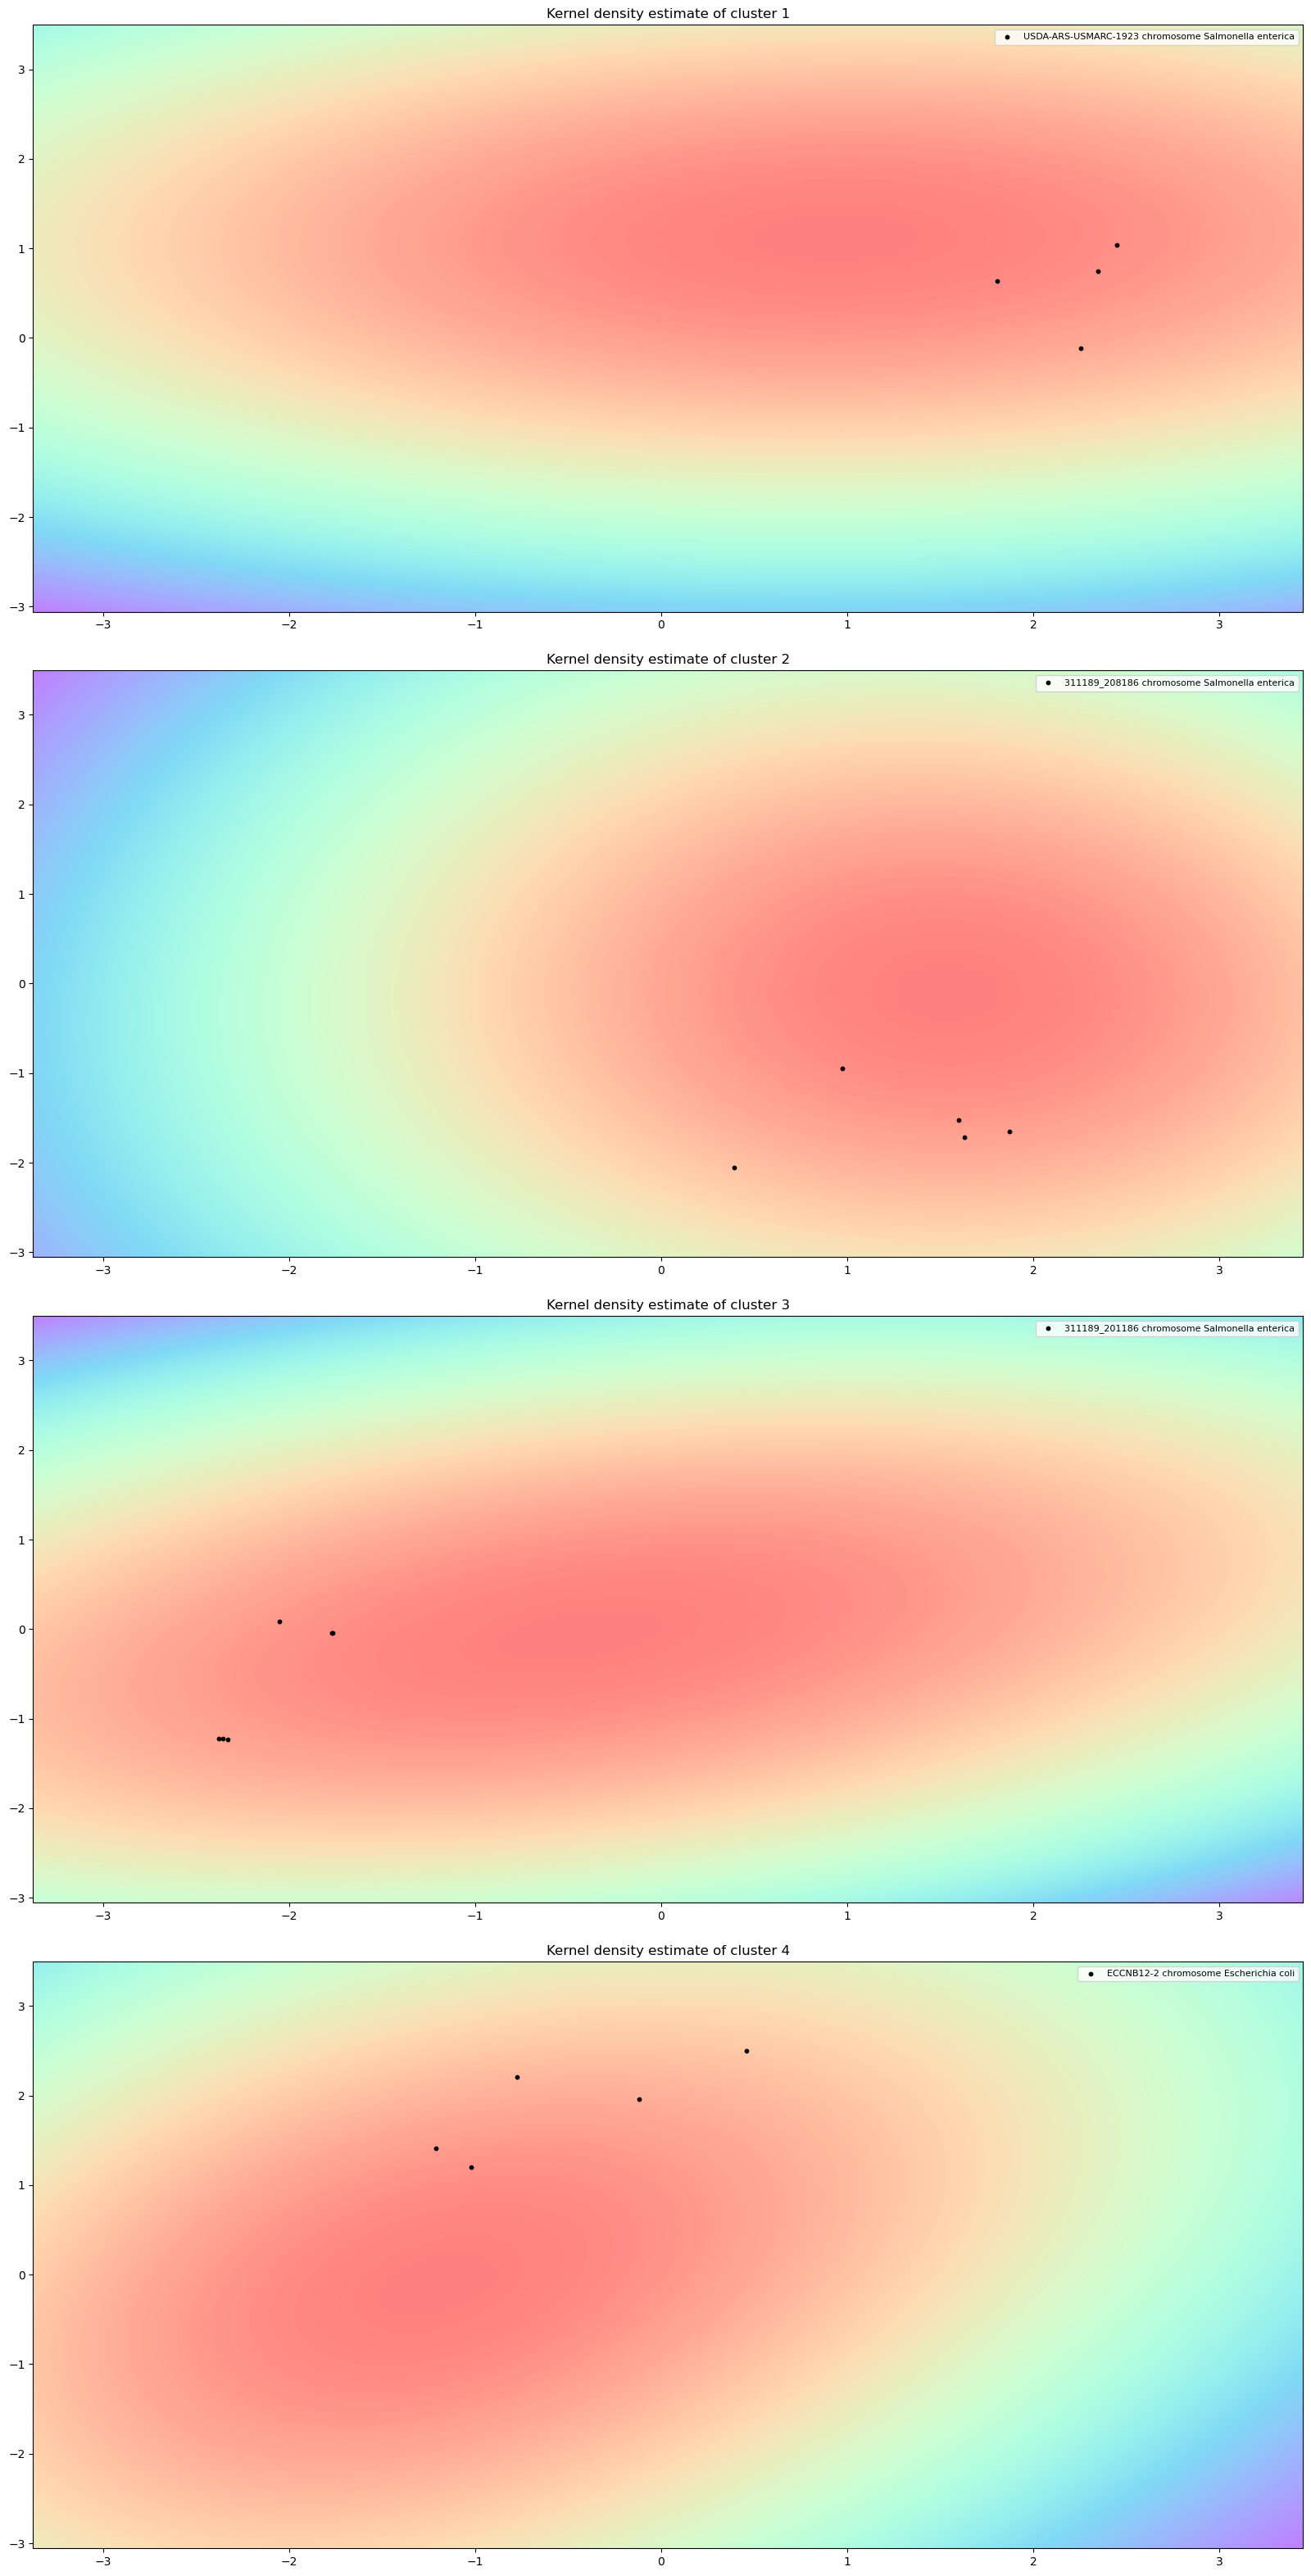

In [335]:
fig, axs = plt.subplots(4, 1, figsize=(20, 40))

for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth= 0.8, metric = best_metric).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        X, Y = np.meshgrid(x_grid, y_grid)
        XY = np.c_[X.ravel(), Y.ravel()]
        kde_vals = np.exp(kde.score_samples(XY))
        axs[i-1].imshow(kde_vals.reshape(X.shape), origin='lower', extent=[x_grid_min - 1, x_grid_max + 1, y_grid_min - 1, y_grid_max + 1], aspect='auto', alpha=0.5, cmap='rainbow')
        axs[i-1].scatter(cluster_i[:, 0], cluster_i[:, 1], label=names[i], s=10, color='black')
        axs[i-1].legend(loc='best', fontsize=8)
        axs[i-1].set_title('Kernel density estimate of cluster ' + str(i))
        
plt.xlim(x_grid_min - 1, x_grid_max + 1) # set the x axis limit
plt.ylim(y_grid_min - 1, y_grid_max + 1) # set the y axis limit
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

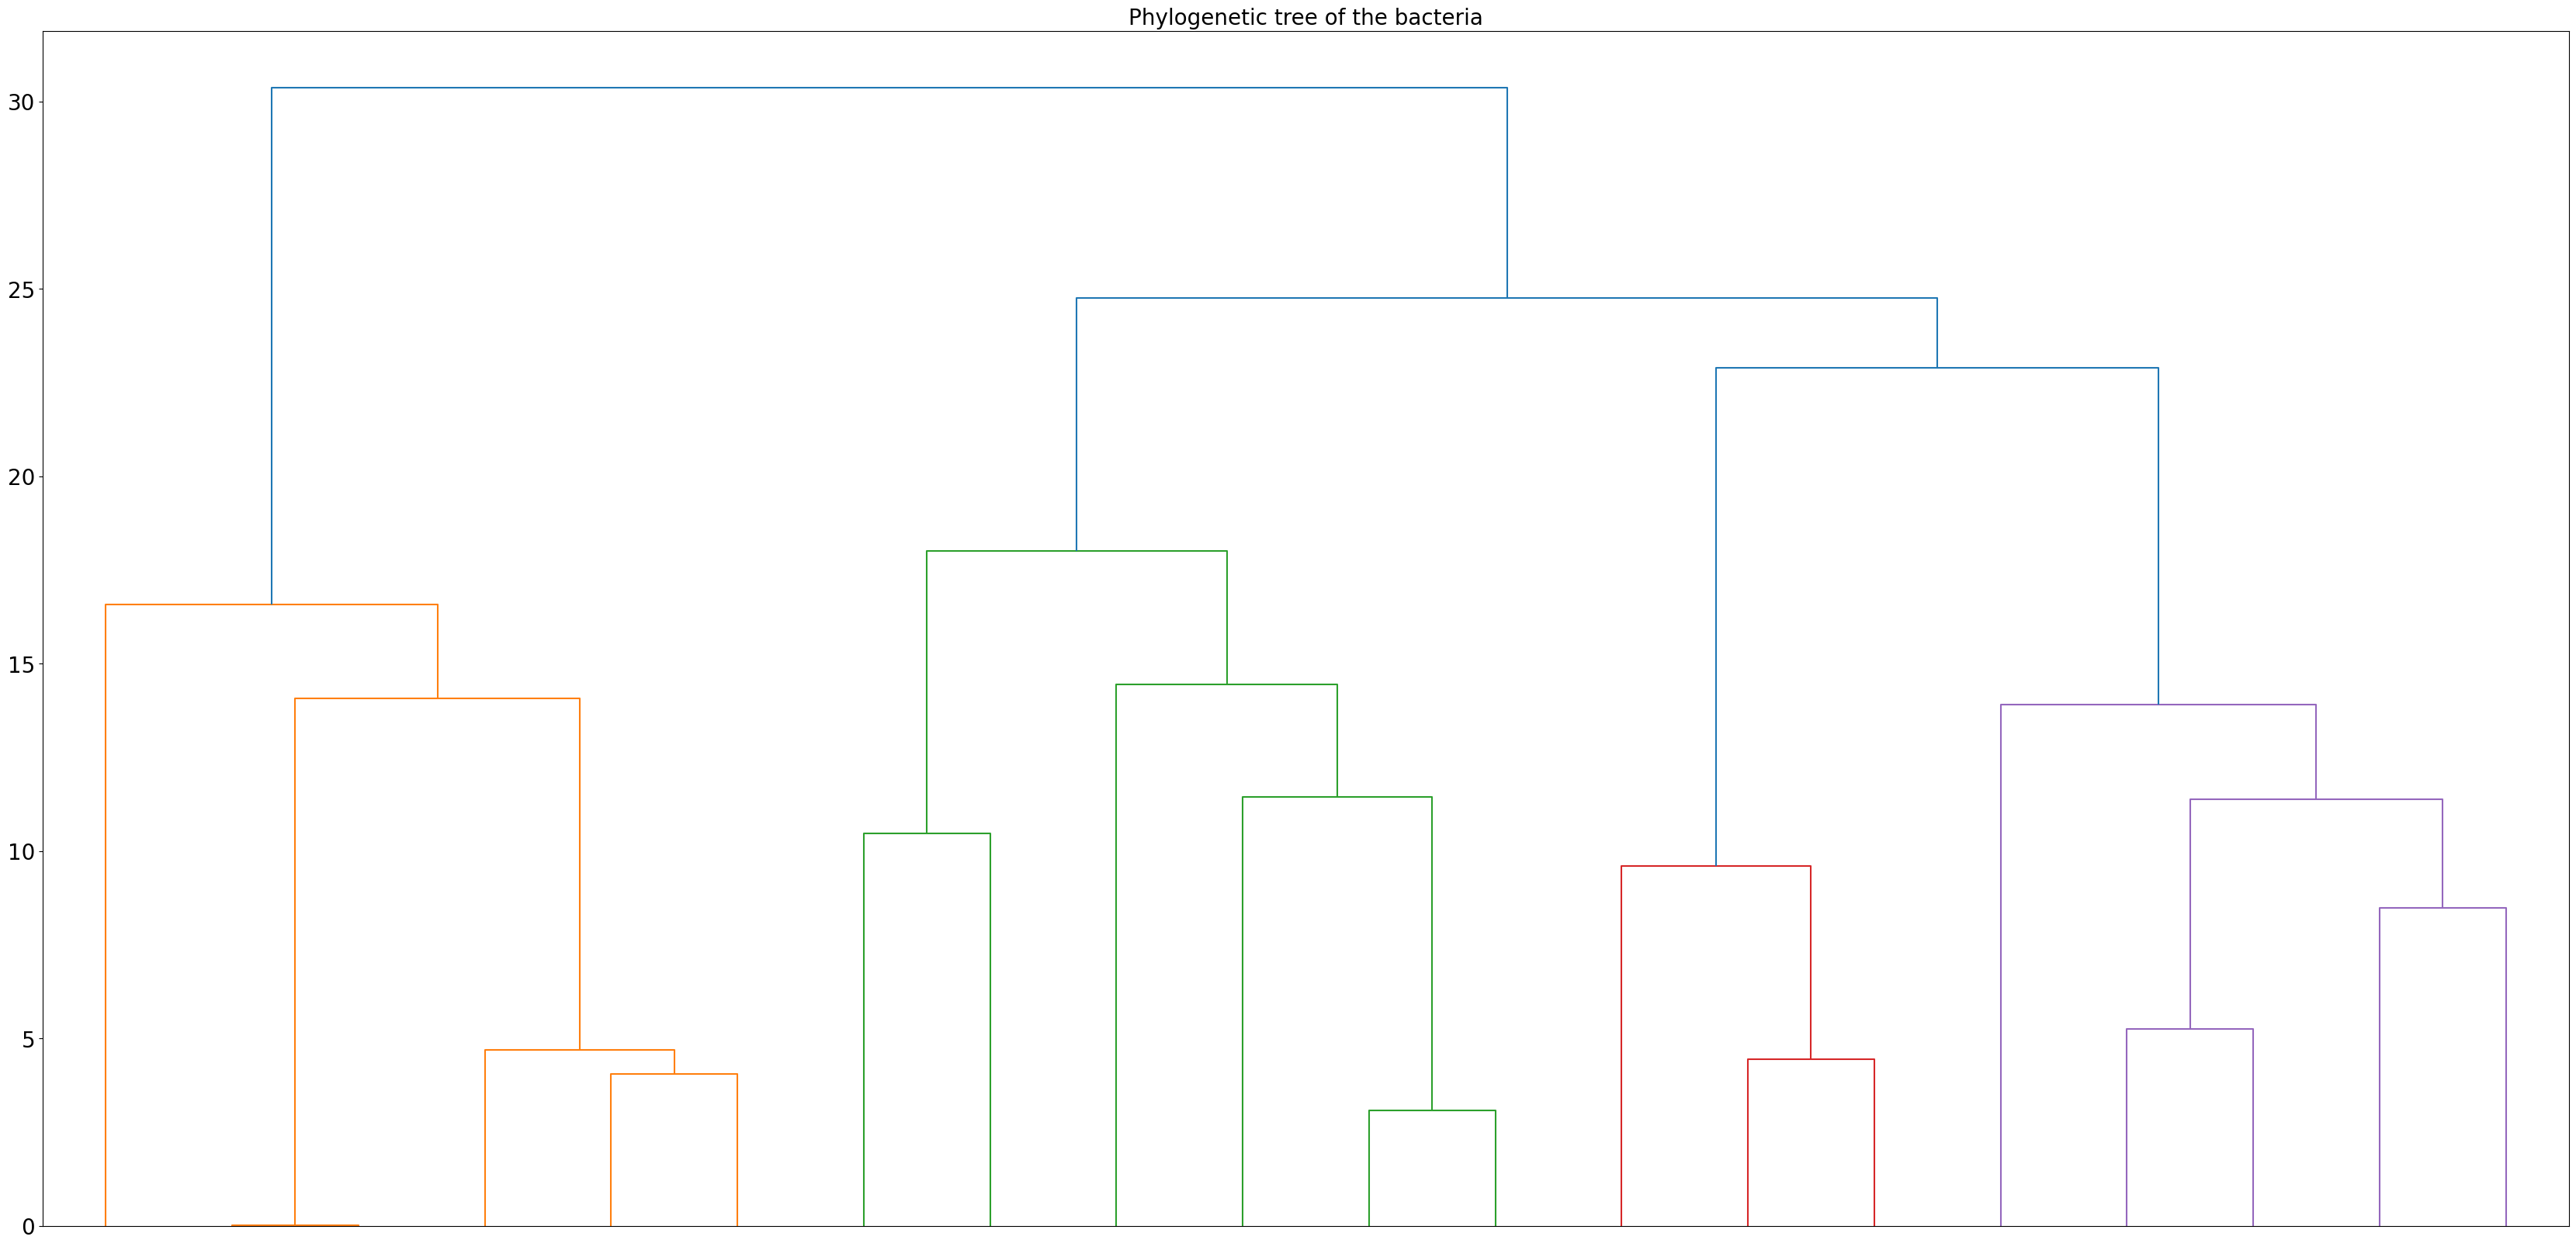

In [403]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z, leaf_label_func=leaf_label_func, no_labels = True)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

/home/antoine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/antoine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



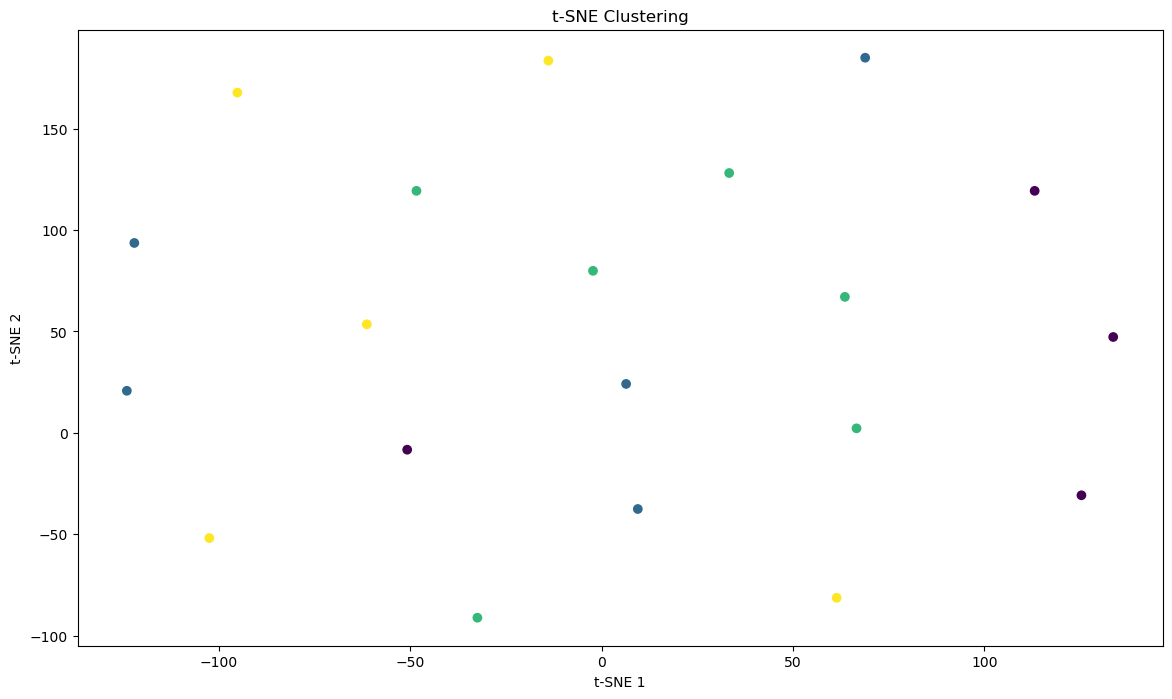

In [337]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(dissimilarity_matrices)
fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(tsne_result[:,0],tsne_result[:,1],c=hierarchical_labels)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Clustering')
plt.show()

In [407]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 6.5
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array
clusters = fcluster(Z, t=2, criterion='maxclust')
edges = []
for i in range(len(whole_matrix_bact)):
    mat_i = np.array(whole_matrix_bact[i])
    for j in range(i+1,len(whole_matrix_bact)):
        mat_j = np.array(whole_matrix_bact[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)
colori = [0 for i in range(20)]
# Create a scatter plot of the graph
for i in range(20):
    if names[i].split()[-2:] == ['Escherichia', 'coli']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])
# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria (10 longest)'
)
fig.show()


In [394]:
distance_matrices = whole_matrix_bact_mid
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=3, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names_mid[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z_mid = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z_mid, t=3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names_mid, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = 'size',
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria (10 in the middle): Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

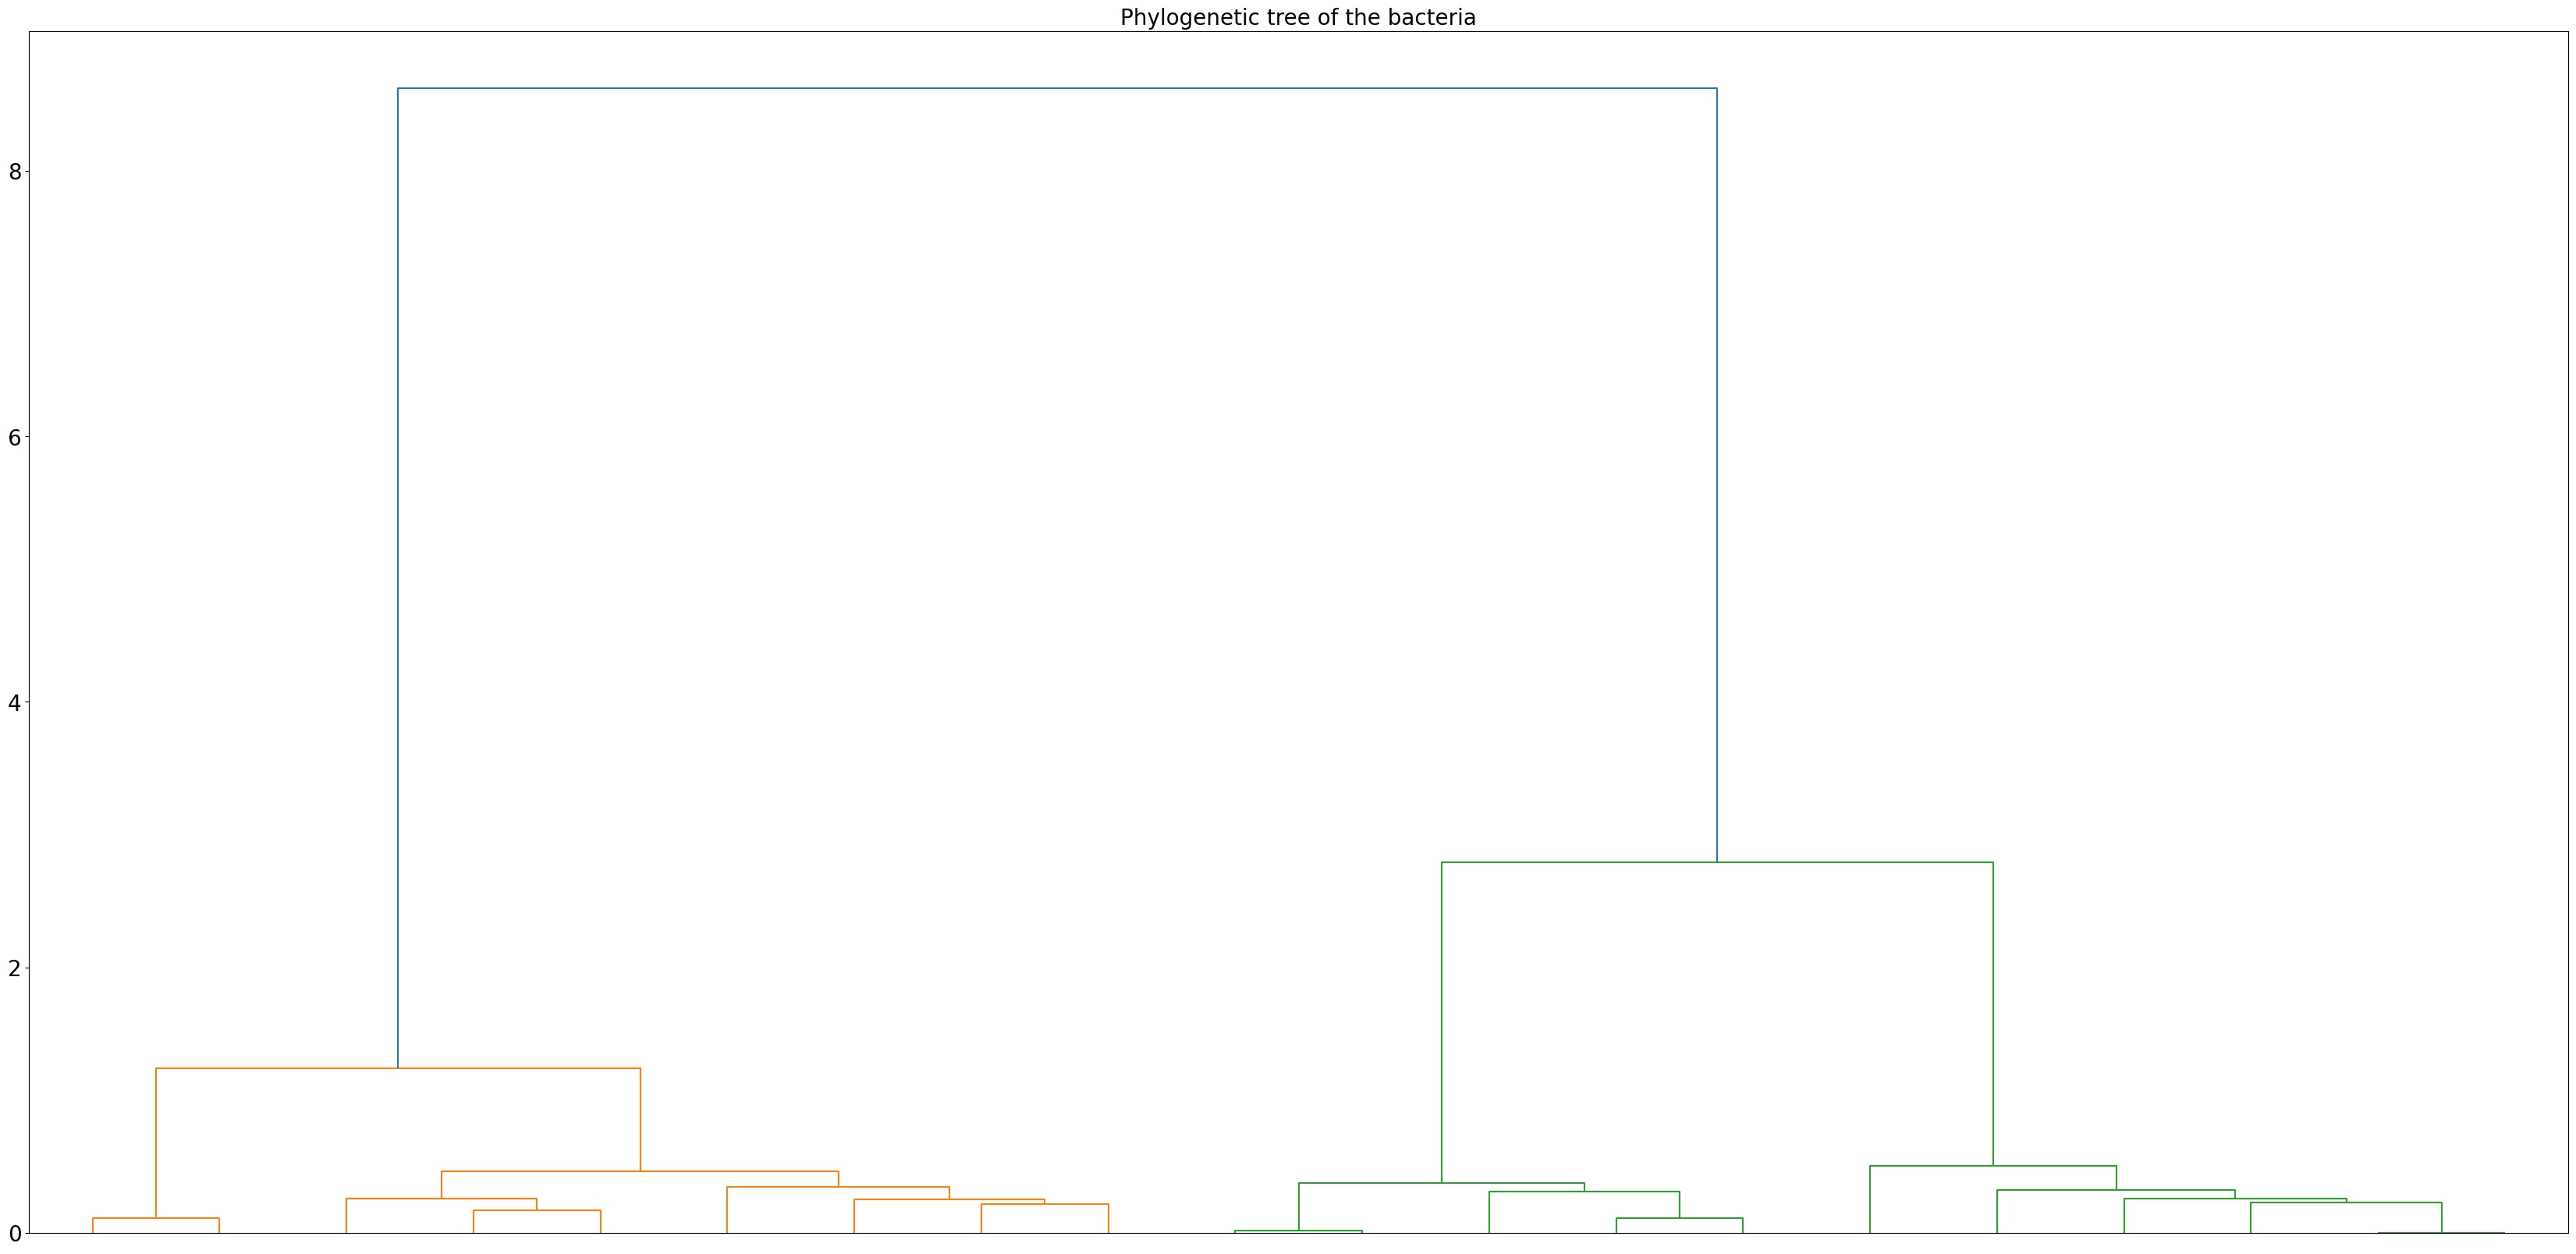

In [385]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z_mid,leaf_label_func = leaf_label_func, no_labels = True, show_contracted = True)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

In [411]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 12.4
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names_mid[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array
clusters = fcluster(Z_mid, t=2, criterion='maxclust')
edges = []
for i in range(len(whole_matrix_bact_mid)):
    mat_i = np.array(whole_matrix_bact_mid[i])
    for j in range(i+1,len(whole_matrix_bact_mid)):
        mat_j = np.array(whole_matrix_bact_mid[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)

colori = [0 for i in range(20)]
# Create a scatter plot of the graph
for i in range(20):
    if names[i].split()[-2:] == ['Escherichia', 'coli']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])

# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria (10 middle)'
)
fig.show()


### With "biased" data ###
We will now use data which has already been studied. The point of this step is to know formerly "hubs" of bacteria to observe the narrow links that can occurs between those.

In [396]:
distance_matrices = whole_matrix_bact_misha_long
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=3, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names_misha[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z_misha_long = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z_misha_long, t=3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names_misha, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = "size",
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria : Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

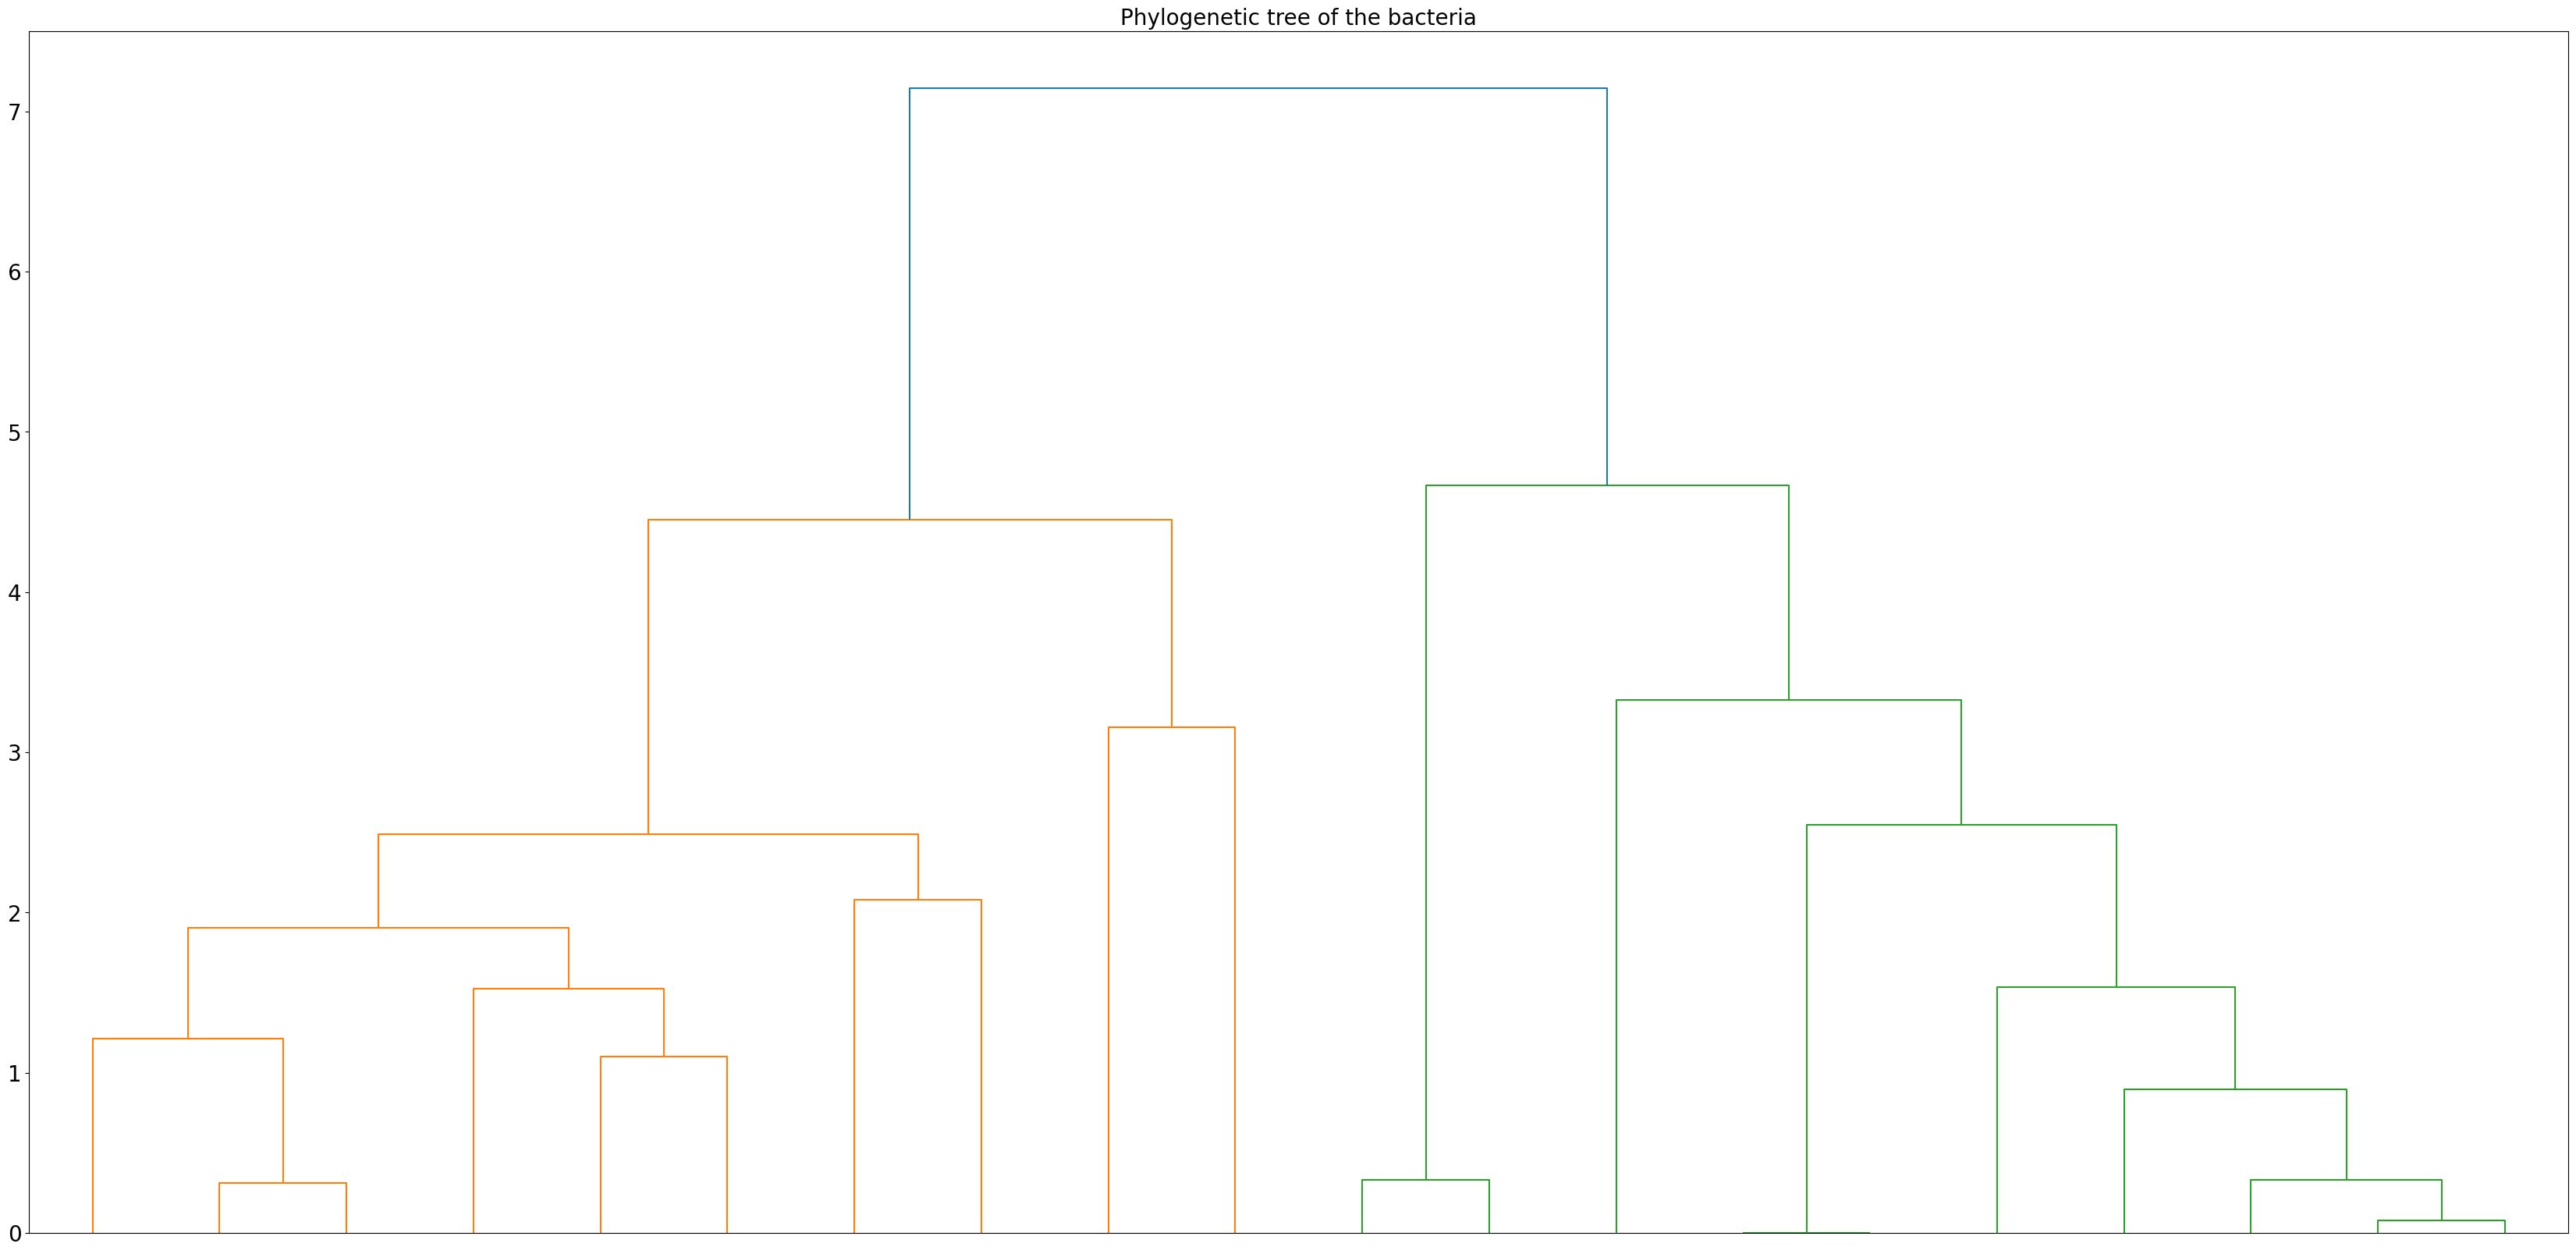

In [377]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z_misha_long,leaf_label_func = leaf_label_func, no_labels = True, show_contracted = True)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

In [357]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 7
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names_misha[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array
clusters = fcluster(Z_misha_long, t=2, criterion='maxclust')
edges = []
for i in range(len(whole_matrix_bact_misha_long)):
    mat_i = np.array(whole_matrix_bact_misha_long[i])
    for j in range(i+1,len(whole_matrix_bact_misha_long)):
        mat_j = np.array(whole_matrix_bact_misha_long[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)
colori = [0 for i in range(20)]
# Create a scatter plot of the graph
for i in range(20):
    if names_misha[i].split()[-2:] == ['Salmonella', 'enterica']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])
# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria'
)
fig.show()


In [397]:
distance_matrices = whole_matric_bact_misha_mummer
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=3, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names_misha[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z_misha_long = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z_misha_long, t=3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names_misha, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = 'size',
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria : Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

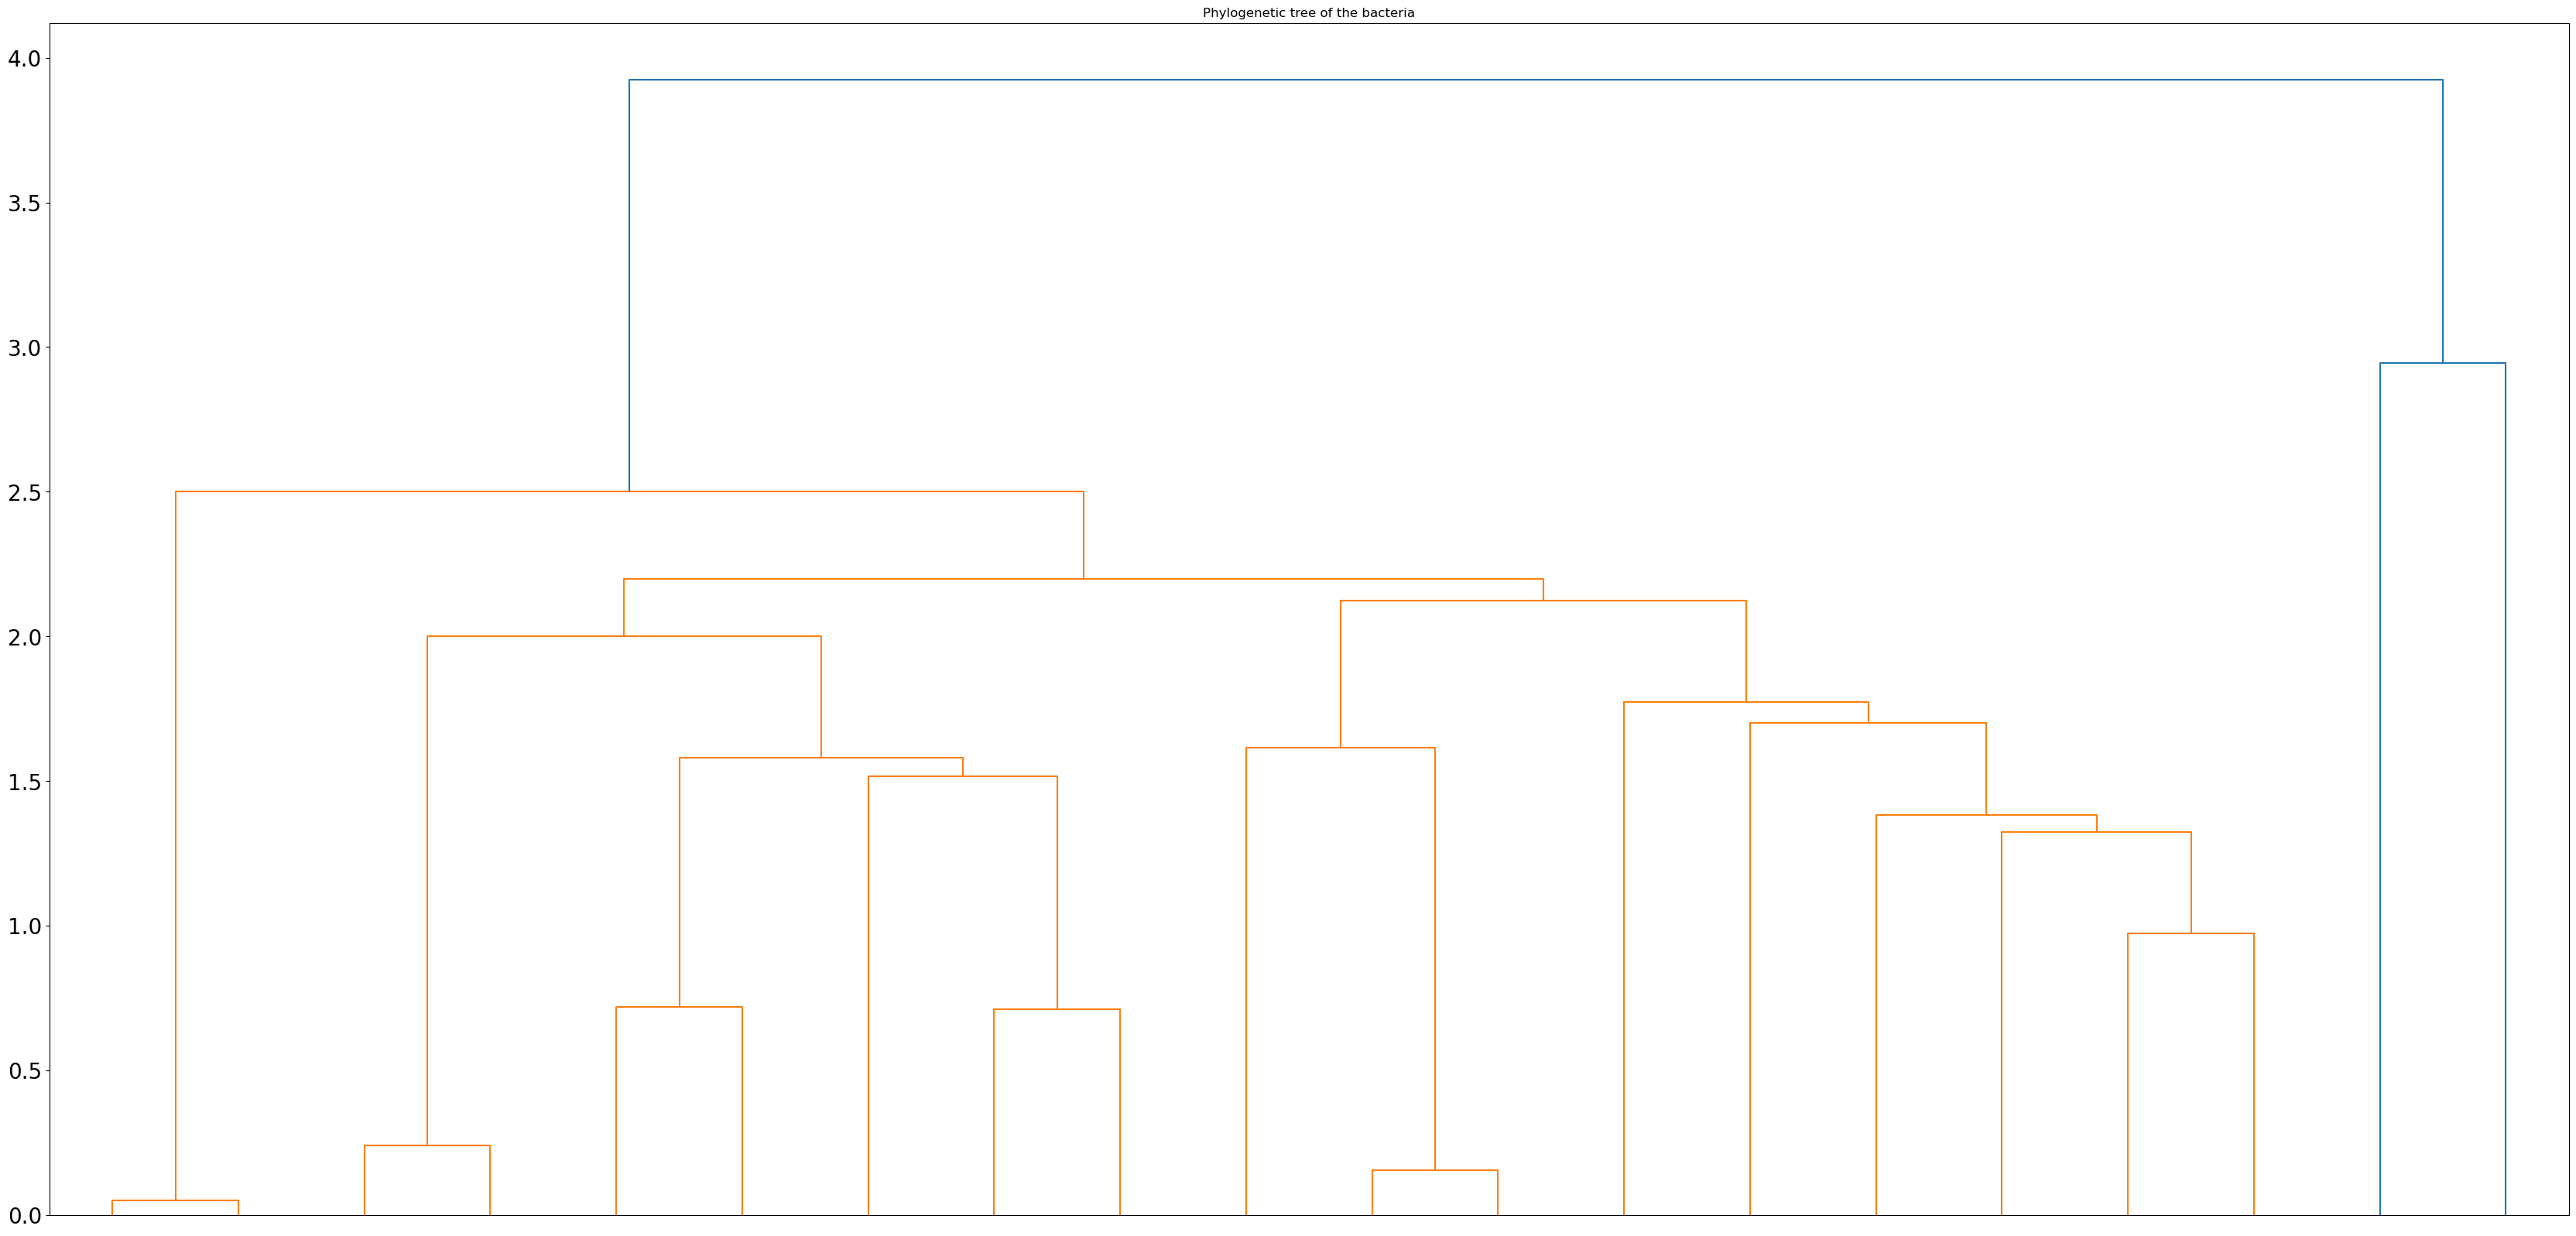

In [366]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z_misha_long,leaf_label_func = leaf_label_func, no_labels = True, show_contracted = True)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

In [433]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 6.5
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names_misha[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array
clusters = fcluster(Z_misha_long, t=2, criterion='maxclust')
edges = []
for i in range(len(whole_matric_bact_misha_mummer)):
    mat_i = np.array(whole_matric_bact_misha_mummer[i])
    for j in range(i+1,len(whole_matric_bact_misha_mummer)):
        mat_j = np.array(whole_matric_bact_misha_mummer[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)

colori = [0 for i in range(20)]
# Create a scatter plot of the graph
for i in range(20):
    if names_misha[i].split()[-2:] == ['Salmonella', 'enterica']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])

# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria'
)
fig.show()


In [446]:
distance_matrices = whole_matrix_bacteria_mummer_t
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=3, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names_misha[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z_misha_long = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z_misha_long, t=3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names_misha, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = 'size',
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria : Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

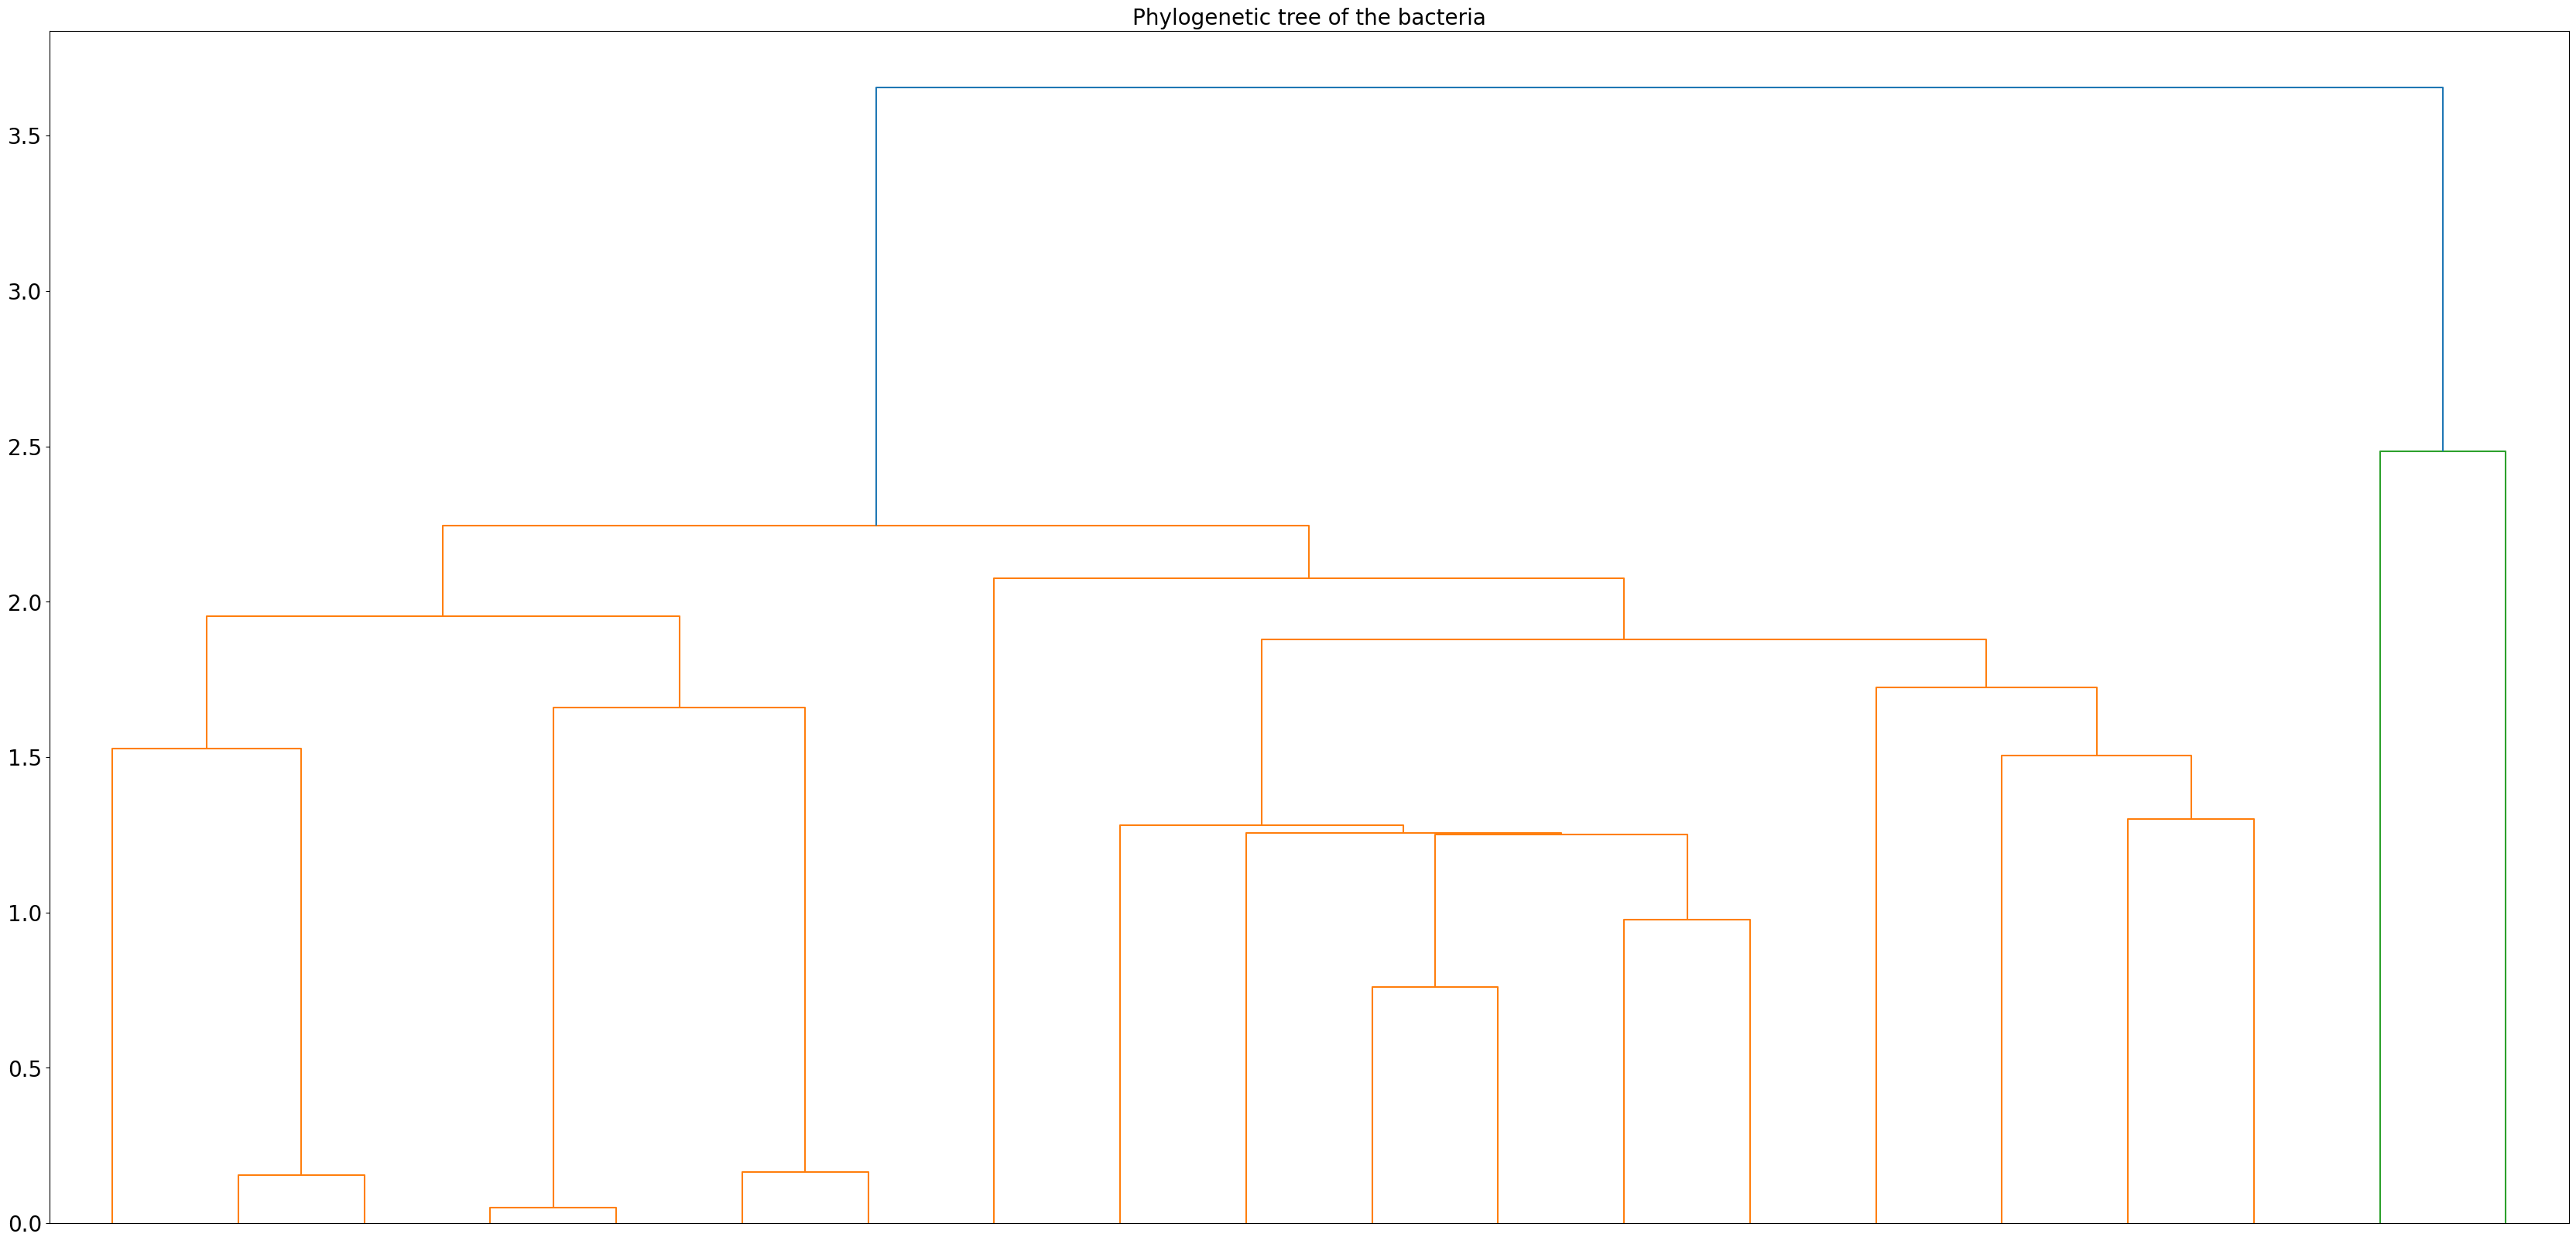

In [447]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z_misha_long,leaf_label_func = leaf_label_func, no_labels = True, show_contracted = True)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

In [449]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 6
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names_misha[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array
clusters = fcluster(Z_misha_long, t=2, criterion='maxclust')
edges = []
for i in range(len(whole_matrix_bacteria_mummer_t)):
    mat_i = np.array(whole_matrix_bacteria_mummer_t[i])
    for j in range(i+1,len(whole_matrix_bacteria_mummer_t)):
        mat_j = np.array(whole_matrix_bacteria_mummer_t[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)

colori = [0 for i in range(20)]
# Create a scatter plot of the graph
for i in range(20):
    if names_misha[i].split()[-2:] == ['Salmonella', 'enterica']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])

# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria'
)
fig.show()


In [398]:
distance_matrices = whole_matrix_bact_misha_mid
dissimilarity_matrices = [squareform(matrix) for matrix in distance_matrices]

# step 2: Evaluate different linkage methods and distance metrics
linkage_methods = ['single', 'complete', 'average', 'weighted']
metrics = ['euclidean', 'cityblock', 'minkowski', 'chebyshev']
best_linkage, best_metric = None, None
best_silhouette, best_calinski = -1, -1
for linkage_method in linkage_methods:
    for metric in metrics:
        if (metric != 'chebyshev') or (linkage_method != 'complete'):
            Z = linkage(dissimilarity_matrices, method=linkage_method, metric=metric)
            labels = fcluster(Z, t=3, criterion='maxclust') # you can use your prefered method to cut the dendrogram
            silhouette = silhouette_score(dissimilarity_matrices, labels)
            calinski = calinski_harabasz_score(dissimilarity_matrices, labels)
            if silhouette > best_silhouette and calinski > best_calinski:
                best_linkage, best_metric = linkage_method, metric
                best_silhouette, best_calinski = silhouette, calinski

def leaf_label_func(idx):
    return names_misha[idx]
# step 3: Use multiple methods for clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(dissimilarity_matrices)
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Z_misha_mid = linkage(dissimilarity_matrices, method=best_linkage, metric=best_metric)
hierarchical_labels = fcluster(Z_misha_long, t=3, criterion='maxclust')

# Perform PCA
pca = PCA(n_components=2)
pca_var = pca.fit(dissimilarity_matrices)
pca_result = pca.fit_transform(dissimilarity_matrices)
pca_ratio = 100 * pca_var.explained_variance_ratio_

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=3)
cluster_labels = clustering.fit_predict(pca_result)
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)
# Create a DataFrame with the PCA results and cluster labels
df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': cluster_labels, 'name': names_misha, 'size':[10 for i in range(len(pca_result[:,0]))]})
# Calculate Voronoi diagrams


x_grid_min = float('inf')
x_grid_max = -float('inf')
y_grid_min = float('inf')
y_grid_max = -float('inf')
# Plot the points with different colors for each cluster
#fig = px.scatter(data_frame=df, x='x', y='y', color='cluster', hover_data=df, hover_name='name')
for i in range(1,5):
    cluster_i = pca_result[np.where(hierarchical_labels == i)[0]]
    if len(cluster_i) > 0:
        kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(cluster_i)
        x_grid = np.linspace(cluster_i[:, 0].min(), cluster_i[:, 0].max(), 500)
        y_grid = np.linspace(cluster_i[:, 1].min(), cluster_i[:, 1].max(), 500)
        x_grid_min = min(x_grid_min, x_grid.min())
        x_grid_max = max(x_grid_max, x_grid.max())
        y_grid_min = min(y_grid_min, y_grid.min())
        y_grid_max = max(y_grid_max, y_grid.max())


fig = px.scatter(df, x='x', y='y', color='cluster', size = 'size',
                    labels={'x':'X axis  ' + str(pca_ratio[0]) + ' % of variance','y':'Y axis  ' + str(pca_ratio[1]) + ' % of variance','color':'Cluster', 'name' :'Name'},
                    color_discrete_map={0: 'red', 1: 'green', 2: 'blue', 3: 'purple'},
                    hover_name= 'name',
                    title='Clustering of the bacteria : Total variance of ' + str(pca_ratio[0] + pca_ratio[1]) + ' %')
fig.add_trace(go.Scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], mode='markers', marker=dict(color='black', size=15, symbol='x'), text=['Cluster ' + str(i) for i in range(4)], textposition="top center"))

fig.update_layout(xaxis=dict(range=[x_grid_min - 1, x_grid_max + 1]), yaxis=dict(range=[y_grid_min - 1, y_grid_max + 1]))
fig.update_layout(width=1200, height=800)

fig.show()

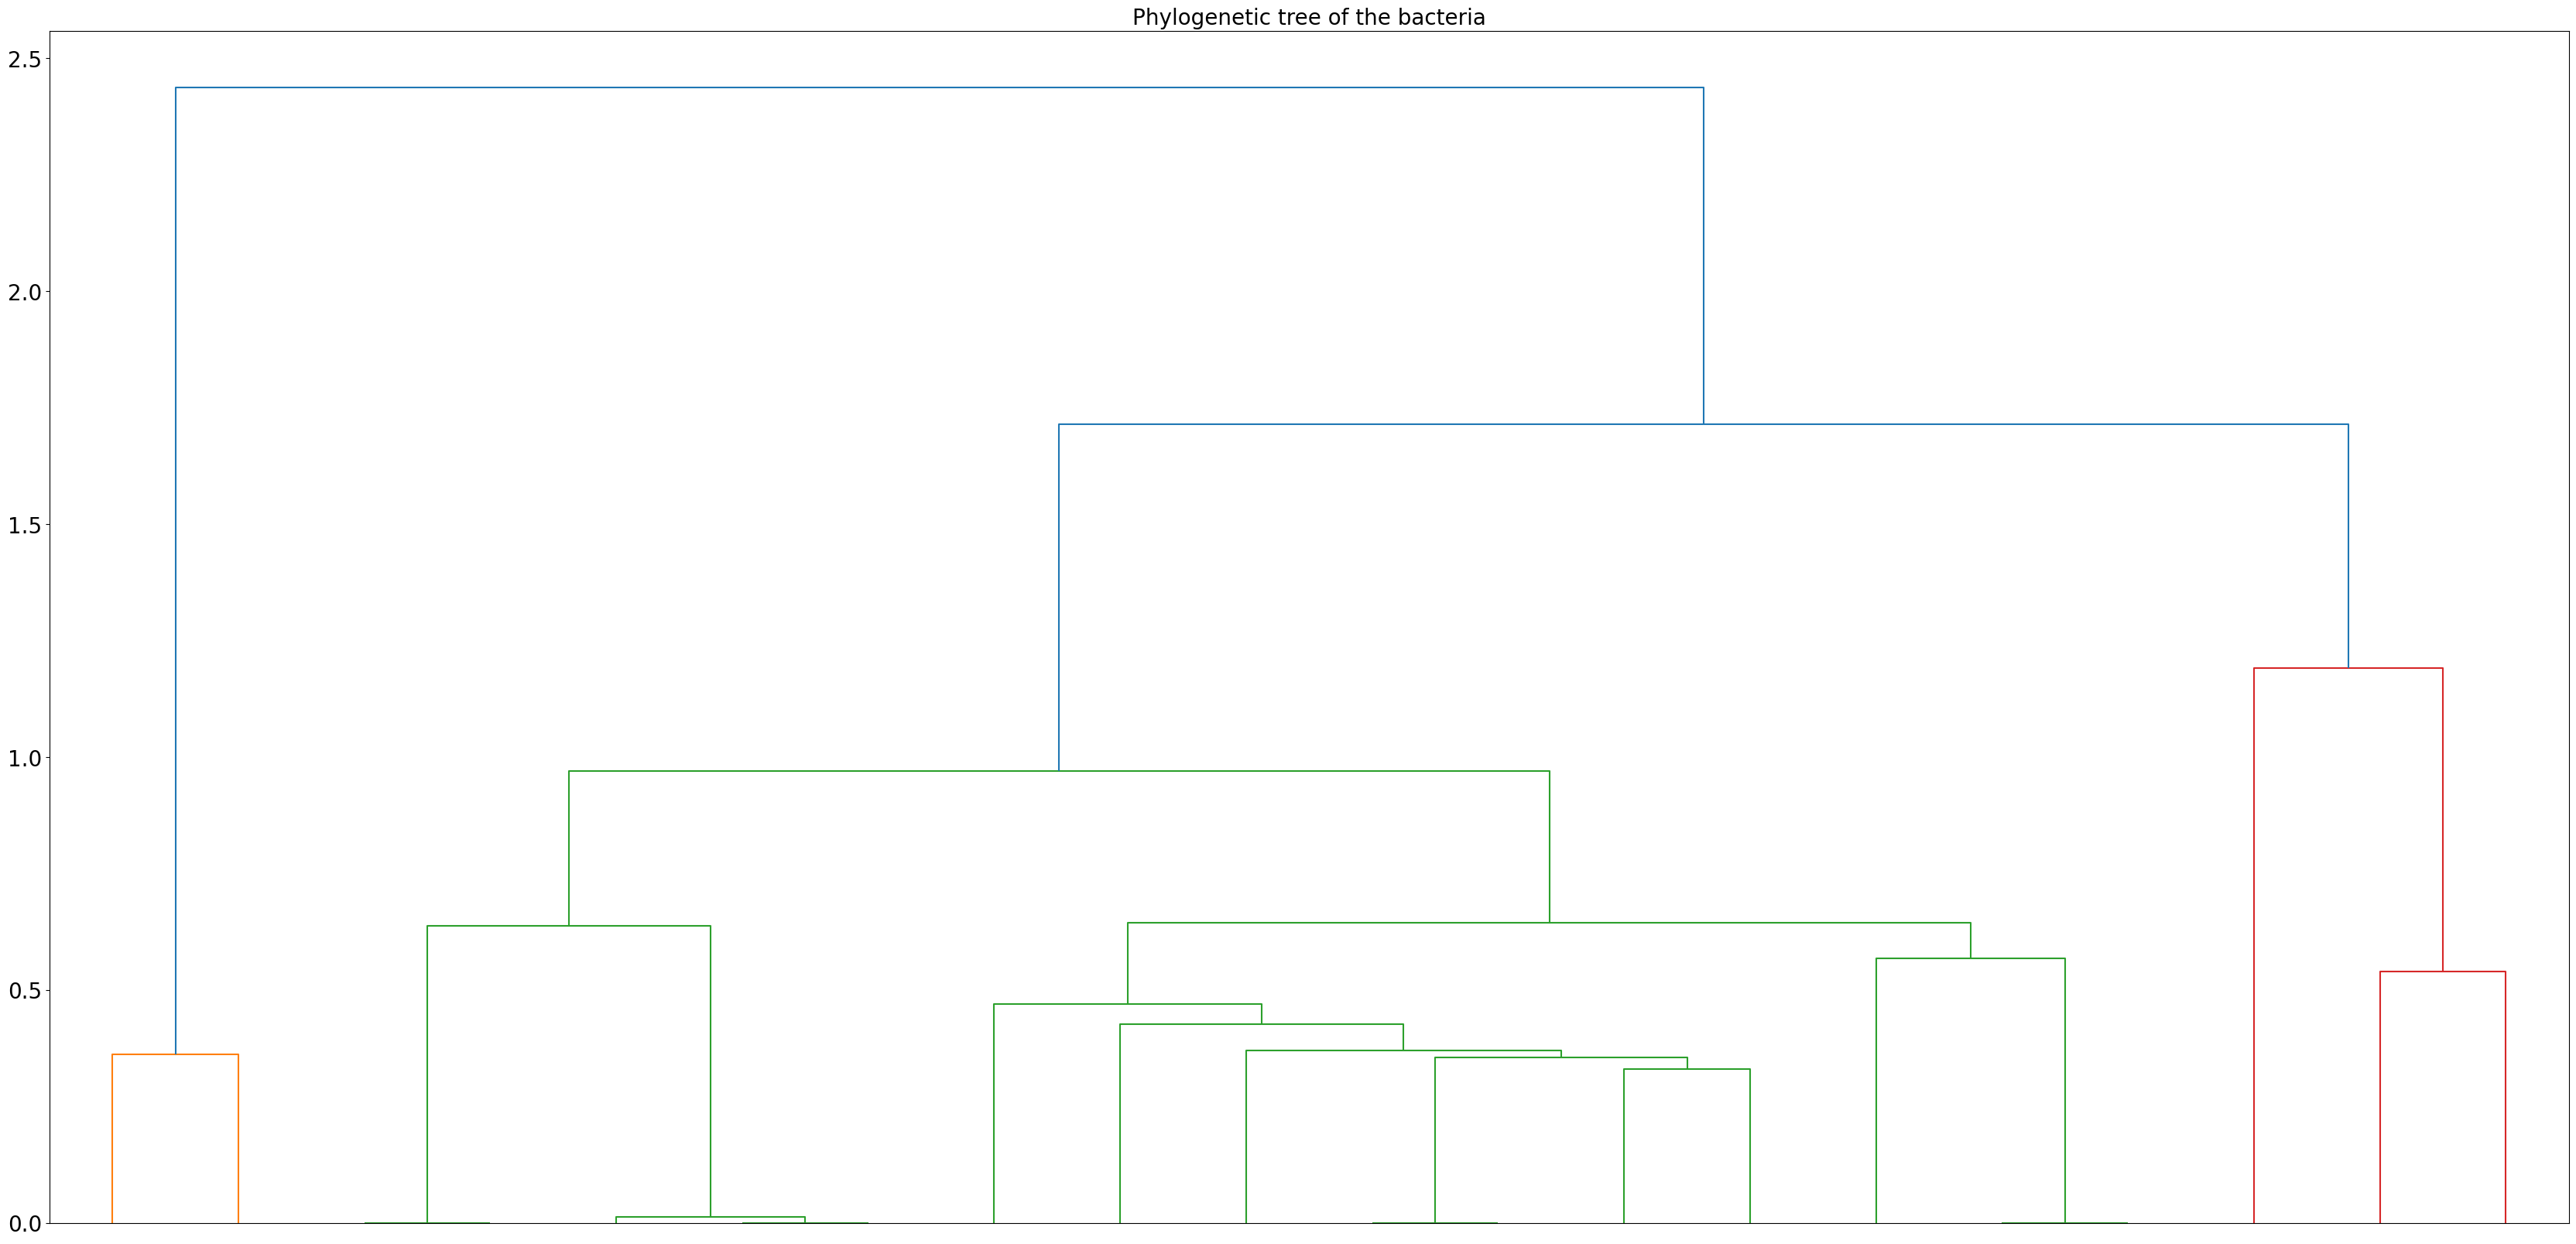

In [384]:
#import seaborn as sns
#sns.set_color_palette("colorblind")
# step 4: Visualize the clusters
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(figsize=(42, 20))
dendro = dendrogram(Z_misha_mid,leaf_label_func = leaf_label_func, no_labels = True, leaf_font_size = 2)
for tick in ax.get_yticklabels():
    tick.set_fontsize(20)
#ax.set_xticklabels(rotation=20)
plt.title('Phylogenetic tree of the bacteria', fontsize = 20)
plt.show()

In [450]:
import networkx as nx
import plotly.graph_objects as go

# threshold distance to use
threshold_distance = 3.5
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(distance_matrices)):
    G.add_node(i, label=names_misha[i])
colors = []
# Iterate over the distance matrices and add edges based on the threshold distance
# Create edges using the linkage array

edges = []
for i in range(len(whole_matrix_bact_misha_mid)):
    mat_i = np.array(whole_matrix_bact_misha_mid[i])
    for j in range(i+1,len(whole_matrix_bact_misha_mid)):
        mat_j = np.array(whole_matrix_bact_misha_mid[j])
        diff = mat_i - mat_j
        frobenius_norm = np.linalg.norm(diff, 'fro')
        if frobenius_norm <= threshold_distance:
            G.add_edge(i, j)
        if frobenius_norm <= threshold_distance / 3:
            colors.append('red')
        elif threshold_distance / 3 < frobenius_norm <= threshold_distance / 2 :
            colors.append('orange')
        elif threshold_distance / 2 < frobenius_norm <= threshold_distance / 1.5 :
            colors.append('yellow')
        elif threshold_distance / 1.5 < frobenius_norm <= threshold_distance / 1.25 :
            colors.append('green') 
        elif threshold_distance / 1.25 < frobenius_norm <= threshold_distance :
            colors.append('black')

# Create a layout for the graph
pos = nx.spring_layout(G)

# Create a scatter plot of the graph
for i in range(20):
    if names_misha[i].split()[-2:] == ['Salmonella', 'enterica']:
        colori[i] = 'red'
    else:
        colori[i] = 'blue'

fig = go.Figure(data=[go.Scatter(x=[pos[i][0] for i in G.nodes], y=[pos[i][1] for i in G.nodes],
                                    mode='markers', text=[G.nodes[i]['label'] for i in G.nodes],
                                    textposition="bottom center",
                                    marker=dict(size=10, color=[colori[i] for i in range(20)]))])

# Add edges to the scatter plot
i = 0
for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                             mode='lines',
                             line=dict(width=1, color=colors[i])))
    i += 1

# Update the layout and show the plot
fig.update_layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                  yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
fig.update_layout(width=1200, height=800)
fig.update_layout(
    title='Web structure of the bacteria'
)
fig.show()
